In [19]:
%matplotlib inline

In [20]:
### Faster SVM run
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [21]:
# Data Analysis Packages,
import os
import random
import pandas as pd
import numpy as np
import itertools
import pathlib
import pickle
import collections
from scipy.stats.stats import spearmanr
from scipy.stats.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
# import shapely.geometry as geom # Calculate a point's distance to a line\n",

# Plot Packages
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedFormatter
from matplotlib import gridspec
from pylab import *

import pylab as pl
from matplotlib.colors import LogNorm
from statannotations.Annotator import Annotator

# ML Packages
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from scipy.optimize import curve_fit
# Regression packages
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.wrappers.scikit_learn import KerasRegressor

from sklearn.model_selection import KFold, GroupKFold

### This might need to be changed

In [22]:
# Font size adjustment
sns.set(font_scale = 1.5)
# Set background
sns.set_style("white")

In [23]:
### Function to import Active Learning data
def processExcelFormat03(name, sheet, percent=0.5):
    DF = pd.read_excel(name, sheet)
    inputName = list(DF.columns)[:-1]
    # print(inputName)
    column_name = inputName + ['Density']
    DF.columns = column_name

    ### Mean or Median
    DF['BinaryClass'] = \
    DF.Density.apply(lambda x: 1 if \
                        x >= DF.Density.quantile(percent)  # 20th percentile\
                        else -1)
    
    return DF

In [24]:
pd.read_excel('round1_01.xlsx', 'FinalTimePoint', index_col=0)

,AMX,CLA,PMBN,Density
29,2,128,2,0.061664
34,16,0,16,1.279325
14,0,128,16,0.192987
12,0,128,0,0.014665
11,0,16,128,0.510887
0,0,0,0,1.043310
3,0,0,128,1.338998
1,0,0,2,1.254132
31,2,128,128,0.220708
13,0,128,2,0.160454


In [25]:
### Function to import Active Learning data first round
def processExcelFormat04(name, sheet, percent=0.5):
    DF = pd.read_excel(name, sheet, index_col=0)
    inputName = list(DF.columns)[:-1]
    # print(inputName)
    column_name = inputName + ['Density']
    DF.columns = column_name

    ### Mean or Median
    DF['BinaryClass'] = \
    DF.Density.apply(lambda x: 1 if \
                        x >= DF.Density.quantile(percent)  # 20th percentile\
                        else -1)
    
    return DF

In [26]:
processExcelFormat04('round1_01.xlsx', 'FinalTimePoint', 0.4)

,AMX,CLA,PMBN,Density,BinaryClass
29,2,128,2,0.061664,-1
34,16,0,16,1.279325,1
14,0,128,16,0.192987,-1
12,0,128,0,0.014665,-1
11,0,16,128,0.510887,-1
0,0,0,0,1.043310,1
3,0,0,128,1.338998,1
1,0,0,2,1.254132,1
31,2,128,128,0.220708,-1
13,0,128,2,0.160454,-1


In [27]:
### Normalize and Split for SVM data
### This fraction here is the number of datapoints
#### Not percentage
def trainingTestSplit(full_df_Ori, n):
    #### Think about alternative scalers
    sc_X = StandardScaler()
    sc_density = StandardScaler()
    
    # Split data into training and testing sets
    TrainDF = full_df_Ori.sample(n = n) #frac = fraction
    TestDF = full_df_Ori[~full_df_Ori.isin(TrainDF)].dropna()

    # Normalize input features
    inputName = list(full_df_Ori.columns)[:-2]
    featureScaler = sc_X.fit(TrainDF[inputName].values)
    scaled_features = featureScaler.transform(TrainDF[inputName].values)
    # Normalize density
    densityScaler = sc_density.fit(TrainDF[['Density']].values)
    scaled_density = densityScaler.transform(TrainDF[['Density']].values)
    
    # Assign normalized training data back
    TrainDF[inputName] = scaled_features
    TrainDF['Density'] = scaled_density
    # Normalize testing set X and density using training scalers
    TestDF[inputName] = featureScaler.transform(TestDF[inputName].values)
    TestDF['Density'] = densityScaler.transform(TestDF[['Density']].values)
    # X & Y for normalized training set
    TrainDF_X = TrainDF[inputName]
    TrainDF_Y = TrainDF['BinaryClass']
    # X & Y for normalized testing set
    TestDF_X = TestDF[inputName]
    TestDF_Y = TestDF['BinaryClass']
    # X & Y for all transformed data, operate on a copy
    # keep the original data intact
    fullDF_copy = full_df_Ori.copy()
    # Transform first
    fullDF_copy[inputName] = featureScaler.transform(fullDF_copy[inputName].values)
    fullDF_copy['Density'] = densityScaler.transform(fullDF_copy[['Density']].values)
    # Then get x & y
    fullDF_X = fullDF_copy[inputName]
    fullDF_Y = fullDF_copy['BinaryClass']
    # Check if we have 2 classes for training
    # In training data too few, we may not have any
    numberOfClasses = len(set(list(TrainDF['BinaryClass'])))
    
    # If only 1 class, recursion until there are 2 classes
    if numberOfClasses == 1: # If not; rerun
        full_df_Ori, fullDF_copy, TrainDF, TestDF, fullDF_X, fullDF_Y,\
        TrainDF_X, TrainDF_Y, TestDF_X, TestDF_Y,\
        sc_X, sc_density = trainingTestSplit(full_df_Ori, n)
        
    return full_df_Ori, fullDF_copy, TrainDF, TestDF, fullDF_X, fullDF_Y,\
TrainDF_X, TrainDF_Y, TestDF_X, TestDF_Y, sc_X, sc_density

In [28]:
def svc_rand_param_selection(TrainDF_X, TrainDF_Y, kernelList):
    ### Select best SVM parameters of any number of kernel(s)
    ### TrainDF_X: X training dataset
    ### TrainDF_Y: Y training dataset
    ### TestDF_X: X testing dataset
    ### TestDF_Y: Y testing dataset
    ### kernelList: the list of kernels to try
    
    Cs = list(10. ** np.arange(-2, 5))
    gammas = list(10. ** np.arange(-4, 2))
    coef0s = list(10. ** np.arange(-4, 4))

    # Create grid parameters to tune: include universal parameters & other parameters
    param_grid = {'C': Cs, 'gamma': gammas+['scale', 'auto'], \
                  'degree':[2,3,4,5], 'kernel': kernelList} ### [1, 2, 3, 4, 5]
    
    # Grid search
    if len(TrainDF_X) >= 10:
        grid = RandomizedSearchCV(SVC(), param_grid, refit = True, n_jobs = -2) # , n_jobs = -1
    elif len(TrainDF_X) < 6:
        grid = RandomizedSearchCV(SVC(), param_grid, refit = True, cv = 1, n_jobs = -2)
    else: # If training instances too few, reduce cross validation fold
        grid = RandomizedSearchCV(SVC(), param_grid, refit = True, cv = 2, n_jobs = -2)

    grid.fit(TrainDF_X.values, TrainDF_Y)
    print(grid.best_estimator_, grid.best_params_, grid.best_score_)

    # Return all parameters in best estimator
    return grid.best_estimator_, grid.best_estimator_.C, grid.best_estimator_.gamma, \
grid.best_estimator_.degree, grid.best_estimator_.kernel, grid.best_estimator_.coef0

In [29]:
### For SVM quantitative prediction mainly
### To be used in autoProcess
##### fullDF_X or just TestDF_X? Can be used for both scenario, might need to change the name
def Quantitative_prediction(fullDF_X, trainedModel):
    ### fullDF_X: full X input
    ### trainedModel: trained SVM model
    quantitative_list = []
    # Process entry by entry
    for entry in range(len(fullDF_X)):
        currentEntry = array(fullDF_X.iloc[entry]) # current entry
        # Get the current entry's score
        sum2 = 0
        sum2 = float(trainedModel.decision_function(np.array([currentEntry])))
        quantitative_list.append(sum2) # -sum2 for other purpose ??

    return quantitative_list

In [30]:
### SVM autoprocess
### Call after spliting & normalization
### Train SVM 1 time
### Plot SVM density vs. quantitative value
### Stats on testing data
def autoProcess(full_df_Ori, fullDF_copy, TrainDF, fullDF_X, TrainDF_X, TrainDF_Y, \
                TestDF_X, TestDF_Y, kernelList, colName):
    # Select model using training data
    fModel, EstC, EstGamma, EstDegree, EstKernel, EstCoef0 = \
    svc_rand_param_selection(TrainDF_X, TrainDF_Y, kernelList)
    # Quantitative prediction on all points
    q_list = Quantitative_prediction(fullDF_X, fModel)
    # Only store on the copy DF
    fullDF_copy[colName] = q_list
    # Locate training data
    trainingIndex = TrainDF.index
    # Locate training set for ploting SVM results
    NewTrainDF = fullDF_copy.loc[trainingIndex]
    NewTestDF = fullDF_copy[~fullDF_copy.isin(NewTrainDF)].dropna()
    
    # Compare with the testing DF
    spearmanCorrelation = spearmanr(NewTestDF[colName], NewTestDF['Density'])
    pearsonCorrelation = pearsonr(NewTestDF[colName], NewTestDF['Density'])
    mse = mean_squared_error(NewTestDF[colName], NewTestDF['Density'], squared=True)
    correlation_matrix = np.corrcoef(NewTestDF[colName], NewTestDF['Density'])
    correlation_xy = correlation_matrix[0,1]
    r2Correlation = correlation_xy**2
    
    return fModel, spearmanCorrelation, pearsonCorrelation, r2Correlation, mse

In [31]:
### Select best SVR parameters of any number of kernel(s)
### X_train: X training dataset
### Y_train: Y training dataset
### X_test: X testing dataset
### Y_test: Y testing dataset
##### Make epsilon tunable
def svr_rand_param_selection(X_train, Y_train, kernelList):
    # 3 universal parameters
    Cs = list(10. ** np.arange(-4, 4))
    gammas = list(10. ** np.arange(-4, 4))
    coef0s = list(10. ** np.arange(-4, 4))
    # Create grid parameters to tune: include 2 universal parameters & other parameters
    param_grid = {'C': Cs, 'gamma': gammas,\
                  'degree':[1,2,3,4,5,6], 'kernel': ['poly', 'rbf', 'sigmoid','linear'], 'coef0': coef0s,\
                 'epsilon':[0.001, 0.01, 0.1, 1]} ### 'poly', 'rbf'
    # rand Search
    if len(X_train) >= 10:
        grid = RandomizedSearchCV(SVR(), param_grid, refit = True, n_jobs = -2) #
    elif len(X_train) == 2:
        grid = RandomizedSearchCV(SVR(), param_grid, refit = True, cv = 1, n_jobs = -2)
    else:
        grid = RandomizedSearchCV(SVR(), param_grid, refit = True, cv = 2, n_jobs = -2)
        
    grid.fit(X_train.values, Y_train)
    
    return grid.best_estimator_, grid.best_estimator_.C, grid.best_estimator_.gamma, \
grid.best_estimator_.degree, grid.best_estimator_.kernel, grid.best_estimator_.coef0


In [32]:
# Run SVR regression once, given training and testing sets
### For both SVCSCR & SVR
### TestY is density for both
### TrainX is 3-variable input for SVCSVR
### TrainY is density for both
### TrainSVRX is 2-variable input for SVR only\n",
def regressionSVR(trainX, trainSVRX, trainY, \
                  testX, testSVRX, testY, \
                  kernelList, Newfull_df_X, sc_density):
    # Weights to be used
    #### Make this tunable too
    weightList = [0.01, 0.1, 1]
    k = 2  
    kf = KFold(n_splits=k, shuffle=True)

    r2WeightList = []
    MSEWeightList = []
    PearsonWeightList = []
    SpearmanWeightList = []
    # May not need this anymore
    r2ModelList = []
    MSEModelList = []
    PearsonModelList = []
    SpearmanModelList = []
    
    # Score for best SVR model
    SVRR2scoreTemp = -1000
    SVRMSEscoreTemp = 200
    SVRPearsonScoreTemp = -2
    SVRSpearmanScoreTemp = -2
    
    SVRbestR2Model = 0
    SVRbestMSEModel = 0
    SVRbestPearsonModel = 0
    SVRbestSpearmanModel = 0
    
    bestR2Weight = 1
    bestMSEWeight = 1
    bestPearsonWeight = 1
    bestSpearmanWeight = 1
    
    bestR2Model = 0
    bestMSEModel = 0
    bestPearsonModel = 0
    bestSpearmanModel = 0

    for i in range(1):    
        if len(trainX) <= 16:
            weightTrainXDF = trainX.sample(frac = 0.7)
        else:
            weightTrainXDF = trainX.sample(frac = 0.8)

        weightTestXDF = trainX.drop(weightTrainXDF.index)
        train_index = weightTrainXDF.index
        test_index = weightTestXDF.index
        TrainY, TestY = trainY.loc[train_index], trainY.loc[test_index]
        TrainYArr = np.array(TrainY)
        TestYArr = np.array(TestY)
        SVRTrainXDF, SVRTestXDF = trainSVRX.loc[train_index], trainSVRX.loc[test_index]

        # Score for best model
        R2scoreTemp = -1000
        MSEscoreTemp = 200
        PearsonScoreTemp = -2
        SpearmanScoreTemp = -2
        R2modelTemp = 0
        MSEmodelTemp = 0
        PearsonmodelTemp = 0
        SpearmanmodelTemp = 0

        # Loop through distances * different weights:
        for w in weightList:
            trainXCopy = weightTrainXDF.copy()
            testXCopy = weightTestXDF.copy()
            # Transform
            trainXCopy['SVM Quant Estimation'] = trainXCopy['SVM Quant Estimation'].apply(lambda x: x*w)
            testXCopy['SVM Quant Estimation'] = testXCopy['SVM Quant Estimation'].apply(lambda x: x*w)
            # Select best parameters
            model, EstC, EstGamma, EstDegree, EstKernel, EstCoef0 = \
        svr_rand_param_selection(trainXCopy, TrainYArr, kernelList)
            #### Predict with the best model of the current weight
            #### On a slice of the training data
            weightY_pred = model.predict(testXCopy.values)
            predictedDensityInversedBack = sc_density.inverse_transform(weightY_pred.reshape(-1, 1))
            # Invert back testY
            testDensityInversedBack = sc_density.inverse_transform(TestYArr.reshape(-1, 1))
            #### Select the best weight for all metrics
            # R2
            corrTestDensity = testDensityInversedBack.reshape(len(TestYArr))
            corrPredictedDensity = predictedDensityInversedBack.reshape(len(TestYArr)) 
            correlation_matrix = np.corrcoef(corrTestDensity, corrPredictedDensity)
            correlation_xy = correlation_matrix[0,1]
            R2score = correlation_xy**2
            if (math.isnan(R2score) == False) & (R2score > R2scoreTemp):
                R2scoreTemp = R2score
                bestR2Model = model
                bestR2Weight = w
                
            # MSE
            MSEscore = mean_squared_error(corrTestDensity, corrPredictedDensity, squared=True)
            print('MSE: ', MSEscore)
            if (math.isnan(MSEscore) == False) & (MSEscore < MSEscoreTemp):
                MSEscoreTemp = MSEscore
                bestMSEModel = model
                bestMSEWeight = w

            # Pearson
            PearsonScore = pearsonr(corrTestDensity, corrPredictedDensity)[0]
            print('Pearson: ', PearsonScore)
            if (math.isnan(PearsonScore) == False) & (PearsonScore > PearsonScoreTemp):
                PearsonScoreTemp = PearsonScore
                bestPearsonModel = model
                bestPearsonWeight = w

            # Spearman
            SpearmanScore = spearmanr(corrTestDensity, corrPredictedDensity)[0]
            print('Spearman: ', SpearmanScore)
            if (math.isnan(SpearmanScore) == False) & (SpearmanScore > SpearmanScoreTemp):
                SpearmanScoreTemp = SpearmanScore
                bestSpearmanModel = model
                bestSpearmanWeight = w

        # Record best weight now for each fold
        r2WeightList.append(bestR2Weight)
        MSEWeightList.append(bestMSEWeight)
        PearsonWeightList.append(bestPearsonWeight)
        SpearmanWeightList.append(bestSpearmanWeight)

        #### Train SVR only now\n",
        SVRmodel, SVREstC, SVREstGamma, SVREstDegree, SVREstKernel, SVREstCoef0 = \
            svr_rand_param_selection(SVRTrainXDF, TrainYArr, kernelList)
        SVRDensity_pred = SVRmodel.predict(SVRTestXDF.values)
        SVRpredictedDensityInversedBack = sc_density.inverse_transform(SVRDensity_pred.reshape(-1, 1))
        # Invert back testY
        SVRtestDensityInversedBack = sc_density.inverse_transform(TestYArr.reshape(-1, 1))
        SVRcorrTestDensity = SVRtestDensityInversedBack.reshape(len(TestYArr))
        SVRcorrPredictedDensity = SVRpredictedDensityInversedBack.reshape(len(TestYArr))
        # Get correlation
        SVRcorrelation_matrix = np.corrcoef(SVRcorrTestDensity, SVRcorrPredictedDensity)
        SVRcorrelation_xy = SVRcorrelation_matrix[0,1]
        SVRR2score = SVRcorrelation_xy**2

        if SVRR2score > SVRR2scoreTemp:
            SVRR2scoreTemp = SVRR2score
            SVRbestR2Model = SVRmodel
        # MSE
        SVRMSEscore = mean_squared_error(SVRcorrTestDensity, SVRcorrPredictedDensity, squared=True)
        if SVRMSEscore < SVRMSEscoreTemp:
            SVRMSEscoreTemp = SVRMSEscore
            SVRbestMSEModel = SVRmodel
        # Pearson
        SVRPearsonScore = pearsonr(SVRcorrTestDensity, SVRcorrPredictedDensity)[0]
        if SVRPearsonScore > SVRPearsonScoreTemp:
            SVRPearsonScoreTemp = SVRPearsonScore
            SVRbestPearsonModel = SVRmodel
        # Spearman
        SVRSpearmanScore = spearmanr(SVRcorrTestDensity, SVRcorrPredictedDensity)[0]
        #print(SpearmanScore)
        if SVRSpearmanScore > SVRSpearmanScoreTemp:
            SVRSpearmanScoreTemp = SVRSpearmanScore
            SVRbestSpearmanModel = SVRmodel
    
    ### SVCSVR
    bestR2Weight = max(set(r2WeightList), key = r2WeightList.count)
    bestMSEWeight = max(set(MSEWeightList), key = MSEWeightList.count)
    bestPearsonWeight = max(set(PearsonWeightList), key = PearsonWeightList.count)
    bestSpearmanWeight = max(set(SpearmanWeightList), key = SpearmanWeightList.count)

    #### To predict using the best weight
    metricWeightList = [bestR2Weight, bestMSEWeight, bestPearsonWeight, bestSpearmanWeight]
    ### Record SVR models
    SVRModelList = [SVRbestR2Model, SVRbestMSEModel, SVRbestPearsonModel, SVRbestSpearmanModel]
    metricList = ['R2', 'MSE', 'Pearson', 'Spearman']
    # To record final prediction scores
    corrList = []
    predictedList = []
    SVRcorrList = []
    SVRpredictedList = []
    # Loop through the 4 metric
    for i in range(4):
        ### Reserved for final training and testing sets
        finalTrainXCopy = trainX.copy()
        finalTestXCopy = testX.copy()

        finalTrainSVRXCopy = trainSVRX.copy()
        finalTestSVRXCopy = testSVRX.copy()

        weight = metricWeightList[i]
        m = metricList[i]
        # First, retrain on the full training set using the selected weight
        # Transform
        finalTrainXCopy['SVM Quant Estimation'] = \
        finalTrainXCopy['SVM Quant Estimation'].apply(lambda x: x*weight)

        finalModel, EstC, EstGamma, EstDegree, EstKernel, EstCoef0 = \
        svr_rand_param_selection(finalTrainXCopy, trainY, kernelList)
        
        # Now predict
        corr, predictedDensity = \
        finalCorrPrediction(finalTestXCopy, testY, weight, finalModel, sc_density, metric = m)
        corrList.append(corr) # Save results
        predictedList.append(predictedDensity)
        
        #### For SVR -- retrain with the best model and predict
        SVRCurrModel = SVRModelList[i]
        if SVRCurrModel != 0:
            SVRCurrModel.fit(finalTrainSVRXCopy.values, trainY)
        else: 
            SVRCurrModel, EstC, EstGamma, EstDegree, EstKernel, EstCoef0 = \
            svr_rand_param_selection(finalTrainSVRXCopy, trainY, kernelList)
        # Predict
        SVRcorr, SVRpredictedDensity = \
        SVROnlyfinalCorrPrediction(finalTestSVRXCopy, testY, 1, SVRCurrModel, sc_density, metric = m)
        SVRcorrList.append(SVRcorr)
        SVRpredictedList.append(SVRpredictedDensity)

    print('SVM: ', corrList) #, predictedList)
    print('SVR: ', SVRcorrList) #, SVRpredictedList)
    R2Corr, MSECorr, PearsonCorr, SpearmanCorr = corrList[0], corrList[1], corrList[2], corrList[3]
    R2Predicted, MSEPredicted, PearsonPredicted, SpearmanPredicted = \
    predictedList[0], predictedList[1], predictedList[2], predictedList[3]
    
    SVRR2Corr, SVRMSECorr, SVRPearsonCorr, SVRSpearmanCorr = \
    SVRcorrList[0], SVRcorrList[1], SVRcorrList[2], SVRcorrList[3]
    SVRR2Predicted, SVRMSEPredicted, SVRPearsonPredicted, SVRSpearmanPredicted = \
    SVRpredictedList[0], SVRpredictedList[1], SVRpredictedList[2], SVRpredictedList[3]

    return bestR2Model, bestR2Weight, R2Corr, R2Predicted, bestMSEModel, bestMSEWeight, MSECorr, MSEPredicted,\
bestPearsonModel, bestPearsonWeight, PearsonCorr, PearsonPredicted,\
bestSpearmanModel, bestSpearmanWeight, SpearmanCorr, SpearmanPredicted,\
SVRbestR2Model, SVRR2Corr, SVRR2Predicted, SVRbestMSEModel, SVRMSECorr, SVRMSEPredicted, \
SVRbestPearsonModel, SVRPearsonCorr, SVRPearsonPredicted, SVRbestSpearmanModel, SVRSpearmanCorr, SVRSpearmanPredicted
# bestModel, RegressionR2Corr, RegressionMSECorr, RegressionPearsonCorr, RegressionSpearmanCorr"


In [33]:
def finalCorrPrediction(testX, testY, weight, bestModel, sc_density, metric = 'R2'):
    finalTestX = testX.copy()
    finalTestX['SVM Quant Estimation'] = finalTestX['SVM Quant Estimation'].apply(lambda x: x*weight)
    predictedDensity = bestModel.predict(finalTestX)
    predictedDensityInversedBack = sc_density.inverse_transform(predictedDensity.reshape(-1, 1))
    # Invert back testY
    testYArr = np.array(testY)
    testDensityInversedBack = sc_density.inverse_transform(testYArr.reshape(-1, 1))
    corrTestDensity = testDensityInversedBack.reshape(len(testY))
    corrPredictedDensity = predictedDensityInversedBack.reshape(len(testY))
    
    if metric == 'R2':
        correlation_matrix = np.corrcoef(corrTestDensity, corrPredictedDensity)
        correlation_xy = correlation_matrix[0,1]
        Correlation = correlation_xy**2
    elif metric == 'MSE':
        Correlation = mean_squared_error(corrTestDensity, corrPredictedDensity, squared=True)
    elif metric == 'Pearson':
        Correlation = pearsonr(corrTestDensity, corrPredictedDensity)[0]
    elif metric == 'Spearman':
        Correlation = spearmanr(corrTestDensity, corrPredictedDensity)[0]

    return Correlation, predictedDensityInversedBack


In [34]:
def SVROnlyfinalCorrPrediction(testX, testY, weight, bestModel, sc_density, metric = 'R2'):
    # Predict
    predictedDensity = bestModel.predict(testX)
    predictedDensityInversedBack = sc_density.inverse_transform(predictedDensity.reshape(-1, 1))
    # Invert back testY
    testYArr = np.array(testY)
    testDensityInversedBack = sc_density.inverse_transform(testYArr.reshape(-1, 1))

    corrTestDensity = testDensityInversedBack.reshape(len(testY))
    corrPredictedDensity = predictedDensityInversedBack.reshape(len(testY))

    if metric == 'R2':
        correlation_matrix = np.corrcoef(corrTestDensity, corrPredictedDensity)
        correlation_xy = correlation_matrix[0,1]
        Correlation = correlation_xy**2
    elif metric == 'MSE':
        Correlation = mean_squared_error(corrTestDensity, corrPredictedDensity, squared=True)
    elif metric == 'Pearson':
        Correlation = pearsonr(corrTestDensity, corrPredictedDensity)[0]
    elif metric == 'Spearman':
        Correlation = spearmanr(corrTestDensity, corrPredictedDensity)[0]

    return Correlation, predictedDensityInversedBack


In [35]:
### Normalize and Split for SVM & SVR
def ComparisonTrainingTestSplit(full_df_Ori, n, trainingIndex = 0): #, indices = 0
    sc_X = StandardScaler()
    sc_density = StandardScaler()
    
    if isinstance(trainingIndex, int) == True:
        TrainDF = full_df_Ori.sample(n = n)#frac = fraction  
    else:
        print(trainingIndex)
        TrainDF = full_df_Ori.loc[trainingIndex]
    
    TestDF = full_df_Ori[~full_df_Ori.isin(TrainDF)].dropna()

    # Normalize training inputs
    inputName = list(full_df_Ori.columns)[:-2]
    featureScaler = sc_X.fit(TrainDF[inputName].values)
    scaled_features = featureScaler.transform(TrainDF[inputName].values)
    # Normalize density output
    densityScaler = sc_density.fit(TrainDF[['Density']].values)
    scaled_density = densityScaler.transform(TrainDF[['Density']].values)

    # Assign back
    TrainDF[inputName] = scaled_features
    TrainDF['Density'] = scaled_density
    # Normalize testing set values
    TestDF[inputName] = featureScaler.transform(TestDF[inputName].values)
    TestDF['Density'] = densityScaler.transform(TestDF[['Density']].values)

    # X & Y for normalized training set
    TrainDF_X = TrainDF[inputName]
    TrainDF_Y = TrainDF['BinaryClass']
    TrainDF_Density = TrainDF['Density']
    # X & Y for normalized testing set
    TestDF_X = TestDF[inputName]
    TestDF_Y = TestDF['BinaryClass']
    TestDF_Density = TestDF['Density']

    # X & Y for all transformed data
    fullDF_copy = full_df_Ori.copy()
    # Transform first
    fullDF_copy[inputName] = featureScaler.transform(fullDF_copy[inputName].values)
    fullDF_copy['Density'] = \
    densityScaler.transform(fullDF_copy[['Density']].values)
    # Then get x & y
    fullDF_X = fullDF_copy[inputName]
    fullDF_Y = fullDF_copy['BinaryClass']
    fullDF_Density = fullDF_copy['Density']

    # Check if we have 2 classes for training
    numberOfClasses = len(set(list(TrainDF['BinaryClass'])))
    if numberOfClasses == 1: # If not; rerun
        full_df_Ori, fullDF_copy, TrainDF, TestDF, fullDF_X, fullDF_Y, fullDF_Density, \
        TrainDF_X, TrainDF_Y, TrainDF_Density, TestDF_X, TestDF_Y, TestDF_Density, sc_X, sc_density, \
        = ComparisonTrainingTestSplit(full_df_Ori, n, trainingIndex)

    ### Use test data in the last step
    return full_df_Ori, fullDF_copy, TrainDF, TestDF, fullDF_X, fullDF_Y, fullDF_Density, \
TrainDF_X, TrainDF_Y, TrainDF_Density, TestDF_X, TestDF_Y, TestDF_Density, sc_X, sc_density

In [36]:
# Run SVM + SVR & SVR once together
def ComparisonRunOnce(excelFile, processExcelFormat, sheet, n, indices, kernelList, \
                      percent = 0.8, plasmidNum = 1):
    # Load the data
    if processExcelFormat == 1:
        df = processExcelFormat01(excelFile)
    elif processExcelFormat == 2:
        df = processExcelFormat02(excelFile, sheet)
    elif processExcelFormat == 3:
        df = processExcelFormat03(excelFile, sheet, percent)
    elif processExcelFormat == 4:
        df = processExcelFormat04(excelFile, sheet, percent)
    elif processExcelFormat == 5:
        df = processExcelFormat05(excelFile, sheet)
    elif processExcelFormat == 6:
        df = processExcelFormatMedia(excelFile, sheet)
    elif processExcelFormat == 7:
        df = AndreaDrugScreening(excelFile, sheet)

    # Split the data
    df_Ori, df, dfTrain, dfTest, df_X, df_Y, df_Density, \
    dfTrain_X, dfTrain_Y, dfTrain_Density, dfTest_X, dfTest_Y, dfTest_Density, sc_X, sc_density \
    = ComparisonTrainingTestSplit(df, n, indices)

    trainingIndex = dfTrain.index

    ### Train SVM+SVR one time
    ## Run SVM first
    SVMmodel, spearmanCorrelation, pearsonCorrelation, r2Correlation, mse = \
                autoProcess(df_Ori, df, dfTrain, df_X, dfTrain_X, dfTrain_Y, dfTest_X, dfTest_Y, kernelList,\
                           'SVM Quant Estimation')

    #### Normalize distances
    #### Normalize the ones for training SVC
    sc_distance = StandardScaler()
    # Locate training set
    NewTrainDF = df.loc[trainingIndex]
    distanceScaler = sc_distance.fit(NewTrainDF[['SVM Quant Estimation']].values)
    scaled_newFeatures = distanceScaler.transform(NewTrainDF[['SVM Quant Estimation']].values)
    NewTrainDF[['SVM Quant Estimation']] = scaled_newFeatures

    # Scale all SVC prediction now
    df[['SVM Quant Estimation']] = distanceScaler.transform(df[['SVM Quant Estimation']].values)
    # Get the transformed testing data now
    NewTestDF = df.loc[~df.index.isin(trainingIndex)]

    inputName = list(df_Ori.columns)[:-2]
    newInputName = inputName + ['SVM Quant Estimation']
    # X & Y for all data
    Newfull_df_X = df[newInputName]
    Newfull_df_Y = df['Density']

    # X & Y for training set
    NewTrainDF_X = NewTrainDF[newInputName]
    NewTrainDF_Y = NewTrainDF['Density']
    # X & Y for testing set
    NewTestDF_X = NewTestDF[newInputName]
    NewTestDF_Y = NewTestDF['Density']

    # The SVR part here
    bestR2Model, bestR2Weight, R2Corr, R2Predicted, bestMSEModel, bestMSEWeight, MSECorr, MSEPredicted,\
    bestPearsonModel, bestPearsonWeight, PearsonCorr, PearsonPredicted,\
    bestSpearmanModel, bestSpearmanWeight, SpearmanCorr, SpearmanPredicted,\
    SVRbestR2Model, SVRR2Corr, SVRR2Predicted, SVRbestMSEModel, SVRMSECorr, SVRMSEPredicted, \
    SVRbestPearsonModel, SVRPearsonCorr, SVRPearsonPredicted, SVRbestSpearmanModel, SVRSpearmanCorr, \
    SVRSpearmanPredicted = \
    regressionSVR(NewTrainDF_X, dfTrain_X, NewTrainDF_Y, \
                  NewTestDF_X, dfTest_X, NewTestDF_Y, \
                  kernelList, Newfull_df_X, sc_density)

#     print('Finish SVM SVR Regression')

    return SVMmodel, bestR2Model, bestR2Weight, R2Corr, R2Predicted,\
    bestMSEModel, bestMSEWeight, MSECorr, MSEPredicted,\
    bestPearsonModel, bestPearsonWeight, PearsonCorr, PearsonPredicted,\
    bestSpearmanModel, bestSpearmanWeight, SpearmanCorr, SpearmanPredicted,\
    SVRbestR2Model, SVRR2Corr, SVRR2Predicted, SVRbestMSEModel, SVRMSECorr, SVRMSEPredicted, \
    SVRbestPearsonModel, SVRPearsonCorr, SVRPearsonPredicted, \
    SVRbestSpearmanModel, SVRSpearmanCorr, SVRSpearmanPredicted, \
    NewTrainDF_X, NewTrainDF_Y, Newfull_df_X, Newfull_df_Y, sc_X, sc_density, sc_distance, trainingIndex


In [37]:
def ComparisonMultipleRun(runNum, excelFile, processExcelFormat, sheet, nRange, indices, kernelList,\
                           percent = 0.8, plasmidNum = 1): # Percent or abs value
    # To record scalers
    scXRecorder = {}
    scDensityRecorder = {}
    # This is just for SVC+SVR
    scDistanceRecorder = {}
    
    # To store corr results for SVM+SVR
    complexSVRSpearmanLists = []
    complexSVRPearsonLists = []
    complexSVRR2Lists = []
    complexSVRMSELists = []
    # To store prediction raw data for SVM+SVR
    complexPredictedSVRSpearmanLists = []
    complexPredictedSVRPearsonLists = []
    complexPredictedSVRR2Lists = []
    complexPredictedSVRMSELists = []
    # To record models
    r2Recorder = {}
    mseRecorder = {}
    pearsonRecorder = {}
    spearmanRecorder = {}

    TrainXDFRecorder = {}
    TrainYDFRecorder = {}
    indexRecorder = {}
    SVMSVRFullXRecorder = {}
    SVMSVRFullYRecorder = {}
    SVRFullXRecorder = {}

    # To store results for SVR
    SVRSpearmanLists = []
    SVRPearsonLists = []
    SVRR2Lists = []
    SVRMSELists = []
    
    PredictedSVRSpearmanLists = []
    PredictedSVRPearsonLists = []
    PredictedSVRR2Lists = []
    PredictedSVRMSELists = []
    
    # To record models
    SVRr2Recorder = {}
    SVRmseRecorder = {}
    SVRpearsonRecorder = {}
    SVRspearmanRecorder = {}
        
    # Loop through all split percentage
    for n in nRange:
        # For both: input and density scaler
        scXR = {}
        scDensityR = {}
        scDistanceR = {}

        # For SVM + SVR
        r2Recorder[n] = {}
        mseRecorder[n] = {}
        # Recorder dictionaries
        r2R = {}
        mseR = {}
        pearsonR = {}
        spearmanR = {}
        indexR = {}
        TrainXDF = {}
        TrainYDF = {}
        SVMSVRFullXDF = {}
        SVMSVRFullYDF = {}
        SVRFullXDF = {}

        print(n)
        # Corr Score lists
        spearmanList = []
        pearsonList = []
        r2List = []
        mseList = []
        # Raw prediction lists
        PredictedspearmanList = []
        PredictedpearsonList = []
        Predictedr2List = []
        PredictedmseList = []
        
        # For SVR
        SVRr2Recorder[n] = {}
        SVRmseRecorder[n] = {}
        SVRpearsonRecorder[n] = {}
        SVRspearmanRecorder[n] = {}
        # Recorder dictionaries
        SVRr2R = {}
        SVRmseR = {}
        SVRpearsonR = {}
        SVRspearmanR = {}
        # Score lists
        SVRspearmanList = []
        SVRpearsonList = []
        SVRr2List = []
        SVRmseList = []
        
        PredictedSVRspearmanList = []
        PredictedSVRpearsonList = []
        PredictedSVRr2List = []
        PredictedSVRmseList = []

        for it in range(runNum):
            # Run once
            SVMmodel, bestR2Model, bestR2Weight, R2Corr, R2Predicted,\
            bestMSEModel, bestMSEWeight, MSECorr, MSEPredicted,\
            bestPearsonModel, bestPearsonWeight, PearsonCorr, PearsonPredicted,\
            bestSpearmanModel, bestSpearmanWeight, SpearmanCorr, SpearmanPredicted,\
            SVRbestR2Model, SVRR2Corr, SVRR2Predicted, SVRbestMSEModel, SVRMSECorr, SVRMSEPredicted, \
            SVRbestPearsonModel, SVRPearsonCorr, SVRPearsonPredicted, \
            SVRbestSpearmanModel, SVRSpearmanCorr, SVRSpearmanPredicted, \
            NewTrainDF_X, NewTrainDF_Y, Newfull_df_X, Newfull_df_Y, sc_X, sc_density, sc_distance, trainingIndex = \
            ComparisonRunOnce(excelFile, processExcelFormat, sheet, n, indices, kernelList, \
                                   percent, plasmidNum)

            # Record the set of model with its accuracy
            R2bothModel = (SVMmodel, bestR2Model, bestR2Weight)
            r2R[it] = R2bothModel
            MSEbothModel = (SVMmodel, bestMSEModel, bestMSEWeight)
            mseR[it] = MSEbothModel
            PearsonbothModel = (SVMmodel, bestPearsonModel, bestPearsonWeight)
            pearsonR[it] = PearsonbothModel
            SpearmanbothModel = (SVMmodel, bestSpearmanModel, bestSpearmanWeight)
            spearmanR[it] = SpearmanbothModel
            TrainXDF[it] = NewTrainDF_X
            TrainYDF[it] = NewTrainDF_Y
            SVMSVRFullXDF[it] = Newfull_df_X
            SVMSVRFullYDF[it] = Newfull_df_Y
#             SVRFullXDF[it] = df_X
            indexR[it] = trainingIndex

            # Append each correlation with its split to its corresponding list
            spearmanTuple = (n, SpearmanCorr)
            spearmanList.append(spearmanTuple)
            pearsonTuple = (n, PearsonCorr)
            pearsonList.append(pearsonTuple)
            r2Tuple = (n, R2Corr)
            r2List.append(r2Tuple)
            mseTuple = (n, MSECorr)
            mseList.append(mseTuple)
            
            PredictedspearmanTuple = (n, SpearmanPredicted)
            PredictedspearmanList.append(PredictedspearmanTuple)
            PredictedpearsonTuple = (n, PearsonPredicted)
            PredictedpearsonList.append(PredictedpearsonTuple)
            Predictedr2Tuple = (n, R2Predicted)
            Predictedr2List.append(Predictedr2Tuple)
            PredictedmseTuple = (n, MSEPredicted)
            PredictedmseList.append(PredictedmseTuple)

            
            # Results of SVR
            # Record the set of model with its accuracy
            SVRr2R[it] = SVRbestR2Model
            SVRmseR[it] = SVRbestMSEModel
            SVRpearsonR[it] = SVRbestPearsonModel
            SVRspearmanR[it] = SVRbestSpearmanModel

            # Append each correlation with its split to its corresponding list
            SVRspearmanTuple = (n, SVRSpearmanCorr)
            SVRspearmanList.append(SVRspearmanTuple)
            SVRpearsonTuple = (n, SVRPearsonCorr)
            SVRpearsonList.append(SVRpearsonTuple)
            SVRr2Tuple = (n, SVRR2Corr)
            SVRr2List.append(SVRr2Tuple)
            SVRmseTuple = (n, SVRMSECorr)
            SVRmseList.append(SVRmseTuple)
            
            PredictedSVRspearmanTuple = (n, SVRSpearmanPredicted)
            PredictedSVRspearmanList.append(PredictedSVRspearmanTuple)
            PredictedSVRpearsonTuple = (n, SVRPearsonPredicted)
            PredictedSVRpearsonList.append(PredictedSVRpearsonTuple)
            PredictedSVRr2Tuple = (n, SVRR2Predicted)
            PredictedSVRr2List.append(PredictedSVRr2Tuple)
            PredictedSVRmseTuple = (n, SVRMSEPredicted)
            PredictedSVRmseList.append(PredictedSVRmseTuple)
            
            # Record the scaler for both density and input
            scXR[it] = sc_X
            scDensityR[it] = sc_density
            scDistanceR[it] = sc_distance

        r2Recorder[n] = r2R
        mseRecorder[n] = mseR
        pearsonRecorder[n] = pearsonR
        spearmanRecorder[n] = spearmanR
        SVRr2Recorder[n] = SVRr2R
        SVRmseRecorder[n] = SVRmseR
        SVRpearsonRecorder[n] = SVRpearsonR
        SVRspearmanRecorder[n] = SVRspearmanR
        TrainXDFRecorder[n] = TrainXDF
        TrainYDFRecorder[n] = TrainYDF
        SVMSVRFullXRecorder[n] = SVMSVRFullXDF
        SVMSVRFullYRecorder[n] = SVMSVRFullYDF
#         SVRFullXRecorder[n] = SVRFullXDF
        indexRecorder[n] = indexR
        # Record scalers
        scXRecorder[n] = scXR
        scDensityRecorder[n] = scDensityR
        # This is just for SVC+SVR
        scDistanceRecorder[n] = scDistanceR

        #### Need to solve the issue of giving a good name
        # Append list of criteria values to the master list of lists
        # For SVC+SVR
        complexSVRSpearmanLists.append(spearmanList)
        complexSVRPearsonLists.append(pearsonList)
        complexSVRR2Lists.append(r2List)
        complexSVRMSELists.append(mseList)
        # Raw predicted value
        complexPredictedSVRSpearmanLists.append(PredictedspearmanList)
        complexPredictedSVRPearsonLists.append(PredictedpearsonList)
        complexPredictedSVRR2Lists.append(Predictedr2List)
        complexPredictedSVRMSELists.append(PredictedmseList)
        
        # For SVR
        SVRSpearmanLists.append(SVRspearmanList)
        SVRPearsonLists.append(SVRpearsonList)
        SVRR2Lists.append(SVRr2List)
        SVRMSELists.append(SVRmseList)
        # Raw predicted value
        PredictedSVRSpearmanLists.append(PredictedSVRspearmanList)
        PredictedSVRPearsonLists.append(PredictedSVRpearsonList)
        PredictedSVRR2Lists.append(PredictedSVRr2List)
        PredictedSVRMSELists.append(PredictedSVRmseList)
        

    return complexSVRSpearmanLists, complexSVRPearsonLists, complexSVRR2Lists, complexSVRMSELists, \
complexPredictedSVRSpearmanLists, complexPredictedSVRPearsonLists, complexPredictedSVRR2Lists, \
complexPredictedSVRMSELists, \
r2Recorder, mseRecorder, pearsonRecorder, spearmanRecorder, \
SVRSpearmanLists, SVRPearsonLists, SVRR2Lists, SVRMSELists, \
PredictedSVRSpearmanLists, PredictedSVRPearsonLists, PredictedSVRR2Lists, PredictedSVRMSELists, \
SVRr2Recorder, SVRmseRecorder, SVRpearsonRecorder, SVRspearmanRecorder,\
indexRecorder, TrainXDFRecorder, TrainYDFRecorder, \
SVMSVRFullXRecorder, SVMSVRFullYRecorder, scXRecorder, scDensityRecorder, scDistanceRecorder


In [38]:
def ComparisonResultsListPlot(ResultLists, trainingData = 10, position = 'lower right', \
                              xname = '# training data', yname = '$R^2$', show = 1, ylimit = [0, 1], yline = 0.75):
    
    SVMSVRFinalList, SVRFinalList = ResultLists

    SVMSVRDF = pd.DataFrame(SVMSVRFinalList)
    columnNames = ['Results']
    SVMSVRDF.columns = columnNames
    SVMSVRDF[xname] = trainingData
    SVMSVRDF['Method'] = 'SVC+SVR'

    # SVR scores
    SVRDF = pd.DataFrame(SVRFinalList)
    SVRDF.columns = columnNames
    SVRDF[xname] = trainingData
    SVRDF['Method'] = 'SVR'

    FinalDF = pd.concat([SVMSVRDF, SVRDF])
    p = sns.color_palette("husl", 2)
    sns.boxplot(y='Results', x=xname, 
                data=FinalDF, hue='Method',
                palette=p, saturation=1.0, width=0.4)

    plt.legend(loc=position)
    if yname != "MSE":
        plt.ylim(ylimit)
        if yline != 0:
            plt.axhline(y = yline, color = 'grey', ls = '--', lw = 1.1)   
    else:
        plt.legend(loc='upper right')

    if show == 1:
        plt.xlabel(xname)
        plt.ylabel(yname)
    else:
        plt.xlabel('')
        plt.ylabel('')

    return FinalDF

In [39]:
def ComparisonResultsPlot(ResultLists, position = 'lower right', xname = '# training data', yname = '$R^2$',\
                          show = 1, ylimit = [0, 1], yline = 0.75):
    resultList1, resultList2 = ResultLists
    # SVCSVR scores
    SVMSVRFinalList = []
    for r in resultList1:
        SVMSVRFinalList = SVMSVRFinalList + r

    SVMSVRDF = pd.DataFrame(SVMSVRFinalList)
    columnNames = [xname, 'Results']
    SVMSVRDF.columns = columnNames
    SVMSVRDF['Method'] = 'SVC+SVR'

    # SVR scores
    SVRFinalList = []
    for r in resultList2:
        SVRFinalList = SVRFinalList + r

    SVRDF = pd.DataFrame(SVRFinalList)
    SVRDF.columns = columnNames
    SVRDF['Method'] = 'SVR'

    FinalDF = pd.concat([SVMSVRDF, SVRDF])
    p = sns.color_palette("husl", 2)
    sns.boxplot(y='Results', x=xname, 
                data=FinalDF, hue='Method',
                palette=p, saturation=1.0, width=0.4)

    plt.legend(loc=position)

    if yname != "MSE":
        plt.ylim(ylimit)
        if yline != 0:
            plt.axhline(y = yline, color = 'grey', ls = '--', lw = 1.1)   
    else:
        plt.legend(loc='upper right')

    #sns.despine(offset=10, trim=True)
    if show == 1:
        plt.xlabel(xname)
        plt.ylabel(yname)
    else:
        plt.xlabel('')
        plt.ylabel('')

    return FinalDF

In [40]:
def statsPlot(toPlotDF, statsTest = "t-test_paired", ylabel = 'Results', show = 1, limit = 0):
    statesName = '# Training data'
    states_order = list(set(list(toPlotDF[statesName])))
    states_order.sort()
    subcat_palette = sns.dark_palette("#8BF", reverse=True, n_colors=3)
    subcat_order = ['SVR', 'SVC+SVR']
    
    # Switching hue and x
    hue_plot_params = {
        'data':      toPlotDF,
        'x':         statesName,
        'y':         ylabel,
        "order":     states_order,
        "hue":       "Method",
        "hue_order": subcat_order,
        "palette":   subcat_palette
    }
    if len(states_order) == 4:
        pairs =(
            [(states_order[0], subcat_order[0]), (states_order[0], subcat_order[1])],

            [(states_order[1], subcat_order[0]), (states_order[1], subcat_order[1])],

            [(states_order[2], subcat_order[0]), (states_order[2], subcat_order[1])],

            [(states_order[3], subcat_order[0]), (states_order[3], subcat_order[1])],
        )
    elif len(states_order) == 3:
        pairs =(
            [(states_order[0], subcat_order[0]), (states_order[0], subcat_order[1])],

            [(states_order[1], subcat_order[0]), (states_order[1], subcat_order[1])],

            [(states_order[2], subcat_order[0]), (states_order[2], subcat_order[1])],
        )
    elif len(states_order) == 5:
        pairs =(
            [(states_order[0], subcat_order[0]), (states_order[0], subcat_order[1])],

            [(states_order[1], subcat_order[0]), (states_order[1], subcat_order[1])],

            [(states_order[2], subcat_order[0]), (states_order[2], subcat_order[1])],

            [(states_order[3], subcat_order[0]), (states_order[3], subcat_order[1])],

            [(states_order[4], subcat_order[0]), (states_order[4], subcat_order[1])],
        )
    elif len(states_order) == 1:
        pairs =(
            [(states_order[0], subcat_order[0]), (states_order[0], subcat_order[1])],
        )
    elif len(states_order) == 2:
        pairs =(
            [(states_order[0], subcat_order[0]), (states_order[0], subcat_order[1])],

            [(states_order[1], subcat_order[0]), (states_order[1], subcat_order[1])],
        )
    with sns.plotting_context("notebook", font_scale = 1.4):
        sns.set(font_scale = 4)
        sns.set_style("white")
        # Create new plot
        figsize = (8, 5)
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        # Plot with seaborn
        ax = sns.boxplot(ax=ax, **hue_plot_params)
        # Add stats annotations
        annotator = Annotator(ax, pairs, **hue_plot_params)
        annotator.configure(test = statsTest, verbose=False)

        _, results = annotator.apply_and_annotate()

        if show == 1:
            ax.set_xlabel(statesName, fontsize=40)
            ax.set_ylabel(ylabel, fontsize=40)
        else:
            ax.set_xlabel(" ")
            ax.set_ylabel(" ")

        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
        plt.ylim([-0.1, 1.1])
        plt.show()

In [41]:
def scatterComparisonPlot(DF):
    DFHeader = list(DF.columns)
    FixedName = ['# Training data', 'Method']
    resultsName = [i for i in DFHeader if i not in FixedName]
    resultsName = [i for i in resultsName if i != 'Unnamed: 0']
    print(resultsName)

    DF_SVC = DF[DF['Method'] == 'SVC+SVR']
    DF_SVR = DF[DF['Method'] == 'SVR']

    # Get all different numbers of training data
    trainingDataType = sorted(list(set(DF_SVC['# Training data'])))

    DF_SVC_1 = DF_SVC[DF_SVC['# Training data'] == trainingDataType[0]]
    DF_SVR_1 = DF_SVR[DF_SVR['# Training data'] == trainingDataType[0]]

    # Create new plot
    figsize = (5, 5)
    # Create new plot
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    x = np.linspace(0, 1)
    ax.plot(x, x, 'grey', linewidth=2, zorder=1)

    s1 = plt.scatter(DF_SVR_1[resultsName], DF_SVC_1[resultsName], alpha = 0.7, color = 'tomato', \
                     label = str(trainingDataType[0])+' training data')
    ax.legend(handles=[s1], bbox_to_anchor = (1.7, 1.0), loc='upper right') #, s3

    # At most include 5 different types
    if len(trainingDataType) != 1:
        DF_SVC_2 = DF_SVC[DF_SVC['# Training data'] == trainingDataType[1]]
        DF_SVR_2 = DF_SVR[DF_SVR['# Training data'] == trainingDataType[1]]
        s2 = plt.scatter(DF_SVR_2[resultsName], DF_SVC_2[resultsName], alpha = 0.9, color = 'red', \
                     label = str(trainingDataType[1])+' training data')
        if len(trainingDataType) == 2:           
            ax.legend(handles=[s1, s2], bbox_to_anchor = (1.7, 1.0), loc='upper right') #, s3
            
        else:
            DF_SVC_3 = DF_SVC[DF_SVC['# Training data'] == trainingDataType[2]]
            DF_SVR_3 = DF_SVR[DF_SVR['# Training data'] == trainingDataType[2]]
            s3 = plt.scatter(DF_SVR_3[resultsName], DF_SVC_3[resultsName], alpha = 0.9, color = 'brown', \
                         label = str(trainingDataType[2])+' training data')
            if len(trainingDataType) == 3:
                ax.legend(handles=[s1, s2, s3], bbox_to_anchor = (1.7, 1.0), loc='upper right')
                
            else:
                DF_SVC_4 = DF_SVC[DF_SVC['# Training data'] == trainingDataType[3]]
                DF_SVR_4 = DF_SVR[DF_SVR['# Training data'] == trainingDataType[3]]
                s4 = plt.scatter(DF_SVR_4[resultsName], DF_SVC_4[resultsName], alpha = 0.7, color = 'olive', \
                             label = str(trainingDataType[3])+' training data')
                if len(trainingDataType) == 4:  
                    ax.legend(handles=[s1, s2, s3, s4], bbox_to_anchor = (1.7, 1.0), loc='upper right')
                else:
                    DF_SVC_5 = DF_SVC[DF_SVC['# Training data'] == trainingDataType[4]]
                    DF_SVR_5 = DF_SVR[DF_SVR['# Training data'] == trainingDataType[4]]
                    s5 = plt.scatter(DF_SVR_5[resultsName], DF_SVC_5[resultsName], alpha = 0.7, color = 'cyan', \
                                 label = str(trainingDataType[4])+' training data')
                    if len(trainingDataType) == 5:
                        ax.legend(handles=[s1, s2, s3, s4, s5], bbox_to_anchor = (1.7, 1.0), loc='upper right')

    plt.ylim([0,1])
    plt.xlim([0,1])
    
    plt.tick_params(axis='x',which='major',direction='out',length=5,\
           pad=10,labelsize=25)
    plt.tick_params(axis='y',which='major',direction='out',length=5,\
           pad=10,labelsize=25)
   
    plt.xlabel('SVR Prediction', fontsize=25)
    plt.ylabel('SVC+SVR Prediction', fontsize=25)


In [42]:
# Order of the 4 lists are important
# ['Spearman', 'Pearson', 'R2', 'MSE']
def storeCorrelations(fourCorrLists, excelFilename):
    # Name of the four lists
    sheetNameList = ['Spearman', 'Pearson', 'R2', 'MSE']
    
    # Process each list individually
    for i in range(len(sheetNameList)):
        currentCorrName = sheetNameList[i]
        currentList = fourCorrLists[i]
        finalDf = pd.DataFrame()
        # Process each amount of training data individually
        for j in range(len(currentList)):
            dfTemp = pd.DataFrame(currentList[j])
            finalDf = pd.concat([finalDf, dfTemp])
            
        # Write into excel
        if os.path.isfile(excelFilename) == False:
            finalDf.to_excel(excelFilename, sheet_name = currentCorrName)
        else:
            with pd.ExcelWriter(excelFilename, engine='openpyxl', mode='a') as writer:
                finalDf.to_excel(writer, sheet_name = currentCorrName)
                
    print('Finished storing correlations for: ', excelFilename)


In [43]:
# Order of the 4 lists are important
# ['Spearman', 'Pearson', 'R2', 'MSE']
def storeRawData(fourRawDataLists, excelFilename):
    # Name of the four lists
    sheetNameList = ['Spearman', 'Pearson', 'R2', 'MSE']
    # Order of the lists to store
    
    # Process each list individually
    for i in range(len(sheetNameList)):
        currentCorrName = sheetNameList[i]
        currentList = fourRawDataLists[i]
        finalDf = pd.DataFrame()
        # Process each amount of training data individually
        for j in range(len(currentList)):
            # Process each result -- list of predicted value
            for case in range(len(currentList[j])):
                currentTrial = currentList[j][case][1]
                currentAmount = currentList[j][case][0]
                dfTemp = pd.DataFrame([(currentAmount, [t[0] for t in currentTrial])])
                finalDf = pd.concat([finalDf, dfTemp])
            
        # Write into excel
        if os.path.isfile(excelFilename) == False:
            finalDf.to_excel(excelFilename, sheet_name = currentCorrName)
        else:
            with pd.ExcelWriter(excelFilename, engine='openpyxl', mode='a') as writer:
                finalDf.to_excel(writer, sheet_name = currentCorrName)
                
    print('Finished storing raw data for: ', excelFilename)


In [44]:
# Order of the 4 lists are important
# ['Spearman', 'Pearson', 'R2', 'MSE']
def storeWeight(fourModelLists, excelFilename):
    # Name of the four lists
    sheetNameList = ['Spearman', 'Pearson', 'R2', 'MSE']
    
    # Process each list individually
    for i in range(len(sheetNameList)):
        currentCorrName = sheetNameList[i]
        currentList = fourModelLists[i]
        finalDf = pd.DataFrame()
        # Process each amount of training data individually
        for j in range(len(list(currentList))):
            # Get the key as the current training data amount
            currentAmount = list(currentList)[j]
            
            # Process each result -- list of weight
            for case in range(len(currentList[currentAmount])):
                # Get the key for the inner dictionary
                caseKey = list(currentList[currentAmount])[case]
                currentTrial = currentList[currentAmount][caseKey][2]               
                dfTemp = pd.DataFrame([(currentAmount, currentTrial)])
                finalDf = pd.concat([finalDf, dfTemp])
            
        # Write into excel
        if os.path.isfile(excelFilename) == False:
            finalDf.to_excel(excelFilename, sheet_name = currentCorrName)
        else:
            with pd.ExcelWriter(excelFilename, engine='openpyxl', mode='a') as writer:
                finalDf.to_excel(writer, sheet_name = currentCorrName)
                
    print('Finished storing weight for: ', excelFilename)


In [45]:
# Order of the 4 lists are important
# ['Spearman', 'Pearson', 'R2', 'MSE']
def storeSVCSVRModel(fourModelLists, folderName):
#     new_dir_name = input('SVCSVR_Models: ')
    new_dir = pathlib.Path('/Users/ychha/Documents/Projects/Combination_Therapy/'+folderName, 'SVCSVR_Models')
    new_dir.mkdir(parents=True, exist_ok=True)
    # Name of the four lists
    sheetNameList = ['Spearman', 'Pearson', 'R2', 'MSE']
    
    # Process each list individually
    for i in range(len(sheetNameList)):
        currentCorrName = sheetNameList[i]
        currentList = fourModelLists[i]
        finalDf = pd.DataFrame()
        # Process each amount of training data individually
        for j in range(len(list(currentList))):
            # Get the key as the current training data amount
            currentAmount = list(currentList)[j]
            
            # Process each result -- each pair of model & save them
            for case in range(len(currentList[currentAmount])):
                # Get the key for the inner dictionary
                caseKey = list(currentList[currentAmount])[case]

                # Store SVC model
                currentSVC = currentList[currentAmount][caseKey][0]
                SVCName = 'SVC_'+currentCorrName+'_'+str(currentAmount)+'_'+str(caseKey)+'.pkl'
                fullSVCName = new_dir / SVCName
                with open(fullSVCName, 'wb') as f:
                    pickle.dump(currentSVC, f)
                    
                # Store SVR model    
                currentSVCSVR = currentList[currentAmount][caseKey][1]   
                SVCSVRName = 'SVC_SVR_'+currentCorrName+'_'+str(currentAmount)+'_'+str(caseKey)+'.pkl'
                fullSVCSVRName = new_dir / SVCSVRName
                with open(fullSVCSVRName, 'wb') as f:
                    pickle.dump(currentSVCSVR, f)
                      
    print('Finished storing SVC and SVR models for SVCSVR pipeline.')


In [46]:
# Order of the 4 lists are important
# ['Spearman', 'Pearson', 'R2', 'MSE']
def storeSVRModel(fourModelLists, folderName):
#     new_dir_name = input('SVCSVR_Models: ')
    new_dir = pathlib.Path('/Users/ychha/Documents/Projects/Combination_Therapy/'+folderName, 'SVR_Models')
    new_dir.mkdir(parents=True, exist_ok=True)
    # Name of the four lists
    sheetNameList = ['Spearman', 'Pearson', 'R2', 'MSE']
    
    # Process each list individually
    for i in range(len(sheetNameList)):
        currentCorrName = sheetNameList[i]
        currentList = fourModelLists[i]
        finalDf = pd.DataFrame()
        # Process each amount of training data individually
        for j in range(len(list(currentList))):
            # Get the key as the current training data amount
            currentAmount = list(currentList)[j]
            
            # Process each result -- each pair of model & save them
            for case in range(len(currentList[currentAmount])):
                # Get the key for the inner dictionary
                caseKey = list(currentList[currentAmount])[case]

                # Store SVR model    
                currentSVR = currentList[currentAmount][caseKey]
                SVRName = 'SVR_'+currentCorrName+'_'+str(currentAmount)+'_'+str(caseKey)+'.pkl'
                fullSVRName = new_dir / SVRName
                with open(fullSVRName, 'wb') as f:
                    pickle.dump(currentSVR, f)
                      
    print('Finished storing SVR models for SVR pipeline.')


In [47]:
def storeScalerModel(scLists, folderName):
    # Order of the lists is important here
    scListNames = ['SCX', 'SCDensity', 'SCDistance']
    # Process 3 lists individually
    for i in range(len(scListNames)):
        name = scListNames[i]
        new_dir = pathlib.Path('/Users/ychha/Documents/Projects/Combination_Therapy/' + folderName, name)
        new_dir.mkdir(parents=True, exist_ok=True)
        
        currentList = scLists[i]
        # Process each amount of training data individually
        for j in range(len(list(currentList))):
            # Get the key as the current training data amount
            currentAmount = list(currentList)[j]

            # Process each result -- each pair of model & save them
            for case in range(len(currentList[currentAmount])):
                # Get the key for the inner dictionary
                caseKey = list(currentList[currentAmount])[case]

                # Store scaler
                currentScaler = currentList[currentAmount][caseKey]
                scalerName = name+'_'+str(currentAmount)+'_'+str(caseKey)+'.pkl'
                fullScalerName = new_dir / scalerName
                with open(fullScalerName, 'wb') as f:
                    pickle.dump(currentScaler, f)

        print('Finished storing: ' + name)
        
    print('Finished storing all.')

In [48]:
def storeIndex(indexDictionary, excelFilename):
    finalDf = pd.DataFrame()
    # Process each amount of training data individually
    for j in range(len(list(indexDictionary))):
        # Get the key as the current training data amount
        currentAmount = list(indexDictionary)[j]

        # Process each result -- list of weight
        for case in range(len(indexDictionary[currentAmount])):
            # Get the key for the inner dictionary
            caseKey = list(indexDictionary[currentAmount])[case]
            currentTrial = list(indexDictionary[currentAmount][caseKey])
            dfTemp = pd.DataFrame([(currentAmount, currentTrial)])
            finalDf = pd.concat([finalDf, dfTemp])

    # Write into excel
    if os.path.isfile(excelFilename) == False:
        finalDf.to_excel(excelFilename)
    else:
        with pd.ExcelWriter(excelFilename, engine='openpyxl', mode='a') as writer:
            finalDf.to_excel(writer)
                
    print('Finished storing all training indices for: ', excelFilename)


In [49]:
def storeDataframes(DataframeDictionaryLists, folderName):
    # Order of the lists is important here
    DataframeLists = ['TrainX', 'TrainY', 'FullX', 'FullY']
    
    # Process 4 lists/dictionaries individually
    for i in range(len(DataframeDictionaryLists)):
        name = DataframeLists[i]
        new_dir = pathlib.Path('/Users/ychha/Documents/Projects/Combination_Therapy/' + folderName, name)
        new_dir.mkdir(parents=True, exist_ok=True)
        # Get the current type of dataframes to process
        currentDictionary = DataframeDictionaryLists[i]

        finalDf = pd.DataFrame()
        # Process each amount of training data individually
        for j in range(len(list(currentDictionary))):
            # Get the key as the current training data amount
            currentAmount = list(currentDictionary)[j]

            # Process each dataframe individually
            for case in range(len(currentDictionary[currentAmount])):
                # Get the key for the inner dictionary
                caseKey = list(currentDictionary[currentAmount])[case]
                currentTrialDF = currentDictionary[currentAmount][caseKey]
                
                excelFilename = name+'_'+str(currentAmount)+'_'+str(caseKey)+'.xlsx'
                fullExcelFilename = new_dir / excelFilename

                # Write into excel
                if os.path.isfile(fullExcelFilename) == False:
                    currentTrialDF.to_excel(fullExcelFilename)
                else:
                    with pd.ExcelWriter(fullExcelFilename, engine='openpyxl', mode='a') as writer:
                        currentTrialDF.to_excel(writer)

        print('Finished storing all dataframes for: ', name)
        
    print('Finished storing all dataframes')


# Round1

(array([10.,  2.,  0.,  0.,  0.,  0.,  0.,  1.,  9.,  3.]),
 array([0.01171389, 0.16375167, 0.31578944, 0.46782722, 0.619865  ,
        0.77190278, 0.92394056, 1.07597833, 1.22801611, 1.38005389,
        1.53209167]),
 <BarContainer object of 10 artists>)

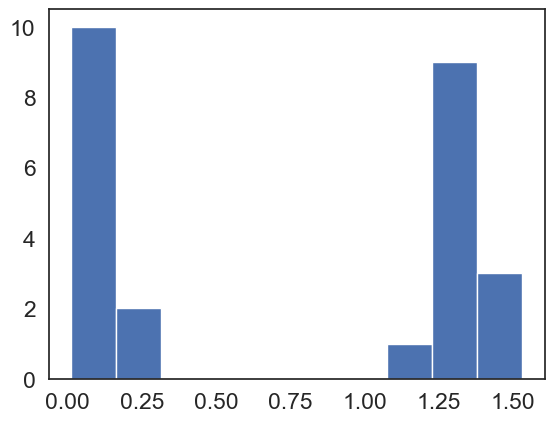

In [50]:
t = processExcelFormat04('round1_25_02.xlsx', 'FinalTimePoint', 0.5)
plt.hist(t['Density'])

In [51]:
len(t)

25

In [52]:
print(np.quantile(t['Density'], 0.5))

1.179153968253968


In [660]:
# 1, 2, 3, 4
complexSVRSpearmanLists_02, complexSVRPearsonLists_02, complexSVRR2Lists_02, complexSVRMSELists_02, \
complexPredictedSVRSpearmanLists_02, complexPredictedSVRPearsonLists_02, complexPredictedSVRR2Lists_02, \
complexPredictedSVRMSELists_02, \
r2Recorder_02, mseRecorder_02, pearsonRecorder_02, spearmanRecorder_02, \
SVRSpearmanLists_02, SVRPearsonLists_02, SVRR2Lists_02, SVRMSELists_02, \
PredictedSVRSpearmanLists_02, PredictedSVRPearsonLists_02, PredictedSVRR2Lists_02, PredictedSVRMSELists_02, \
SVRr2Recorder_02, SVRmseRecorder_02, SVRpearsonRecorder_02, SVRspearmanRecorder_02,\
indexRecorder_02, TrainXDFRecorder_02, TrainYDFRecorder_02, \
SVMSVRFullXDFRecorder_02, SVMSVRFullYDFRecorder_02, \
scXRecorder_02, scDensityRecorder_02, scDistanceRecorder_02 = \
ComparisonMultipleRun(30, 'round1_25_02.xlsx', 4, 'FinalTimePoint', [20], 0, ['poly', 'rbf'],\
                     0.5)

20
SVC(C=10000.0, degree=2, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 2, 'C': 10000.0} 1.0
R2:  0.8324580284209228
MSE:  0.38886531086553705
Pearson:  -0.9123913789711754
Spearman:  -1.0
R2:  0.8323737626609415
MSE:  0.38882505184424365
Pearson:  -0.9123451992864002
Spearman:  -1.0
R2:  0.09530580316952669
MSE:  0.38383026461479225
Pearson:  -0.30871637982058336
Spearman:  -0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.30191101076208215, 0.2322290387108029, 0.7913540557808181, 0.9746794344808964]
SVR:  [0.21453743082643734, 194.45508231695604, -0.4631818550271993, 0.0]
SVC(C=100.0) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 3, 'C': 100.0} 1.0
R2:  0.7473378214553413
MSE:  1.2919391004509808
Pearson:  -0.8644870279277425
Spearman:  -0.7999999999999999
R2:  0.9470356408856845
MSE:  0.8176484668086577
Pearson:  -0.9731575622095757
Spearman:  -1.0
R2:  0.7283345877668211
MSE:  0.8357641891936918
Pearson:  -0.8534252092402832
Spearman:  -0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.32719684278420075, 0.35423119188728025, 0.6194743792555517, -0.3]
SVR:  [0.1771219106242039, 0.7987641816828502, -0.4208585399207244, -0.19999999999999998]
SVC(C=10000.0, gamma=10.0) {'kernel': 'rbf', 'gamma': 10.0, 'degree': 3, 'C': 10000.0} 1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


R2:  nan
MSE:  1.3684884624931888
Pearson:  nan
Spearman:  nan
R2:  0.661919469656254
MSE:  0.02266013047040603
Pearson:  -0.8135843346920184
Spearman:  -1.0
R2:  0.10284672314275735
MSE:  0.01800666670753311
Pearson:  -0.32069724529960864
Spearman:  -0.19999999999999998


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.18631560287767995, 0.42910076108855916, 0.5056817770617983, 0.19999999999999998]
SVR:  [0.1252901335756801, 0.4004628502070949, -0.3539634636169108, -0.6]
SVC(C=10.0, degree=4, gamma='auto') {'kernel': 'rbf', 'gamma': 'auto', 'degree': 4, 'C': 10.0} 0.95
R2:  0.1794820993291882
MSE:  0.48695250682382296
Pearson:  0.42365327725533786
Spearman:  0.39999999999999997
R2:  0.818792864836887
MSE:  0.11460297707295042
Pearson:  0.9048717394398428
Spearman:  0.7999999999999999
R2:  0.8297771586017718
MSE:  0.10280715003660926
Pearson:  0.9109210495985762
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9617170487968532, 0.13623605624429574, 0.9781636780479745, 0.6]
SVR:  [0.9771460259587806, 0.39238261172625494, 0.9885069680881264, 0.7]
SVC(C=10.0, degree=2, gamma='auto') {'kernel': 'rbf', 'gamma': 'auto', 'degree': 2, 'C': 10.0} 0.95
R2:  0.7118247871269447
MSE:  0.2163108386496551
Pearson:  0.8436970944165592
Spearman:  0.7999999999999999
R2:  0.6491328559204799
MSE:  0.17274548497025982
Pearson:  0.8056878154226237
Spearman:  0.7378647873726218
R2:  0.6773374354995731
MSE:  0.12859201912420568
Pearson:  0.823005124831901
Spearman:  0.6000000000000001


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.25537648301417204, 0.33670928043888654, -0.15401180454593877, -0.09999999999999999]
SVR:  [0.23875441015013368, 0.4530349967203898, 0.4886250199796708, 0.0]
SVC(C=1000.0, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 3, 'C': 1000.0} 0.7
R2:  0.8340312386715265
MSE:  0.32594236254684356
Pearson:  0.913253107671431
Spearman:  0.7999999999999999
R2:  0.9713665076839108
MSE:  0.2757057013919365
Pearson:  0.9855792751899315
Spearman:  0.7999999999999999
R2:  0.947018141615813
MSE:  0.26940217206537387
Pearson:  0.9731485711934296
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8115638292140556, 0.41706506392588416, 0.9986080144262037, -0.3]
SVR:  [0.9964956133558688, 0.22094752427147019, 0.9982462688915339, 0.8999999999999998]
SVC(C=100.0, degree=2, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 2, 'C': 100.0} 0.95
R2:  0.9590303356716741
MSE:  0.13203743519180902
Pearson:  0.9793009423418697
Spearman:  0.9486832980505139
R2:  0.5379701043765029
MSE:  0.21945127024892908
Pearson:  0.7334644533830545
Spearman:  0.7999999999999999
R2:  0.9825980618756915
MSE:  0.011067563737155485
Pearson:  0.9912608445185818
Spearman:  0.6000000000000001


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4881724448593604, 0.26234061181062357, 0.6886924378133152, 0.8999999999999998]
SVR:  [0.4659698232993463, 0.2205289825773508, 0.6826198234005121, 0.39999999999999997]
SVC(C=10.0, degree=2, gamma=10.0) {'kernel': 'rbf', 'gamma': 10.0, 'degree': 2, 'C': 10.0} 0.95
R2:  0.34576660175175006
MSE:  0.28628019733682225
Pearson:  0.5880192188625727
Spearman:  0.6000000000000001
R2:  0.9424660492697521
MSE:  0.021375147706414886
Pearson:  0.9708069062742352
Spearman:  0.6000000000000001
R2:  0.9839286409197571
MSE:  0.005895347534439882
Pearson:  0.9919317723108565
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5378367964193974, 0.22162904782058296, 0.7351629783826776, 0.7999999999999999]
SVR:  [0.6916778264052297, 0.42691314600568686, 0.831671705906381, 0.6]
SVC(C=100.0, gamma=1.0, kernel='poly') {'kernel': 'poly', 'gamma': 1.0, 'degree': 3, 'C': 100.0} 0.95
R2:  0.24039631971386438
MSE:  0.3662219787649855
Pearson:  0.49030227382081804
Spearman:  0.7999999999999999
R2:  0.9548519589030839
MSE:  0.2670494365904992
Pearson:  0.9771652669344547
Spearman:  1.0
R2:  0.36900021457704363
MSE:  0.4175918112960897
Pearson:  0.6074538785595527
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9840294321798423, 0.26526291476907654, 0.9117920129672605, 0.3]
SVR:  [0.665931811077926, 0.34402202673922316, 0.816046451544228, 0.7]
SVC(C=100.0, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 3, 'C': 100.0} 1.0
R2:  0.8964548552874875
MSE:  0.04116008643987869
Pearson:  0.9468129991120144
Spearman:  0.7999999999999999
R2:  0.005333707954818799
MSE:  0.2977436227962445
Pearson:  0.07303223914696025
Spearman:  -0.39999999999999997
R2:  0.28650013641467525
MSE:  0.2600376046297615
Pearson:  0.5352570750720399
Spearman:  0.19999999999999998


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.00016751821737634294, 0.25573841573171163, 0.7147542985091123, -0.8999999999999998]
SVR:  [2.568148375815204e-06, 0.2559718235210936, -0.0016025443444145498, 0.19999999999999998]
SVC(C=1000.0, degree=5, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 5, 'C': 1000.0} 1.0
R2:  0.5619209325408941
MSE:  0.3346459378122304
Pearson:  0.7496138556222759
Spearman:  0.7999999999999999
R2:  0.6015030638845035
MSE:  0.21304147207584753
Pearson:  0.7755662859385416
Spearman:  0.7999999999999999
R2:  0.8716296808725272
MSE:  0.1491222727512481
Pearson:  0.9336110972308156
Spearman:  0.19999999999999998


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.1752020964334884, 0.4362820424589935, 0.9807185833784773, 0.6]
SVR:  [0.12541289843214504, 0.5732055139933843, 0.35413683574593735, 0.7]
SVC(C=100.0, degree=2, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 2, 'C': 100.0} 1.0
R2:  0.9607026579722704
MSE:  0.19492654316845803
Pearson:  0.9801544051690377
Spearman:  0.7999999999999999
R2:  0.8053887508229081
MSE:  0.25072958114644645
Pearson:  0.8974345384611114
Spearman:  0.7999999999999999
R2:  0.7075029299246282
MSE:  0.49931259210123613
Pearson:  0.8411319337206429
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.004046684513629531, 0.23709221950660356, 0.6022251950163692, 0.49999999999999994]
SVR:  [0.1218965676760853, 0.562767938404872, -0.3491368895950201, -0.19999999999999998]
SVC(C=100.0, degree=2, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 2, 'C': 100.0} 1.0
R2:  0.8498765931922352
MSE:  0.9824814650662603
Pearson:  0.9218875165616658
Spearman:  0.39999999999999997
R2:  0.9964923778940975
MSE:  0.9634398902616469
Pearson:  0.9982446483172841
Spearman:  0.9486832980505139
R2:  0.9154992017840754
MSE:  0.9718878678848163
Pearson:  0.9568172248575356
Spearman:  0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.21983347283672275, 0.3707072402169976, 0.9870936568609487, 0.0]
SVR:  [0.18403345126302773, 0.8643986198464516, 0.4289912018480423, 0.3]
SVC(C=1000.0, degree=4, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 4, 'C': 1000.0} 1.0
R2:  0.17903928668059022
MSE:  0.9951542049502282
Pearson:  0.4231303424248729
Spearman:  0.19999999999999998
R2:  0.5326032106792163
MSE:  1.0763525798590023
Pearson:  0.7297966913320559
Spearman:  0.39999999999999997
R2:  0.18750678230840892
MSE:  0.8025313054490397
Pearson:  0.4330205333565707
Spearman:  0.19999999999999998


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5717170492670238, 0.24702215670949074, 0.7434152396193303, 0.6]
SVR:  [0.5716382047737856, 0.23902610998296211, 0.7560675927281804, 0.6]
SVC(C=10000.0, degree=5, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 5, 'C': 10000.0} 1.0
R2:  0.7436222683339155
MSE:  0.46904858717655695
Pearson:  -0.8623353572328548
Spearman:  -1.0
R2:  0.7868546648827963
MSE:  0.4690485871902532
Pearson:  -0.8870482877965531
Spearman:  -1.0
R2:  0.7527118890131782
MSE:  0.13187108294278732
Pearson:  0.8675897008454965
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5994414579960518, 0.6993640083852941, 0.9384224606276951, 0.6]
SVR:  [0.017704882582147016, 0.30911698297343443, -0.13305969555859887, -0.09999999999999999]
SVC(degree=5, gamma=10.0) {'kernel': 'rbf', 'gamma': 10.0, 'degree': 5, 'C': 1.0} 0.9
R2:  0.4766904905961728
MSE:  0.986895306489735
Pearson:  0.6904277591436867
Spearman:  0.7999999999999999
R2:  0.1763621924231938
MSE:  0.9868953177255988
Pearson:  0.4199549885680533
Spearman:  0.7999999999999999
R2:  0.6094584611619217
MSE:  0.29113318878620104
Pearson:  0.7806782058965919
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted wit

SVM:  [0.9464161343882497, 0.23156300908314398, 0.9788018846139193, 0.7999999999999999]
SVR:  [0.28796850728588785, 0.6960597309919795, 0.5129331315053508, 0.8999999999999998]
SVC(C=100.0, degree=4, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 4, 'C': 100.0} 1.0
R2:  0.026463293118440524
MSE:  0.3855263058297267
Pearson:  -0.1626754226010817
Spearman:  0.0
R2:  0.024575334676359122
MSE:  0.3869312143422943
Pearson:  -0.15676522151408165
Spearman:  0.0
R2:  0.6900683343720159
MSE:  0.3097716923743377
Pearson:  0.8307035177318174
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6112789119887252, 0.2683220581790964, 0.6625417432243194, 0.8999999999999998]
SVR:  [0.5552383196197475, 0.8967523554171336, 0.7451431537763381, 0.7999999999999999]
SVC(C=10000.0, degree=2, gamma=10.0) {'kernel': 'rbf', 'gamma': 10.0, 'degree': 2, 'C': 10000.0} 1.0
R2:  0.9631503889758212
MSE:  1.0000750310435396
Pearson:  0.981402256455436
Spearman:  0.9486832980505139
R2:  0.2985240259155991
MSE:  0.9840314843648592
Pearson:  0.5463735223412636
Spearman:  0.39999999999999997
R2:  0.9279791164213401
MSE:  0.9833629832447787
Pearson:  0.9633167269498335
Spearman:  0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.22638480170337283, 0.34172746528520764, 0.4379502527349512, 0.09999999999999999]
SVR:  [0.0002189931564156911, 0.645701466933276, 0.014798417361856317, -0.19999999999999998]
SVC(C=10.0, degree=2, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 2, 'C': 10.0} 0.9
R2:  0.9833553660844241
MSE:  0.11593822507700358
Pearson:  0.9916427613230604
Spearman:  0.7999999999999999
R2:  0.9587427739876876
MSE:  0.11026596369973124
Pearson:  0.9791541114593183
Spearman:  0.7999999999999999
R2:  0.9962366181377826
MSE:  0.025089949731244822
Pearson:  0.9981165353493461
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9594656058617251, 0.015718366215418916, 0.9792033536854227, 0.49999999999999994]
SVR:  [0.5617399006189977, 0.26894230655931645, 0.7494930957780717, 0.49999999999999994]
SVC(C=10000.0, degree=5, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 5, 'C': 10000.0} 0.9
R2:  0.032907593510234326
MSE:  0.718246498581632
Pearson:  0.1814045024530381
Spearman:  0.39999999999999997
R2:  0.03858643940530708
MSE:  0.7184223319041814
Pearson:  0.1964343132075124
Spearman:  0.39999999999999997
R2:  0.7902396299639072
MSE:  0.7111616172956745
Pearson:  0.8889542338972841
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5644710625735371, 0.11943284624709558, 0.7229607798610492, 0.3]
SVR:  [0.3140365217551122, 0.8013936882487759, 0.5603896160307686, 0.49999999999999994]
SVC(C=10000.0, gamma=0.1, kernel='poly') {'kernel': 'poly', 'gamma': 0.1, 'degree': 3, 'C': 10000.0} 0.9
R2:  0.015390848185764161
MSE:  0.4234944986771176
Pearson:  0.12405985726964283
Spearman:  0.39999999999999997
R2:  0.26991825717065293
MSE:  0.3684027969392347
Pearson:  0.5195365792421675
Spearman:  0.39999999999999997
R2:  0.3704881503299868
MSE:  0.2987412380052483
Pearson:  0.6086773778694151
Spearman:  0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9495944860199461, 0.4546211958053565, 0.9518380282550603, 0.7999999999999999]
SVR:  [0.28860903908031393, 0.4869227252994347, 0.5372234535836219, 0.7999999999999999]
SVC(C=10000.0, degree=2, gamma=10.0) {'kernel': 'rbf', 'gamma': 10.0, 'degree': 2, 'C': 10000.0} 0.95
R2:  0.8998974667948382
MSE:  0.04719052419306837
Pearson:  0.9486292567672778
Spearman:  0.39999999999999997
R2:  0.9593634552996356
MSE:  0.015019009483859471
Pearson:  0.9794710078913184
Spearman:  0.19999999999999998
R2:  0.6742954110892877
MSE:  0.10337365181701672
Pearson:  0.8211549251446327
Spearman:  0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4089570483203052, 0.1917949443535986, 0.7234485554832065, 0.41039134083406165]
SVR:  [0.21977987499250926, 0.426726080210862, 0.4688068632096903, 0.39999999999999997]
SVC(C=10000.0, kernel='poly') {'kernel': 'poly', 'gamma': 'scale', 'degree': 3, 'C': 10000.0} 0.9
R2:  0.7160271396713763
MSE:  0.30293341536629875
Pearson:  0.8461838687137543
Spearman:  0.7999999999999999
R2:  0.1982883233100366
MSE:  37.7634233076823
Pearson:  0.4452957705952715
Spearman:  0.7745966692414834
R2:  0.700244788916333
MSE:  0.3072106333278419
Pearson:  0.8368063031050454
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.005391687661598364, 0.08346042119458189, -0.09002243871400151, 0.7999999999999999]
SVR:  [0.7189829139280388, 0.6606534896128593, 0.8479286019046881, 0.8999999999999998]
SVC(C=10000.0, degree=5, kernel='poly') {'kernel': 'poly', 'gamma': 'scale', 'degree': 5, 'C': 10000.0} 0.9
R2:  0.22984146969381308
MSE:  0.2883549111324594
Pearson:  0.47941784457174014
Spearman:  0.632455532033676
R2:  0.45539248652063274
MSE:  0.6747870202809393
Pearson:  0.6748277458141693
Spearman:  0.6000000000000001
R2:  0.22982630888616742
MSE:  0.36076782925821527
Pearson:  0.47940203262623693
Spearman:  0.2581988897471611


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9564939095249649, 0.03348007795377977, 0.9790990912103554, 0.7]
SVR:  [0.9280039883227651, 0.36571836551924836, 0.9633296363772709, 0.6]
SVC(C=1000.0, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 3, 'C': 1000.0} 1.0
R2:  0.001105971131322906
MSE:  0.5015251339981545
Pearson:  0.03325614426422441
Spearman:  -0.39999999999999997
R2:  0.35067262788431297
MSE:  0.4395583207040884
Pearson:  0.5921761797677386
Spearman:  0.6000000000000001
R2:  0.41410730668003815
MSE:  0.42788041039353564
Pearson:  0.6435116989457443
Spearman:  0.6000000000000001


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9243444181086431, 0.32636811020084305, 0.17526772032730864, 0.7]
SVR:  [0.41202737393771144, 0.2755094840138078, 0.6418935845899314, 0.46169025843831935]
SVC(C=10000.0, degree=4, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 4, 'C': 10000.0} 1.0
R2:  0.5850555955549472
MSE:  0.4114502367071313
Pearson:  0.7648892701266944
Spearman:  0.39999999999999997
R2:  0.3404117199421883
MSE:  0.2571964743293942
Pearson:  0.5834481296072414
Spearman:  0.19999999999999998
R2:  0.9808088233647418
MSE:  0.2656929236276235
Pearson:  0.9903579268954945
Spearman:  0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.3972953920570141, 0.5709832561371674, 0.9492637727175713, 0.49999999999999994]
SVR:  [0.1649645750431739, 0.21189407959350343, 0.40615831278354236, 0.3]
SVC(C=10000.0, degree=5, gamma=0.1, kernel='poly') {'kernel': 'poly', 'gamma': 0.1, 'degree': 5, 'C': 10000.0} 0.6
R2:  0.7156719554141128
MSE:  0.5602172674067429
Pearson:  -0.8459739685203751
Spearman:  -0.7999999999999999
R2:  0.9930544621492119
MSE:  0.5284991225005574
Pearson:  0.9965211799802411
Spearman:  0.7999999999999999
R2:  0.9956848723443589
MSE:  0.4696571992076281
Pearson:  0.9978401035959412
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9215518650690386, 0.33782572097386687, 0.9729190036729563, 0.19999999999999998]
SVR:  [0.345758038673355, 0.24861086636031823, -0.5880119375262334, -0.7999999999999999]
SVC(C=10000.0) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 3, 'C': 10000.0} 0.9
R2:  0.6003174645993259
MSE:  0.2297821757792844
Pearson:  0.7748015646598332
Spearman:  0.39999999999999997
R2:  0.1839221891964728
MSE:  0.28734135785729015
Pearson:  0.4288615035142146
Spearman:  0.39999999999999997
R2:  0.913433051323246
MSE:  0.04655733634857234
Pearson:  0.955736915329342
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9632617541822827, 0.025613352634366877, 0.9836958524627053, 0.7]
SVR:  [0.4315261246928721, 0.2868915667688271, 0.656906480933833, 0.6]
SVC(C=100.0, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 3, 'C': 100.0} 0.95
R2:  0.9092405553599994
MSE:  0.05687314902138038
Pearson:  0.9535410611819501
Spearman:  0.7999999999999999
R2:  0.1263618444344251
MSE:  0.34901431040497943
Pearson:  0.3554741121860001
Spearman:  -0.19999999999999998
R2:  0.3203657688228019
MSE:  0.2521334822772215
Pearson:  0.5660086296363351
Spearman:  0.6000000000000001


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9071397788427298, 0.10716644997813177, 0.9765883071684573, 0.09999999999999999]
SVR:  [0.3541221819415582, 0.4021218850479869, -0.5950816598934623, -0.39999999999999997]
SVC(C=1000.0, degree=5, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 5, 'C': 1000.0} 0.9
R2:  0.03439266099808243
MSE:  1.1424421430091438
Pearson:  -0.18545258423134045
Spearman:  -0.7999999999999999
R2:  0.3811209153700867
MSE:  0.32710779924177075
Pearson:  0.6173499132340481
Spearman:  0.7999999999999999
R2:  0.8086788480981094
MSE:  0.11314005186569971
Pearson:  0.8992657271897497
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


SVM:  [0.9640620451667684, 0.14598838040630785, 0.9845026987050983, 0.8999999999999998]
SVR:  [0.5022928276068644, 0.20483279040520025, 0.7087262007340104, 0.7999999999999999]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


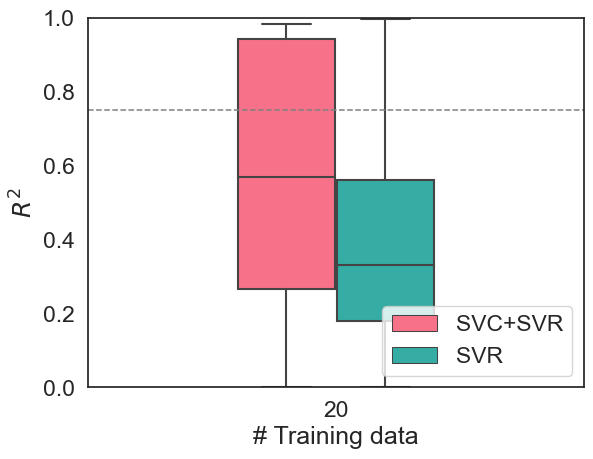

In [661]:
round1_02_DF = ComparisonResultsPlot([complexSVRR2Lists_02, SVRR2Lists_02], position = 'lower right', \
                              xname = '# Training data', yname = '$R^2$', show = 1, \
                              ylimit = [0, 1], yline = 0.75)

In [662]:
round1_02_DF

,# Training data,Results,Method
0,20,0.301911,SVC+SVR
1,20,0.327197,SVC+SVR
2,20,0.186316,SVC+SVR
3,20,0.961717,SVC+SVR
4,20,0.255376,SVC+SVR
5,20,0.811564,SVC+SVR
6,20,0.488172,SVC+SVR
7,20,0.537837,SVC+SVR
8,20,0.984029,SVC+SVR
9,20,0.000168,SVC+SVR


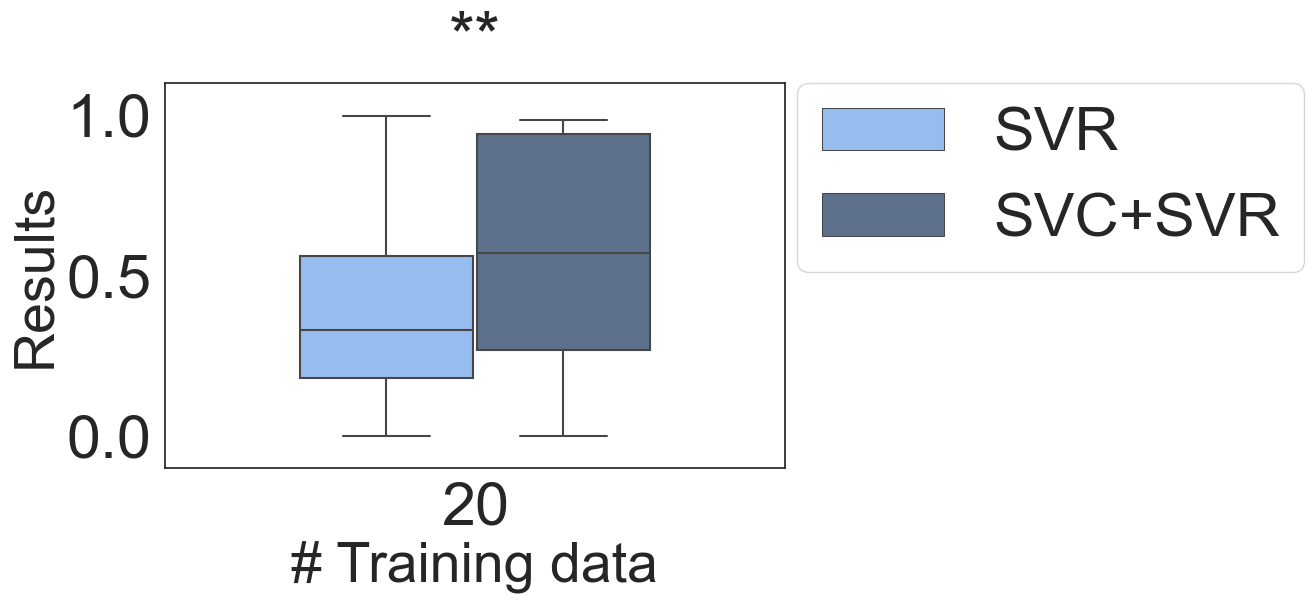

In [663]:
statsPlot(round1_02_DF)

['Results']


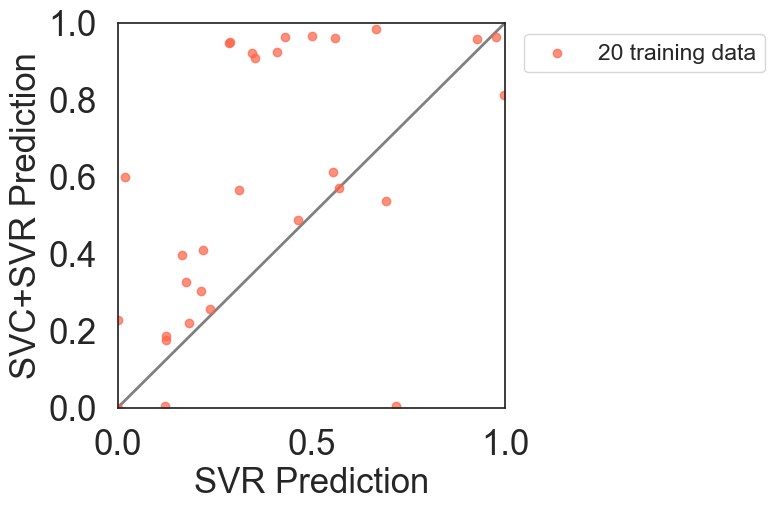

In [664]:
scatterComparisonPlot(round1_02_DF)

In [ ]:
# storeCorrelations([complexSVRSpearmanLists_02, complexSVRPearsonLists_02,\
#                    complexSVRR2Lists_02, complexSVRMSELists_02], 'F4_round1_SVCSVR_Corr.xlsx')
# storeRawData([complexPredictedSVRSpearmanLists_02, complexPredictedSVRPearsonLists_02,\
#              complexPredictedSVRR2Lists_02, complexPredictedSVRMSELists_02], 'F4_round1_SVCSVR_Raw.xlsx')
# storeWeight([r2Recorder_02, mseRecorder_02, pearsonRecorder_02, spearmanRecorder_02],
#             'F5_round1_SVCSVR_Weight02.xlsx')
# storeSVCSVRModel([r2Recorder_02, mseRecorder_02, pearsonRecorder_02, spearmanRecorder_02], 'F4_round1')

# storeCorrelations([SVRSpearmanLists_02, SVRPearsonLists_02,\
#                    SVRR2Lists_02, SVRMSELists_02], 'F4_round1_SVR_Corr.xlsx')
# storeRawData([PredictedSVRSpearmanLists_02, PredictedSVRPearsonLists_02,\
#              PredictedSVRR2Lists_02, PredictedSVRMSELists_02], 'F4_round1_SVR_Raw02.xlsx')
# storeSVRModel([SVRr2Recorder_02, SVRmseRecorder_02, SVRpearsonRecorder_02, SVRspearmanRecorder_02], \
#              'F4_round1')

# storeScalerModel([scXRecorder_02, scDensityRecorder_02, scDistanceRecorder_02], 'F4_round1')
# storeIndex(indexRecorder_02, 'F4_round1_TrainingIndices02.xlsx')

# storeDataframes([TrainXDFRecorder_02, TrainYDFRecorder_02, \
# SVMSVRFullXDFRecorder_02, SVMSVRFullYDFRecorder_02], 'F4_round1')

# Active Learning starts here

In [665]:
import random

In [632]:
round1Use = 'round1_25_02.xlsx'
round1UseDF = round1_02_DF
n=20 #20

In [671]:
round1Use = 'round1_25_02.xlsx'
round1UseDF = round1_02_DF
n=20 #20

# Dataframe for the first round of training
ori = processExcelFormat04(round1Use, 'FinalTimePoint', 0.5)
oriFull = processExcelFormat03('round3.xlsx', 'FinalTimePoint', 0.6)

# Get the rows of the previous training data
round1_SVCSVR = round1UseDF[round1UseDF['Method'] == 'SVC+SVR']
round1_SVCSVR = round1_SVCSVR[round1_SVCSVR['# Training data'] == n]
round1_SVCSVR = round1_SVCSVR.reset_index(drop=True)

round1_SVR = round1UseDF[round1UseDF['Method'] == 'SVR']
round1_SVR = round1_SVR[round1_SVR['# Training data'] == n]
round1_SVR = round1_SVR.reset_index(drop=True)

# Get the top 3 best performances 
        # & bottom 3 worst performances
comparisonList = round1_SVCSVR['Results'] - round1_SVR['Results']
numToCompare = 10
numToCompare = len(comparisonList)
topIndexList = \
sorted(range(len(comparisonList)), key=lambda i: comparisonList[i], reverse=True)[:numToCompare]
bottomIndexList = \
sorted(range(len(comparisonList)), key=lambda i: comparisonList[i], reverse=True)[-numToCompare:][::-1]

# Visualize each of the top 3 training datasets
# Can't visualize for 3D input
rank = 1
for t in topIndexList:
    print('Top ', rank, ' performance: ')
    print('index is: ', t, '& results are: ', round1_SVCSVR['Results'][t], round1_SVR['Results'][t])
    trainDF = TrainXDFRecorder_02[n][t]
    print(trainDF.index)
    print(oriFull.index)
    trainDFIndex = trainDF.index 
    fullDF = oriFull[oriFull.index.isin(trainDFIndex)]
    trainDF['Density'] = fullDF['Density']
    # Get the SVM machines for our algorithm
    topSVMModel = r2Recorder_02[n][t][0]
    rank = rank + 1

# Bottom
rank = 1
for b in bottomIndexList:
    print('Bottom ', rank, ' performance: ')
    print('index is: ', b, '& results are: ', round1_SVCSVR['Results'][b], round1_SVR['Results'][b])
    trainDF = TrainXDFRecorder_02[n][b]
    print(trainDF.index)
    print(oriFull.index)
    trainDFIndex = trainDF.index 
    fullDF = oriFull[oriFull.index.isin(trainDFIndex)]
    trainDF['Density'] = fullDF['Density']
    # Get the SVM machines for our algorithm
    topSVMModel = r2Recorder_02[n][b][0]
    rank = rank + 1

Top  1  performance: 
index is:  7 & results are:  0.9685018926071486 0.0016134269412019315
Int64Index([30, 42, 59, 40, 1, 43, 41, 10, 13, 4, 24, 34, 31, 49, 16, 6, 58,
            63, 2, 20],
           dtype='int64')
RangeIndex(start=0, stop=64, step=1)
Top  2  performance: 
index is:  9 & results are:  0.9585985991525192 0.005574675254147963
Int64Index([59, 31, 13, 60, 6, 1, 20, 16, 32, 40, 63, 58, 30, 41, 24, 34, 4,
            10, 43, 42],
           dtype='int64')
RangeIndex(start=0, stop=64, step=1)
Top  3  performance: 
index is:  21 & results are:  0.9549853341828904 0.06893794940041253
Int64Index([56, 16, 60, 32, 24, 57, 26, 58, 13, 34, 1, 31, 2, 30, 43, 4, 59,
            40, 41, 42],
           dtype='int64')
RangeIndex(start=0, stop=64, step=1)
Top  4  performance: 
index is:  8 & results are:  0.8471076873327501 0.03665554417269826
Int64Index([56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49,
            10, 58, 42],
           dtype='int64')
RangeIndex(sta

In [667]:
import random

(array([24.,  5.,  1.,  3.,  1.,  1.,  2.,  3., 20.,  4.]),
 array([0.00909167, 0.16139167, 0.31369167, 0.46599167, 0.61829167,
        0.77059167, 0.92289167, 1.07519167, 1.22749167, 1.37979167,
        1.53209167]),
 <BarContainer object of 10 artists>)

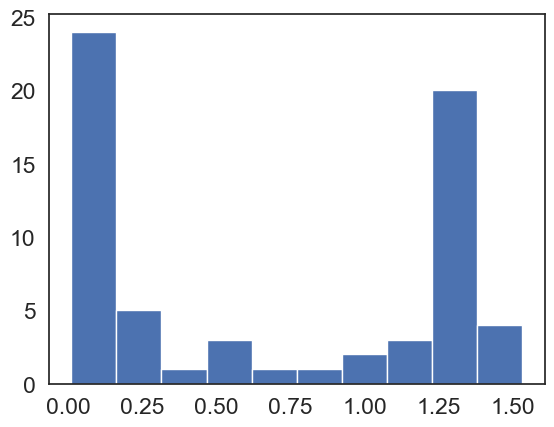

In [668]:
tDF = processExcelFormat03('round3.xlsx', 'FinalTimePoint', 0.6)
plt.hist(tDF['Density'])

In [670]:
print(np.quantile(tDF['Density'], 0.6))

1.197332


30 [20, 15, 14, 26, 28, 27, 24, 29, 18, 8, 19, 25, 17, 21, 1, 0, 2, 16, 10, 12, 23, 6, 4, 9, 13, 3, 11, 7, 5, 22]
30 [22, 5, 7, 11, 3, 13, 9, 4, 6, 23, 12, 10, 16, 2, 0, 1, 21, 17, 25, 19, 8, 18, 29, 24, 27, 28, 26, 14, 15, 20]
20 0.6609854469396321
20
40
[19, 46, 62, 27, 9, 8, 3, 54, 29, 12, 33, 18, 35, 23, 25, 63, 55, 36, 61, 7, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


SVC(C=10000.0, degree=2, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 2, 'C': 10000.0} 0.975
R2:  0.8161777612543903
MSE:  0.2003635461449814
Pearson:  0.9034255704010101
Spearman:  0.9285714285714287
R2:  0.29385166528788936
MSE:  0.22305608825256135
Pearson:  0.542080866004224
Spearman:  0.5389318178609664
R2:  0.7424439637065126
MSE:  0.1972614311247832
Pearson:  0.8616518808118001
Spearman:  0.9285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7524122702414573, 0.28171550520518224, 0.7340509861597649, 0.6652173913043479]
SVR:  [0.3448553461497801, 0.30775271920852987, 0.5872438557786535, 0.6452173913043477]
40
[19, 46, 62, 27, 9, 8, 3, 54, 29, 12, 33, 18, 35, 23, 25, 63, 55, 36, 61, 7, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(C=10000.0, gamma='auto', kernel='poly') {'kernel': 'poly', 'gamma': 'auto', 'degree': 3, 'C': 10000.0} 0.925
R2:  0.607670932214651
MSE:  0.2337877506380876
Pearson:  0.7795325087606357
Spearman:  0.9761904761904763
R2:  0.5468903635361825
MSE:  0.19129227711257596
Pearson:  0.7395203604608749
Spearman:  0.7380952380952381
R2:  0.8248273778969113
MSE:  0.07937391601213326
Pearson:  0.9082000759176969
Spearman:  0.7857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5328246627041523, 0.34019581236179747, 0.7144951809331486, 0.6365217391304347]
SVR:  [0.3657942852552078, 0.25069384580819537, 0.6048092966011748, 0.5756521739130435]
40
[19, 46, 62, 27, 9, 8, 3, 54, 29, 12, 33, 18, 35, 23, 25, 63, 55, 36, 61, 7, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(C=1000.0, degree=2) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 2, 'C': 1000.0} 0.95
R2:  0.2602685686441995
MSE:  0.5506716377126804
Pearson:  0.5101652366088849
Spearman:  0.6904761904761906
R2:  0.2510011950552059
MSE:  0.5780014618191
Pearson:  0.5010001946658362
Spearman:  0.8571428571428572
R2:  0.9550039237901522
MSE:  0.01994296358005522
Pearson:  0.9772430218682309
Spearman:  0.8571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6510786419575817, 0.16974298010850053, 0.8289775125788447, 0.6886956521739129]
SVR:  [0.3483276072473052, 0.3078464565697373, 0.590192855977862, 0.6452173913043477]
40
[19, 46, 62, 27, 9, 8, 3, 54, 29, 12, 33, 18, 35, 23, 25, 63, 55, 36, 61, 7, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(C=10.0, degree=5, gamma='auto', kernel='poly') {'kernel': 'poly', 'gamma': 'auto', 'degree': 5, 'C': 10.0} 0.75
R2:  0.39362019457702363
MSE:  0.43450433337562033
Pearson:  0.627391579937939
Spearman:  0.4047619047619048
R2:  0.6052339830272483
MSE:  0.31715394439347916
Pearson:  0.7779678547518839
Spearman:  0.8333333333333335
R2:  0.5682984962040376
MSE:  0.15250154606390282
Pearson:  0.7538557529156606
Spearman:  0.6904761904761906


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6528152910895259, 0.15392378847512586, 0.8695158287859649, 0.6808695652173912]
SVR:  [0.5631499750309127, 0.2072530532048977, 0.7504331915839764, 0.7264321421830621]
40
[19, 46, 62, 27, 9, 8, 3, 54, 29, 12, 33, 18, 35, 23, 25, 63, 55, 36, 61, 7, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(C=1000.0, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 3, 'C': 1000.0} 0.975
R2:  0.3897589080179867
MSE:  0.3144029157845674
Pearson:  0.6243067419289869
Spearman:  0.6904761904761906
R2:  0.4106435369490401
MSE:  0.2711030182298373
Pearson:  0.6408147446407895
Spearman:  0.6904761904761906
R2:  0.4424160402414534
MSE:  0.2574917240493098
Pearson:  0.665143623769674
Spearman:  0.5714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6831982188246917, 0.13419985962324085, 0.7631497047859288, 0.2791304347826086]
SVR:  [0.7113931744638494, 0.10330446152360255, 0.8434412691253906, 0.6947826086956521]
20
40
[7, 18, 61, 38, 46, 22, 62, 52, 14, 19, 59, 36, 29, 27, 37, 39, 40, 54, 50, 63, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(C=1000.0, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 3, 'C': 1000.0} 0.825
R2:  0.11573484490148318
MSE:  1.2461429470666565
Pearson:  0.34019824353086137
Spearman:  0.5714285714285715
R2:  0.5931833075609028
MSE:  0.3700960523403096
Pearson:  0.7701839439776076
Spearman:  0.6904761904761906
R2:  0.5668631131824996
MSE:  0.1857815758567895
Pearson:  0.7529031233714597
Spearman:  0.8095238095238096


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6124056621154363, 0.3277907311938358, 0.7570162812334715, 0.7730434782608695]
SVR:  [0.34017222798268404, 0.3101282562473047, 0.5832428550635529, 0.6747826086956521]
40
[7, 18, 61, 38, 46, 22, 62, 52, 14, 19, 59, 36, 29, 27, 37, 39, 40, 54, 50, 63, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(gamma=10.0) {'kernel': 'rbf', 'gamma': 10.0, 'degree': 3, 'C': 1.0} 0.825
R2:  0.5648135444742428
MSE:  0.18176505346215915
Pearson:  0.7515407803135122
Spearman:  0.38095238095238104
R2:  0.6618611643950776
MSE:  0.11894342935622784
Pearson:  0.8135485015628005
Spearman:  0.38095238095238104
R2:  0.7790250382419218
MSE:  0.07580121780049903
Pearson:  0.8826239506391848
Spearman:  0.9285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.45754669228542805, 0.18751424547832907, 0.7147924432914876, 0.7269565217391305]
SVR:  [0.439432614744759, 0.24705085770907495, 0.6628971373786126, 0.7852173913043478]
40
[7, 18, 61, 38, 46, 22, 62, 52, 14, 19, 59, 36, 29, 27, 37, 39, 40, 54, 50, 63, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(C=10000.0, degree=2, gamma=0.0001) {'kernel': 'rbf', 'gamma': 0.0001, 'degree': 2, 'C': 10000.0} 0.85
R2:  0.964451660455196
MSE:  0.04312199751100817
Pearson:  0.9820649980806746
Spearman:  0.523809523809524
R2:  0.9701308592554411
MSE:  0.03527031709133759
Pearson:  0.9849522116607695
Spearman:  0.5952380952380953
R2:  0.7293652014540238
MSE:  0.2934555453769864
Pearson:  0.8540288059860883
Spearman:  0.5952380952380953


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5774892122263985, 0.287865753103335, 0.6443298654191636, 0.8382608695652173]
SVR:  [0.6008301758362706, 0.1487060925154435, 0.7751323602045466, 0.7104347826086955]
40
[7, 18, 61, 38, 46, 22, 62, 52, 14, 19, 59, 36, 29, 27, 37, 39, 40, 54, 50, 63, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(C=10000.0, degree=5, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 5, 'C': 10000.0} 0.85
R2:  0.9118472762740327
MSE:  0.039814052444876735
Pearson:  0.954906946395319
Spearman:  0.7619047619047621
R2:  0.5765036173432357
MSE:  0.2056909194801786
Pearson:  0.7592783530058234
Spearman:  0.8571428571428572
R2:  0.41814935929632907
MSE:  0.17695334805596374
Pearson:  0.6466446932406771
Spearman:  0.19047619047619052


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4621859358574216, 0.24592411928120084, 0.6813410057567579, 0.8713043478260868]
SVR:  [0.4676388079217994, 0.24166279263222892, 0.6838412154307455, 0.8886956521739129]
40
[7, 18, 61, 38, 46, 22, 62, 52, 14, 19, 59, 36, 29, 27, 37, 39, 40, 54, 50, 63, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(C=100.0, degree=2) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 2, 'C': 100.0} 0.8
R2:  0.9532885697357046
MSE:  0.015255889753878442
Pearson:  0.9763649777289763
Spearman:  0.7380952380952381
R2:  0.9393036410175212
MSE:  0.021522835630170184
Pearson:  0.969176785224203
Spearman:  0.8095238095238096
R2:  0.8052893557186273
MSE:  0.09345851161130808
Pearson:  0.8973791593961983
Spearman:  0.7619047619047621


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.48062630493465974, 0.20134002374495782, 0.6932662848432322, 0.7330434782608695]
SVR:  [0.43475979989228297, 0.2082611410975813, 0.6593631775374502, 0.6939130434782607]
20
40
[28, 18, 55, 45, 12, 42, 25, 61, 37, 29, 11, 44, 3, 46, 38, 7, 15, 54, 47, 8, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(C=1000.0) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 3, 'C': 1000.0} 0.875
R2:  0.37243317051394015
MSE:  0.33857233490232364
Pearson:  0.6102730294826572
Spearman:  0.8333333333333335
R2:  0.9305213886142405
MSE:  0.04332705176692865
Pearson:  0.9646353656248771
Spearman:  0.8333333333333335
R2:  0.5324015089140163
MSE:  0.2538367942155991
Pearson:  0.729658487865396
Spearman:  0.7380952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.3820855671623448, 0.14184513430922574, 0.6981897681656521, 0.6278260869565216]
SVR:  [0.7055261583238025, 0.09224106391660751, 0.8399560454713106, 0.6695652173913044]
40
[28, 18, 55, 45, 12, 42, 25, 61, 37, 29, 11, 44, 3, 46, 38, 7, 15, 54, 47, 8, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(C=100.0, degree=4, gamma='auto', kernel='poly') {'kernel': 'poly', 'gamma': 'auto', 'degree': 4, 'C': 100.0} 0.85
R2:  0.9680389351471144
MSE:  0.012354805427036887
Pearson:  0.9838896966363222
Spearman:  0.8095238095238096
R2:  0.6489226695290976
MSE:  0.3398628608989157
Pearson:  0.8055573657593216
Spearman:  0.8571428571428572
R2:  0.7500948573579596
MSE:  0.3390642925634718
Pearson:  0.8660801679740504
Spearman:  0.8571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.423206779791263, 0.15495172558014422, 0.8284566875380367, 0.5904347826086956]
SVR:  [0.4795414537110892, 0.1551624716689505, 0.6924893166765025, 0.5547826086956522]
40
[28, 18, 55, 45, 12, 42, 25, 61, 37, 29, 11, 44, 3, 46, 38, 7, 15, 54, 47, 8, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(C=0.01, gamma=10.0, kernel='poly') {'kernel': 'poly', 'gamma': 10.0, 'degree': 3, 'C': 0.01} 0.875
R2:  0.7861073231671133
MSE:  0.14879771495636826
Pearson:  0.8866269357329006
Spearman:  0.9285714285714287
R2:  0.10899260154260378
MSE:  0.38611986334233706
Pearson:  0.33014027555359515
Spearman:  0.11904761904761905
R2:  0.3981615256263277
MSE:  0.3120482550621182
Pearson:  0.6310004165024993
Spearman:  0.4285714285714286


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.48774911357238, 0.09561868427354414, 0.5592409559897322, 0.7747826086956522]
SVR:  [0.23426111291529653, 0.31691990191430486, 0.48400528190846903, 0.4460869565217391]
40
[28, 18, 55, 45, 12, 42, 25, 61, 37, 29, 11, 44, 3, 46, 38, 7, 15, 54, 47, 8, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(C=1000.0) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 3, 'C': 1000.0} 0.875
R2:  0.22915172184109048
MSE:  0.33814657892703437
Pearson:  0.4786979442624446
Spearman:  0.6904761904761906
R2:  0.07263847042315578
MSE:  0.43430959745312636
Pearson:  0.26951525081738104
Spearman:  0.1666666666666667
R2:  0.885539002346181
MSE:  0.05426680428894454
Pearson:  0.9410308190203875
Spearman:  0.8571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6547209235379057, 0.14280995114251316, 0.808108060123756, 0.5939130434782608]
SVR:  [0.3650115365909355, 0.2391689701660885, 0.6041618463548781, 0.6608695652173912]
40
[28, 18, 55, 45, 12, 42, 25, 61, 37, 29, 11, 44, 3, 46, 38, 7, 15, 54, 47, 8, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(C=10000.0, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 3, 'C': 10000.0} 0.95
R2:  0.6150867340023439
MSE:  0.39092400182632053
Pearson:  0.7842746546984315
Spearman:  0.7142857142857144
R2:  0.45212209226643013
MSE:  0.20222119600454702
Pearson:  0.6724002470749322
Spearman:  0.3333333333333334
R2:  0.7463937108168315
MSE:  0.42058439758055977
Pearson:  0.8639408028428981
Spearman:  0.7857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4310973851298582, 0.0844467411191846, 0.8494737636641966, 0.6252173913043478]
SVR:  [0.3463607658755159, 0.2318195474212257, 0.5885242270930875, 0.5173913043478261]
15 0.6584476271023618
20
40
[13, 47, 12, 26, 39, 5, 52, 45, 4, 17, 38, 37, 33, 41, 18, 21, 3, 19, 50, 44, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(C=10000.0, gamma='auto') {'kernel': 'rbf', 'gamma': 'auto', 'degree': 3, 'C': 10000.0} 0.75
R2:  0.6265569395839836
MSE:  0.26562965184436205
Pearson:  0.7915534976133853
Spearman:  0.7619047619047621
R2:  0.9332066521538999
MSE:  0.09714181677113376
Pearson:  0.9660262171151981
Spearman:  0.8333333333333335
R2:  0.9871155304971757
MSE:  0.01982743899557926
Pearson:  0.9935368792838923
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.45531085619541417, 0.18644614599754297, 0.6848895912847106, 0.7278260869565217]
SVR:  [0.46026941685310874, 0.1918692623893071, 0.678431585978357, 0.6156521739130434]
40
[13, 47, 12, 26, 39, 5, 52, 45, 4, 17, 38, 37, 33, 41, 18, 21, 3, 19, 50, 44, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(C=10.0, degree=4, gamma=10.0) {'kernel': 'rbf', 'gamma': 10.0, 'degree': 4, 'C': 10.0} 0.825
R2:  0.42548488118773803
MSE:  0.2913638121056268
Pearson:  0.6522920214043231
Spearman:  0.7142857142857144
R2:  0.8021385544515373
MSE:  0.10490981890785081
Pearson:  0.8956218814050588
Spearman:  0.7619047619047621
R2:  0.9388473102222454
MSE:  0.032773457772366364
Pearson:  0.96894133476813
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4506582103889089, 0.2015574777926492, 0.6389500686434872, 0.6834782608695652]
SVR:  [0.42534867849931585, 0.27146136758793943, 0.6521876098940519, 0.8408695652173912]
40
[13, 47, 12, 26, 39, 5, 52, 45, 4, 17, 38, 37, 33, 41, 18, 21, 3, 19, 50, 44, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(C=1000.0, kernel='poly') {'kernel': 'poly', 'gamma': 'scale', 'degree': 3, 'C': 1000.0} 0.775
R2:  0.8254279042330774
MSE:  0.05659524060345365
Pearson:  0.9085306292212045
Spearman:  0.7857142857142858
R2:  0.6744654769885547
MSE:  0.19182715549949003
Pearson:  0.821258471486629
Spearman:  0.07142857142857144
R2:  0.6392947275024881
MSE:  0.20938334232505276
Pearson:  0.7995590831842809
Spearman:  -0.023809523809523815


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4207915790124093, 0.13686572924919696, 0.643077904939525, 0.8234782608695651]
SVR:  [0.4101650941349179, 0.2579111675277384, 0.640441327628783, 0.8243478260869566]
40
[13, 47, 12, 26, 39, 5, 52, 45, 4, 17, 38, 37, 33, 41, 18, 21, 3, 19, 50, 44, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(gamma=1.0, kernel='poly') {'kernel': 'poly', 'gamma': 1.0, 'degree': 3, 'C': 1.0} 0.825
R2:  0.9083131906706763
MSE:  0.06966338732173405
Pearson:  0.9530546630024304
Spearman:  0.9285714285714287
R2:  0.9745083890496486
MSE:  0.019821974309704584
Pearson:  0.987171914637794
Spearman:  0.5952380952380953
R2:  0.9874263440191621
MSE:  0.0042933270378725935
Pearson:  0.9936932846805206
Spearman:  0.5476190476190477


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.22673710139942727, 0.13253255494348817, 0.784631948090629, 0.8617391304347826]
SVR:  [0.4027371190258446, 0.18694254311675795, 0.6346157254794784, 0.7434782608695651]
40
[13, 47, 12, 26, 39, 5, 52, 45, 4, 17, 38, 37, 33, 41, 18, 21, 3, 19, 50, 44, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(C=100.0, gamma=10.0) {'kernel': 'rbf', 'gamma': 10.0, 'degree': 3, 'C': 100.0} 0.825
R2:  0.961480704742614
MSE:  0.02170070247811665
Pearson:  0.9805512249457513
Spearman:  0.7619047619047621
R2:  0.9537821395265463
MSE:  0.023994540427192467
Pearson:  0.9766177038772879
Spearman:  0.7619047619047621
R2:  0.9538232648893453
MSE:  0.023650212959668532
Pearson:  0.9766387586458696
Spearman:  0.7619047619047621


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6837421870682611, 0.2654997513178683, 0.8436920381592272, 0.6921739130434782]
SVR:  [0.4087152005397319, 0.29819023121779104, 0.6393083767163792, 0.7399999999999999]
20
40
[0, 48, 45, 23, 47, 44, 21, 17, 33, 11, 57, 52, 4, 7, 41, 36, 38, 37, 5, 25, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(C=1000.0, degree=4, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 4, 'C': 1000.0} 0.925
R2:  0.5367904585049259
MSE:  0.1413971812985192
Pearson:  0.7326598518445829
Spearman:  0.2142857142857143
R2:  0.537124233101511
MSE:  0.1419944300956769
Pearson:  0.7328875992275425
Spearman:  0.2142857142857143
R2:  0.47335824295892026
MSE:  0.14221397989058074
Pearson:  0.6880103509097231
Spearman:  0.2142857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4222352768745708, 0.2848293614875869, 0.6561031380795816, 0.8217391304347826]
SVR:  [0.4193059560727168, 0.2588616130997103, 0.64753838193015, 0.7391304347826086]
40
[0, 48, 45, 23, 47, 44, 21, 17, 33, 11, 57, 52, 4, 7, 41, 36, 38, 37, 5, 25, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(C=10000.0, degree=2, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 2, 'C': 10000.0} 0.925
R2:  0.6283661198574874
MSE:  0.29641519357121293
Pearson:  0.7926954773792314
Spearman:  0.8333333333333335
R2:  0.7195563271806027
MSE:  0.09334420486710035
Pearson:  0.8482666604202965
Spearman:  0.5476190476190477
R2:  0.8808737705665709
MSE:  0.25083589633807707
Pearson:  0.9385487576927322
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.48689330099564765, 0.287598881041634, 0.7559878438263662, 0.7460869565217391]
SVR:  [0.605640246834169, 0.13470374091606138, 0.7782289167296272, 0.7191304347826086]
40
[0, 48, 45, 23, 47, 44, 21, 17, 33, 11, 57, 52, 4, 7, 41, 36, 38, 37, 5, 25, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(C=100.0, degree=5, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 5, 'C': 100.0} 0.925
R2:  0.2747217493359605
MSE:  0.46455755871025567
Pearson:  0.524139055343103
Spearman:  0.7380952380952381
R2:  0.2710707143555557
MSE:  0.4164864023844221
Pearson:  0.5206445182229
Spearman:  0.5714285714285715
R2:  0.2779011187245536
MSE:  0.46073070298710117
Pearson:  0.5271632752047067
Spearman:  0.8571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5687276396082627, 0.10266719585773006, 0.7026286843967506, 0.6104347826086955]
SVR:  [0.1281935231790764, 0.33646850915612436, 0.35804123111602154, 0.2782608695652174]
40
[0, 48, 45, 23, 47, 44, 21, 17, 33, 11, 57, 52, 4, 7, 41, 36, 38, 37, 5, 25, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(C=1000.0, degree=5, gamma='auto', kernel='poly') {'kernel': 'poly', 'gamma': 'auto', 'degree': 5, 'C': 1000.0} 0.875
R2:  0.8177751758270835
MSE:  0.08571687861161523
Pearson:  0.9043092257779324
Spearman:  0.5952380952380953
R2:  0.8508040034426793
MSE:  0.27357684224671497
Pearson:  0.9223903747560896
Spearman:  0.9027075674773933
R2:  0.9898724480321677
MSE:  0.05390966828344116
Pearson:  0.9949233377663667
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.42688643358729156, 0.29362078389532226, 0.7217675365626876, 0.6043478260869565]
SVR:  [0.2800698522727905, 2.4396409713839704, 0.5292162622905596, 0.8730434782608695]
40
[0, 48, 45, 23, 47, 44, 21, 17, 33, 11, 57, 52, 4, 7, 41, 36, 38, 37, 5, 25, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(C=10000.0, degree=2, gamma='auto') {'kernel': 'rbf', 'gamma': 'auto', 'degree': 2, 'C': 10000.0} 0.875
R2:  0.7007884239553683
MSE:  0.27166692311304635
Pearson:  0.8371310673696013
Spearman:  0.4285714285714286
R2:  0.42711112408137747
MSE:  0.2916438181421149
Pearson:  0.65353739302459
Spearman:  0.38095238095238104
R2:  0.0038785211576982666
MSE:  0.3170291717162395
Pearson:  0.062277774187090684
Spearman:  0.19047619047619052


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5043860574461246, 0.16846442674074355, 0.6603805128930604, 0.788695652173913]
SVR:  [0.43048468189125216, 0.26328865893660997, 0.656113314825459, 0.8417391304347825]
20
40
[61, 36, 4, 38, 48, 55, 5, 47, 53, 15, 41, 46, 29, 51, 57, 37, 21, 18, 3, 13, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(C=10.0, degree=5, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 5, 'C': 10.0} 0.85
R2:  0.4580683371851642
MSE:  0.24572870274113434
Pearson:  0.6768074594632982
Spearman:  0.6190476190476191
R2:  0.5974983004263997
MSE:  0.20350291973826376
Pearson:  0.7729801423234619
Spearman:  0.8571428571428572
R2:  0.5974722324991709
MSE:  0.2035139171173172
Pearson:  0.7729632801751782
Spearman:  0.8571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8773720904957398, 0.050736268494435834, 0.9352066133117386, 0.9078260869565216]
SVR:  [0.6060300805781067, 0.19056676999805067, 0.7784793385685372, 0.6985265172089566]
40
[61, 36, 4, 38, 48, 55, 5, 47, 53, 15, 41, 46, 29, 51, 57, 37, 21, 18, 3, 13, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(C=1000.0, degree=4, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 4, 'C': 1000.0} 0.9
R2:  0.17093435158395637
MSE:  0.4498409113732046
Pearson:  0.4134420776650055
Spearman:  0.6428571428571429
R2:  0.2883495475171656
MSE:  0.4233876006793065
Pearson:  0.5369818875131316
Spearman:  0.5476190476190477
R2:  0.520003624360832
MSE:  0.22588460451822945
Pearson:  0.7211127681304998
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.2653150371125806, 0.25868043375170163, 0.9334335498180935, 0.874782608695652]
SVR:  [0.3678740915559906, 0.20819078438537764, 0.6065262496842083, 0.6078260869565217]
40
[61, 36, 4, 38, 48, 55, 5, 47, 53, 15, 41, 46, 29, 51, 57, 37, 21, 18, 3, 13, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(C=0.01, gamma=10.0, kernel='poly') {'kernel': 'poly', 'gamma': 10.0, 'degree': 3, 'C': 0.01} 0.8
R2:  0.5595048614995767
MSE:  0.159769748736237
Pearson:  0.7480005758684793
Spearman:  0.4523809523809524
R2:  0.5289292099626974
MSE:  0.20417203175708304
Pearson:  0.7272751954815299
Spearman:  0.4761904761904762
R2:  0.5323458935878048
MSE:  0.31751127410341795
Pearson:  0.7296203763518428
Spearman:  0.4523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5350808828781098, 0.22651678385708754, 0.7314922302240197, 0.8791304347826084]
SVR:  [0.8508819199150779, 0.05396870915942072, 0.9224326099586233, 0.806086956521739]
40
[61, 36, 4, 38, 48, 55, 5, 47, 53, 15, 41, 46, 29, 51, 57, 37, 21, 18, 3, 13, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(C=10.0, degree=2, gamma='auto') {'kernel': 'rbf', 'gamma': 'auto', 'degree': 2, 'C': 10.0} 0.825
R2:  0.5586284999963574
MSE:  0.17025197010091528
Pearson:  0.747414543607734
Spearman:  0.6190476190476191
R2:  0.5574424436004815
MSE:  0.19628978318156778
Pearson:  0.7466206825426693
Spearman:  0.8095238095238096
R2:  0.4589308511949228
MSE:  0.25422112785894624
Pearson:  0.677444352840086
Spearman:  0.28571428571428575


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5585952102228181, 0.05707057221512755, 0.6410443071386809, 0.8565217391304346]
SVR:  [0.9000947807636708, 0.031199355807077608, 0.9487332505839935, 0.868695652173913]
40
[61, 36, 4, 38, 48, 55, 5, 47, 53, 15, 41, 46, 29, 51, 57, 37, 21, 18, 3, 13, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(C=10000.0, degree=5, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 5, 'C': 10000.0} 0.9
R2:  0.3774219419211591
MSE:  0.4742719332273922
Pearson:  0.6143467603244596
Spearman:  0.7857142857142858
R2:  0.946253335811491
MSE:  0.05539349318365274
Pearson:  0.9727555375383325
Spearman:  0.7619047619047621
R2:  0.7086857802253637
MSE:  0.21855483148778265
Pearson:  0.8418347701451658
Spearman:  0.8571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5325154564819115, 0.2204719102671917, 0.8529201348096167, 0.6852173913043478]
SVR:  [0.8470878559881725, 0.05474203780518607, 0.9203737588546148, 0.766086956521739]
14 0.5817365754139048
20
40
[10, 29, 5, 52, 51, 53, 12, 36, 26, 11, 8, 0, 14, 21, 45, 35, 3, 44, 42, 54, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(C=1000.0, degree=2, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 2, 'C': 1000.0} 0.775
R2:  0.8603463576657262
MSE:  0.04809086711055896
Pearson:  0.9275485742890914
Spearman:  0.6428571428571429
R2:  0.956013464119254
MSE:  0.18759621364809337
Pearson:  0.9777594101409888
Spearman:  0.6190476190476191
R2:  0.847430206975382
MSE:  0.2869126382803106
Pearson:  0.9205597248279885
Spearman:  0.7857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8585746134067375, 0.21948805139542862, 0.8782671712730195, 0.8765217391304346]
SVR:  [0.6751749799311202, 0.17726624898448884, 0.8216903187522173, 0.8069565217391305]
40
[10, 29, 5, 52, 51, 53, 12, 36, 26, 11, 8, 0, 14, 21, 45, 35, 3, 44, 42, 54, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(C=1000.0, degree=4, gamma=1.0, kernel='poly') {'kernel': 'poly', 'gamma': 1.0, 'degree': 4, 'C': 1000.0} 0.8
R2:  0.9615360916834993
MSE:  0.01476818937258009
Pearson:  0.980579467296506
Spearman:  0.7380952380952381
R2:  0.5685010101116003
MSE:  0.20968062253647726
Pearson:  0.7539900596901796
Spearman:  0.7380952380952381
R2:  0.6787831522595652
MSE:  0.23043449867473803
Pearson:  0.8238829724296803
Spearman:  0.7142857142857144


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4806272279517578, 0.20328137020876313, 0.9296697766192701, 0.8617391304347826]
SVR:  [0.8500726046841358, 0.04672899666759905, 0.9219938203069129, 0.8478260869565216]
40
[10, 29, 5, 52, 51, 53, 12, 36, 26, 11, 8, 0, 14, 21, 45, 35, 3, 44, 42, 54, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(C=10000.0, kernel='poly') {'kernel': 'poly', 'gamma': 'scale', 'degree': 3, 'C': 10000.0} 0.8
R2:  0.9383454416344617
MSE:  0.027730490149406376
Pearson:  0.9686823223505534
Spearman:  0.7619047619047621
R2:  0.9059713706044261
MSE:  0.04111653535686244
Pearson:  0.95182528365474
Spearman:  0.6666666666666669
R2:  0.3472692477736988
MSE:  0.24710001507537607
Pearson:  0.5892955521414519
Spearman:  0.6904761904761906


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.20239909477209236, 0.18119930050619404, 0.7701579302535582, 0.7937339820732344]
SVR:  [0.43813178002771097, 0.2976854297255615, 0.6619152362861207, 0.7208695652173912]
40
[10, 29, 5, 52, 51, 53, 12, 36, 26, 11, 8, 0, 14, 21, 45, 35, 3, 44, 42, 54, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(C=100.0, gamma='auto', kernel='poly') {'kernel': 'poly', 'gamma': 'auto', 'degree': 3, 'C': 100.0} 0.8
R2:  0.7545091840996869
MSE:  0.09173212697997321
Pearson:  0.8686248811193973
Spearman:  0.9047619047619048
R2:  0.8827053280252117
MSE:  0.04064157700927686
Pearson:  0.93952399012756
Spearman:  0.9523809523809524
R2:  0.3887822202309872
MSE:  0.26306382556195995
Pearson:  0.6235240334028731
Spearman:  0.627376434428478


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.507220419363573, 0.28689316230297773, 0.784424774534817, 0.8495652173913043]
SVR:  [0.8890994943335981, 0.03573519196205175, 0.9429207253706948, 0.8565217391304346]
40
[10, 29, 5, 52, 51, 53, 12, 36, 26, 11, 8, 0, 14, 21, 45, 35, 3, 44, 42, 54, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(C=1000.0, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 3, 'C': 1000.0} 0.8
R2:  0.5259509121551043
MSE:  0.2418021727357786
Pearson:  0.7252247321727965
Spearman:  0.8333333333333335
R2:  0.11238991939085474
MSE:  0.4227977586679972
Pearson:  0.33524605797959023
Spearman:  0.2380952380952381
R2:  0.3620069983247332
MSE:  0.40601955630730324
Pearson:  0.6016701740361852
Spearman:  0.6190476190476191


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.615374319493352, 0.23202561982205736, 0.7166911944564782, 0.8599999999999999]
SVR:  [0.5083223789150698, 0.23111227437403659, 0.7129673056424606, 0.717391304347826]
20
40
[10, 38, 39, 5, 45, 53, 27, 37, 15, 35, 46, 48, 22, 62, 9, 47, 12, 11, 42, 8, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(C=1000.0) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 3, 'C': 1000.0} 0.8
R2:  0.9515296205166613
MSE:  0.013020852078547017
Pearson:  0.9754637976453363
Spearman:  0.9047619047619048
R2:  0.9547970950215449
MSE:  0.012105870267299219
Pearson:  0.9771371935514197
Spearman:  0.9047619047619048
R2:  0.7614513504116883
MSE:  0.08551001846567527
Pearson:  0.8726117982308561
Spearman:  0.8095238095238096


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8048574053386978, 0.11717477507789115, 0.7115701734568086, 0.874782608695652]
SVR:  [0.3588183315899229, 0.23885097837140212, 0.5990144669287404, 0.568695652173913]
40
[10, 38, 39, 5, 45, 53, 27, 37, 15, 35, 46, 48, 22, 62, 9, 47, 12, 11, 42, 8, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(gamma=1.0, kernel='poly') {'kernel': 'poly', 'gamma': 1.0, 'degree': 3, 'C': 1.0} 0.85
R2:  0.44668948339702697
MSE:  0.19401072702244332
Pearson:  0.6683483249002923
Spearman:  0.38095238095238104
R2:  0.11178800076727975
MSE:  0.31221274902855206
Pearson:  0.3343471261537621
Spearman:  0.07142857142857144
R2:  0.022651282161761474
MSE:  0.5529929572868111
Pearson:  0.1505034290697772
Spearman:  -0.07142857142857144


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.3346265418835081, 0.2504318504307275, 0.3805790673061713, 0.6678260869565217]
SVR:  [0.33962972450268636, 0.24877986472099078, 0.5827775943725759, 0.37304347826086953]
40
[10, 38, 39, 5, 45, 53, 27, 37, 15, 35, 46, 48, 22, 62, 9, 47, 12, 11, 42, 8, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(C=0.01, gamma=10.0, kernel='poly') {'kernel': 'poly', 'gamma': 10.0, 'degree': 3, 'C': 0.01} 0.825
R2:  0.7504308792822016
MSE:  0.0679072509916225
Pearson:  0.8662741363345681
Spearman:  0.9047619047619048
R2:  0.6941179647832316
MSE:  0.11416578826658713
Pearson:  0.8331374225079748
Spearman:  0.6904761904761906
R2:  0.627367209586091
MSE:  0.12566790187362542
Pearson:  0.7920651548869517
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8474813948196682, 0.21521001092868683, 0.8281103755125243, 0.8704347826086956]
SVR:  [0.33962972450268636, 0.24877986472099078, 0.5827775943725759, 0.37304347826086953]
40
[10, 38, 39, 5, 45, 53, 27, 37, 15, 35, 46, 48, 22, 62, 9, 47, 12, 11, 42, 8, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(gamma=1.0, kernel='poly') {'kernel': 'poly', 'gamma': 1.0, 'degree': 3, 'C': 1.0} 0.85
R2:  0.9340289733113988
MSE:  0.044817984678868474
Pearson:  0.9664517439124412
Spearman:  0.7619047619047621
R2:  0.8475120323910731
MSE:  0.15881301637695966
Pearson:  0.9206041670506784
Spearman:  0.8571428571428572
R2:  0.9418993438315875
MSE:  0.03632876414750636
Pearson:  0.9705149889783197
Spearman:  0.7857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.3939574203372146, 17.45038045044777, 0.5815909270173909, 0.6201249994245651]
SVR:  [0.4506850594370625, 0.23789754785601494, 0.6713308122208177, 0.7530434782608695]
40
[10, 38, 39, 5, 45, 53, 27, 37, 15, 35, 46, 48, 22, 62, 9, 47, 12, 11, 42, 8, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(C=10.0, degree=5) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 5, 'C': 10.0} 0.85
R2:  0.34911895396191495
MSE:  0.35520861830877926
Pearson:  0.5908628893084374
Spearman:  0.7142857142857144
R2:  0.6629556071204593
MSE:  0.11678833830857349
Pearson:  0.8142208589323041
Spearman:  0.6428571428571429
R2:  0.5926207201888704
MSE:  0.1455179644105818
Pearson:  0.7698186281124081
Spearman:  0.6666666666666669


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5519649922740141, 0.1770651026017318, 0.7764379458723611, 0.37304347826086953]
SVR:  [0.4748533508978308, 0.2469276620028963, 0.6890960389509075, 0.837391304347826]
20
40
[7, 47, 62, 23, 3, 29, 5, 44, 53, 55, 45, 50, 51, 27, 14, 36, 11, 28, 48, 21, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(degree=4, gamma=10.0, kernel='poly') {'kernel': 'poly', 'gamma': 10.0, 'degree': 4, 'C': 1.0} 0.825
R2:  0.6495037851783068
MSE:  0.14505093786052198
Pearson:  0.805917976706257
Spearman:  0.5714285714285715
R2:  0.6527375183231299
MSE:  0.13373681898861384
Pearson:  0.8079217278444306
Spearman:  0.5714285714285715
R2:  0.5956326802776529
MSE:  1.2157574476491662
Pearson:  0.7717724277775495
Spearman:  0.523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5897384380138846, 0.03673035667655209, 0.9304383766683404, 0.8582608695652173]
SVR:  [0.5897518219504061, 0.12287821942943222, 0.767953007644612, 0.7713043478260868]
40
[7, 47, 62, 23, 3, 29, 5, 44, 53, 55, 45, 50, 51, 27, 14, 36, 11, 28, 48, 21, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(C=1000.0, degree=5, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 5, 'C': 1000.0} 0.825
R2:  0.9733034817731924
MSE:  0.010856284205709905
Pearson:  0.9865614434860059
Spearman:  0.9523809523809524
R2:  0.6682387090238637
MSE:  0.10991657529220539
Pearson:  0.8174586894907069
Spearman:  0.8333333333333335
R2:  0.5197994871351559
MSE:  0.18207056937570162
Pearson:  0.7209712110307568
Spearman:  0.9523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8711181609194334, 0.10328125253877807, 0.7677503312820912, 0.8582608695652173]
SVR:  [0.28835223848430686, 0.3931762377691855, 0.5369843931477962, 0.8582608695652173]
40
[7, 47, 62, 23, 3, 29, 5, 44, 53, 55, 45, 50, 51, 27, 14, 36, 11, 28, 48, 21, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(C=10000.0, degree=5, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 5, 'C': 10000.0} 0.85
R2:  0.27306827437107045
MSE:  0.30211369144943023
Pearson:  0.5225593500943893
Spearman:  0.6666666666666669
R2:  0.26332519307006497
MSE:  0.3001040207950201
Pearson:  0.5131522123795872
Spearman:  0.6428571428571429
R2:  0.28125170247979403
MSE:  0.3120344286249255
Pearson:  0.5303316910008244
Spearman:  0.6904761904761906


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8587943812887189, 0.24308437877613678, 0.9238243415243919, 0.8721739130434782]
SVR:  [0.709996826929568, 0.11888531612593607, 0.8426130944446376, 0.8452173913043477]
40
[7, 47, 62, 23, 3, 29, 5, 44, 53, 55, 45, 50, 51, 27, 14, 36, 11, 28, 48, 21, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(gamma=10.0, kernel='poly') {'kernel': 'poly', 'gamma': 10.0, 'degree': 3, 'C': 1.0} 0.725
R2:  0.5555714829318527
MSE:  0.206661298652102
Pearson:  0.7453666768321834
Spearman:  0.8333333333333335
R2:  0.5404203380778756
MSE:  0.2058470836269129
Pearson:  0.7351328710361656
Spearman:  0.8095238095238096
R2:  0.9715536080844667
MSE:  0.019194269901495406
Pearson:  0.9856741896207222
Spearman:  0.9523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8392259368643799, 0.3941316724023256, 0.5389634906742775, 0.7504347826086956]
SVR:  [0.289524398246083, 0.39787860796078506, 0.5380747143716037, 0.8582608695652173]
40
[7, 47, 62, 23, 3, 29, 5, 44, 53, 55, 45, 50, 51, 27, 14, 36, 11, 28, 48, 21, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(degree=4, gamma=10.0, kernel='poly') {'kernel': 'poly', 'gamma': 10.0, 'degree': 4, 'C': 1.0} 0.825
R2:  0.5420436643237174
MSE:  0.2138705781078962
Pearson:  0.7362361471183805
Spearman:  0.8333333333333335
R2:  0.48984574746304954
MSE:  0.18940283864884389
Pearson:  0.6998898109438727
Spearman:  0.6190476190476191
R2:  0.5299722652638789
MSE:  0.299584129949317
Pearson:  0.7279919403838746
Spearman:  0.3592878785739777


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.29089417445459836, 0.03436479532948684, 0.5454114093466225, 0.8008695652173912]
SVR:  [0.29450297360368616, 0.38006871376987617, 0.5426812817885707, 0.8643478260869566]
26 0.5757938263956837
20
40
[27, 39, 0, 48, 18, 20, 22, 19, 43, 1, 4, 58, 51, 3, 23, 50, 52, 7, 35, 21, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


SVC(C=100.0, kernel='poly') {'kernel': 'poly', 'gamma': 'scale', 'degree': 3, 'C': 100.0} 0.775
R2:  0.31113093095193506
MSE:  0.17003620458603308
Pearson:  0.5577911176703471
Spearman:  0.4047619047619048
R2:  0.017924992199450852
MSE:  0.2309393048746627
Pearson:  -0.13388424925827103
Spearman:  -0.4523809523809524
R2:  0.14939598297966578
MSE:  0.20788006693004704
Pearson:  0.3865177654127502
Spearman:  0.04761904761904763


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.44639893037399325, 0.20460023123211846, 0.6683627998275697, 0.7947826086956521]
SVR:  [0.4973254804101472, 0.2152974804898641, 0.7052130744747631, 0.8269565217391304]
40
[27, 39, 0, 48, 18, 20, 22, 19, 43, 1, 4, 58, 51, 3, 23, 50, 52, 7, 35, 21, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(C=1000.0, degree=2, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 2, 'C': 1000.0} 0.85
R2:  0.7632399712626855
MSE:  0.2534544355113047
Pearson:  0.8736360633940687
Spearman:  0.7065994945288228
R2:  0.7394795329135511
MSE:  0.23770277609447815
Pearson:  0.8599299581440054
Spearman:  0.8333333333333335
R2:  0.7509198748628104
MSE:  0.2515665196081739
Pearson:  0.8665563310384446
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4869812862911625, 0.3039926670142017, 0.70636727225877, 0.8182608695652173]
SVR:  [0.20131837429767077, 0.32269123950368034, 0.4486851616642462, 0.5221934092587068]
40
[27, 39, 0, 48, 18, 20, 22, 19, 43, 1, 4, 58, 51, 3, 23, 50, 52, 7, 35, 21, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(C=10.0, gamma=1.0, kernel='poly') {'kernel': 'poly', 'gamma': 1.0, 'degree': 3, 'C': 10.0} 0.75
R2:  0.43251405473723326
MSE:  0.4532683920667022
Pearson:  0.6576580074303311
Spearman:  0.5000000000000001
R2:  0.48275609053650353
MSE:  0.21588851359076036
Pearson:  0.6948065130210737
Spearman:  0.6467181814331598
R2:  0.37750475707362185
MSE:  0.289119649659262
Pearson:  0.6144141576116404
Spearman:  0.7664808076244857


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5201843621041983, 0.24573892811098785, 0.7063357782203397, 0.7617391304347826]
SVR:  [0.8272691850332615, 0.05607247576903368, 0.9095433937054691, 0.5278260869565217]
40
[27, 39, 0, 48, 18, 20, 22, 19, 43, 1, 4, 58, 51, 3, 23, 50, 52, 7, 35, 21, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(degree=4, gamma=10.0) {'kernel': 'rbf', 'gamma': 10.0, 'degree': 4, 'C': 1.0} 0.75
R2:  0.505290041636372
MSE:  0.20662433124550578
Pearson:  0.710837563467472
Spearman:  0.7380952380952381
R2:  0.8910096747467962
MSE:  0.04586585182108598
Pearson:  0.94393308806652
Spearman:  0.9285714285714287
R2:  0.8913573904308121
MSE:  0.04490426208733904
Pearson:  0.9441172545986077
Spearman:  0.9285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8045095149066671, 0.05832860108864744, 0.9186135106456301, 0.5678260869565217]
SVR:  [0.4988461581240488, 0.21312957711451294, 0.7062904205240568, 0.8269565217391304]
40
[27, 39, 0, 48, 18, 20, 22, 19, 43, 1, 4, 58, 51, 3, 23, 50, 52, 7, 35, 21, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(C=100.0, degree=2, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 2, 'C': 100.0} 0.85
R2:  0.24206124944136204
MSE:  0.5058511283158305
Pearson:  0.49199720470889075
Spearman:  0.4523809523809524
R2:  0.4743670464370643
MSE:  0.23409967906149234
Pearson:  0.6887430917526974
Spearman:  0.7380952380952381
R2:  0.6319220131130378
MSE:  0.1994789560419354
Pearson:  0.7949352257341713
Spearman:  0.8095238095238096


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8514675983348456, 0.06995402785075608, 0.9290579918066901, 0.7147826086956521]
SVR:  [0.7842358889860761, 0.06377459790092206, 0.8855709395559885, 0.7669565217391304]
20
40
[19, 0, 43, 21, 5, 20, 58, 39, 18, 17, 48, 22, 1, 52, 27, 53, 50, 11, 3, 35, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(C=100.0, gamma=10.0, kernel='poly') {'kernel': 'poly', 'gamma': 10.0, 'degree': 3, 'C': 100.0} 0.7
R2:  0.9527146801208248
MSE:  0.13508321892199626
Pearson:  0.9760710425582886
Spearman:  0.6666666666666669
R2:  0.9375428461606178
MSE:  0.10210092138329457
Pearson:  0.9682679619612626
Spearman:  0.6666666666666669
R2:  0.8227362466711224
MSE:  0.1157024696286125
Pearson:  0.9070480950154308
Spearman:  0.5952380952380953


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7765685633383866, 0.1289333527799211, 0.49017836231310785, 0.5565217391304348]
SVR:  [0.6330568469060524, 0.11952905866493614, 0.7956486956603726, 0.7513043478260868]
40
[19, 0, 43, 21, 5, 20, 58, 39, 18, 17, 48, 22, 1, 52, 27, 53, 50, 11, 3, 35, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(degree=5, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 5, 'C': 1.0} 0.625
R2:  0.5067183474279844
MSE:  0.20543951569026103
Pearson:  0.7118415184772411
Spearman:  0.4523809523809524
R2:  0.11757798751921043
MSE:  0.32774914033056957
Pearson:  0.3428964676388638
Spearman:  0.11904761904761905
R2:  0.5637664848768399
MSE:  0.20336356837001882
Pearson:  0.7508438485309976
Spearman:  0.4523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7344084044138889, 0.1088252778194882, 0.725089525852235, 0.5869565217391304]
SVR:  [0.3825160424580258, 0.2562878635067132, 0.6184788132652774, 0.5869565217391304]
40
[19, 0, 43, 21, 5, 20, 58, 39, 18, 17, 48, 22, 1, 52, 27, 53, 50, 11, 3, 35, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(C=10.0, degree=5, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 5, 'C': 10.0} 0.9
R2:  0.6577635094357128
MSE:  0.24420876951087242
Pearson:  0.8110262076133623
Spearman:  0.6190476190476191
R2:  0.8291048222709109
MSE:  0.04986078678539553
Pearson:  0.9105519327698505
Spearman:  0.8095238095238096
R2:  0.9270959615158159
MSE:  0.03410853417156911
Pearson:  0.9628582250340989
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7839143524775772, 0.25058379539743136, 0.8690619064356714, 0.7391304347826086]
SVR:  [0.5754525205521613, 0.1337813172061492, 0.7585858689378295, 0.7773913043478261]
40
[19, 0, 43, 21, 5, 20, 58, 39, 18, 17, 48, 22, 1, 52, 27, 53, 50, 11, 3, 35, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(C=10.0, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 3, 'C': 10.0} 0.9
R2:  0.44440912822227846
MSE:  0.19809569771887373
Pearson:  0.6666401789738435
Spearman:  0.5952380952380953
R2:  0.4031330238951535
MSE:  0.22076135368042604
Pearson:  0.6349275737398349
Spearman:  0.4523809523809524
R2:  0.8643085704547593
MSE:  0.08250865988980158
Pearson:  0.9296819727491543
Spearman:  0.5000000000000001


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7819541301272849, 0.1294447120438413, 0.8816990853819862, 0.6799999999999999]
SVR:  [0.5965343018683152, 0.24224930649628793, 0.7723563308915875, 0.8217391304347826]
40
[19, 0, 43, 21, 5, 20, 58, 39, 18, 17, 48, 22, 1, 52, 27, 53, 50, 11, 3, 35, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(C=10.0, degree=5, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 5, 'C': 10.0} 0.9
R2:  0.9258221331696076
MSE:  0.03020284343823739
Pearson:  0.9621965148396701
Spearman:  0.880952380952381
R2:  0.9208939695051501
MSE:  0.04604678061822413
Pearson:  0.9596322053292865
Spearman:  0.9761904761904763
R2:  0.5731739115495905
MSE:  0.20917744316712755
Pearson:  0.7570824998304944
Spearman:  0.7380952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.670634006219358, 0.1377560382361311, 0.7476732469842983, 0.7791304347826087]
SVR:  [0.6474880543717567, 0.11868657893629037, 0.8046664242850929, 0.5495652173913043]
20
40
[23, 51, 43, 33, 5, 0, 11, 50, 39, 21, 53, 19, 20, 1, 4, 7, 52, 3, 48, 58, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(C=100.0, degree=5, gamma='auto') {'kernel': 'rbf', 'gamma': 'auto', 'degree': 5, 'C': 100.0} 0.775
R2:  0.3794526285531813
MSE:  0.3360710315315478
Pearson:  -0.6159972634299452
Spearman:  -0.5476190476190477
R2:  0.34376746698617067
MSE:  0.2510856900407174
Pearson:  0.5863168656845639
Spearman:  0.07142857142857144
R2:  0.7924993859124029
MSE:  0.05638274931840478
Pearson:  0.8902243458322194
Spearman:  0.6666666666666669


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8541527649111512, 0.03286669451369665, 0.9266573263504401, 0.6217391304347826]
SVR:  [0.6363225889660082, 0.11717021455103172, 0.7976983069845442, 0.5652173913043478]
40
[23, 51, 43, 33, 5, 0, 11, 50, 39, 21, 53, 19, 20, 1, 4, 7, 52, 3, 48, 58, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(C=10.0, gamma=10.0, kernel='poly') {'kernel': 'poly', 'gamma': 10.0, 'degree': 3, 'C': 10.0} 0.775
R2:  0.4646610124639682
MSE:  0.17173962071081794
Pearson:  0.6816604818118537
Spearman:  0.5952380952380953
R2:  0.6851106099337547
MSE:  0.16758732551602196
Pearson:  0.8277140870697774
Spearman:  0.7619047619047621
R2:  0.295947153959761
MSE:  0.3231580928255536
Pearson:  0.544010251704654
Spearman:  0.4523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.421055362842166, 0.2953362283731531, 0.8688200074030084, 0.7565217391304346]
SVR:  [0.8762918730565242, 0.03571280907097464, 0.9361046271953387, 0.7339130434782607]
40
[23, 51, 43, 33, 5, 0, 11, 50, 39, 21, 53, 19, 20, 1, 4, 7, 52, 3, 48, 58, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(C=10.0, gamma=10.0) {'kernel': 'rbf', 'gamma': 10.0, 'degree': 3, 'C': 10.0} 0.775
R2:  0.009578235964543064
MSE:  0.5209672534783151
Pearson:  0.09786846256349933
Spearman:  -0.07142857142857144
R2:  0.46631483147764297
MSE:  0.24802426976342326
Pearson:  0.6828724855180821
Spearman:  0.6428571428571429
R2:  0.8134006147446479
MSE:  0.08107155234079873
Pearson:  0.9018872516809671
Spearman:  0.5952380952380953


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7138360508478538, 0.1795956373069707, 0.8456526809006435, 0.7565217391304346]
SVR:  [0.6083754790146318, 0.16708585154956931, 0.7799842812612519, 0.8695652173913043]
40
[23, 51, 43, 33, 5, 0, 11, 50, 39, 21, 53, 19, 20, 1, 4, 7, 52, 3, 48, 58, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(C=1000.0, degree=4, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 4, 'C': 1000.0} 0.775
R2:  0.9476279619771026
MSE:  0.3060615872101986
Pearson:  0.9734618441300631
Spearman:  0.8333333333333335
R2:  0.3826506146512356
MSE:  0.33139208591325275
Pearson:  0.6185875965869633
Spearman:  0.7619047619047621
R2:  0.9687157542814128
MSE:  0.012316465021637026
Pearson:  0.984233587255288
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5969775141834864, 0.3188651339699912, 0.9337920919602825, 0.8191304347826085]
SVR:  [0.5026536654318118, 0.25107132230261686, 0.708980722891541, 0.7330434782608695]
40
[23, 51, 43, 33, 5, 0, 11, 50, 39, 21, 53, 19, 20, 1, 4, 7, 52, 3, 48, 58, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(C=1000.0, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 3, 'C': 1000.0} 0.775
R2:  0.9130288153095408
MSE:  0.03447855727968609
Pearson:  0.9555254132201513
Spearman:  0.9285714285714287
R2:  0.91199543019324
MSE:  0.0346659616337147
Pearson:  0.9549845183002919
Spearman:  0.9285714285714287
R2:  0.8431249892392771
MSE:  0.0553424942893808
Pearson:  0.9182183777507817
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.600027039219249, 0.16789731676069164, 0.781983953510237, 0.5747826086956522]
SVR:  [0.6247210311188729, 0.3426840724268964, 0.7903929599375701, 0.8565217391304346]
28 0.5530175969011716
20
40
[45, 6, 44, 25, 31, 15, 22, 19, 37, 4, 35, 29, 2, 7, 28, 36, 62, 27, 21, 54, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=100.0, degree=4) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 4, 'C': 100.0} 0.9
R2:  0.8425831718099188
MSE:  0.06867108985804996
Pearson:  0.9179232929879919
Spearman:  0.9047619047619048
R2:  0.9636723879135596
MSE:  0.03268658856308405
Pearson:  0.9816681658857841
Spearman:  0.9047619047619048
R2:  0.7466446794763995
MSE:  0.11647705653002936
Pearson:  0.8640860370798731
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.38773629060931136, 0.1449575644471603, 0.6154088952501302, 0.8443478260869565]
SVR:  [0.613285561862821, 0.13392848796712628, 0.7831255083719473, 0.8226086956521739]
40
[45, 6, 44, 25, 31, 15, 22, 19, 37, 4, 35, 29, 2, 7, 28, 36, 62, 27, 21, 54, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=10000.0, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 3, 'C': 10000.0} 0.975
R2:  0.9684446561269328
MSE:  0.012872041151296079
Pearson:  0.9840958571841124
Spearman:  0.523809523809524
R2:  0.9644539492536311
MSE:  0.014264815887670566
Pearson:  0.9820661633788383
Spearman:  0.5714285714285715
R2:  0.636336239175036
MSE:  0.2529592411738485
Pearson:  0.797706862935901
Spearman:  0.6428571428571429


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.3543666005134239, 0.10588409878938658, 0.7990341480166149, 0.7739130434782608]
SVR:  [0.6385473942987666, 0.141668859214918, 0.7990916056991002, 0.7852173913043478]
40
[45, 6, 44, 25, 31, 15, 22, 19, 37, 4, 35, 29, 2, 7, 28, 36, 62, 27, 21, 54, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=10.0, degree=5, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 5, 'C': 10.0} 0.925
R2:  0.508247712424733
MSE:  0.23002479386500632
Pearson:  0.7129149405256796
Spearman:  0.7142857142857144
R2:  0.9827554953851476
MSE:  0.015099611822294568
Pearson:  0.9913402520755161
Spearman:  0.7142857142857144
R2:  0.9903373976446883
MSE:  0.007859668676094427
Pearson:  0.9951569713591362
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6016887456215488, 0.2101048113400188, 0.7474406701644293, 0.7113043478260868]
SVR:  [0.374890223505034, 0.3266315658454069, 0.6122827970023605, 0.7504347826086956]
40
[45, 6, 44, 25, 31, 15, 22, 19, 37, 4, 35, 29, 2, 7, 28, 36, 62, 27, 21, 54, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=10000.0) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 3, 'C': 10000.0} 0.9
R2:  0.13192570550893967
MSE:  0.6555669331298375
Pearson:  0.3632157836726533
Spearman:  0.4285714285714286
R2:  0.317065736535023
MSE:  0.3009614057852053
Pearson:  0.5630859051113097
Spearman:  0.6666666666666669
R2:  0.6214733257586227
MSE:  0.15931884284917436
Pearson:  0.7883357950509559
Spearman:  0.5000000000000001


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.3813838587493965, 0.2642227785045028, 0.6153160210859645, 0.7695652173913042]
SVR:  [0.4761946015652697, 0.2663828613785734, 0.690068548453898, 0.7443478260869565]
40
[45, 6, 44, 25, 31, 15, 22, 19, 37, 4, 35, 29, 2, 7, 28, 36, 62, 27, 21, 54, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=10.0, degree=2) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 2, 'C': 10.0} 0.9
R2:  0.5165412127162791
MSE:  0.2192755206832368
Pearson:  0.7187080163155821
Spearman:  0.6666666666666669
R2:  0.5450280313433513
MSE:  0.20119038812336698
Pearson:  0.738260137988874
Spearman:  0.6666666666666669
R2:  0.5645964030240134
MSE:  0.16780519441123376
Pearson:  0.7513963022427071
Spearman:  0.6666666666666669


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7049055269329042, 0.2474906090771407, 0.7954643561199279, 0.8991304347826086]
SVR:  [0.3748347680540469, 0.3267157115989137, 0.6122375095124821, 0.7504347826086956]
20
40
[14, 6, 19, 62, 31, 21, 17, 44, 61, 8, 7, 37, 38, 29, 45, 28, 54, 11, 46, 18, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=100.0, degree=4, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 4, 'C': 100.0} 0.9
R2:  0.7977898115322767
MSE:  0.056518864355701644
Pearson:  0.893190803542153
Spearman:  0.04761904761904763
R2:  0.5508858240617129
MSE:  0.09945010594737237
Pearson:  0.7422168308935827
Spearman:  0.30952380952380953
R2:  0.3176918523391821
MSE:  0.23902719892205262
Pearson:  0.5636415991915269
Spearman:  0.38095238095238104


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.3733981850194761, 0.20490313382129002, 0.59410317884002, 0.72]
SVR:  [0.46093322944455895, 0.19133494834254558, 0.678920635600774, 0.5208695652173913]
40
[14, 6, 19, 62, 31, 21, 17, 44, 61, 8, 7, 37, 38, 29, 45, 28, 54, 11, 46, 18, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=10000.0, degree=5, gamma=0.0001) {'kernel': 'rbf', 'gamma': 0.0001, 'degree': 5, 'C': 10000.0} 0.975
R2:  0.6857807064496783
MSE:  0.2882620071875701
Pearson:  0.8281187755688662
Spearman:  0.6428571428571429
R2:  0.5244478937935438
MSE:  0.3865435907992331
Pearson:  0.7241877476135206
Spearman:  0.8263621207201486
R2:  0.9837639501736378
MSE:  0.009188268452663437
Pearson:  0.9918487536785221
Spearman:  0.8095238095238096


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.3603334668533732, 0.1253585757886564, 0.7177617871478672, 0.7156521739130434]
SVR:  [0.3574344031314106, 0.24636169653854134, 0.5978581797813012, 0.6843478260869565]
40
[14, 6, 19, 62, 31, 21, 17, 44, 61, 8, 7, 37, 38, 29, 45, 28, 54, 11, 46, 18, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=1000.0, degree=2, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 2, 'C': 1000.0} 0.95
R2:  0.8759696249503992
MSE:  0.9674402737023304
Pearson:  0.9359324895260339
Spearman:  0.9047619047619048
R2:  0.7728533426101262
MSE:  0.9820116682800359
Pearson:  0.8791207781699429
Spearman:  0.9047619047619048
R2:  0.001835886276015359
MSE:  1.353067825030232
Pearson:  0.04284724350545022
Spearman:  0.2380952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.3578429019184915, 0.13036409682272307, 0.816057967770706, 0.6843478260869565]
SVR:  [0.16428774828030718, 0.6335904395136797, 0.4053242507922605, 0.49652173913043474]
40
[14, 6, 19, 62, 31, 21, 17, 44, 61, 8, 7, 37, 38, 29, 45, 28, 54, 11, 46, 18, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=1000.0, degree=5, kernel='poly') {'kernel': 'poly', 'gamma': 'scale', 'degree': 5, 'C': 1000.0} 0.975
R2:  0.44598403965857886
MSE:  0.3482535192898454
Pearson:  0.6678203648127083
Spearman:  0.7356521196761695
R2:  0.6477737708010144
MSE:  0.15520581140497336
Pearson:  0.804843941892473
Spearman:  0.7857142857142858
R2:  0.48863027557483574
MSE:  0.2956774854985321
Pearson:  0.6990209407269827
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.3416321298942175, 0.1544131099850293, 0.7236334888176055, 0.6797217543850835]
SVR:  [0.5143578595133106, 0.17704759023539632, 0.7171874646933749, 0.6130434782608695]
40
[14, 6, 19, 62, 31, 21, 17, 44, 61, 8, 7, 37, 38, 29, 45, 28, 54, 11, 46, 18, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=1000.0, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 3, 'C': 1000.0} 0.975
R2:  0.1392048704548165
MSE:  0.20375884671570293
Pearson:  0.3731016891610335
Spearman:  -0.261904761904762
R2:  0.10184837702685834
MSE:  0.3809162014594817
Pearson:  0.3191369252011718
Spearman:  0.30952380952380953
R2:  0.7277746474313381
MSE:  0.11169560590683265
Pearson:  0.8530970914446598
Spearman:  0.3333333333333334


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5389680976528172, 0.2334262163764286, 0.6661533770218705, 0.7086956521739128]
SVR:  [0.36931766649051434, 0.3074047338906359, 0.6077151195177839, 0.5765217391304347]
20
40
[17, 39, 18, 29, 47, 22, 54, 12, 14, 46, 31, 52, 3, 7, 53, 38, 2, 44, 21, 6, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=100.0, degree=4, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 4, 'C': 100.0} 0.9
R2:  0.7490715005515008
MSE:  0.08688110215336134
Pearson:  0.8654891683617428
Spearman:  0.4761904761904762
R2:  0.517087686927471
MSE:  0.21666128785947655
Pearson:  0.7190880939964664
Spearman:  0.6666666666666669
R2:  0.26053189147985734
MSE:  0.3015935632735922
Pearson:  0.5104232473936283
Spearman:  -0.30952380952380953


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.30580911594339716, 0.25384603723058113, 0.8810092115614525, 0.8234782608695651]
SVR:  [0.42547700411894124, 0.2538538005430169, 0.6522859833837773, 0.6556521739130434]
40
[17, 39, 18, 29, 47, 22, 54, 12, 14, 46, 31, 52, 3, 7, 53, 38, 2, 44, 21, 6, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=10.0, degree=2, gamma='auto') {'kernel': 'rbf', 'gamma': 'auto', 'degree': 2, 'C': 10.0} 0.85
R2:  0.9840196942914996
MSE:  0.007990511730382257
Pearson:  0.9919776682423347
Spearman:  0.8571428571428572
R2:  0.7470098661315857
MSE:  0.11084812136613398
Pearson:  0.8642973250748761
Spearman:  0.5714285714285715
R2:  0.9230824176762001
MSE:  0.03417094441951194
Pearson:  0.9607717823063916
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4289868648758315, 0.18769618468144458, 0.796315704693302, 0.7678260869565217]
SVR:  [0.4360218057359771, 0.2100124360621761, 0.6603194724797813, 0.8495652173913043]
40
[17, 39, 18, 29, 47, 22, 54, 12, 14, 46, 31, 52, 3, 7, 53, 38, 2, 44, 21, 6, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=10000.0, gamma='auto') {'kernel': 'rbf', 'gamma': 'auto', 'degree': 3, 'C': 10000.0} 0.825
R2:  0.9803581857895396
MSE:  0.014846687853318885
Pearson:  0.9901303882769885
Spearman:  0.6190476190476191
R2:  0.28064244692197704
MSE:  0.46569047019046206
Pearson:  0.5297569696775843
Spearman:  0.7380952380952381
R2:  0.9304711426065424
MSE:  0.022801185814464716
Pearson:  0.9646093212314211
Spearman:  0.9523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7093117560991512, 0.24188205923554285, 0.8114586577361629, 0.6591304347826087]
SVR:  [0.6460440138461042, 0.123745314439337, 0.8037686320366724, 0.788695652173913]
40
[17, 39, 18, 29, 47, 22, 54, 12, 14, 46, 31, 52, 3, 7, 53, 38, 2, 44, 21, 6, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=100.0, degree=2, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 2, 'C': 100.0} 0.825
R2:  0.9481404429088753
MSE:  0.016721757521990812
Pearson:  0.9737250345497312
Spearman:  0.7142857142857144
R2:  0.9346632296832003
MSE:  0.01928248407075732
Pearson:  0.9667798248221775
Spearman:  0.8571428571428572
R2:  0.9698653807708377
MSE:  0.009156423417667571
Pearson:  0.9848174352492131
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5491484394828836, 0.1753595141621523, 0.7629965272857732, 0.7399999999999999]
SVR:  [0.7053187645329495, 0.10105248248436387, 0.8398325812523291, 0.7504347826086956]
40
[17, 39, 18, 29, 47, 22, 54, 12, 14, 46, 31, 52, 3, 7, 53, 38, 2, 44, 21, 6, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=1000.0, degree=2, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 2, 'C': 1000.0} 0.9
R2:  0.9681835387130158
MSE:  0.02705216292781158
Pearson:  0.9839631795514588
Spearman:  0.5476190476190477
R2:  0.3908865105963404
MSE:  0.8130662128477889
Pearson:  0.6252091734742384
Spearman:  0.4523809523809524
R2:  0.43460544820703645
MSE:  0.910468627985062
Pearson:  0.6592461211164132
Spearman:  0.4523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7294369552633321, 0.07400424838385303, 0.8626917481657931, 0.7321739130434782]
SVR:  [0.4668308850797026, 0.4607048936677908, 0.683250236062676, 0.7634782608695652]
27 0.5317356294894106
20
40
[2, 15, 47, 50, 12, 36, 62, 23, 44, 18, 48, 52, 7, 54, 53, 28, 61, 19, 30, 22, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(C=1000.0, degree=5, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 5, 'C': 1000.0} 0.95
R2:  0.09628136266448413
MSE:  0.43381213545412345
Pearson:  0.3102923825434393
Spearman:  0.28571428571428575
R2:  0.4284328627597057
MSE:  0.16110244100691973
Pearson:  0.6545478307654115
Spearman:  0.6587325492402599
R2:  0.41511507818095245
MSE:  0.3043078552009626
Pearson:  0.6442942481358596
Spearman:  0.5476190476190477


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6165589626687671, 0.11287221363234162, 0.6613060206784962, 0.7119595897475746]
SVR:  [0.41423035745625114, 0.2513108861973626, 0.6436073006548721, 0.5852173913043477]
40
[2, 15, 47, 50, 12, 36, 62, 23, 44, 18, 48, 52, 7, 54, 53, 28, 61, 19, 30, 22, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(C=10000.0, degree=4, gamma=0.0001) {'kernel': 'rbf', 'gamma': 0.0001, 'degree': 4, 'C': 10000.0} 0.925
R2:  0.6705371381870873
MSE:  1.056646813085473
Pearson:  0.8188633208216664
Spearman:  0.2142857142857143
R2:  0.6340505936394261
MSE:  1.044385786151855
Pearson:  0.7962729391605782
Spearman:  0.2142857142857143
R2:  0.8284620926262196
MSE:  0.03562708201087522
Pearson:  0.9101989302488875
Spearman:  0.3333333333333334


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.41809356245789714, 0.08797330445066603, 0.6448446416414183, 0.617391304347826]
SVR:  [0.4183055087951837, 0.4245974643254293, 0.6467654202221879, 0.6608695652173912]
40
[2, 15, 47, 50, 12, 36, 62, 23, 44, 18, 48, 52, 7, 54, 53, 28, 61, 19, 30, 22, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(C=1000.0, degree=5, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 5, 'C': 1000.0} 0.925
R2:  0.9125419100746057
MSE:  0.03409961834241926
Pearson:  0.9552705952109095
Spearman:  0.9047619047619048
R2:  0.8888448005849473
MSE:  0.03742346327895946
Pearson:  0.9427856599381153
Spearman:  0.9761904761904763
R2:  0.952793368330332
MSE:  0.014640039948316344
Pearson:  0.976111350374706
Spearman:  0.9285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7645053045488218, 0.05860570028411569, 0.6763572133257276, 0.76]
SVR:  [0.6841410228421502, 0.10642789578914948, 0.8271281780003328, 0.7652173913043477]
40
[2, 15, 47, 50, 12, 36, 62, 23, 44, 18, 48, 52, 7, 54, 53, 28, 61, 19, 30, 22, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(C=10.0, degree=5, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 5, 'C': 10.0} 0.85
R2:  0.9792555819541178
MSE:  0.016508816891644122
Pearson:  0.9895734343413418
Spearman:  0.9047619047619048
R2:  0.7082325798122573
MSE:  0.11419838972241157
Pearson:  0.8415655528907166
Spearman:  0.8571428571428572
R2:  0.9804651509425444
MSE:  0.012802464787986056
Pearson:  0.9901844024940731
Spearman:  0.8095238095238096


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7957568602970044, 0.05943538979111738, 0.8908508241032211, 0.8617391304347826]
SVR:  [0.500677353580826, 0.18780963249135327, 0.7075855803935138, 0.7817391304347826]
40
[2, 15, 47, 50, 12, 36, 62, 23, 44, 18, 48, 52, 7, 54, 53, 28, 61, 19, 30, 22, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(degree=5, gamma=10.0) {'kernel': 'rbf', 'gamma': 10.0, 'degree': 5, 'C': 1.0} 0.9
R2:  0.8963372511178708
MSE:  0.04361860122093801
Pearson:  0.9467508917967128
Spearman:  0.9047619047619048
R2:  0.656547502350426
MSE:  0.17004988087349887
Pearson:  0.8102761889321604
Spearman:  0.9523809523809524
R2:  0.9084860544156492
MSE:  0.03681601419277855
Pearson:  0.9531453480008438
Spearman:  0.9285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8200974269918719, 0.060798852631041726, 0.9075767246917513, 0.8643478260869566]
SVR:  [0.7259411872712025, 0.09799111057121203, 0.8520218232364722, 0.7999999999999999]
20
40
[2, 53, 28, 15, 50, 44, 27, 8, 47, 11, 5, 45, 62, 41, 21, 39, 6, 35, 7, 23, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(degree=5, gamma=10.0, kernel='poly') {'kernel': 'poly', 'gamma': 10.0, 'degree': 5, 'C': 1.0} 0.775
R2:  0.9107727853681068
MSE:  0.4271646061914819
Pearson:  0.9543441650516372
Spearman:  0.8333333333333335
R2:  0.2802426648467308
MSE:  0.3325922566403411
Pearson:  0.5293795092811309
Spearman:  0.5000000000000001
R2:  0.16006591877898596
MSE:  0.44466329258392845
Pearson:  0.40008238998859474
Spearman:  0.30952380952380953


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7437546861641066, 0.12889856264012764, 0.677889373623562, 0.8104347826086956]
SVR:  [0.8399854073719197, 0.06618322400396352, 0.9165071780253116, 0.8182608695652173]
40
[2, 53, 28, 15, 50, 44, 27, 8, 47, 11, 5, 45, 62, 41, 21, 39, 6, 35, 7, 23, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(C=1000.0, degree=4, gamma='auto') {'kernel': 'rbf', 'gamma': 'auto', 'degree': 4, 'C': 1000.0} 0.8
R2:  0.6096945419196195
MSE:  0.13164455054445698
Pearson:  0.780829393606324
Spearman:  0.6666666666666669
R2:  0.7998576185232622
MSE:  0.13264224223578755
Pearson:  0.8943475937929625
Spearman:  0.8571428571428572
R2:  0.6222944274038983
MSE:  0.15928749880903814
Pearson:  0.7888564048062855
Spearman:  0.5952380952380953


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.72904633580548, 0.11209009188783046, 0.8039051214582518, 0.806086956521739]
SVR:  [0.4829721066070753, 0.21904995460730067, 0.6949619461575398, 0.6939130434782607]
40
[2, 53, 28, 15, 50, 44, 27, 8, 47, 11, 5, 45, 62, 41, 21, 39, 6, 35, 7, 23, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(C=10.0) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 3, 'C': 10.0} 0.775
R2:  0.7136291966862419
MSE:  0.21249023137810585
Pearson:  0.8447657643904858
Spearman:  0.7619047619047621
R2:  0.9729598508924734
MSE:  0.017549709604045886
Pearson:  0.9863872722680851
Spearman:  0.880952380952381
R2:  0.9826816523036205
MSE:  0.015371693515619643
Pearson:  0.9913030073108933
Spearman:  0.7857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6983781171652111, 0.09165608953533949, 0.884744935262471, 0.7530434782608695]
SVR:  [0.28239469431779946, 0.2543154955613323, 0.5314082181504156, 0.4026086956521739]
40
[2, 53, 28, 15, 50, 44, 27, 8, 47, 11, 5, 45, 62, 41, 21, 39, 6, 35, 7, 23, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(C=1000.0, degree=5) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 5, 'C': 1000.0} 0.8
R2:  0.5487450195279128
MSE:  0.2383893873549688
Pearson:  0.7407732578379923
Spearman:  0.7142857142857144
R2:  0.21186415124116212
MSE:  0.4378967043496267
Pearson:  0.4602870313632159
Spearman:  0.5952380952380953
R2:  0.9214887049382888
MSE:  0.055675391206583366
Pearson:  0.9599420320718794
Spearman:  0.9761904761904763


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6866712749753282, 0.1484212981042848, 0.8618204676252548, 0.8469565217391304]
SVR:  [0.5321683277127347, 0.1940083159694501, 0.7294986824612743, 0.7304347826086957]
40
[2, 53, 28, 15, 50, 44, 27, 8, 47, 11, 5, 45, 62, 41, 21, 39, 6, 35, 7, 23, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(C=10000.0, degree=5, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 5, 'C': 10000.0} 0.8
R2:  0.9217407487911747
MSE:  0.04489120738881745
Pearson:  0.960073303863395
Spearman:  0.880952380952381
R2:  0.4338078630394634
MSE:  0.21053506804728622
Pearson:  0.6586409211698462
Spearman:  0.9047619047619048
R2:  0.9502649245869008
MSE:  0.02025824445558686
Pearson:  0.9748153284529848
Spearman:  0.8095238095238096


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.534958996088551, 0.1716799250314006, 0.8559342758075716, 0.6765217391304347]
SVR:  [0.6969455971115905, 0.1563931573719851, 0.8348326761163527, 0.8417391304347825]
20
40
[39, 51, 0, 41, 53, 22, 44, 9, 27, 55, 29, 18, 28, 37, 61, 21, 19, 30, 35, 14, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(C=10.0, degree=4, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 4, 'C': 10.0} 0.825
R2:  0.8477527197385509
MSE:  0.06752904081950736
Pearson:  0.9207348802660573
Spearman:  0.7142857142857144
R2:  0.9795683512964779
MSE:  0.009424180986322288
Pearson:  0.9897314541311082
Spearman:  0.7142857142857144
R2:  0.9150443557903196
MSE:  0.05144938725444771
Pearson:  0.9565795083474868
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.15140964587521646, 0.021605068774798213, 0.9679631204425041, 0.8678260869565216]
SVR:  [0.7837268623386978, 0.07022017014164009, 0.8852834926387693, 0.8173913043478259]
40
[39, 51, 0, 41, 53, 22, 44, 9, 27, 55, 29, 18, 28, 37, 61, 21, 19, 30, 35, 14, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(gamma=10.0, kernel='poly') {'kernel': 'poly', 'gamma': 10.0, 'degree': 3, 'C': 1.0} 0.875
R2:  0.8670587647910392
MSE:  0.05237933560379436
Pearson:  0.9311599029119754
Spearman:  0.8571428571428572
R2:  0.863025210721725
MSE:  0.05125202323385901
Pearson:  0.9289915019642134
Spearman:  0.8571428571428572
R2:  0.3343371383434481
MSE:  0.28720315282028974
Pearson:  0.578218936341113
Spearman:  0.6666666666666669


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6000034392100344, 0.30031179643532807, 0.8248377108810477, 0.8278260869565216]
SVR:  [0.5310263187540699, 0.15044994431563743, 0.7287155266316686, 0.617391304347826]
40
[39, 51, 0, 41, 53, 22, 44, 9, 27, 55, 29, 18, 28, 37, 61, 21, 19, 30, 35, 14, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(C=1000.0, gamma=1.0, kernel='poly') {'kernel': 'poly', 'gamma': 1.0, 'degree': 3, 'C': 1000.0} 0.875
R2:  0.6341706570650627
MSE:  0.13499204497122758
Pearson:  0.7963483264659144
Spearman:  0.8024095954818835
R2:  0.8753303645663191
MSE:  0.19443099536152472
Pearson:  0.9355909173171354
Spearman:  0.9047619047619048
R2:  0.7566751652904276
MSE:  0.1756786647489529
Pearson:  0.8698707750524943
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9425019145995057, 0.2291394852087544, 0.7970447111966943, 0.6956521739130433]
SVR:  [0.5999638389315833, 0.24628998833515534, 0.7745733270204851, 0.8486956521739129]
40
[39, 51, 0, 41, 53, 22, 44, 9, 27, 55, 29, 18, 28, 37, 61, 21, 19, 30, 35, 14, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(C=10000.0, gamma='auto', kernel='poly') {'kernel': 'poly', 'gamma': 'auto', 'degree': 3, 'C': 10000.0} 0.875
R2:  0.5163006316694252
MSE:  0.3390690973981154
Pearson:  0.7185406263179732
Spearman:  0.7619047619047621
R2:  0.44380642575832063
MSE:  0.29187273420902615
Pearson:  0.6661879807969526
Spearman:  0.8333333333333335
R2:  0.4162833327285996
MSE:  0.25411472997080914
Pearson:  0.6452002268510135
Spearman:  0.8095238095238096


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5999801644875135, 0.029362233035446272, 0.7733483586720197, 0.8295652173913043]
SVR:  [0.05963785696943162, 0.4864368138540331, 0.24420863410090907, 0.15993721977144035]
40
[39, 51, 0, 41, 53, 22, 44, 9, 27, 55, 29, 18, 28, 37, 61, 21, 19, 30, 35, 14, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(C=10000.0) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 3, 'C': 10000.0} 0.825
R2:  0.5287176440803969
MSE:  0.24218536306300453
Pearson:  0.7271297298834625
Spearman:  0.7380952380952381
R2:  0.6698305380155936
MSE:  0.11227324623782951
Pearson:  0.8184317552585516
Spearman:  0.7857142857142858
R2:  0.6032039873664817
MSE:  0.14100094809189628
Pearson:  0.7766620805514338
Spearman:  0.8095238095238096


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6008154761132134, 0.024294084374529082, 0.7973949057906211, 0.8139130434782607]
SVR:  [0.6290592707391791, 0.3178110120751952, 0.7931325681997804, 0.8165217391304346]
24 0.5123170441709317
20
40
[48, 5, 7, 12, 62, 55, 19, 3, 53, 9, 22, 21, 37, 11, 23, 50, 35, 39, 25, 0, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


SVC(C=100.0, degree=4, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 4, 'C': 100.0} 0.9
R2:  0.4030397607004563
MSE:  0.2672987307393727
Pearson:  0.6348541255284214
Spearman:  0.7142857142857144
R2:  0.8022678922236729
MSE:  0.0971808306960037
Pearson:  0.8956940840620042
Spearman:  0.6904761904761906
R2:  0.9131264914546346
MSE:  0.2796913881332187
Pearson:  0.9555765230763232
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6850768718115913, 0.26264482807682216, 0.6364153663866774, 0.8730434782608695]
SVR:  [0.7210958206941874, 0.09654729602167322, 0.849173610455593, 0.806086956521739]
40
[48, 5, 7, 12, 62, 55, 19, 3, 53, 9, 22, 21, 37, 11, 23, 50, 35, 39, 25, 0, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(C=100.0, degree=4, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 4, 'C': 100.0} 0.9
R2:  0.3158698432084515
MSE:  0.3984780170576372
Pearson:  0.5620229917080364
Spearman:  0.8333333333333335
R2:  0.318505703038938
MSE:  0.3775604997174662
Pearson:  0.5643630950362877
Spearman:  0.8333333333333335
R2:  0.9769853599901414
MSE:  0.009308902493183741
Pearson:  0.9884256977588863
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5554348497240383, 0.050337868308849676, 0.7827929820827646, 0.6930434782608694]
SVR:  [0.40686785668793035, 0.2736586564587865, 0.6378619417146082, 0.8269565217391304]
40
[48, 5, 7, 12, 62, 55, 19, 3, 53, 9, 22, 21, 37, 11, 23, 50, 35, 39, 25, 0, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(C=10000.0, gamma='auto', kernel='poly') {'kernel': 'poly', 'gamma': 'auto', 'degree': 3, 'C': 10000.0} 0.8
R2:  0.6371275597803241
MSE:  0.2233838750678844
Pearson:  0.7982027059465061
Spearman:  0.3333333333333334
R2:  0.7457687901974237
MSE:  0.30984742288411526
Pearson:  0.8635790584523364
Spearman:  0.3571428571428572
R2:  0.0038293724195286837
MSE:  0.32904229443331634
Pearson:  -0.0618819232048316
Spearman:  -0.11904761904761905


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6525425961228934, 0.2575436698599524, 0.6535493188878406, 0.8269565217391304]
SVR:  [0.7434104382002035, 0.0823848410009728, 0.8622125249613369, 0.728695652173913]
40
[48, 5, 7, 12, 62, 55, 19, 3, 53, 9, 22, 21, 37, 11, 23, 50, 35, 39, 25, 0, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(C=1000.0, degree=2) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 2, 'C': 1000.0} 0.825
R2:  0.16741860296083677
MSE:  0.6354660703900492
Pearson:  0.409168184199159
Spearman:  0.9285714285714287
R2:  0.9095043054481915
MSE:  0.031193066943109308
Pearson:  0.9536793514846548
Spearman:  0.6666666666666669
R2:  0.03725314497377922
MSE:  0.553094046584829
Pearson:  0.19301073797532411
Spearman:  0.5952380952380953


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6317561495131796, 0.08907394903502834, 0.8148083342479813, 0.8269565217391304]
SVR:  [0.40686785668793035, 0.2736586564587865, 0.6378619417146082, 0.8269565217391304]
40
[48, 5, 7, 12, 62, 55, 19, 3, 53, 9, 22, 21, 37, 11, 23, 50, 35, 39, 25, 0, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(C=100.0, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 3, 'C': 100.0} 0.9
R2:  0.8445839038799592
MSE:  0.04356643329259516
Pearson:  0.9190124612212607
Spearman:  0.7857142857142858
R2:  0.8781087228168348
MSE:  0.036048478129932
Pearson:  0.9370745556340941
Spearman:  0.9047619047619048
R2:  0.8960991667192124
MSE:  0.03020741438634883
Pearson:  0.9466251458308155
Spearman:  0.8095238095238096


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.38678074754966096, 0.28716914383206205, 0.6800427124790069, 0.7234782608695651]
SVR:  [0.8416408083265584, 0.058046878311673204, 0.9174098366196856, 0.8408695652173912]
20
40
[61, 55, 43, 53, 54, 17, 35, 18, 27, 47, 3, 41, 0, 38, 21, 5, 39, 28, 50, 25, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(C=1000.0, degree=2, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 2, 'C': 1000.0} 0.8
R2:  0.29542848129347526
MSE:  0.2960276209111272
Pearson:  0.5435333304347355
Spearman:  0.28743030285918214
R2:  0.864100614785134
MSE:  0.07982676302332327
Pearson:  0.9295701236513221
Spearman:  0.7857142857142858
R2:  0.2318784109516303
MSE:  0.8473322615531325
Pearson:  0.48153754884913236
Spearman:  0.28571428571428575


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5816503569314323, 0.08162612698101512, 0.7624651521401753, 0.806086956521739]
SVR:  [0.5006335801989014, 0.18323720528747078, 0.7075546482066959, 0.6730434782608695]
40
[61, 55, 43, 53, 54, 17, 35, 18, 27, 47, 3, 41, 0, 38, 21, 5, 39, 28, 50, 25, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(C=1000.0, gamma=1.0, kernel='poly') {'kernel': 'poly', 'gamma': 1.0, 'degree': 3, 'C': 1000.0} 0.8
R2:  0.2702698143864469
MSE:  0.3510610574802028
Pearson:  0.51987480645483
Spearman:  0.6190476190476191
R2:  0.3927677116502237
MSE:  0.230654905104945
Pearson:  0.6267118250441932
Spearman:  0.8571428571428572
R2:  0.8152473810177668
MSE:  0.09096789569477717
Pearson:  0.9029105055418098
Spearman:  0.9285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.44159095153451505, 0.17509269425957416, 0.7052291491114704, 0.6339130434782608]
SVR:  [0.7753440968332598, 0.10723043521495075, 0.8805362552633818, 0.7956521739130433]
40
[61, 55, 43, 53, 54, 17, 35, 18, 27, 47, 3, 41, 0, 38, 21, 5, 39, 28, 50, 25, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(C=1000.0, degree=2, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 2, 'C': 1000.0} 0.825
R2:  0.43289793960238415
MSE:  0.22869147311224572
Pearson:  0.6579498002145637
Spearman:  0.28571428571428575
R2:  0.7749493051620929
MSE:  0.09201004319163394
Pearson:  0.8803120498789578
Spearman:  0.8263621207201486
R2:  0.6562070673679304
MSE:  0.12672173716238858
Pearson:  0.8100660882717721
Spearman:  0.8024095954818835


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5747842844665252, 0.20103009996666307, 0.9361671990433253, 0.6660869565217391]
SVR:  [0.7396567190474168, 0.13558496995379804, 0.8600329755581566, 0.8147826086956521]
40
[61, 55, 43, 53, 54, 17, 35, 18, 27, 47, 3, 41, 0, 38, 21, 5, 39, 28, 50, 25, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(C=1000.0, degree=5, kernel='poly') {'kernel': 'poly', 'gamma': 'scale', 'degree': 5, 'C': 1000.0} 0.8
R2:  0.8408282930522484
MSE:  0.08214036117325738
Pearson:  0.9169668985586386
Spearman:  0.523809523809524
R2:  0.8752336343195416
MSE:  0.17178602582004132
Pearson:  0.935539221155127
Spearman:  0.7142857142857144
R2:  0.6754206071223461
MSE:  0.08536121252994588
Pearson:  0.821839769737597
Spearman:  0.5476190476190477


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.79754545246732, 0.14658733513679265, 0.7652182285028086, 0.7669565217391304]
SVR:  [0.3757968615693011, 0.32486575053620786, 0.6130227251654714, 0.7965217391304347]
40
[61, 55, 43, 53, 54, 17, 35, 18, 27, 47, 3, 41, 0, 38, 21, 5, 39, 28, 50, 25, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(C=100.0, gamma='auto', kernel='poly') {'kernel': 'poly', 'gamma': 'auto', 'degree': 3, 'C': 100.0} 0.85
R2:  0.7904814981417734
MSE:  0.0939368820524798
Pearson:  0.8890902643386513
Spearman:  0.7545045450053531
R2:  0.8686699574931643
MSE:  0.07187026265164201
Pearson:  0.932024654981382
Spearman:  0.8263621207201486
R2:  0.3811040855523705
MSE:  0.32958211754702693
Pearson:  0.6173362823877845
Spearman:  0.8571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7628677467289744, 0.133443247265461, 0.6382006697207705, 0.7739130434782608]
SVR:  [0.8775733079863478, 0.049882860538794836, 0.9367888278509451, 0.8156521739130433]
20
40
[21, 41, 18, 48, 51, 61, 1, 54, 15, 23, 55, 25, 9, 11, 28, 0, 7, 47, 38, 36, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(C=100.0, degree=4, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 4, 'C': 100.0} 0.875
R2:  0.9757257135629033
MSE:  0.013432461480358149
Pearson:  0.9877882938984971
Spearman:  0.7142857142857144
R2:  0.9793152181719526
MSE:  0.011760287080529066
Pearson:  0.9896035661677622
Spearman:  0.6904761904761906
R2:  0.9792257001541522
MSE:  0.011767322772505846
Pearson:  0.9895583359025139
Spearman:  0.6904761904761906


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5329227657510018, 0.10079620280457319, 0.7575775035514429, 0.7208695652173912]
SVR:  [0.5283851045973171, 0.1669368337690834, 0.7269010280618107, 0.7478260869565216]
40
[21, 41, 18, 48, 51, 61, 1, 54, 15, 23, 55, 25, 9, 11, 28, 0, 7, 47, 38, 36, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(C=1000.0, degree=2, gamma='auto') {'kernel': 'rbf', 'gamma': 'auto', 'degree': 2, 'C': 1000.0} 0.85
R2:  0.2875582504204917
MSE:  0.35874693568244626
Pearson:  0.5362445807842644
Spearman:  0.6190476190476191
R2:  0.3052822759832558
MSE:  0.252231155213286
Pearson:  0.5525235524240173
Spearman:  0.4523809523809524
R2:  0.6995717337028557
MSE:  0.15032004538720428
Pearson:  0.8364040493104128
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7369662029094769, 0.09083590779490665, 0.8706343835081549, 0.7556521739130433]
SVR:  [0.5417958863281979, 0.20347297781835447, 0.7360678544320471, 0.874782608695652]
40
[21, 41, 18, 48, 51, 61, 1, 54, 15, 23, 55, 25, 9, 11, 28, 0, 7, 47, 38, 36, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(C=0.01, degree=2, gamma=0.01, kernel='poly') {'kernel': 'poly', 'gamma': 0.01, 'degree': 2, 'C': 0.01} 0.6
R2:  0.8437766179113331
MSE:  0.04300540619307113
Pearson:  0.9185731423851521
Spearman:  0.6904761904761906
R2:  0.6918282976801151
MSE:  0.13445834428136075
Pearson:  0.8317621641311388
Spearman:  0.4523809523809524
R2:  0.9049480668780876
MSE:  0.029605333444775818
Pearson:  0.9512875836875445
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7244043229163833, 0.0939930531595143, 0.8799638020718566, 0.8052173913043478]
SVR:  [0.5417803250979282, 0.2034839799148032, 0.736057283842724, 0.874782608695652]
40
[21, 41, 18, 48, 51, 61, 1, 54, 15, 23, 55, 25, 9, 11, 28, 0, 7, 47, 38, 36, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(C=100.0, degree=4, gamma='auto') {'kernel': 'rbf', 'gamma': 'auto', 'degree': 4, 'C': 100.0} 0.85
R2:  0.6362807089717065
MSE:  0.1424329398001528
Pearson:  0.7976720560303627
Spearman:  0.6904761904761906
R2:  0.06200012722640309
MSE:  0.30039459750886666
Pearson:  0.24899824743640891
Spearman:  -0.023809523809523815
R2:  0.9546000231460926
MSE:  0.02374305586702803
Pearson:  0.9770363468909908
Spearman:  0.6904761904761906


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7372407629512558, 0.11088025676862014, 0.8550681136610669, 0.8460869565217389]
SVR:  [0.5570561684220668, 0.24102454217299493, 0.7463619553688856, 0.8304347826086955]
40
[21, 41, 18, 48, 51, 61, 1, 54, 15, 23, 55, 25, 9, 11, 28, 0, 7, 47, 38, 36, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(C=10000.0, gamma='auto', kernel='poly') {'kernel': 'poly', 'gamma': 'auto', 'degree': 3, 'C': 10000.0} 0.8
R2:  0.5063624148275073
MSE:  0.28712010897075757
Pearson:  0.7115914662413451
Spearman:  0.7142857142857144
R2:  0.6000808057315135
MSE:  0.3198638160773481
Pearson:  0.774648827360833
Spearman:  0.7619047619047621
R2:  0.5279105143492611
MSE:  0.2548253777796712
Pearson:  0.7265745070873744
Spearman:  0.7380952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7888648441111473, 0.16146716190501983, 0.7522937322565918, 0.8347826086956521]
SVR:  [0.7722800824451346, 0.10732922608934632, 0.8787946759312635, 0.8608695652173911]
29 0.46176921755990397
20
40
[27, 11, 54, 19, 25, 52, 28, 35, 23, 15, 22, 8, 37, 40, 9, 36, 30, 5, 51, 7, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=1000.0, degree=2, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 2, 'C': 1000.0} 0.925
R2:  0.2671758516645722
MSE:  0.33050715319995316
Pearson:  -0.5168905606263016
Spearman:  -0.4761904761904762
R2:  0.9229691764631883
MSE:  0.03287439270210173
Pearson:  0.9607128480785445
Spearman:  0.7619047619047621
R2:  0.9212554710276137
MSE:  0.03283179695902882
Pearson:  0.959820541053177
Spearman:  0.7619047619047621


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.2880564743559386, 2.092937106833011, 0.5353633900159067, 0.84]
SVR:  [0.9176740567052243, 0.04567257951588596, 0.9579530555853061, 0.8408695652173912]
40
[27, 11, 54, 19, 25, 52, 28, 35, 23, 15, 22, 8, 37, 40, 9, 36, 30, 5, 51, 7, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=100.0, degree=2, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 2, 'C': 100.0} 0.975
R2:  0.4237849814500727
MSE:  0.39592673211251583
Pearson:  0.650987696850004
Spearman:  0.6190476190476191
R2:  0.48438704392985654
MSE:  0.3798681793065818
Pearson:  0.6959791979146048
Spearman:  0.5149792926227014
R2:  0.9254343025793563
MSE:  0.031638558802125266
Pearson:  0.9619949597473764
Spearman:  0.6666666666666669


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7149262355385907, 0.16720974603869423, 0.845533107298934, 0.7504347826086956]
SVR:  [0.6704648313941648, 0.2097827028131024, 0.8188191689220303, 0.7226086956521738]
40
[27, 11, 54, 19, 25, 52, 28, 35, 23, 15, 22, 8, 37, 40, 9, 36, 30, 5, 51, 7, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=10000.0, gamma='auto') {'kernel': 'rbf', 'gamma': 'auto', 'degree': 3, 'C': 10000.0} 0.975
R2:  0.5300354444255135
MSE:  0.2528121901304681
Pearson:  0.7280353318524544
Spearman:  0.7619047619047621
R2:  0.8888482972369749
MSE:  0.03525583768660266
Pearson:  0.9427875143620511
Spearman:  0.8571428571428572
R2:  0.5638853436822882
MSE:  0.1332574657246244
Pearson:  0.7509229945089497
Spearman:  0.6428571428571429


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4272839668423182, 2.3887115204603515, 0.5960792694008987, 0.7782608695652173]
SVR:  [0.6944795271991401, 0.12891643606706493, 0.8333543827203047, 0.7686956521739129]
40
[27, 11, 54, 19, 25, 52, 28, 35, 23, 15, 22, 8, 37, 40, 9, 36, 30, 5, 51, 7, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=10.0, gamma=1.0, kernel='poly') {'kernel': 'poly', 'gamma': 1.0, 'degree': 3, 'C': 10.0} 0.975
R2:  0.5178599339688635
MSE:  0.23241558377509156
Pearson:  0.7196248564139953
Spearman:  0.8571428571428572
R2:  0.5977814057036103
MSE:  0.2727372151723864
Pearson:  0.7731632464774888
Spearman:  0.6099375455928333
R2:  0.5325101246304587
MSE:  0.2528710087147745
Pearson:  0.7297329132158275
Spearman:  0.8571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8911834492201927, 0.20982049834408253, 0.9627929944907296, 0.8104347826086956]
SVR:  [0.45947116158842394, 0.21023880730049474, 0.6778430213467008, 0.6599999999999999]
40
[27, 11, 54, 19, 25, 52, 28, 35, 23, 15, 22, 8, 37, 40, 9, 36, 30, 5, 51, 7, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=10000.0, degree=5) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 5, 'C': 10000.0} 0.975
R2:  0.9229952275329308
MSE:  0.02570513338926221
Pearson:  0.9607264061807248
Spearman:  0.880952380952381
R2:  0.08755638705761454
MSE:  0.30182856725571905
Pearson:  0.2958992853279887
Spearman:  -0.038050971707388075
R2:  0.7294177095502381
MSE:  0.16919689749350872
Pearson:  0.8540595468409904
Spearman:  0.7619047619047621


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5123160429094963, 1.109341411038575, 0.8773043748381221, 0.797391304347826]
SVR:  [0.778060807249581, 0.39448257442642376, 0.8820775517206983, 0.7913043478260868]
20
40
[27, 15, 19, 29, 14, 22, 36, 39, 38, 46, 30, 35, 40, 54, 25, 62, 61, 53, 12, 44, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=100.0, degree=4, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 4, 'C': 100.0} 0.9
R2:  0.8615026958692711
MSE:  0.05100424694911565
Pearson:  0.9281716952532383
Spearman:  0.5714285714285715
R2:  0.8283614050473623
MSE:  0.11322242321313407
Pearson:  0.9101436178138931
Spearman:  0.4047619047619048
R2:  0.9868435732066366
MSE:  0.01199990869337601
Pearson:  0.9934000066471895
Spearman:  0.7380952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6384581609582812, 0.12935968923816, 0.8066145236641016, 0.6382608695652173]
SVR:  [0.5785712503948413, 0.2716445151992373, 0.7606387121326664, 0.6234782608695651]
40
[27, 15, 19, 29, 14, 22, 36, 39, 38, 46, 30, 35, 40, 54, 25, 62, 61, 53, 12, 44, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=10000.0, degree=4) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 4, 'C': 10000.0} 0.925
R2:  0.0024584978923566747
MSE:  0.7030310656658968
Pearson:  -0.04958324205169204
Spearman:  0.4523809523809524
R2:  0.5294374961946958
MSE:  0.18345150006671504
Pearson:  0.7276245571685277
Spearman:  0.7857142857142858
R2:  0.5719857133430617
MSE:  0.8642686941669193
Pearson:  0.7562973709745804
Spearman:  0.8095238095238096


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6966890991012342, 0.1588021084928006, 0.7974264110078206, 0.6782608695652173]
SVR:  [0.663891676021585, 0.10936442819378694, 0.8147954811003709, 0.6547826086956522]
40
[27, 15, 19, 29, 14, 22, 36, 39, 38, 46, 30, 35, 40, 54, 25, 62, 61, 53, 12, 44, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=10000.0, degree=4, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 4, 'C': 10000.0} 0.925
R2:  0.3157371597630098
MSE:  0.17514418320214983
Pearson:  0.5619049383685907
Spearman:  0.6904761904761906
R2:  0.2887181631561656
MSE:  0.2092287301813242
Pearson:  0.5373250070080169
Spearman:  0.5476190476190477
R2:  0.28764515717446903
MSE:  0.29328569985574765
Pearson:  0.5363256074200344
Spearman:  0.4285714285714286


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7849939528159628, 0.22162206168932133, 0.7597330029782464, 0.6269565217391303]
SVR:  [0.5309878312135898, 0.17402928473847548, 0.7286891183581583, 0.6608695652173912]
40
[27, 15, 19, 29, 14, 22, 36, 39, 38, 46, 30, 35, 40, 54, 25, 62, 61, 53, 12, 44, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(gamma=10.0, kernel='poly') {'kernel': 'poly', 'gamma': 10.0, 'degree': 3, 'C': 1.0} 0.925
R2:  0.2654834529465523
MSE:  0.2690013093866902
Pearson:  0.5152508640910294
Spearman:  0.6904761904761906
R2:  0.1583625279021417
MSE:  0.37595584058175735
Pearson:  0.39794789596395874
Spearman:  0.5714285714285715
R2:  0.5019804783292403
MSE:  0.19896158007957876
Pearson:  0.7085058068422871
Spearman:  0.7380952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5050524610552396, 0.2539814105966865, 0.7194794130351958, 0.6365217391304347]
SVR:  [0.48544730241459594, 0.1572929518117114, 0.6967404842655521, 0.6330434782608695]
40
[27, 15, 19, 29, 14, 22, 36, 39, 38, 46, 30, 35, 40, 54, 25, 62, 61, 53, 12, 44, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=1000.0, gamma=10.0) {'kernel': 'rbf', 'gamma': 10.0, 'degree': 3, 'C': 1000.0} 0.9
R2:  0.6247046222642137
MSE:  0.8162134978856399
Pearson:  0.7903825796816462
Spearman:  0.5476190476190477
R2:  0.659812641770125
MSE:  0.2813076728393715
Pearson:  0.8122885212596106
Spearman:  0.6666666666666669
R2:  0.8566121112754382
MSE:  0.075356879231412
Pearson:  0.9255334198587528
Spearman:  0.8571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.497870812658096, 0.15034836787027347, 0.8121047170323674, 0.6365217391304347]
SVR:  [0.4038741574999006, 0.22820130342381809, 0.6355109420772398, 0.6095652173913042]
20
40
[51, 38, 8, 5, 22, 19, 21, 30, 35, 46, 45, 53, 62, 44, 15, 3, 39, 25, 28, 29, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=10000.0, degree=4, gamma=10.0, kernel='poly') {'kernel': 'poly', 'gamma': 10.0, 'degree': 4, 'C': 10000.0} 0.875
R2:  0.8890893842491472
MSE:  0.0387950590379427
Pearson:  0.9429153643085614
Spearman:  0.880952380952381
R2:  0.6822357245391146
MSE:  0.09803903657719756
Pearson:  0.8259756198212599
Spearman:  0.8333333333333335
R2:  0.6571388698979583
MSE:  0.10543089463456791
Pearson:  0.8106410240654975
Spearman:  0.7380952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5451726946050302, 0.20562266512987373, 0.9187702310219658, 0.6034782608695652]
SVR:  [0.7834057117596591, 0.14820884466905784, 0.8851020911508792, 0.76]
40
[51, 38, 8, 5, 22, 19, 21, 30, 35, 46, 45, 53, 62, 44, 15, 3, 39, 25, 28, 29, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=10000.0, gamma=0.1, kernel='poly') {'kernel': 'poly', 'gamma': 0.1, 'degree': 3, 'C': 10000.0} 0.875
R2:  0.037299040689715963
MSE:  0.3847033117229586
Pearson:  0.19312959558212708
Spearman:  0.11904761904761905
R2:  0.8838160572774258
MSE:  0.3486230057155406
Pearson:  0.9401149170593058
Spearman:  0.6666666666666669
R2:  0.2229390407633564
MSE:  0.2900489853979671
Pearson:  0.47216420953240024
Spearman:  0.4285714285714286


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.45818155761274715, 0.20606142619003576, 0.7532866196975037, 0.8234782608695651]
SVR:  [0.5614880609398241, 0.22245492489720955, 0.7493250702731257, 0.7990753564013683]
40
[51, 38, 8, 5, 22, 19, 21, 30, 35, 46, 45, 53, 62, 44, 15, 3, 39, 25, 28, 29, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=10000.0, degree=5, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 5, 'C': 10000.0} 0.9
R2:  0.8711379815683609
MSE:  0.07121145574450902
Pearson:  0.9333477281101407
Spearman:  0.7142857142857144
R2:  0.6402924753464105
MSE:  0.16738340099915003
Pearson:  0.8001827762120418
Spearman:  0.5000000000000001
R2:  0.8527849447931726
MSE:  0.06995101229717553
Pearson:  0.9234635589957909
Spearman:  0.7142857142857144


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5180408449783717, 0.3992107124631268, 0.7529976372098879, 0.5921739130434782]
SVR:  [0.819577529829837, 0.08292878164081074, 0.9053052136323068, 0.7608695652173912]
40
[51, 38, 8, 5, 22, 19, 21, 30, 35, 46, 45, 53, 62, 44, 15, 3, 39, 25, 28, 29, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=100.0, degree=4, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 4, 'C': 100.0} 0.9
R2:  0.9844443517657502
MSE:  0.009654846662064703
Pearson:  0.9921916910384556
Spearman:  0.9761904761904763
R2:  0.3705870102439259
MSE:  0.3101491846252829
Pearson:  0.6087585812486965
Spearman:  0.8571428571428572
R2:  0.7089043905670009
MSE:  0.2090416728373229
Pearson:  0.841964601730382
Spearman:  0.4147575310031267


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8120309938395665, 0.2037656084688375, 0.9348634627996621, 0.6495652173913044]
SVR:  [0.5180440918500683, 0.18264138823599252, 0.7197527991262475, 0.806086956521739]
40
[51, 38, 8, 5, 22, 19, 21, 30, 35, 46, 45, 53, 62, 44, 15, 3, 39, 25, 28, 29, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=1000.0, gamma='auto', kernel='poly') {'kernel': 'poly', 'gamma': 'auto', 'degree': 3, 'C': 1000.0} 0.875
R2:  0.2790445667775667
MSE:  0.31890694997764396
Pearson:  0.5282466912130798
Spearman:  0.7619047619047621
R2:  0.3551345732070135
MSE:  0.35395661236761444
Pearson:  0.5959316850168426
Spearman:  0.7380952380952381
R2:  0.9744829538532727
MSE:  0.010272951253780312
Pearson:  0.9871590316931073
Spearman:  0.6666666666666669


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.48306608907256443, 0.23742466773139223, 0.6960439801584511, 0.8182608695652173]
SVR:  [0.5142962474993373, 0.2618221244079451, 0.717144509495358, 0.7086956521739128]
18 0.39772570524272743
20
40
[48, 15, 16, 50, 0, 5, 10, 36, 22, 33, 38, 45, 37, 61, 39, 52, 23, 19, 62, 27, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(C=10.0, degree=5) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 5, 'C': 10.0} 0.825
R2:  0.6744061734217046
MSE:  0.0701153507486906
Pearson:  0.8212223653930185
Spearman:  0.28571428571428575
R2:  0.11882174053178755
MSE:  0.19548692119149527
Pearson:  0.34470529518965554
Spearman:  0.28571428571428575
R2:  0.6564452553568974
MSE:  0.06777505533928026
Pearson:  0.8102130925607762
Spearman:  0.28571428571428575


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.19940264800033575, 0.2044143913635117, 0.7684971448738642, 0.6304347826086956]
SVR:  [0.5906439976606104, 0.16894241777658003, 0.7685336672264984, 0.6217391304347826]
40
[48, 15, 16, 50, 0, 5, 10, 36, 22, 33, 38, 45, 37, 61, 39, 52, 23, 19, 62, 27, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(C=10000.0, degree=2, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 2, 'C': 10000.0} 0.875
R2:  0.023890763455605035
MSE:  1.1337677265039396
Pearson:  -0.15456637233112847
Spearman:  0.261904761904762
R2:  0.530167354985177
MSE:  0.17294416330964207
Pearson:  0.7281259197317294
Spearman:  0.8095238095238096
R2:  0.046694470692750574
MSE:  0.3565381426555846
Pearson:  0.21608903417978098
Spearman:  -0.3044077736591046


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5618385045710815, 0.1940489203472283, 0.8079712587487959, 0.6165997654764879]
SVR:  [0.43330882216807837, 0.2720672964828634, 0.6582619707746137, 0.40086956521739125]
40
[48, 15, 16, 50, 0, 5, 10, 36, 22, 33, 38, 45, 37, 61, 39, 52, 23, 19, 62, 27, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(gamma=1.0, kernel='poly') {'kernel': 'poly', 'gamma': 1.0, 'degree': 3, 'C': 1.0} 0.775
R2:  0.20262476927332915
MSE:  0.489009138583275
Pearson:  0.4501386111780783
Spearman:  0.6428571428571429
R2:  0.21180507644476093
MSE:  0.4959492920441736
Pearson:  0.46022285519600264
Spearman:  0.6428571428571429
R2:  0.8228869597854177
MSE:  0.09622940298035332
Pearson:  0.9071311701101542
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.26120689286820864, 0.1317794856983899, 0.5226121998663937, 0.6365217391304347]
SVR:  [0.8165472983951088, 0.06781228453632121, 0.9036300672261348, 0.7695652173913042]
40
[48, 15, 16, 50, 0, 5, 10, 36, 22, 33, 38, 45, 37, 61, 39, 52, 23, 19, 62, 27, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(C=1000.0, degree=5, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 5, 'C': 1000.0} 0.85
R2:  0.8795051353353316
MSE:  0.23188899984537426
Pearson:  0.9378193511201035
Spearman:  0.7142857142857144
R2:  0.3755983449628971
MSE:  0.31369657972115933
Pearson:  0.6128607875879294
Spearman:  0.3333333333333334
R2:  0.5204651870800578
MSE:  0.34239826921608735
Pearson:  0.7214327321934166
Spearman:  0.7142857142857144


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7903123173550414, 0.18354266637050012, 0.7755769130784544, 0.7399999999999999]
SVR:  [0.6041662612665394, 0.195269346942883, 0.7772813269766224, 0.8182608695652173]
40
[48, 15, 16, 50, 0, 5, 10, 36, 22, 33, 38, 45, 37, 61, 39, 52, 23, 19, 62, 27, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(gamma=1.0, kernel='poly') {'kernel': 'poly', 'gamma': 1.0, 'degree': 3, 'C': 1.0} 0.775
R2:  0.26776686382511283
MSE:  0.35724206964298005
Pearson:  0.5174619443254863
Spearman:  0.6190476190476191
R2:  0.006176477479330579
MSE:  0.44175094743872967
Pearson:  -0.07859056864109448
Spearman:  0.11904761904761905
R2:  0.04530731969549664
MSE:  0.4336190634052532
Pearson:  0.21285516130809848
Spearman:  0.14285714285714288


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.650522090038508, 0.10927817220210867, 0.8834316943104209, 0.706086956521739]
SVR:  [0.5681955492282569, 0.19148616816868694, 0.7537874695351847, 0.88]
20
40
[39, 35, 45, 36, 25, 9, 51, 44, 16, 22, 53, 18, 48, 23, 27, 61, 47, 37, 21, 52, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(C=10.0, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 3, 'C': 10.0} 0.875
R2:  0.70994776871055
MSE:  0.19475371538848782
Pearson:  0.8425839831794517
Spearman:  0.6666666666666669
R2:  0.2726134670000392
MSE:  0.28437457301098285
Pearson:  0.5221239958094623
Spearman:  0.5476190476190477
R2:  0.6797756385949456
MSE:  0.25327828282300635
Pearson:  0.8244850748163642
Spearman:  0.8571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9237894613680695, 0.26887373232588346, 0.8449828709309113, 0.8782608695652172]
SVR:  [0.9500338609019269, 0.02451572733475903, 0.9746968046022966, 0.9252173913043478]
40
[39, 35, 45, 36, 25, 9, 51, 44, 16, 22, 53, 18, 48, 23, 27, 61, 47, 37, 21, 52, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(C=100.0, degree=2, gamma=10.0) {'kernel': 'rbf', 'gamma': 10.0, 'degree': 2, 'C': 100.0} 0.825
R2:  0.38812744653852205
MSE:  0.30661833631651647
Pearson:  0.6229987532399419
Spearman:  0.523809523809524
R2:  0.3827794429203736
MSE:  0.2484165789463877
Pearson:  0.618691718807011
Spearman:  0.4761904761904762
R2:  0.8214891008065338
MSE:  0.20603719883772753
Pearson:  0.9063603592426879
Spearman:  0.523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7745649362914714, 0.07497167697813664, 0.8761591734953913, 0.8756521739130434]
SVR:  [0.4224087211022161, 0.19989899866017566, 0.6499297816704634, 0.7880299544411377]
40
[39, 35, 45, 36, 25, 9, 51, 44, 16, 22, 53, 18, 48, 23, 27, 61, 47, 37, 21, 52, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(C=10000.0, degree=4, gamma=10.0) {'kernel': 'rbf', 'gamma': 10.0, 'degree': 4, 'C': 10000.0} 0.825
R2:  0.6685310094847218
MSE:  0.20933821071616426
Pearson:  0.8176374560186941
Spearman:  0.6428571428571429
R2:  0.7032573433509383
MSE:  0.11455428564834386
Pearson:  0.8386044021771755
Spearman:  0.8571428571428572
R2:  0.8157540011960054
MSE:  0.16296530446535024
Pearson:  0.9031910103604913
Spearman:  0.7619047619047621


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6751121297587074, 0.03483205755680034, 0.8747481330023892, 0.8339130434782607]
SVR:  [0.35862507702606644, 0.2896141568609811, 0.5988531347718455, 0.8573913043478261]
40
[39, 35, 45, 36, 25, 9, 51, 44, 16, 22, 53, 18, 48, 23, 27, 61, 47, 37, 21, 52, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(C=100.0) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 3, 'C': 100.0} 0.825
R2:  0.2978315729442422
MSE:  0.28209483440200567
Pearson:  0.545739473507499
Spearman:  0.7142857142857144
R2:  0.2990864797949363
MSE:  0.26027343477275666
Pearson:  0.546887995658102
Spearman:  0.6904761904761906
R2:  0.9178085727739914
MSE:  0.044309288784461234
Pearson:  0.9580232631695283
Spearman:  0.7380952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9232254456652633, 0.02208060337547127, 0.9671969461653275, 0.8573913043478261]
SVR:  [0.7108634484972537, 0.23242551161130653, 0.843127184057811, 0.9086956521739129]
40
[39, 35, 45, 36, 25, 9, 51, 44, 16, 22, 53, 18, 48, 23, 27, 61, 47, 37, 21, 52, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(C=1000.0, degree=4, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 4, 'C': 1000.0} 0.925
R2:  0.7689862606325881
MSE:  0.055997191951183335
Pearson:  0.8769186168810579
Spearman:  0.9523809523809524
R2:  0.7276905385645169
MSE:  0.07438889819190514
Pearson:  0.8530477938336847
Spearman:  0.8095238095238096
R2:  0.2479420999014859
MSE:  0.23134831438811873
Pearson:  0.49793784742825686
Spearman:  0.7619047619047621


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.92452324602207, 0.3166050871760094, 0.9620204618344014, 0.7504347826086956]
SVR:  [0.4066834143606505, 0.5108386633306901, 0.6377173467615967, 0.8443478260869565]
20
40
[27, 10, 59, 0, 3, 51, 39, 21, 25, 61, 8, 18, 16, 55, 50, 19, 23, 38, 7, 45, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(C=100.0, degree=5, gamma='auto', kernel='poly') {'kernel': 'poly', 'gamma': 'auto', 'degree': 5, 'C': 100.0} 0.8
R2:  0.4719795172524041
MSE:  0.3321406686460381
Pearson:  0.68700765443509
Spearman:  0.7619047619047621
R2:  0.5892065848241411
MSE:  0.3763001816166607
Pearson:  0.7675979317482173
Spearman:  0.8333333333333335
R2:  0.8364009669982387
MSE:  0.3148939651302947
Pearson:  0.9145495978886213
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7404792396492053, 0.03554483182762074, 0.8463966509280019, 0.7834782608695651]
SVR:  [0.9388089323710973, 0.14029508956124034, 0.9689215305539957, 0.7834782608695651]
40
[27, 10, 59, 0, 3, 51, 39, 21, 25, 61, 8, 18, 16, 55, 50, 19, 23, 38, 7, 45, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(C=10000.0, degree=4, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 4, 'C': 10000.0} 0.8
R2:  0.5322890300130696
MSE:  0.16241307555894982
Pearson:  0.7295814073926703
Spearman:  0.7784570702436182
R2:  0.4385901539513215
MSE:  0.47397376611749154
Pearson:  0.6622613939762166
Spearman:  0.4523809523809524
R2:  0.45975984852309254
MSE:  0.4024625638082555
Pearson:  0.6780559331818377
Spearman:  0.5476190476190477


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7592232505647141, 0.03831726575020979, 0.808329014806399, 0.8069565217391305]
SVR:  [0.2180579241127245, 0.3307400217866319, 0.466966726986757, 0.8271363535389596]
40
[27, 10, 59, 0, 3, 51, 39, 21, 25, 61, 8, 18, 16, 55, 50, 19, 23, 38, 7, 45, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(C=1000.0, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 3, 'C': 1000.0} 0.825
R2:  0.7708006646236564
MSE:  0.07669708837344687
Pearson:  0.877952541213736
Spearman:  0.8263621207201486
R2:  0.8554562300893925
MSE:  0.06583734321415448
Pearson:  0.9249087685222754
Spearman:  0.9285714285714287
R2:  0.7217840190447917
MSE:  0.25418803140032453
Pearson:  0.8495787303392146
Spearman:  0.9761904761904763


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9471630451567415, 0.148395683900487, 0.8223384700732957, 0.8565217391304346]
SVR:  [0.6537851538549284, 0.243785091009909, 0.8085698200247942, 0.877391304347826]
40
[27, 10, 59, 0, 3, 51, 39, 21, 25, 61, 8, 18, 16, 55, 50, 19, 23, 38, 7, 45, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(C=100.0, degree=5, kernel='poly') {'kernel': 'poly', 'gamma': 'scale', 'degree': 5, 'C': 100.0} 0.775
R2:  0.13067968686700931
MSE:  0.2150085645612156
Pearson:  -0.36149645484708315
Spearman:  0.0
R2:  0.050039082322928155
MSE:  0.2155387415259408
Pearson:  0.22369417141027198
Spearman:  -0.011976262619132589
R2:  0.11259139330084836
MSE:  0.30801812511473337
Pearson:  0.33554641005507474
Spearman:  0.3952166664313755


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8813641797803615, 0.3506317373590117, 0.9463741060002757, 0.8382608695652173]
SVR:  [0.5200525451019048, 0.30433325421806173, 0.721146687645381, 0.8608695652173911]
40
[27, 10, 59, 0, 3, 51, 39, 21, 25, 61, 8, 18, 16, 55, 50, 19, 23, 38, 7, 45, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(C=10000.0, gamma=10.0, kernel='poly') {'kernel': 'poly', 'gamma': 10.0, 'degree': 3, 'C': 10000.0} 0.775
R2:  0.09805706189658082
MSE:  0.6399907605520538
Pearson:  0.3131406423583194
Spearman:  0.6428571428571429
R2:  0.5140918551870696
MSE:  0.1779968485664448
Pearson:  0.7170019910621377
Spearman:  0.2142857142857143
R2:  0.11462186516604972
MSE:  0.6551288654901627
Pearson:  0.3385585106980029
Spearman:  0.6666666666666669


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7461845275936113, 0.12334317745280286, 0.8607500726034903, 0.7243478260869565]
SVR:  [0.7465832529048142, 0.2298091004953066, 0.8640504921037968, 0.8069565217391305]
8 0.3180976211019163
20
40
[52, 0, 44, 16, 61, 22, 3, 12, 11, 18, 48, 39, 5, 37, 34, 28, 21, 53, 9, 7, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(C=10.0, gamma='auto') {'kernel': 'rbf', 'gamma': 'auto', 'degree': 3, 'C': 10.0} 0.825
R2:  0.8730137863365419
MSE:  0.06356021497904427
Pearson:  0.9343520676578729
Spearman:  0.9047619047619048
R2:  0.9264159530481157
MSE:  0.041565371408065765
Pearson:  0.9625050405312776
Spearman:  0.9285714285714287
R2:  0.9257984809046325
MSE:  0.04414690265558585
Pearson:  0.9621842239948816
Spearman:  0.7380952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8201585823392953, 0.06101437968847043, 0.7029210318432666, 0.8539130434782608]
SVR:  [0.528067491839567, 0.2492325857334349, 0.7266825247930262, 0.7939130434782607]
40
[52, 0, 44, 16, 61, 22, 3, 12, 11, 18, 48, 39, 5, 37, 34, 28, 21, 53, 9, 7, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(C=1000.0, degree=4, gamma=1.0, kernel='poly') {'kernel': 'poly', 'gamma': 1.0, 'degree': 4, 'C': 1000.0} 0.8
R2:  0.611973155726644
MSE:  0.2533410582728826
Pearson:  0.782287131254659
Spearman:  0.5476190476190477
R2:  0.7993198937051694
MSE:  0.19717142921784125
Pearson:  0.8940469191855478
Spearman:  0.2380952380952381
R2:  0.4114567554561014
MSE:  0.13830327238613782
Pearson:  0.641448949999999
Spearman:  0.28571428571428575


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5367438485872859, 0.22786386979675333, 0.6774293755934434, 0.806086956521739]
SVR:  [0.5280870499013698, 0.24924212697278061, 0.7266959817567245, 0.7939130434782607]
40
[52, 0, 44, 16, 61, 22, 3, 12, 11, 18, 48, 39, 5, 37, 34, 28, 21, 53, 9, 7, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(C=100.0, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 3, 'C': 100.0} 0.95
R2:  0.8207704172986493
MSE:  0.06513263244029019
Pearson:  0.9059638057332366
Spearman:  0.7857142857142858
R2:  0.24585047508568839
MSE:  0.38801559785185447
Pearson:  0.49583311213117703
Spearman:  0.6190476190476191
R2:  0.24588683008023177
MSE:  0.23103523692782
Pearson:  0.4958697712910435
Spearman:  0.6190476190476191


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.528170223847873, 0.11426780973250278, 0.8711675777263626, 0.7121739130434783]
SVR:  [0.8284237393540863, 0.06910896960132253, 0.9101778613842935, 0.8782608695652172]
40
[52, 0, 44, 16, 61, 22, 3, 12, 11, 18, 48, 39, 5, 37, 34, 28, 21, 53, 9, 7, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(C=1000.0, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 3, 'C': 1000.0} 0.925
R2:  0.3141224942918698
MSE:  0.328908947217226
Pearson:  0.5604663186060957
Spearman:  -0.14285714285714288
R2:  0.09539253898042728
MSE:  0.6942364390361415
Pearson:  0.3088568260220702
Spearman:  -0.11904761904761905
R2:  0.7300036610458368
MSE:  0.0669017442645321
Pearson:  0.8544025169940902
Spearman:  0.1666666666666667


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7010515880410928, 0.07621195599282592, 0.7167507168728023, 0.8295652173913043]
SVR:  [0.6195503279063107, 0.1301023830991092, 0.7871151935430486, 0.7591304347826088]
40
[52, 0, 44, 16, 61, 22, 3, 12, 11, 18, 48, 39, 5, 37, 34, 28, 21, 53, 9, 7, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(C=1000.0, degree=4) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 4, 'C': 1000.0} 0.9
R2:  0.6024072972562
MSE:  0.29905910803283353
Pearson:  0.7761490174291277
Spearman:  0.6904761904761906
R2:  0.6538646645495694
MSE:  0.21293866010101353
Pearson:  0.808618986018489
Spearman:  0.4761904761904762
R2:  0.9725486046320039
MSE:  0.016310751489617897
Pearson:  0.986178789384564
Spearman:  0.6666666666666669


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5306136005352199, 0.09322401088217386, 0.6215904797415566, 0.7713043478260868]
SVR:  [0.7816979282835871, 0.09999002341650508, 0.8841368266753664, 0.8869565217391304]
20
40
[2, 9, 22, 3, 11, 61, 36, 41, 23, 35, 0, 45, 12, 16, 53, 34, 32, 8, 33, 27, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(C=100.0, degree=2, gamma=10.0) {'kernel': 'rbf', 'gamma': 10.0, 'degree': 2, 'C': 100.0} 0.825
R2:  0.2671640020361929
MSE:  0.2476455674138541
Pearson:  0.5168790980840616
Spearman:  0.9047619047619048
R2:  0.8889957876618219
MSE:  0.06124238557430256
Pearson:  0.9428657315131468
Spearman:  0.880952380952381
R2:  0.8934225247355118
MSE:  0.07601605678785575
Pearson:  0.945210307146252
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7056855772819646, 0.20283472881744066, 0.8314822943193243, 0.8408695652173912]
SVR:  [0.5937386172549942, 0.17787286233586871, 0.770544364235437, 0.7582608695652173]
40
[2, 9, 22, 3, 11, 61, 36, 41, 23, 35, 0, 45, 12, 16, 53, 34, 32, 8, 33, 27, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(C=100.0, degree=5, gamma=10.0) {'kernel': 'rbf', 'gamma': 10.0, 'degree': 5, 'C': 100.0} 0.825
R2:  0.13143636086279653
MSE:  0.40019877152309835
Pearson:  -0.3625415298456116
Spearman:  -0.023809523809523815
R2:  0.7081473691958036
MSE:  0.1036892279143847
Pearson:  0.8415149251176735
Spearman:  0.9047619047619048
R2:  0.9153738515380064
MSE:  0.07879585607688756
Pearson:  0.9567517188581403
Spearman:  0.8095238095238096


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.68417929915714, 0.16046707382426936, 0.8403699106729898, 0.9269565217391305]
SVR:  [0.710274969076393, 0.10631783443135866, 0.8427781256513445, 0.7321739130434782]
40
[2, 9, 22, 3, 11, 61, 36, 41, 23, 35, 0, 45, 12, 16, 53, 34, 32, 8, 33, 27, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(C=10.0, degree=2, gamma=10.0) {'kernel': 'rbf', 'gamma': 10.0, 'degree': 2, 'C': 10.0} 0.875
R2:  0.9863404834873516
MSE:  0.010331642455266677
Pearson:  0.9931467582826576
Spearman:  0.8333333333333335
R2:  0.989572542968571
MSE:  0.00735802865233783
Pearson:  0.9947726086742489
Spearman:  0.5952380952380953
R2:  0.9896207392558298
MSE:  0.0073680764618433234
Pearson:  0.9947968331553083
Spearman:  0.5952380952380953


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7587646404235436, 0.10371040152014283, 0.8697052992432082, 0.8765217391304346]
SVR:  [0.607351858483481, 0.16494884276010266, 0.7793278247845904, 0.8443478260869565]
40
[2, 9, 22, 3, 11, 61, 36, 41, 23, 35, 0, 45, 12, 16, 53, 34, 32, 8, 33, 27, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(gamma=10.0) {'kernel': 'rbf', 'gamma': 10.0, 'degree': 3, 'C': 1.0} 0.9
R2:  0.9031519995726952
MSE:  0.03879863923422874
Pearson:  0.9503430957147504
Spearman:  0.8095238095238096
R2:  0.9055624215398016
MSE:  0.025250337442998785
Pearson:  0.9516104358085833
Spearman:  0.8095238095238096
R2:  0.7920262162369059
MSE:  0.11762244642200037
Pearson:  0.8899585474823566
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8209911936947702, 0.06742058564705751, 0.9061862381559269, 0.8721739130434782]
SVR:  [0.7147303491270959, 0.14849451879010958, 0.8454172633245056, 0.7939130434782607]
40
[2, 9, 22, 3, 11, 61, 36, 41, 23, 35, 0, 45, 12, 16, 53, 34, 32, 8, 33, 27, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(C=1000.0, degree=5, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 5, 'C': 1000.0} 0.95
R2:  0.6463423058673201
MSE:  0.2459678400393167
Pearson:  0.8039541690092294
Spearman:  0.523809523809524
R2:  0.6478736541698238
MSE:  0.36209938872756087
Pearson:  0.8049059908895101
Spearman:  0.6190476190476191
R2:  0.7333663159093687
MSE:  0.14119795790470055
Pearson:  0.8563680960366102
Spearman:  0.5952380952380953


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.16652699275893082, 0.1097741237287363, 0.8613890220076292, 0.877391304347826]
SVR:  [0.5897283939663706, 0.2526346948562265, 0.767937753966017, 0.7539130434782607]
20
40
[22, 18, 37, 5, 28, 7, 51, 9, 45, 34, 2, 16, 27, 48, 36, 50, 23, 32, 35, 29, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(C=10.0, degree=4, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 4, 'C': 10.0} 0.875
R2:  0.9195905162042496
MSE:  0.03697310765892911
Pearson:  0.9589528227208308
Spearman:  0.8333333333333335
R2:  0.9605569871207342
MSE:  0.01999284252855457
Pearson:  0.9800800921969254
Spearman:  0.880952380952381
R2:  0.3434868967820903
MSE:  0.34452163482539666
Pearson:  0.5860775518496594
Spearman:  0.7910398521054723


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9021311277728017, 0.5322993767998977, 0.9650116911836595, 0.8052173913043478]
SVR:  [0.6254592998288968, 0.2574299664959804, 0.7908598484111437, 0.6852337220708965]
40
[22, 18, 37, 5, 28, 7, 51, 9, 45, 34, 2, 16, 27, 48, 36, 50, 23, 32, 35, 29, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(C=10000.0, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 3, 'C': 10000.0} 0.9
R2:  0.9734807494578991
MSE:  0.29030361474728633
Pearson:  0.9866512805737901
Spearman:  0.8333333333333335
R2:  0.9741180889170932
MSE:  0.29043139854288813
Pearson:  0.9869742088408864
Spearman:  0.8333333333333335
R2:  0.9007719605959325
MSE:  0.09959233350133348
Pearson:  0.9490900698015613
Spearman:  0.9523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.3896680976092445, 0.2915290036743687, 0.6960816564913028, 0.8234782608695651]
SVR:  [0.3563994081991308, 0.29078044416709137, 0.596991966611889, 0.6982608695652174]
40
[22, 18, 37, 5, 28, 7, 51, 9, 45, 34, 2, 16, 27, 48, 36, 50, 23, 32, 35, 29, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(C=10000.0, degree=5, gamma=0.0001) {'kernel': 'rbf', 'gamma': 0.0001, 'degree': 5, 'C': 10000.0} 0.925
R2:  0.41320430737917163
MSE:  0.2762046040018724
Pearson:  0.6428096976393336
Spearman:  0.6904761904761906
R2:  0.8680291590984096
MSE:  0.22927223868478086
Pearson:  0.9316808246918091
Spearman:  0.95150257112482
R2:  0.951416140894688
MSE:  0.020234707955611456
Pearson:  0.975405628902503
Spearman:  0.7619047619047621


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7379062389468016, 0.04702611706054838, 0.526172384842943, 0.7782608695652173]
SVR:  [0.39433775835123497, 0.2951381890080853, 0.6279631823214122, 0.8208695652173912]
40
[22, 18, 37, 5, 28, 7, 51, 9, 45, 34, 2, 16, 27, 48, 36, 50, 23, 32, 35, 29, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(C=100.0, degree=4) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 4, 'C': 100.0} 0.9
R2:  0.3765626346885119
MSE:  0.245094783101721
Pearson:  0.6136469951759824
Spearman:  0.6347419188140272
R2:  0.9338179616571384
MSE:  0.028920185471759823
Pearson:  0.9663425695151477
Spearman:  0.7142857142857144
R2:  0.9338214587686202
MSE:  0.028934141304530175
Pearson:  0.9663443789708823
Spearman:  0.7142857142857144


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8660107869879488, 0.0627343018852287, 0.9275962982486777, 0.7843478260869564]
SVR:  [0.7827920833616744, 0.10010229508081185, 0.8847553805214609, 0.7834782608695651]
40
[22, 18, 37, 5, 28, 7, 51, 9, 45, 34, 2, 16, 27, 48, 36, 50, 23, 32, 35, 29, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(C=100.0, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 3, 'C': 100.0} 0.9
R2:  0.20140459025539093
MSE:  1.821208141242598
Pearson:  0.44878122761028116
Spearman:  0.7380952380952381
R2:  0.4554343535145514
MSE:  0.2176116153792633
Pearson:  0.6748587656054794
Spearman:  0.6190476190476191
R2:  0.6145961049045753
MSE:  0.13249570867165245
Pearson:  0.7839618006667006
Spearman:  0.6904761904761906


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6864242365911759, 0.09936381503369945, 0.873851565705975, 0.8182608695652173]
SVR:  [0.40084507259908164, 0.3150108728147747, 0.633123268091674, 0.8304347826086955]
19 0.25043454081842487
25 0.23233081701384017
17 0.22616580854695714
21 0.18917717332779596
1 0.15007493215999684
0 0.08737357993564482
2 0.06102546930199984
16 0.05604059236897774
10 0.04978919800134338
12 0.03580002157369502
23 0.02848992120219984
6 0.022202621560014124
4 0.016622072864038356
9 0.00016495006900052773
13 7.884449323825038e-05
3 -0.015428977161927482
11 -0.11784988316245576
7 -0.15384102998583227
5 -0.18493178414181322
22 -0.7135912262664404
[0.7524122702414573, 0.5328246627041523, 0.6510786419575817, 0.6528152910895259, 0.6831982188246917, 0.6124056621154363, 0.45754669228542805, 0.5774892122263985, 0.4621859358574216, 0.48062630493465974, 0.3820855671623448, 0.423206779791263, 0.48774911357238, 0.6547209235379057, 0.4310973851298582, 0.45531085619541417, 0.4506582103889089, 0.4207915790124093, 0.

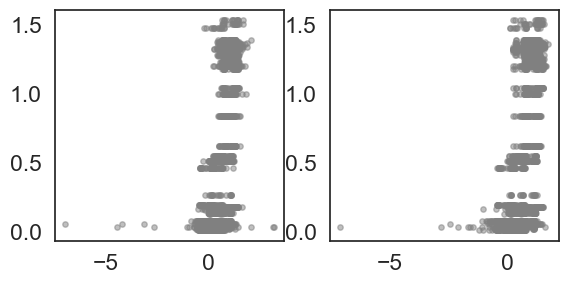

In [772]:
round1Use = 'round1_25_02.xlsx'
round1UseDF = round1_02_DF
n=20 #20

round1_SVCSVR = round1UseDF[round1UseDF['Method'] == 'SVC+SVR']
round1_SVCSVR = round1_SVCSVR[round1_SVCSVR['# Training data'] == n]
round1_SVCSVR = round1_SVCSVR.reset_index(drop=True)

round1_SVR = round1UseDF[round1UseDF['Method'] == 'SVR']
round1_SVR = round1_SVR[round1_SVR['# Training data'] == n]
round1_SVR = round1_SVR.reset_index(drop=True)

comparisonList = round1_SVCSVR['Results'] - round1_SVR['Results']
roundTwoLength = len(comparisonList)

topIndexList = \
sorted(range(len(comparisonList)), key=lambda i: comparisonList[i], reverse=True)[:roundTwoLength]
bottomIndexList = \
sorted(range(len(comparisonList)), key=lambda i: comparisonList[i], reverse=True)[-1*roundTwoLength:][::-1]

print(len(topIndexList), topIndexList)
print(len(bottomIndexList), bottomIndexList)

# Run here
newSVMSVRr2List_close_H = []
newSVRr2List_close_H = []

stats_newSVMSVRr2List_close_H = []
stats_newSVRr2List_close_H = []

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6.5, 3))

for i in range(roundTwoLength):
    topIndex = topIndexList[i]
    print(topIndex, comparisonList[topIndex])
    # If the difference is at least 0.3, we use the boundary;
    # else, the improvement is not significant enough to start with
    if comparisonList[topIndex] > 0.3:

        # Dataframe for the first round of training
        ori = processExcelFormat03('round3.xlsx', 'FinalTimePoint', 0.6)

        # Get the SVM machine
        topSVMModel = r2Recorder_02[n][topIndex][0]
        ## Apply it to the ori df
        # Transform ori df to scaled version first
        inputName = list(ori.columns)[:-2]
        sc_X = scXRecorder_02[n][topIndex]
        sc_density = scDensityRecorder_02[n][topIndex]
        featureScaler = sc_X.fit(ori[inputName].values)
        scaled_features = featureScaler.transform(ori[inputName].values)
        ori[inputName] = scaled_features

        # Apply SVM on the full set
        ori['FirstRoundPrediction'] = topSVMModel.decision_function(ori[inputName])

        # The previous training data row
        originalTopTrainDFIndexTop = indexRecorder_02[n][topIndex]

        # Select pos by creating a new DF then selecting from there
        topSVMSVRfullDF_PosTemp = ori[ori['FirstRoundPrediction']>0]
        topSVMSVRfullDF_PosTemp = topSVMSVRfullDF_PosTemp.sort_values('FirstRoundPrediction')
        # No duplicates -- temp of temp
        topSVMSVRfullDF_PosTempT = topSVMSVRfullDF_PosTemp\
        [~topSVMSVRfullDF_PosTemp.index.isin(originalTopTrainDFIndexTop)]
        # Sample more, as points on the same curve have the same value
        # One curve can return more than 10 points already
        newData_IndexArrayTop_Pos = topSVMSVRfullDF_PosTempT.iloc[:20].index

        # Select neg
        topSVMSVRfullDF_NegTemp = ori[ori['FirstRoundPrediction']<0]
        topSVMSVRfullDF_NegTemp = topSVMSVRfullDF_NegTemp.sort_values('FirstRoundPrediction', ascending=False)
        # No duplicates -- temp of temp
        topSVMSVRfullDF_NegTempT = topSVMSVRfullDF_NegTemp\
        [~topSVMSVRfullDF_NegTemp.index.isin(originalTopTrainDFIndexTop)]
        # Sample more, as points on the same curve have the same value
        # One curve can return more than 10 points already
        newData_IndexArrayTop_Neg = topSVMSVRfullDF_NegTempT.iloc[:20].index

        # Combine the 2
        allNew = list(set(list(newData_IndexArrayTop_Pos)+list(newData_IndexArrayTop_Neg)))
        
        # Sample 3 times for statistical power
        for t in range(3):
            if n > len(allNew):
                allNew_half = allNew
            else:
                allNew_half = random.sample(allNew, n)
            print(len(allNew_half))

            final_IndexArrayTop_Close = allNew_half + list(np.array(originalTopTrainDFIndexTop))

            # Get the new training & testing DF
            topSVMSVRnewTrainingDF = ori.loc[final_IndexArrayTop_Close]
            topSVMSVRnewTestingDF = ori[~ori.index.isin(final_IndexArrayTop_Close)]

            complexStatsList = []
            simpleStatsList = []
            # Learn 5 times for statistical power
            for i in range(5):
                # Run top once
                complexSVRSpearmanLists2D_02_neg, complexSVRPearsonLists2D_02_neg, \
                complexSVRR2Lists2D_02_neg, complexSVRMSELists2D_02_neg, \
                complexPredictedSVRSpearmanLists2D_02_neg, complexPredictedSVRPearsonLists2D_02_neg, \
                complexPredictedSVRR2Lists2D_02_neg, complexPredictedSVRMSELists2D_02_neg, \
                r2Recorder2D_02_neg, mseRecorder2D_02_neg, pearsonRecorder2D_02_neg, spearmanRecorder2D_02_neg, \
                SVRSpearmanLists2D_02_neg, SVRPearsonLists2D_02_neg, SVRR2Lists2D_02_neg, SVRMSELists2D_02_neg, \
                PredictedSVRSpearmanLists2D_02_neg, PredictedSVRPearsonLists2D_02_neg, \
                PredictedSVRR2Lists2D_02_neg, PredictedSVRMSELists2D_02_neg, \
                SVRr2Recorder2D_02_neg, SVRmseRecorder2D_02_neg, SVRpearsonRecorder2D_02_neg, SVRspearmanRecorder2D_02_neg,\
                indexRecorder2D_02_neg, TrainXDFRecorder2D_02_neg, TrainYDFRecorder2D_02_neg, \
                SVMSVRFullXDFRecorder2D_02_neg, SVMSVRFullYDFRecorder2D_02_neg, \
                scXRecorder2D_02_neg, scDensityRecorder2D_02_neg, scDistanceRecorder2D_02_neg = \
                ComparisonMultipleRun(1, 'round3.xlsx', 3, 'FinalTimePoint', [40], \
                                      final_IndexArrayTop_Close, ['poly', 'rbf'], 0.6)
                # Get the new r2 pair
                newSVMSVRr2 = complexSVRR2Lists2D_02_neg[0][0][1]
                newSVMSVRr2List_close_H.append(newSVMSVRr2)

                newSVRr2 = SVRR2Lists2D_02_neg[0][0][1]
                newSVRr2List_close_H.append(newSVRr2)

                #
                complexStatsList.append(newSVMSVRr2)
                simpleStatsList.append(newSVRr2)

                ax1.scatter(complexPredictedSVRR2Lists2D_02_neg[0][0][1], \
                            tDF[tDF.index.isin(indexRecorder2D_02_neg[40][0]) == False]['Density'], \
                            s = 15, color='grey', alpha = 0.5)

                ax2.scatter(PredictedSVRR2Lists2D_02_neg[0][0][1], \
                            tDF[tDF.index.isin(indexRecorder2D_02_neg[40][0]) == False]['Density'], \
                            s = 15, color='grey', alpha = 0.5)

            meanComplex = np.mean(complexStatsList)
            meanSimple = np.mean(simpleStatsList)

            stats_newSVMSVRr2List_close_H.append(meanComplex)
            stats_newSVRr2List_close_H.append(meanSimple)

print(newSVMSVRr2List_close_H, newSVRr2List_close_H)
print(stats_newSVMSVRr2List_close_H, stats_newSVRr2List_close_H)

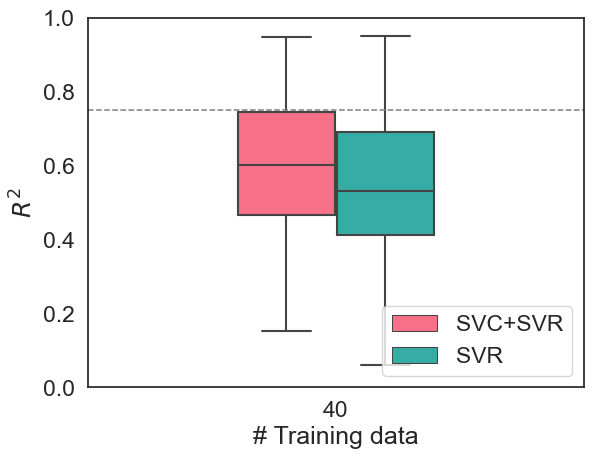

In [773]:
closeNewResult = ComparisonResultsListPlot([newSVMSVRr2List_close_H[:], newSVRr2List_close_H[:]], 40, \
          xname = '# Training data', yname = '$R^2$', show = 1, \
          ylimit = [0, 1], yline = 0.75)

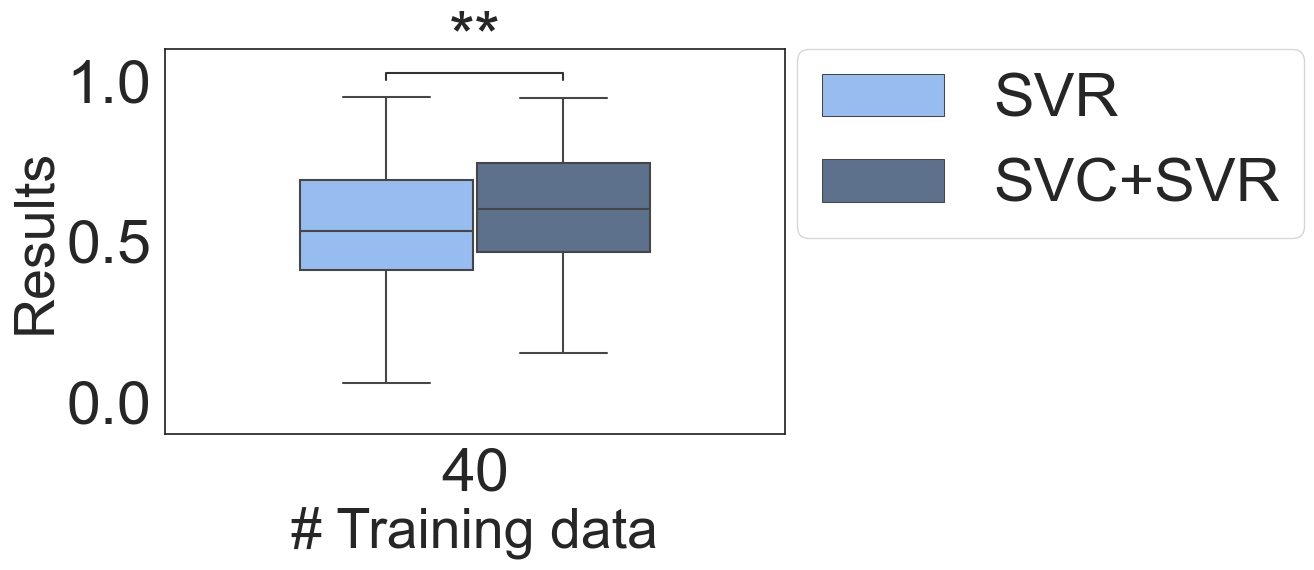

In [774]:
statsPlot(closeNewResult, 'Mann-Whitney')
# t-test_paired, Mann-Whitney

['Results']


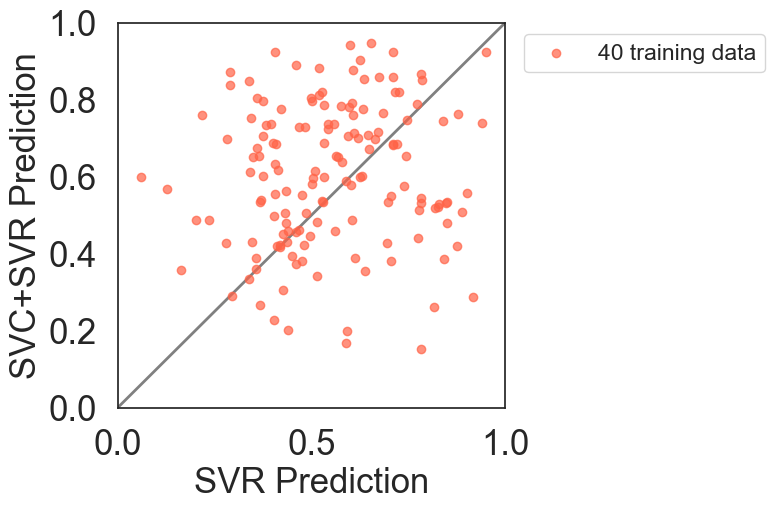

In [775]:
scatterComparisonPlot(closeNewResult)

In [776]:
print(stats_newSVMSVRr2List_close_H)
print(stats_newSVRr2List_close_H)

[0.6544658169634817, 0.5180507614838689, 0.4757719538387503, 0.4474479868128841, 0.4818257417023794, 0.553775735438232, 0.5328391349975025, 0.5865775509306206, 0.689954218308203, 0.6219083384021733, 0.7494958913152991, 0.6372097464007813, 0.4860162044853169, 0.3944349562676751, 0.5445386263329192, 0.6830024233928725, 0.6785618820397354, 0.5789421280570967, 0.5823182429442728, 0.6316877584257534, 0.7040797797278531, 0.5667532337733072, 0.6246128973177628, 0.563298436021656, 0.4926564905666352, 0.8442430438211164, 0.8148828485489267, 0.6233475686701534, 0.6272295406632699, 0.7164280975815945]
[0.466704077629411, 0.4565667252755592, 0.426140205483328, 0.4214471018105838, 0.372738852050001, 0.7143937457602036, 0.6721602475783269, 0.3927232381860377, 0.43442565184281, 0.5617990173702408, 0.5670095532312622, 0.6496729275175699, 0.4955505098571876, 0.37326618137202033, 0.5359384946627349, 0.5486590859891226, 0.566893226624224, 0.5206828295465924, 0.6239765561193621, 0.6538009131270454, 0.5882

### Control B; if round 1 not showing improvement, this doesn't help much either

22 -0.7135912262664404
20
40
[38, 33, 36, 22, 9, 44, 59, 8, 24, 29, 25, 52, 42, 6, 12, 61, 21, 28, 37, 5, 31, 40, 60, 41, 16, 10, 30, 4, 2, 58, 1, 13, 34, 56, 49, 26, 32, 57, 20, 63]
SVC(C=0.1, gamma=10.0, kernel='poly') {'kernel': 'poly', 'gamma': 10.0, 'degree': 3, 'C': 0.1} 0.875


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


R2:  0.3096628740686359
MSE:  0.2519913479843252
Pearson:  0.5564736059047508
Spearman:  0.8571428571428572
R2:  0.8235598996317761
MSE:  0.09079549361148109
Pearson:  0.9075020108141776
Spearman:  0.7380952380952381
R2:  0.2885378303723196
MSE:  0.3579525508315785
Pearson:  0.5371571747378225
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.3160938977383865, 0.2191731011816688, 0.6651549365102608, 0.4223893806923872]
SVR:  [0.5958932376192251, 0.1348321028513033, 0.7719412138364069, 0.6530434782608695]
40
[38, 33, 36, 22, 9, 44, 59, 8, 24, 29, 25, 52, 42, 6, 12, 61, 21, 28, 37, 5, 31, 40, 60, 41, 16, 10, 30, 4, 2, 58, 1, 13, 34, 56, 49, 26, 32, 57, 20, 63]
SVC(C=10.0, degree=2) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 2, 'C': 10.0} 0.9
R2:  0.9357807464403974
MSE:  0.03837678002344303
Pearson:  0.9673576104215015
Spearman:  0.8095238095238096
R2:  0.73062715169347
MSE:  0.1254844800437473
Pearson:  0.8547673085076838
Spearman:  0.7142857142857144
R2:  0.26585650965106394
MSE:  0.33036512444619204
Pearson:  0.5156127516373736
Spearman:  0.5952380952380953


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.399904614524081, 0.2873411882060562, 0.6200198346710231, 0.4452173913043478]
SVR:  [0.8173250439205555, 0.09284706081665621, 0.9040603098911908, 0.9069565217391303]
40
[38, 33, 36, 22, 9, 44, 59, 8, 24, 29, 25, 52, 42, 6, 12, 61, 21, 28, 37, 5, 31, 40, 60, 41, 16, 10, 30, 4, 2, 58, 1, 13, 34, 56, 49, 26, 32, 57, 20, 63]
SVC(C=10000.0, gamma=10.0) {'kernel': 'rbf', 'gamma': 10.0, 'degree': 3, 'C': 10000.0} 0.875
R2:  0.3158108434282546
MSE:  0.3028825973484044
Pearson:  0.5619705004964715
Spearman:  0.6666666666666669
R2:  0.3334226025029455
MSE:  0.2737485603819294
Pearson:  0.5774275733829703
Spearman:  0.880952380952381
R2:  0.7766784111623936
MSE:  0.32468485649591605
Pearson:  0.8812936009993453
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.408572566013433, 0.3047241021362062, 0.47215924712067664, 0.6747826086956521]
SVR:  [0.12074927633132551, 0.2643263444393337, 0.34748996579948244, 0.4034360110459339]
40
[38, 33, 36, 22, 9, 44, 59, 8, 24, 29, 25, 52, 42, 6, 12, 61, 21, 28, 37, 5, 31, 40, 60, 41, 16, 10, 30, 4, 2, 58, 1, 13, 34, 56, 49, 26, 32, 57, 20, 63]
SVC(C=10000.0, degree=5, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 5, 'C': 10000.0} 0.925
R2:  0.8274097894638289
MSE:  0.18319985858978527
Pearson:  0.9096206843865353
Spearman:  0.9047619047619048
R2:  0.7807707119355238
MSE:  0.6666122234603478
Pearson:  0.88361230861477
Spearman:  0.9047619047619048
R2:  0.7429895224555483
MSE:  0.3538081638299314
Pearson:  0.8619683999170438
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.48536025994298976, 0.22899271679762356, 0.6529443979479265, 0.41426650798676434]
SVR:  [0.11849888573405441, 0.35155289438616055, 0.3442366711058752, 0.5139130434782608]
40
[38, 33, 36, 22, 9, 44, 59, 8, 24, 29, 25, 52, 42, 6, 12, 61, 21, 28, 37, 5, 31, 40, 60, 41, 16, 10, 30, 4, 2, 58, 1, 13, 34, 56, 49, 26, 32, 57, 20, 63]
SVC(C=100.0, degree=4, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 4, 'C': 100.0} 0.95
R2:  0.039914503687412416
MSE:  0.41161604879175173
Pearson:  0.1997861448835039
Spearman:  0.7619047619047621
R2:  0.1887658324428501
MSE:  0.5383373338256903
Pearson:  0.434471900636681
Spearman:  0.6666666666666669
R2:  0.21788470542941957
MSE:  0.31683144670752894
Pearson:  0.4667812179484297
Spearman:  0.523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.49125931458644545, 0.2353193697085729, 0.9069814970797724, 0.6147826086956522]
SVR:  [0.4838820186165298, 0.2860765237125527, 0.6956162869114912, 0.6147826086956522]
20
40
[8, 59, 44, 12, 38, 52, 9, 22, 36, 37, 28, 33, 6, 5, 21, 24, 61, 42, 25, 29, 31, 40, 60, 41, 16, 10, 30, 4, 2, 58, 1, 13, 34, 56, 49, 26, 32, 57, 20, 63]
SVC(C=100.0, degree=5) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 5, 'C': 100.0} 0.9
R2:  0.6574837544454425
MSE:  0.15180562914257062
Pearson:  0.8108537195113816
Spearman:  0.8571428571428572
R2:  0.5046786659029212
MSE:  0.2231447523126217
Pearson:  0.7104073943188663
Spearman:  0.6190476190476191
R2:  0.4899778431425472
MSE:  0.18718184684723432
Pearson:  0.6999841734943347
Spearman:  0.7185757571479554


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.2039484246333574, 0.2289717613666228, 0.2246407806909354, 0.5443478260869564]
SVR:  [0.016948261590631876, 0.7580932981959306, 0.130185489170767, -0.08608695652173912]
40
[8, 59, 44, 12, 38, 52, 9, 22, 36, 37, 28, 33, 6, 5, 21, 24, 61, 42, 25, 29, 31, 40, 60, 41, 16, 10, 30, 4, 2, 58, 1, 13, 34, 56, 49, 26, 32, 57, 20, 63]
SVC(C=1000.0, degree=4, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 4, 'C': 1000.0} 0.95
R2:  0.44326233784893126
MSE:  0.2920284550033128
Pearson:  0.6657794964167426
Spearman:  0.8571428571428572
R2:  0.41731176812541093
MSE:  0.3011180111196925
Pearson:  0.6459967245469679
Spearman:  0.7857142857142858
R2:  0.4093754667644174
MSE:  0.30180662545596054
Pearson:  0.6398245593632815
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted wit

SVM:  [0.44078806481011285, 0.24278712953713577, 0.6937210633392574, 0.39307616650452293]
SVR:  [0.10061314995997689, 0.29112479169795624, 0.6937204691242749, 0.5730434782608694]
40
[8, 59, 44, 12, 38, 52, 9, 22, 36, 37, 28, 33, 6, 5, 21, 24, 61, 42, 25, 29, 31, 40, 60, 41, 16, 10, 30, 4, 2, 58, 1, 13, 34, 56, 49, 26, 32, 57, 20, 63]
SVC(C=100.0, degree=4, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 4, 'C': 100.0} 0.95
R2:  0.9276845099524736
MSE:  0.3094766958121127
Pearson:  0.963163802243665
Spearman:  0.523809523809524
R2:  0.9716353500374099
MSE:  0.012479163261454831
Pearson:  0.9857156537447349
Spearman:  0.6428571428571429
R2:  0.3460577442610536
MSE:  0.2150564380443893
Pearson:  0.5882667288407984
Spearman:  0.5000000000000001


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5455004262831568, 0.22873860019303405, 0.3395836126864547, 0.2495652173913043]
SVR:  [0.39474564281389, 0.207455250372653, 0.6282878661997939, 0.7252173913043477]
40
[8, 59, 44, 12, 38, 52, 9, 22, 36, 37, 28, 33, 6, 5, 21, 24, 61, 42, 25, 29, 31, 40, 60, 41, 16, 10, 30, 4, 2, 58, 1, 13, 34, 56, 49, 26, 32, 57, 20, 63]
SVC(C=10.0, degree=4, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 4, 'C': 10.0} 0.925
R2:  0.41523866314970675
MSE:  0.33393712979209156
Pearson:  0.6443901482407275
Spearman:  0.7857142857142858
R2:  0.913538018281435
MSE:  0.027842728297989363
Pearson:  0.9557918279005293
Spearman:  0.8333333333333335
R2:  0.9155497495704078
MSE:  0.026784787470000397
Pearson:  0.9568436390395287
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.2445669354408622, 0.28414256076383587, 0.4975484910540704, 0.5817391304347826]
SVR:  [0.4855069744592557, 0.2619764420982979, 0.69678330523862, 0.7217391304347825]
40
[8, 59, 44, 12, 38, 52, 9, 22, 36, 37, 28, 33, 6, 5, 21, 24, 61, 42, 25, 29, 31, 40, 60, 41, 16, 10, 30, 4, 2, 58, 1, 13, 34, 56, 49, 26, 32, 57, 20, 63]
SVC(C=10000.0, gamma=0.0001) {'kernel': 'rbf', 'gamma': 0.0001, 'degree': 3, 'C': 10000.0} 0.95
R2:  0.9673220460394217
MSE:  0.5821343345861609
Pearson:  0.9835253154034326
Spearman:  0.880952380952381
R2:  0.9306815070839244
MSE:  0.5874427878873283
Pearson:  0.9647183563527358
Spearman:  0.8095238095238096
R2:  0.8915537039323
MSE:  0.5506950644627279
Pearson:  0.9442212155699004
Spearman:  0.7380952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.12078132477322664, 0.2428514543303847, 0.10096743341812048, 0.6147826086956522]
SVR:  [0.4856847617543418, 0.261921962869478, 0.6969108707391081, 0.7217391304347825]
20
40
[37, 21, 59, 52, 25, 61, 44, 8, 12, 42, 28, 33, 6, 36, 22, 24, 29, 9, 5, 38, 31, 40, 60, 41, 16, 10, 30, 4, 2, 58, 1, 13, 34, 56, 49, 26, 32, 57, 20, 63]
SVC(C=10.0, degree=4, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 4, 'C': 10.0} 0.875
R2:  0.250402646865605
MSE:  0.4097090058717361
Pearson:  0.5004024848715332
Spearman:  0.9047619047619048
R2:  0.901384052720776
MSE:  0.030653573141576858
Pearson:  0.9494124776517191
Spearman:  0.9047619047619048
R2:  0.8980784415997254
MSE:  0.03272682890621625
Pearson:  0.9476700067004998
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.24764701224290492, 0.26904153072420983, 0.46089578433628337, 0.5521739130434782]
SVR:  [0.1132931323589016, 0.3119328823989766, 0.3365904519722769, 0.41426650798676434]
40
[37, 21, 59, 52, 25, 61, 44, 8, 12, 42, 28, 33, 6, 36, 22, 24, 29, 9, 5, 38, 31, 40, 60, 41, 16, 10, 30, 4, 2, 58, 1, 13, 34, 56, 49, 26, 32, 57, 20, 63]
SVC(C=1000.0, degree=2, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 2, 'C': 1000.0} 0.925
R2:  0.22052347588255075
MSE:  0.29123606165368304
Pearson:  0.469599271594996
Spearman:  0.11904761904761905
R2:  0.5071869983680323
MSE:  0.21991338099797944
Pearson:  0.7121706244770507
Spearman:  0.7619047619047621
R2:  0.35920906015824405
MSE:  0.19826546317193364
Pearson:  0.5993405210381193
Spearman:  0.4311454542887732


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.112836363089964, 0.24443846797914803, 0.6787466687241288, 0.5173913043478261]
SVR:  [0.030120822229658395, 0.6834080106666459, -0.17355351402278887, -0.1217391304347826]
40
[37, 21, 59, 52, 25, 61, 44, 8, 12, 42, 28, 33, 6, 36, 22, 24, 29, 9, 5, 38, 31, 40, 60, 41, 16, 10, 30, 4, 2, 58, 1, 13, 34, 56, 49, 26, 32, 57, 20, 63]
SVC(C=10000.0, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 3, 'C': 10000.0} 0.95
R2:  0.7434858977240557
MSE:  0.15662915836996633
Pearson:  0.862256283087607
Spearman:  0.6904761904761906
R2:  0.8429758975857549
MSE:  0.13172900283263023
Pearson:  0.9181371888698089
Spearman:  0.8333333333333335
R2:  0.12268453694678338
MSE:  0.5973603254161667
Pearson:  0.3502635250019382
Spearman:  0.5952380952380953


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.48113912236621087, 0.288763092129332, 0.6309616004093961, 0.7330434782608695]
SVR:  [0.45818649443005816, 0.17378920553939745, 0.6768947439817052, 0.7817391304347826]
40
[37, 21, 59, 52, 25, 61, 44, 8, 12, 42, 28, 33, 6, 36, 22, 24, 29, 9, 5, 38, 31, 40, 60, 41, 16, 10, 30, 4, 2, 58, 1, 13, 34, 56, 49, 26, 32, 57, 20, 63]
SVC(C=10000.0, degree=4, kernel='poly') {'kernel': 'poly', 'gamma': 'scale', 'degree': 4, 'C': 10000.0} 0.825
R2:  0.41478880196637435
MSE:  0.19500568976382907
Pearson:  0.6440409940107652
Spearman:  0.7784570702436182
R2:  0.5662707530650917
MSE:  0.2340957030414663
Pearson:  0.752509636526398
Spearman:  0.9285714285714287
R2:  0.293921540655599
MSE:  0.3134149821879821
Pearson:  0.5421453132284728
Spearman:  0.7142857142857144


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.32061978997817603, 0.242468164745714, 0.4497892908165021, 0.44272366300159316]
SVR:  [0.12235428621263286, 0.2708764783804917, 0.34979177550741947, 0.4034360110459339]
40
[37, 21, 59, 52, 25, 61, 44, 8, 12, 42, 28, 33, 6, 36, 22, 24, 29, 9, 5, 38, 31, 40, 60, 41, 16, 10, 30, 4, 2, 58, 1, 13, 34, 56, 49, 26, 32, 57, 20, 63]
SVC(C=1000.0, degree=2, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 2, 'C': 1000.0} 0.925
R2:  0.07134265607081311
MSE:  0.5566598430805048
Pearson:  0.26710046063384674
Spearman:  0.2142857142857143
R2:  0.025299887363696004
MSE:  0.5806615328823173
Pearson:  0.15905938313628656
Spearman:  0.3333333333333334
R2:  0.27947546309931803
MSE:  0.45306108147354673
Pearson:  0.5286543890854574
Spearman:  0.9523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.1415434220680237, 0.2764835002755672, 0.7742868222459761, 0.6147826086956522]
SVR:  [0.12074927633132551, 0.2643263444393337, 0.34748996579948244, 0.4034360110459339]
5 -0.18493178414181322
20
40
[11, 62, 61, 28, 12, 7, 10, 52, 45, 29, 8, 54, 53, 23, 9, 44, 27, 24, 25, 55, 16, 41, 26, 34, 40, 4, 30, 13, 63, 57, 31, 49, 58, 2, 1, 56, 43, 60, 20, 42]
SVC(C=1000.0, gamma=10.0) {'kernel': 'rbf', 'gamma': 10.0, 'degree': 3, 'C': 1000.0} 0.85
R2:  0.2513930756122493
MSE:  0.31522738184876564
Pearson:  0.5013911403408015
Spearman:  0.6190476190476191
R2:  0.9651574635615633
MSE:  0.021189954126234173
Pearson:  0.9824242787928054
Spearman:  0.7142857142857144
R2:  0.9672853055916762
MSE:  0.02064993642771832
Pearson:  0.983506637289081
Spearman:  0.7142857142857144


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.27122599203445524, 0.12729758819993553, 0.7254747875461799, 0.477391304347826]
SVR:  [0.1122024862407329, 0.3341282277504172, 0.33496639568878084, 0.31363314057821484]
40
[11, 62, 61, 28, 12, 7, 10, 52, 45, 29, 8, 54, 53, 23, 9, 44, 27, 24, 25, 55, 16, 41, 26, 34, 40, 4, 30, 13, 63, 57, 31, 49, 58, 2, 1, 56, 43, 60, 20, 42]
SVC(C=10000.0, degree=5, gamma=10.0, kernel='poly') {'kernel': 'poly', 'gamma': 10.0, 'degree': 5, 'C': 10000.0} 0.925
R2:  0.006718702352442548
MSE:  0.3879756075132548
Pearson:  -0.08196769090588407
Spearman:  -0.2380952380952381
R2:  0.8759515685929672
MSE:  0.1603452869092426
Pearson:  0.9359228432904962
Spearman:  0.6107893935757621
R2:  0.9592634332882252
MSE:  0.013795617754285254
Pearson:  0.9794199473607963
Spearman:  0.6190476190476191


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6479203113710575, 0.2683784050371672, 0.7694607174594661, 0.47478260869565214]
SVR:  [0.46394994346407686, 0.35257948836726155, 0.6811387108835298, 0.43478260869565216]
40
[11, 62, 61, 28, 12, 7, 10, 52, 45, 29, 8, 54, 53, 23, 9, 44, 27, 24, 25, 55, 16, 41, 26, 34, 40, 4, 30, 13, 63, 57, 31, 49, 58, 2, 1, 56, 43, 60, 20, 42]
SVC(C=10.0, degree=5, gamma=10.0, kernel='poly') {'kernel': 'poly', 'gamma': 10.0, 'degree': 5, 'C': 10.0} 0.925
R2:  0.11483692586505989
MSE:  0.9366509107755154
Pearson:  0.3388759741632031
Spearman:  0.19047619047619052
R2:  0.16126971392318
MSE:  0.9505701429005934
Pearson:  0.40158400605997757
Spearman:  0.2142857142857143
R2:  0.08610155836147894
MSE:  0.8248885807419006
Pearson:  0.29343067045126525
Spearman:  0.19047619047619052


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6396304350275501, 0.7256118207250499, 0.33348028271035435, 0.43652173913043474]
SVR:  [0.3716993299291498, 0.9139096791202711, 0.6096714934529492, 0.5634782608695652]
40
[11, 62, 61, 28, 12, 7, 10, 52, 45, 29, 8, 54, 53, 23, 9, 44, 27, 24, 25, 55, 16, 41, 26, 34, 40, 4, 30, 13, 63, 57, 31, 49, 58, 2, 1, 56, 43, 60, 20, 42]
SVC(C=0.01, degree=5, gamma=10.0, kernel='poly') {'kernel': 'poly', 'gamma': 10.0, 'degree': 5, 'C': 0.01} 0.925
R2:  0.034832395181728044
MSE:  0.7166264989142863
Pearson:  0.1866343890651667
Spearman:  0.1666666666666667
R2:  0.6289099898495636
MSE:  0.3793119009228465
Pearson:  0.7930384542060763
Spearman:  0.6904761904761906
R2:  0.6137424386737539
MSE:  0.36022871131138584
Pearson:  0.783417154952426
Spearman:  0.6666666666666669


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.37359594577330607, 0.08651696145754689, 0.769267686254651, 0.43043478260869555]
SVR:  [0.41921149619455594, 0.49699081035607134, 0.6474654401545737, 0.43043478260869555]
40
[11, 62, 61, 28, 12, 7, 10, 52, 45, 29, 8, 54, 53, 23, 9, 44, 27, 24, 25, 55, 16, 41, 26, 34, 40, 4, 30, 13, 63, 57, 31, 49, 58, 2, 1, 56, 43, 60, 20, 42]
SVC(C=10000.0, degree=5, gamma=1.0, kernel='poly') {'kernel': 'poly', 'gamma': 1.0, 'degree': 5, 'C': 10000.0} 0.925
R2:  0.19458077873460325
MSE:  0.5369711156365258
Pearson:  0.4411131133106375
Spearman:  0.5952380952380953
R2:  nan
MSE:  0.5583915265499614
Pearson:  nan
Spearman:  nan
R2:  0.17925454120342382
MSE:  0.558391462869695
Pearson:  0.4233846256105952
Spearman:  0.5952380952380953


/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted wit

SVM:  [0.6139173660175116, 0.39154789681526686, 0.3353697288974591, 0.39739130434782605]
SVR:  [0.5170476331715479, 0.937733908160666, 0.7190602430753265, 0.5823005138741677]
20
40
[29, 62, 54, 45, 52, 11, 28, 12, 44, 25, 55, 7, 61, 24, 9, 23, 53, 10, 8, 27, 16, 41, 26, 34, 40, 4, 30, 13, 63, 57, 31, 49, 58, 2, 1, 56, 43, 60, 20, 42]
SVC(degree=5, gamma=10.0) {'kernel': 'rbf', 'gamma': 10.0, 'degree': 5, 'C': 1.0} 0.875
R2:  0.857796244036248
MSE:  0.052654244133101276
Pearson:  0.9261729018041112
Spearman:  0.9523809523809524
R2:  0.7196362935975359
MSE:  0.12023748884795821
Pearson:  0.8483137942987463
Spearman:  0.8333333333333335
R2:  0.890546562607789
MSE:  0.0462677719656089
Pearson:  0.9436877463482234
Spearman:  0.9761904761904763


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4319939592223889, 0.1505394100959048, 0.6637429697156737, 0.6113043478260869]
SVR:  [0.6073699221681994, 0.2722450567274753, 0.7793394139707035, 0.3078260869565217]
40
[29, 62, 54, 45, 52, 11, 28, 12, 44, 25, 55, 7, 61, 24, 9, 23, 53, 10, 8, 27, 16, 41, 26, 34, 40, 4, 30, 13, 63, 57, 31, 49, 58, 2, 1, 56, 43, 60, 20, 42]
SVC(C=10000.0, degree=5, gamma='auto', kernel='poly') {'kernel': 'poly', 'gamma': 'auto', 'degree': 5, 'C': 10000.0} 0.875
R2:  0.31622572205217453
MSE:  0.3360756289950698
Pearson:  0.5623395078172744
Spearman:  0.2142857142857143
R2:  0.07407511295354123
MSE:  0.33949847837925784
Pearson:  0.2721674355126661
Spearman:  0.19047619047619052
R2:  0.0001012643489916723
MSE:  0.37885034560204733
Pearson:  -0.010063018880617919
Spearman:  -0.14285714285714288


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.13423148999014922, 0.10536011047578031, 0.7603358619783355, 0.43478260869565216]
SVR:  [0.5385541287888813, 0.1936796650247976, 0.7338624726669715, 0.2495652173913043]
40
[29, 62, 54, 45, 52, 11, 28, 12, 44, 25, 55, 7, 61, 24, 9, 23, 53, 10, 8, 27, 16, 41, 26, 34, 40, 4, 30, 13, 63, 57, 31, 49, 58, 2, 1, 56, 43, 60, 20, 42]
SVC(C=100.0, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 3, 'C': 100.0} 0.925
R2:  0.8025559392407201
MSE:  0.14067930567459042
Pearson:  0.8958548650538882
Spearman:  0.880952380952381
R2:  0.6114748591490217
MSE:  0.21494642481891782
Pearson:  0.7819685793873188
Spearman:  0.7380952380952381
R2:  0.3352717483425163
MSE:  0.32572024451931303
Pearson:  0.5790265523639795
Spearman:  0.4761904761904762


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.2176326573653604, 0.43137405638654824, 0.6143228351723766, 0.4356521739130434]
SVR:  [0.6017630919527029, 0.09718493602306705, 0.7757339053778061, 0.3834782608695652]
40
[29, 62, 54, 45, 52, 11, 28, 12, 44, 25, 55, 7, 61, 24, 9, 23, 53, 10, 8, 27, 16, 41, 26, 34, 40, 4, 30, 13, 63, 57, 31, 49, 58, 2, 1, 56, 43, 60, 20, 42]
SVC(C=1000.0, degree=5, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 5, 'C': 1000.0} 0.925
R2:  0.9598374046315372
MSE:  0.01641292277758964
Pearson:  0.9797129194981241
Spearman:  0.38095238095238104
R2:  0.26980834281379446
MSE:  0.2917507930980728
Pearson:  0.5194307873179972
Spearman:  0.30952380952380953
R2:  0.5828486935361868
MSE:  0.1866312292202678
Pearson:  0.7634452786782999
Spearman:  0.6190476190476191


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5784063129272194, 0.2714659241632776, 0.5967980158058548, 0.4417391304347826]
SVR:  [0.45235435750996134, 0.2825661453445849, 0.6725729384311874, 0.4539130434782608]
40
[29, 62, 54, 45, 52, 11, 28, 12, 44, 25, 55, 7, 61, 24, 9, 23, 53, 10, 8, 27, 16, 41, 26, 34, 40, 4, 30, 13, 63, 57, 31, 49, 58, 2, 1, 56, 43, 60, 20, 42]
SVC(C=10000.0, degree=4, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 4, 'C': 10000.0} 0.9
R2:  0.42573700124737957
MSE:  14.256303090894223
Pearson:  0.6524852498312739
Spearman:  0.523809523809524
R2:  0.6702048166006028
MSE:  0.2501527413699454
Pearson:  0.8186603792786135
Spearman:  0.5714285714285715
R2:  0.5209860896314743
MSE:  0.18503174545214227
Pearson:  0.7217936613960213
Spearman:  0.730552019767088


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.09590733704491872, 0.0942440959431456, 0.14127211900238457, 0.45826086956521733]
SVR:  [0.2181952181212912, 0.7482586458006765, 0.4671137100549406, 0.4026086956521739]
20
40
[8, 52, 10, 45, 25, 62, 12, 55, 29, 11, 61, 44, 28, 27, 24, 9, 53, 54, 23, 7, 16, 41, 26, 34, 40, 4, 30, 13, 63, 57, 31, 49, 58, 2, 1, 56, 43, 60, 20, 42]
SVC(C=10000.0, gamma=0.0001) {'kernel': 'rbf', 'gamma': 0.0001, 'degree': 3, 'C': 10000.0} 0.925
R2:  0.9490939332198768
MSE:  0.01859881509381797
Pearson:  0.9742145211501814
Spearman:  0.9047619047619048
R2:  0.6020885198530286
MSE:  0.2431524425340686
Pearson:  0.7759436318786492
Spearman:  0.8982196964349441
R2:  0.9392427429691473
MSE:  0.02527948354404573
Pearson:  0.9691453673052083
Spearman:  0.7619047619047621


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7506888417457847, 0.7408828339104279, 0.7001246559927385, 0.588695652173913]
SVR:  [0.5262480712436748, 0.4550491403770995, 0.7254295770394771, 0.4417391304347826]
40
[8, 52, 10, 45, 25, 62, 12, 55, 29, 11, 61, 44, 28, 27, 24, 9, 53, 54, 23, 7, 16, 41, 26, 34, 40, 4, 30, 13, 63, 57, 31, 49, 58, 2, 1, 56, 43, 60, 20, 42]
SVC(C=10000.0, degree=4, gamma=0.0001) {'kernel': 'rbf', 'gamma': 0.0001, 'degree': 4, 'C': 10000.0} 0.925
R2:  0.3695623318473866
MSE:  0.28337078329929793
Pearson:  0.6079163855723801
Spearman:  0.6190476190476191
R2:  0.33540780420601984
MSE:  0.14311369840729143
Pearson:  0.579144027169425
Spearman:  0.7319250547113999
R2:  0.24404012986161247
MSE:  0.14465144488985882
Pearson:  0.49400418000419033
Spearman:  0.523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.21823575196951137, 0.9449602914166618, 0.2895138346148154, 0.43304347826086953]
SVR:  [0.5878417159770181, 0.26422312251969354, 0.766708364358325, 0.4452173913043478]
40
[8, 52, 10, 45, 25, 62, 12, 55, 29, 11, 61, 44, 28, 27, 24, 9, 53, 54, 23, 7, 16, 41, 26, 34, 40, 4, 30, 13, 63, 57, 31, 49, 58, 2, 1, 56, 43, 60, 20, 42]
SVC(C=100.0, degree=4, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 4, 'C': 100.0} 0.925
R2:  0.2142231371403288
MSE:  0.2355935714815952
Pearson:  0.4628424539088097
Spearman:  0.6666666666666669
R2:  0.3203288105661541
MSE:  0.2310499375263346
Pearson:  0.5659759805558484
Spearman:  0.523809523809524
R2:  0.8390305613911794
MSE:  0.055043351458955905
Pearson:  0.9159861141912464
Spearman:  0.4285714285714286


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6216341541583085, 0.9441642317701039, 0.7550012174937673, 0.1678260869565217]
SVR:  [0.6212455325704221, 0.09100868467364635, 0.7881913045513897, 0.37130434782608696]
40
[8, 52, 10, 45, 25, 62, 12, 55, 29, 11, 61, 44, 28, 27, 24, 9, 53, 54, 23, 7, 16, 41, 26, 34, 40, 4, 30, 13, 63, 57, 31, 49, 58, 2, 1, 56, 43, 60, 20, 42]
SVC(C=10000.0, gamma=10.0) {'kernel': 'rbf', 'gamma': 10.0, 'degree': 3, 'C': 10000.0} 0.85
R2:  0.2116447886499781
MSE:  0.28720033793567434
Pearson:  0.4600486807393083
Spearman:  0.7857142857142858
R2:  0.5804551435991797
MSE:  0.29961858649031703
Pearson:  0.7618760683990404
Spearman:  0.8095238095238096
R2:  0.978883879289227
MSE:  0.00859871735895845
Pearson:  0.9893856069749681
Spearman:  0.9285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.2682725827559967, 0.2079128905260655, 0.6521267159249773, 0.5721739130434782]
SVR:  [0.4966157197282466, 0.93879307006162, 0.704709670522724, 0.6018699859610516]
40
[8, 52, 10, 45, 25, 62, 12, 55, 29, 11, 61, 44, 28, 27, 24, 9, 53, 54, 23, 7, 16, 41, 26, 34, 40, 4, 30, 13, 63, 57, 31, 49, 58, 2, 1, 56, 43, 60, 20, 42]
SVC(C=100.0, degree=5, gamma=1.0, kernel='poly') {'kernel': 'poly', 'gamma': 1.0, 'degree': 5, 'C': 100.0} 0.875
R2:  0.4641027859282402
MSE:  0.3224942261692748
Pearson:  0.681250897928392
Spearman:  0.9047619047619048
R2:  0.9519730974960263
MSE:  0.05392486548119434
Pearson:  0.9756910871254416
Spearman:  0.9523809523809524
R2:  0.2299722344678973
MSE:  0.3838540184748296
Pearson:  0.4795542038892969
Spearman:  0.523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4218762343661009, 0.7473064497681996, 0.7186837556182949, 0.588695652173913]
SVR:  [0.38753725984689225, 0.296460377237719, 0.6225249070092638, 0.43478260869565216]
7 -0.15384102998583227
20
40
[3, 19, 32, 27, 35, 11, 57, 55, 37, 51, 52, 48, 60, 61, 50, 53, 56, 7, 36, 23, 30, 42, 59, 40, 1, 43, 41, 10, 13, 4, 24, 34, 31, 49, 16, 6, 58, 63, 2, 20]
SVC(C=10000.0, degree=5, gamma=0.0001) {'kernel': 'rbf', 'gamma': 0.0001, 'degree': 5, 'C': 10000.0} 0.925
R2:  0.5952593669417058
MSE:  0.3546604028190957
Pearson:  0.7715305353268306
Spearman:  0.8571428571428572
R2:  0.6884804273236133
MSE:  0.6806823577389083
Pearson:  0.8297472068790669
Spearman:  0.9047619047619048
R2:  0.5334458833970132
MSE:  0.3434121055315555
Pearson:  0.7303737970361568
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6286149565002531, 0.04325162968132166, 0.9498110214330137, 0.8782608695652172]
SVR:  [0.6286654374212775, 0.16619411306908113, 0.7928842522217712, 0.877391304347826]
40
[3, 19, 32, 27, 35, 11, 57, 55, 37, 51, 52, 48, 60, 61, 50, 53, 56, 7, 36, 23, 30, 42, 59, 40, 1, 43, 41, 10, 13, 4, 24, 34, 31, 49, 16, 6, 58, 63, 2, 20]
SVC(C=10.0, gamma='auto', kernel='poly') {'kernel': 'poly', 'gamma': 'auto', 'degree': 3, 'C': 10.0} 0.9
R2:  0.22266833297390096
MSE:  0.37502395783821363
Pearson:  0.47187745546264537
Spearman:  0.523809523809524
R2:  0.4256621997334677
MSE:  0.32625675032819146
Pearson:  0.6524279268497538
Spearman:  0.7380952380952381
R2:  0.2354144556868907
MSE:  0.3919987114503866
Pearson:  0.4851952758291147
Spearman:  0.523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.3315452118773879, 0.23554005700612965, 0.8631698300949456, 0.6130434782608695]
SVR:  [0.8882757154441192, 0.035406595210453785, 0.9424838011574097, 0.6799999999999999]
40
[3, 19, 32, 27, 35, 11, 57, 55, 37, 51, 52, 48, 60, 61, 50, 53, 56, 7, 36, 23, 30, 42, 59, 40, 1, 43, 41, 10, 13, 4, 24, 34, 31, 49, 16, 6, 58, 63, 2, 20]
SVC(C=0.1, degree=2, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 2, 'C': 0.1} 0.65
R2:  0.329063997856621
MSE:  0.2676906297179756
Pearson:  0.5736410008503758
Spearman:  0.6904761904761906
R2:  0.8257698104083802
MSE:  0.06120664868038653
Pearson:  0.908718774103617
Spearman:  0.8095238095238096
R2:  0.4408202451470992
MSE:  0.23245550454897074
Pearson:  0.6639429532325043
Spearman:  0.4285714285714286


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4607030944621308, 0.03485744160918733, 0.9539061556503619, 0.8695652173913043]
SVR:  [0.9008082780683612, 0.03258893556533968, 0.9491092023936766, 0.8391304347826085]
40
[3, 19, 32, 27, 35, 11, 57, 55, 37, 51, 52, 48, 60, 61, 50, 53, 56, 7, 36, 23, 30, 42, 59, 40, 1, 43, 41, 10, 13, 4, 24, 34, 31, 49, 16, 6, 58, 63, 2, 20]
SVC(C=1000.0, degree=4, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 4, 'C': 1000.0} 0.9
R2:  0.5872367064205269
MSE:  3.5341327854876026
Pearson:  0.766313712796872
Spearman:  0.6666666666666669
R2:  0.8510226154991731
MSE:  0.14993541874379013
Pearson:  0.9225088701466088
Spearman:  0.8783100656536799
R2:  0.8020305935604863
MSE:  0.08186112655266929
Pearson:  0.8955616079089626
Spearman:  0.7142857142857144


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.837342137968181, 0.10361590153755196, 0.9150640075798966, 0.6904347826086955]
SVR:  [0.6681979754785691, 0.21740253718437774, 0.8174337743686452, 0.6646351579711152]
40
[3, 19, 32, 27, 35, 11, 57, 55, 37, 51, 52, 48, 60, 61, 50, 53, 56, 7, 36, 23, 30, 42, 59, 40, 1, 43, 41, 10, 13, 4, 24, 34, 31, 49, 16, 6, 58, 63, 2, 20]
SVC(C=10.0, degree=4, gamma='auto') {'kernel': 'rbf', 'gamma': 'auto', 'degree': 4, 'C': 10.0} 0.825
R2:  0.4427149074834788
MSE:  0.23699972083870302
Pearson:  0.665368249530648
Spearman:  0.9047619047619048
R2:  0.9152203555970463
MSE:  0.02728631332222859
Pearson:  0.9566714982673238
Spearman:  0.9047619047619048
R2:  0.9088226347884986
MSE:  0.02963892722605645
Pearson:  0.9533218946339683
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9036975187666765, 0.03821191604964535, 0.9507773572469533, 0.8626086956521738]
SVR:  [0.6678510159428712, 0.13198316909535165, 0.8172215219528125, 0.8452173913043477]
20
40
[11, 57, 7, 36, 48, 27, 61, 35, 53, 60, 32, 56, 19, 52, 55, 3, 51, 23, 50, 37, 30, 42, 59, 40, 1, 43, 41, 10, 13, 4, 24, 34, 31, 49, 16, 6, 58, 63, 2, 20]
SVC(C=100.0, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 3, 'C': 100.0} 0.925
R2:  0.0822670195861536
MSE:  0.18768007890242963
Pearson:  0.28682227874792704
Spearman:  0.04761904761904763
R2:  0.1690441698491019
MSE:  0.16255806536695025
Pearson:  0.4111498143610208
Spearman:  0.30952380952380953
R2:  0.7122411622080772
MSE:  0.10479371360219754
Pearson:  0.843943814603838
Spearman:  0.2380952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7935975070225909, 0.03288458629249263, 0.8592156866811135, 0.6646351579711152]
SVR:  [0.9001613114351313, 0.0323995909947433, 0.9487683128325539, 0.837391304347826]
40
[11, 57, 7, 36, 48, 27, 61, 35, 53, 60, 32, 56, 19, 52, 55, 3, 51, 23, 50, 37, 30, 42, 59, 40, 1, 43, 41, 10, 13, 4, 24, 34, 31, 49, 16, 6, 58, 63, 2, 20]
SVC(C=10.0, degree=2, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 2, 'C': 10.0} 0.875
R2:  0.9208962219699929
MSE:  0.02698060832109756
Pearson:  0.9596333789369738
Spearman:  0.7619047619047621
R2:  0.9190353552640315
MSE:  0.03717756957979014
Pearson:  0.9586633169491946
Spearman:  0.7142857142857144
R2:  0.9025167278865347
MSE:  0.3213044801418735
Pearson:  0.9500088041100119
Spearman:  0.5714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8884369878972344, 0.041018019200933765, 0.9445674334004468, 0.9130434782608695]
SVR:  [0.9142909849090016, 0.032270484564100844, 0.9561856435384299, 0.88]
40
[11, 57, 7, 36, 48, 27, 61, 35, 53, 60, 32, 56, 19, 52, 55, 3, 51, 23, 50, 37, 30, 42, 59, 40, 1, 43, 41, 10, 13, 4, 24, 34, 31, 49, 16, 6, 58, 63, 2, 20]
SVC(C=100.0, degree=4, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 4, 'C': 100.0} 0.925
R2:  0.5386883090608338
MSE:  0.2077227778819114
Pearson:  0.7339538875575453
Spearman:  0.6666666666666669
R2:  0.430553429859018
MSE:  0.24982864453716608
Pearson:  0.6561657030499368
Spearman:  0.6666666666666669
R2:  0.8214588002189888
MSE:  0.077701699246981
Pearson:  0.9063436435585505
Spearman:  0.6904761904761906


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7445791502906336, 0.0866434073435615, 0.9247594025935495, 0.8617391304347826]
SVR:  [0.6546128119165465, 0.14979586269057157, 0.8090814618544581, 0.8756521739130434]
40
[11, 57, 7, 36, 48, 27, 61, 35, 53, 60, 32, 56, 19, 52, 55, 3, 51, 23, 50, 37, 30, 42, 59, 40, 1, 43, 41, 10, 13, 4, 24, 34, 31, 49, 16, 6, 58, 63, 2, 20]
SVC(C=100.0, degree=4, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 4, 'C': 100.0} 0.925
R2:  0.7304780313738253
MSE:  0.12044893495327108
Pearson:  0.8546800754515255
Spearman:  0.7857142857142858
R2:  0.3613715511168421
MSE:  0.30078358534153926
Pearson:  0.601141872702977
Spearman:  0.6190476190476191
R2:  0.5521334446165541
MSE:  0.19479141217273027
Pearson:  0.7430568246214782
Spearman:  0.5952380952380953


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6294219868287888, 0.15434205174182444, 0.9114597316116191, 0.6765217391304347]
SVR:  [0.629408232115846, 0.22342208813857656, 0.7933525270116975, 0.8782608695652172]
40
[11, 57, 7, 36, 48, 27, 61, 35, 53, 60, 32, 56, 19, 52, 55, 3, 51, 23, 50, 37, 30, 42, 59, 40, 1, 43, 41, 10, 13, 4, 24, 34, 31, 49, 16, 6, 58, 63, 2, 20]
SVC(C=10000.0, degree=5, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 5, 'C': 10000.0} 0.9
R2:  0.8934482472284027
MSE:  0.42471724858317295
Pearson:  0.9452239138047678
Spearman:  0.7619047619047621
R2:  0.9448028034904591
MSE:  0.4293635857337259
Pearson:  0.9720096725292704
Spearman:  0.7619047619047621
R2:  0.8675321147612335
MSE:  0.07946363655166086
Pearson:  0.9314140404574291
Spearman:  0.7857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8886410032015126, 0.1702484739810087, 0.9412545408602362, 0.8800531367426507]
SVR:  [0.628556252253789, 0.16514447670689855, 0.7928153960751448, 0.8730434782608695]
20
40
[57, 35, 37, 51, 7, 19, 23, 11, 27, 60, 36, 56, 55, 3, 50, 48, 32, 52, 61, 53, 30, 42, 59, 40, 1, 43, 41, 10, 13, 4, 24, 34, 31, 49, 16, 6, 58, 63, 2, 20]
SVC(C=10.0, kernel='poly') {'kernel': 'poly', 'gamma': 'scale', 'degree': 3, 'C': 10.0} 0.9
R2:  4.524916990791972e-05
MSE:  0.27906559559041333
Pearson:  -0.0067267503229955505
Spearman:  0.1666666666666667
R2:  0.3819611811860877
MSE:  0.19804604092376665
Pearson:  0.6180300811336671
Spearman:  0.14285714285714288
R2:  0.3372839119951534
MSE:  0.2591023695004523
Pearson:  0.5807614932096936
Spearman:  0.6666666666666669


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6692719458376909, 0.029804714776591645, 0.7933669658031491, 0.8460869565217389]
SVR:  [0.9021681551295617, 0.03227184211150744, 0.9498253287471129, 0.8652173913043478]
40
[57, 35, 37, 51, 7, 19, 23, 11, 27, 60, 36, 56, 55, 3, 50, 48, 32, 52, 61, 53, 30, 42, 59, 40, 1, 43, 41, 10, 13, 4, 24, 34, 31, 49, 16, 6, 58, 63, 2, 20]
SVC(C=10.0, degree=4, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 4, 'C': 10.0} 0.875
R2:  0.5344167965439187
MSE:  0.19740838864475016
Pearson:  0.7310381635345169
Spearman:  0.6904761904761906
R2:  0.9132426010979444
MSE:  0.030569054769923373
Pearson:  0.955637274857958
Spearman:  0.7619047619047621
R2:  0.9157857608514334
MSE:  0.031669891883575975
Pearson:  0.9569669591221179
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8821731394183627, 0.040194072613900886, 0.9392407249573255, 0.72]
SVR:  [0.505823798343666, 0.28393122571393054, 0.7112129064799555, 0.7866660211775639]
40
[57, 35, 37, 51, 7, 19, 23, 11, 27, 60, 36, 56, 55, 3, 50, 48, 32, 52, 61, 53, 30, 42, 59, 40, 1, 43, 41, 10, 13, 4, 24, 34, 31, 49, 16, 6, 58, 63, 2, 20]
SVC(C=10.0, degree=2, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 2, 'C': 10.0} 0.875
R2:  0.9686602348419743
MSE:  0.014327283371783309
Pearson:  0.9842053824491992
Spearman:  0.7619047619047621
R2:  0.9693359193935615
MSE:  0.012930069250677943
Pearson:  0.9845485866088893
Spearman:  0.7619047619047621
R2:  0.9686676524251652
MSE:  0.014300346668246956
Pearson:  0.9842091507526056
Spearman:  0.7619047619047621


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.894086636478446, 0.039041448048978016, 0.9454358846777902, 0.8469565217391304]
SVR:  [0.914292811581179, 0.03224841811326886, 0.9561865987249449, 0.88]
40
[57, 35, 37, 51, 7, 19, 23, 11, 27, 60, 36, 56, 55, 3, 50, 48, 32, 52, 61, 53, 30, 42, 59, 40, 1, 43, 41, 10, 13, 4, 24, 34, 31, 49, 16, 6, 58, 63, 2, 20]
SVC(C=10000.0, degree=5, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 5, 'C': 10000.0} 0.925
R2:  0.4208378636679954
MSE:  0.43503476524865897
Pearson:  0.6487201736249579
Spearman:  0.4761904761904762
R2:  0.5090638872497233
MSE:  0.43635571600988143
Pearson:  0.7134871318038774
Spearman:  0.7380952380952381
R2:  0.7507813585651031
MSE:  0.3979943903938209
Pearson:  0.8664764039286373
Spearman:  0.9285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9018405223902669, 0.040048469218254605, 0.7939235001335543, 0.8669565217391304]
SVR:  [0.5811612098744784, 0.3081831229219326, 0.7623393010165999, 0.8695652173913043]
40
[57, 35, 37, 51, 7, 19, 23, 11, 27, 60, 36, 56, 55, 3, 50, 48, 32, 52, 61, 53, 30, 42, 59, 40, 1, 43, 41, 10, 13, 4, 24, 34, 31, 49, 16, 6, 58, 63, 2, 20]
SVC(C=0.1, degree=5, gamma=10.0) {'kernel': 'rbf', 'gamma': 10.0, 'degree': 5, 'C': 0.1} 0.9
R2:  0.9747320798055668
MSE:  0.036731575140976414
Pearson:  0.987285206921266
Spearman:  0.8095238095238096
R2:  0.9771123550161517
MSE:  0.03979338414793576
Pearson:  0.9884899367298342
Spearman:  0.8095238095238096
R2:  0.9770900669548331
MSE:  0.03855088558564315
Pearson:  0.9884786628728177
Spearman:  0.8095238095238096


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6716873997460587, 0.04097544492413515, 0.9469530484909052, 0.8817391304347826]
SVR:  [0.8807566254390273, 0.041025162119842716, 0.9384863480301818, 0.7052173913043478]
11 -0.11784988316245576
20
40
[51, 11, 61, 54, 3, 55, 39, 52, 35, 53, 9, 8, 62, 25, 26, 27, 60, 7, 19, 23, 56, 63, 40, 34, 30, 13, 31, 20, 4, 2, 10, 32, 57, 41, 42, 24, 43, 59, 1, 16]
SVC(C=100.0, degree=4) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 4, 'C': 100.0} 0.925
R2:  0.9385419783260558
MSE:  0.036165010309262266
Pearson:  0.9687837624186606
Spearman:  0.8571428571428572
R2:  0.9390279153659321
MSE:  0.035064506852490705
Pearson:  0.9690345274374552
Spearman:  0.8571428571428572
R2:  0.7633817379153395
MSE:  0.5419598433529549
Pearson:  0.873717195616144
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6808154747136016, 0.18895435344999492, 0.8395555629128487, 0.7408695652173911]
SVR:  [0.9022997497641058, 0.38373948310902484, 0.949894599291998, 0.7434782608695651]
40
[51, 11, 61, 54, 3, 55, 39, 52, 35, 53, 9, 8, 62, 25, 26, 27, 60, 7, 19, 23, 56, 63, 40, 34, 30, 13, 31, 20, 4, 2, 10, 32, 57, 41, 42, 24, 43, 59, 1, 16]
SVC(C=100.0) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 3, 'C': 100.0} 0.925
R2:  0.8006127146108942
MSE:  0.38532685018745577
Pearson:  0.8947696433221761
Spearman:  0.6190476190476191
R2:  0.8416926252698688
MSE:  0.08110042075745913
Pearson:  0.9174380770765236
Spearman:  0.5476190476190477
R2:  0.7452480980444963
MSE:  0.1338138837154525
Pearson:  0.8632775324566813
Spearman:  0.19047619047619052


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8079256975533363, 0.11453766018255457, 0.8472593063130236, 0.7382608695652173]
SVR:  [0.5561979322888694, 0.14896088203174956, 0.745786787419078, 0.5939130434782608]
40
[51, 11, 61, 54, 3, 55, 39, 52, 35, 53, 9, 8, 62, 25, 26, 27, 60, 7, 19, 23, 56, 63, 40, 34, 30, 13, 31, 20, 4, 2, 10, 32, 57, 41, 42, 24, 43, 59, 1, 16]
SVC(C=100.0, gamma=10.0) {'kernel': 'rbf', 'gamma': 10.0, 'degree': 3, 'C': 100.0} 0.9
R2:  0.41921250883710254
MSE:  0.3044025652506241
Pearson:  0.6474662221591968
Spearman:  0.7380952380952381
R2:  0.38877248039955037
MSE:  0.20151935176875546
Pearson:  0.623516223044397
Spearman:  0.5000000000000001
R2:  0.34796409712690873
MSE:  0.3706961076305976
Pearson:  0.5898848168302933
Spearman:  0.5000000000000001


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7114255700995866, 0.15041208719422214, 0.957981328487328, 0.8156521739130433]
SVR:  [0.9258410251180837, 0.04090414275348465, 0.962206331884219, 0.7565217391304346]
40
[51, 11, 61, 54, 3, 55, 39, 52, 35, 53, 9, 8, 62, 25, 26, 27, 60, 7, 19, 23, 56, 63, 40, 34, 30, 13, 31, 20, 4, 2, 10, 32, 57, 41, 42, 24, 43, 59, 1, 16]
SVC(degree=4, gamma=10.0, kernel='poly') {'kernel': 'poly', 'gamma': 10.0, 'degree': 4, 'C': 1.0} 0.875
R2:  0.7951096785352325
MSE:  0.11052456285395568
Pearson:  0.8916892275536542
Spearman:  0.4047619047619048
R2:  0.6015821587492364
MSE:  0.32252114541250093
Pearson:  0.7756172759481552
Spearman:  0.9523809523809524
R2:  0.18643289830961401
MSE:  0.27949570920931444
Pearson:  0.4317787608366279
Spearman:  0.7857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7081105051909595, 0.14626687436719057, 0.9662068532752301, 0.7313043478260869]
SVR:  [0.9306659210204045, 0.20142248988163902, 0.9647102782806891, 0.6730434782608695]
40
[51, 11, 61, 54, 3, 55, 39, 52, 35, 53, 9, 8, 62, 25, 26, 27, 60, 7, 19, 23, 56, 63, 40, 34, 30, 13, 31, 20, 4, 2, 10, 32, 57, 41, 42, 24, 43, 59, 1, 16]
SVC(C=100.0, degree=5, kernel='poly') {'kernel': 'poly', 'gamma': 'scale', 'degree': 5, 'C': 100.0} 0.95
R2:  0.5858780743134234
MSE:  0.1691146950384941
Pearson:  0.7654267269395699
Spearman:  0.880952380952381
R2:  0.5894937548184289
MSE:  0.15745058450954472
Pearson:  0.7677849665228078
Spearman:  0.9047619047619048
R2:  0.35274833389386545
MSE:  0.3744632380885644
Pearson:  0.5939262023971205
Spearman:  0.7910398521054723


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5563491624650534, 0.18292518066058136, 0.9704819143099099, 0.6286956521739131]
SVR:  [0.5561979322888694, 0.14896088203174956, 0.745786787419078, 0.5939130434782608]
20
40
[11, 35, 53, 26, 61, 25, 9, 52, 55, 8, 23, 54, 7, 51, 27, 19, 60, 62, 3, 39, 56, 63, 40, 34, 30, 13, 31, 20, 4, 2, 10, 32, 57, 41, 42, 24, 43, 59, 1, 16]
SVC(C=10000.0, gamma=0.0001) {'kernel': 'rbf', 'gamma': 0.0001, 'degree': 3, 'C': 10000.0} 0.925
R2:  0.2096397847622071
MSE:  0.21661068479171655
Pearson:  0.45786437376389877
Spearman:  0.523809523809524
R2:  0.25661756640349415
MSE:  0.21095836460680595
Pearson:  0.5065743443992148
Spearman:  0.5714285714285715
R2:  0.7500353761006772
MSE:  0.06299505815198117
Pearson:  0.8660458279448481
Spearman:  0.8095238095238096


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5528849145064272, 0.20033290192930475, 0.9501468169742442, 0.737391304347826]
SVR:  [0.7159492845342962, 0.09447312145261165, 0.8461378637871587, 0.6521739130434783]
40
[11, 35, 53, 26, 61, 25, 9, 52, 55, 8, 23, 54, 7, 51, 27, 19, 60, 62, 3, 39, 56, 63, 40, 34, 30, 13, 31, 20, 4, 2, 10, 32, 57, 41, 42, 24, 43, 59, 1, 16]
SVC(C=1000.0, degree=4, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 4, 'C': 1000.0} 0.925
R2:  0.8972685313758706
MSE:  0.03753017436673455
Pearson:  0.9472425937297534
Spearman:  0.9047619047619048
R2:  0.7976534489390991
MSE:  0.2297729731146241
Pearson:  0.8931144657540259
Spearman:  0.8333333333333335
R2:  0.8283841593407323
MSE:  0.2235300614049173
Pearson:  0.9101561181142125
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7159993255717908, 0.025552087005476343, 0.9668456360367463, 0.7269565217391305]
SVR:  [0.6507151751662581, 0.1672007598773437, 0.80666918570518, 0.6904347826086955]
40
[11, 35, 53, 26, 61, 25, 9, 52, 55, 8, 23, 54, 7, 51, 27, 19, 60, 62, 3, 39, 56, 63, 40, 34, 30, 13, 31, 20, 4, 2, 10, 32, 57, 41, 42, 24, 43, 59, 1, 16]
SVC(C=10000.0, gamma=0.1, kernel='poly') {'kernel': 'poly', 'gamma': 0.1, 'degree': 3, 'C': 10000.0} 0.875
R2:  0.5926670345531847
MSE:  0.5004334286203223
Pearson:  0.7698487088728437
Spearman:  0.9047619047619048
R2:  0.8536201137684498
MSE:  0.08497379990774467
Pearson:  0.9239156421278134
Spearman:  0.8333333333333335
R2:  0.8719701076027335
MSE:  0.061899137122295896
Pearson:  0.9337933966369294
Spearman:  0.6666666666666669


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8952362805577878, 0.21145813883279332, 0.8657295877490851, 0.6791304347826086]
SVR:  [0.9440271657277807, 0.21885665964428894, 0.9716106039601361, 0.8226086956521739]
40
[11, 35, 53, 26, 61, 25, 9, 52, 55, 8, 23, 54, 7, 51, 27, 19, 60, 62, 3, 39, 56, 63, 40, 34, 30, 13, 31, 20, 4, 2, 10, 32, 57, 41, 42, 24, 43, 59, 1, 16]
SVC(C=100.0, degree=5, kernel='poly') {'kernel': 'poly', 'gamma': 'scale', 'degree': 5, 'C': 100.0} 0.925
R2:  0.29646309584894054
MSE:  0.22115718309342575
Pearson:  0.5444842475673106
Spearman:  0.8333333333333335
R2:  0.2964258767361288
MSE:  0.22115826204814054
Pearson:  0.5444500681753367
Spearman:  0.8333333333333335
R2:  0.882242051893209
MSE:  0.02543405754058724
Pearson:  0.9392774094447333
Spearman:  0.7380952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7270897838669479, 0.3291296229598457, 0.9666191467873773, 0.5913043478260869]
SVR:  [0.7118994660874493, 0.342674209419875, 0.8437413502297073, 0.7191304347826086]
40
[11, 35, 53, 26, 61, 25, 9, 52, 55, 8, 23, 54, 7, 51, 27, 19, 60, 62, 3, 39, 56, 63, 40, 34, 30, 13, 31, 20, 4, 2, 10, 32, 57, 41, 42, 24, 43, 59, 1, 16]
SVC(C=10000.0, degree=2, gamma='auto') {'kernel': 'rbf', 'gamma': 'auto', 'degree': 2, 'C': 10000.0} 0.9
R2:  0.6856061771014923
MSE:  0.2946981295610909
Pearson:  0.828013391861202
Spearman:  0.5714285714285715
R2:  0.4029091351167721
MSE:  0.21797970727615504
Pearson:  0.6347512387674183
Spearman:  0.6190476190476191
R2:  0.7593223004936418
MSE:  0.10809787530672507
Pearson:  0.8713910146964114
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7217128278525753, 0.12195266993756165, 0.93320155520774, 0.7478260869565216]
SVR:  [0.9156772987574083, 0.34439823666486397, 0.956910287726811, 0.7382608695652173]
20
40
[19, 35, 52, 51, 7, 62, 54, 39, 9, 26, 61, 60, 55, 3, 11, 8, 27, 25, 23, 53, 56, 63, 40, 34, 30, 13, 31, 20, 4, 2, 10, 32, 57, 41, 42, 24, 43, 59, 1, 16]
SVC(C=1000.0, degree=4, gamma='auto') {'kernel': 'rbf', 'gamma': 'auto', 'degree': 4, 'C': 1000.0} 0.925


/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


R2:  0.30779777383045903
MSE:  0.1646168184018922
Pearson:  0.5547952539725436
Spearman:  0.9047619047619048
R2:  0.4833228007000439
MSE:  0.19344209483623565
Pearson:  0.6952142120958433
Spearman:  0.5952380952380953
R2:  0.5946562137092714
MSE:  0.0950277514705172
Pearson:  0.771139555274706
Spearman:  0.2142857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6746614449473831, 0.12571141024248364, 0.8548273220357041, 0.5913043478260869]
SVR:  [0.708326455038914, 0.09802381367227253, 0.8416213252044614, 0.5965217391304348]
40
[19, 35, 52, 51, 7, 62, 54, 39, 9, 26, 61, 60, 55, 3, 11, 8, 27, 25, 23, 53, 56, 63, 40, 34, 30, 13, 31, 20, 4, 2, 10, 32, 57, 41, 42, 24, 43, 59, 1, 16]
SVC(C=1000.0, degree=5, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 5, 'C': 1000.0} 0.925
R2:  0.22961917011571298
MSE:  0.34607767127613587
Pearson:  0.47918594524016767
Spearman:  0.38095238095238104
R2:  0.2606871286519003
MSE:  4.032469810546985
Pearson:  0.5105752918541008
Spearman:  0.3571428571428572
R2:  0.5616669754460131
MSE:  0.19939026397550613
Pearson:  0.749444444536093
Spearman:  0.30952380952380953


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.3519052603754431, 0.07019089894891196, 0.8438816862214137, 0.6547826086956522]
SVR:  [0.5591969625763586, 0.14627997218415403, 0.7477947329156303, 0.5913043478260869]
40
[19, 35, 52, 51, 7, 62, 54, 39, 9, 26, 61, 60, 55, 3, 11, 8, 27, 25, 23, 53, 56, 63, 40, 34, 30, 13, 31, 20, 4, 2, 10, 32, 57, 41, 42, 24, 43, 59, 1, 16]
SVC(C=10000.0, degree=4, gamma=0.0001) {'kernel': 'rbf', 'gamma': 0.0001, 'degree': 4, 'C': 10000.0} 0.925
R2:  0.3232421693288202
MSE:  0.3051971254596626
Pearson:  0.5685439027276789
Spearman:  0.6428571428571429
R2:  0.30979752986204795
MSE:  0.30446388182146494
Pearson:  0.5565945830333314
Spearman:  0.8095238095238096
R2:  0.4869793723880705
MSE:  0.23075825097285702
Pearson:  0.6978390734174107
Spearman:  0.9523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7393651980277518, 0.15049582987054597, nan, 0.8156521739130433]
SVR:  [0.9348597682915457, 0.25927271260655543, 0.9668814654814443, 0.8156521739130433]
40
[19, 35, 52, 51, 7, 62, 54, 39, 9, 26, 61, 60, 55, 3, 11, 8, 27, 25, 23, 53, 56, 63, 40, 34, 30, 13, 31, 20, 4, 2, 10, 32, 57, 41, 42, 24, 43, 59, 1, 16]
SVC(C=10.0, degree=2, gamma=10.0) {'kernel': 'rbf', 'gamma': 10.0, 'degree': 2, 'C': 10.0} 0.925
R2:  0.3316685204681984
MSE:  0.2661332705991962
Pearson:  0.5759066942380496
Spearman:  0.7142857142857144
R2:  0.44697432074951904
MSE:  0.1988628039624764
Pearson:  0.6685613814374256
Spearman:  0.9047619047619048
R2:  0.8655664900830596
MSE:  0.0423634276146785
Pearson:  0.9303582589965327
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5008740165508428, 0.0525397257614669, 0.6779077256879515, 0.6043478260869565]
SVR:  [0.5168217255280051, 0.16223475574457571, 0.7189031405745874, 0.5913043478260869]
40
[19, 35, 52, 51, 7, 62, 54, 39, 9, 26, 61, 60, 55, 3, 11, 8, 27, 25, 23, 53, 56, 63, 40, 34, 30, 13, 31, 20, 4, 2, 10, 32, 57, 41, 42, 24, 43, 59, 1, 16]
SVC(C=10000.0, degree=4, gamma='auto') {'kernel': 'rbf', 'gamma': 'auto', 'degree': 4, 'C': 10000.0} 0.9
R2:  0.2598109296431432
MSE:  0.2722864795493207
Pearson:  0.5097165189035404
Spearman:  0.7142857142857144
R2:  0.28963959322435584
MSE:  0.26964185294477344
Pearson:  0.5381817473905594
Spearman:  0.7380952380952381
R2:  0.6717563866807036
MSE:  0.14724196287031338
Pearson:  0.8196074588976747
Spearman:  0.7380952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8884705907170451, 0.11488270622982077, 0.9441613237765328, 0.6113043478260869]
SVR:  [0.4787763336250356, 0.3136150351789256, 0.6919366543441937, 0.5144703070623446]
3 -0.015428977161927482
20
40
[53, 36, 33, 3, 61, 51, 35, 8, 52, 24, 55, 25, 38, 39, 37, 19, 9, 58, 50, 26, 60, 2, 40, 6, 13, 10, 41, 59, 30, 16, 42, 57, 56, 31, 20, 34, 63, 32, 49, 43]
SVC(C=10000.0, degree=4, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 4, 'C': 10000.0} 0.85
R2:  0.4552691784975399
MSE:  0.44819447935285056
Pearson:  -0.6747363770373879
Spearman:  -0.19047619047619052
R2:  0.9289974121765154
MSE:  0.047356838745464785
Pearson:  0.9638451183548711
Spearman:  0.19047619047619052
R2:  0.25154217145045366
MSE:  0.6897113280479406
Pearson:  -0.5015398004649817
Spearman:  -0.11904761904761905


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.914616691093981, 0.01693197604135945, 0.9389683870884239, 0.8017391304347825]
SVR:  [0.876911145281756, 0.15697924942132313, 0.936435339616012, 0.8782608695652172]
40
[53, 36, 33, 3, 61, 51, 35, 8, 52, 24, 55, 25, 38, 39, 37, 19, 9, 58, 50, 26, 60, 2, 40, 6, 13, 10, 41, 59, 30, 16, 42, 57, 56, 31, 20, 34, 63, 32, 49, 43]
SVC(C=100.0, degree=5) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 5, 'C': 100.0} 0.8
R2:  0.5413695930718364
MSE:  0.17829869571308704
Pearson:  0.7357782227491082
Spearman:  0.7142857142857144
R2:  0.610879999246691
MSE:  0.3526150151853217
Pearson:  0.7815881263470491
Spearman:  0.8095238095238096
R2:  0.4864774029547721
MSE:  0.26696584021258446
Pearson:  0.6974793208079878
Spearman:  0.5714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9471498828987976, 0.08593368788229437, 0.9635684945524774, 0.8330434782608694]
SVR:  [0.9106954076230499, 0.032874427943488, 0.9543036244419538, 0.697391304347826]
40
[53, 36, 33, 3, 61, 51, 35, 8, 52, 24, 55, 25, 38, 39, 37, 19, 9, 58, 50, 26, 60, 2, 40, 6, 13, 10, 41, 59, 30, 16, 42, 57, 56, 31, 20, 34, 63, 32, 49, 43]
SVC(C=100.0, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 3, 'C': 100.0} 0.85
R2:  0.44084714759597343
MSE:  0.2682725612944371
Pearson:  0.66396321253212
Spearman:  0.5000000000000001
R2:  0.4014783957511183
MSE:  0.5146464869670117
Pearson:  0.6336232285444704
Spearman:  0.28571428571428575
R2:  0.39979303126848253
MSE:  0.2800593379068803
Pearson:  0.6322918877136431
Spearman:  0.5000000000000001


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.922984818030479, 0.03288991621891183, 0.7435890965406621, 0.8034782608695652]
SVR:  [0.8287807116996696, 0.07431510587714751, 0.9103739405868718, 0.7817391304347826]
40
[53, 36, 33, 3, 61, 51, 35, 8, 52, 24, 55, 25, 38, 39, 37, 19, 9, 58, 50, 26, 60, 2, 40, 6, 13, 10, 41, 59, 30, 16, 42, 57, 56, 31, 20, 34, 63, 32, 49, 43]
SVC(C=10.0, degree=2, gamma=10.0) {'kernel': 'rbf', 'gamma': 10.0, 'degree': 2, 'C': 10.0} 0.85
R2:  0.8343695322534844
MSE:  0.06552389770383606
Pearson:  0.9134383023792492
Spearman:  0.9047619047619048
R2:  0.7881088209299016
MSE:  0.5133352683777556
Pearson:  -0.88775493292344
Spearman:  -0.2380952380952381
R2:  0.8421926091396685
MSE:  0.06161934155961178
Pearson:  0.9177105257866822
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7688677892056527, 0.0734600045549059, 0.8918055255505425, 0.8608695652173911]
SVR:  [0.881723346150504, 0.21394621092136845, 0.9390012492805876, 0.8660869565217391]
40
[53, 36, 33, 3, 61, 51, 35, 8, 52, 24, 55, 25, 38, 39, 37, 19, 9, 58, 50, 26, 60, 2, 40, 6, 13, 10, 41, 59, 30, 16, 42, 57, 56, 31, 20, 34, 63, 32, 49, 43]
SVC(C=10.0, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 3, 'C': 10.0} 0.825
R2:  0.7451907933291004
MSE:  0.3078064331374176
Pearson:  0.8632443416142968
Spearman:  0.7619047619047621
R2:  0.9049102835822742
MSE:  0.05223492529481158
Pearson:  0.9512677244510471
Spearman:  0.9523809523809524
R2:  0.841315350600843
MSE:  0.21569980066233926
Pearson:  0.9172324408789972
Spearman:  0.6904761904761906


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9517594428747825, 0.016528135951046418, 0.7785357538010906, 0.7765217391304347]
SVR:  [0.9115690950272674, 0.035150751074565494, 0.9547612764598634, 0.7043478260869565]
20
40
[38, 33, 37, 50, 39, 8, 26, 3, 52, 55, 25, 58, 9, 53, 35, 24, 36, 19, 61, 51, 60, 2, 40, 6, 13, 10, 41, 59, 30, 16, 42, 57, 56, 31, 20, 34, 63, 32, 49, 43]
SVC(C=1000.0, kernel='poly') {'kernel': 'poly', 'gamma': 'scale', 'degree': 3, 'C': 1000.0} 0.85


/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


R2:  0.05494362529248022
MSE:  0.33370470243595024
Pearson:  0.23440056589624564
Spearman:  0.31716752370827334
R2:  0.2700396060833605
MSE:  0.33371148362568376
Pearson:  0.5196533518446315
Spearman:  0.6666666666666669
R2:  0.23321624417860265
MSE:  0.5610198110424968
Pearson:  0.48292467754154234
Spearman:  0.7857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9512735910289474, 0.330178208853326, 0.9651751934467436, 0.8121739130434782]
SVR:  [0.7297288792420532, 0.333098511893746, 0.8542416983746773, 0.7947826086956521]
40
[38, 33, 37, 50, 39, 8, 26, 3, 52, 55, 25, 58, 9, 53, 35, 24, 36, 19, 61, 51, 60, 2, 40, 6, 13, 10, 41, 59, 30, 16, 42, 57, 56, 31, 20, 34, 63, 32, 49, 43]
SVC(C=100.0, gamma=1.0, kernel='poly') {'kernel': 'poly', 'gamma': 1.0, 'degree': 3, 'C': 100.0} 0.85
R2:  0.866330294676184
MSE:  0.05796581846905684
Pearson:  0.9307686579790836
Spearman:  0.6428571428571429
R2:  0.33964446669102266
MSE:  0.36157055761797663
Pearson:  0.5827902424466479
Spearman:  0.6666666666666669
R2:  0.715824720427256
MSE:  0.13185332778134218
Pearson:  0.8460642531316733
Spearman:  0.6428571428571429


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7921487419649095, 0.14770878299701265, 0.7664051668112299, 0.76]
SVR:  [0.7921560343827142, 0.3351608724820599, 0.8900314794335725, 0.7947826086956521]
40
[38, 33, 37, 50, 39, 8, 26, 3, 52, 55, 25, 58, 9, 53, 35, 24, 36, 19, 61, 51, 60, 2, 40, 6, 13, 10, 41, 59, 30, 16, 42, 57, 56, 31, 20, 34, 63, 32, 49, 43]
SVC(C=10000.0, degree=2, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 2, 'C': 10000.0} 0.8
R2:  0.4110342995516298
MSE:  0.26423463862700036
Pearson:  0.6411195672818211
Spearman:  0.6976011479687815
R2:  0.344996937010249
MSE:  0.3207149844431286
Pearson:  0.58736439882772
Spearman:  0.6666666666666669
R2:  0.5909976979602879
MSE:  0.2035448993469584
Pearson:  0.7687637465179324
Spearman:  0.6904761904761906


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.623110622719852, 0.03653349146334143, 0.974005915259988, 0.8130434782608694]
SVR:  [0.8785981013404774, 0.049717825086416735, 0.937335639640613, 0.7269565217391305]
40
[38, 33, 37, 50, 39, 8, 26, 3, 52, 55, 25, 58, 9, 53, 35, 24, 36, 19, 61, 51, 60, 2, 40, 6, 13, 10, 41, 59, 30, 16, 42, 57, 56, 31, 20, 34, 63, 32, 49, 43]
SVC(C=10000.0, degree=5, gamma='auto') {'kernel': 'rbf', 'gamma': 'auto', 'degree': 5, 'C': 10000.0} 0.775
R2:  0.7688252400779513
MSE:  0.23263566380580789
Pearson:  0.876826801642121
Spearman:  0.7142857142857144
R2:  0.7244956199793197
MSE:  0.5125412359284831
Pearson:  0.851173084618704
Spearman:  0.7142857142857144
R2:  0.8114298625493472
MSE:  0.08294870523150283
Pearson:  0.9007940178250227
Spearman:  0.6190476190476191


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9212939685101486, 0.3072184350288217, 0.8101550621734175, 0.7843478260869564]
SVR:  [0.9172501846763786, 0.03220310593786156, 0.9577317916182895, 0.7165217391304347]
40
[38, 33, 37, 50, 39, 8, 26, 3, 52, 55, 25, 58, 9, 53, 35, 24, 36, 19, 61, 51, 60, 2, 40, 6, 13, 10, 41, 59, 30, 16, 42, 57, 56, 31, 20, 34, 63, 32, 49, 43]
SVC(C=1000.0) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 3, 'C': 1000.0} 0.775
R2:  0.9324013981648418
MSE:  0.024480166817207914
Pearson:  0.965609340346727
Spearman:  0.8095238095238096
R2:  0.8952513935353457
MSE:  0.17374692741227604
Pearson:  0.9461772527044527
Spearman:  0.7619047619047621
R2:  0.974159388610646
MSE:  0.03519910954026695
Pearson:  0.9869951309964229
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.85824878616991, 0.2861478493121474, 0.9350564150442737, 0.7843478260869564]
SVR:  [0.5644987661904342, 0.30597734504950763, 0.7513313291687191, 0.8226165847298949]
20
40
[37, 33, 25, 38, 9, 61, 35, 3, 19, 52, 53, 24, 36, 50, 55, 58, 39, 8, 26, 51, 60, 2, 40, 6, 13, 10, 41, 59, 30, 16, 42, 57, 56, 31, 20, 34, 63, 32, 49, 43]
SVC(C=1000.0, degree=2, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 2, 'C': 1000.0} 0.825
R2:  0.7173414517299075
MSE:  0.12248661610700562
Pearson:  0.8469601240494782
Spearman:  0.9047619047619048
R2:  0.6059126954262601
MSE:  0.18812826380850725
Pearson:  0.7784039410397793
Spearman:  0.7380952380952381
R2:  0.23386989308953204
MSE:  0.3304633349035941
Pearson:  0.4836009647318045
Spearman:  0.5714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9057153871603085, 0.24129813023397464, 0.68485414013204, 0.7869565217391304]
SVR:  [0.951453119052413, 0.016460837476412707, 0.9754245839901784, 0.8017391304347825]
40
[37, 33, 25, 38, 9, 61, 35, 3, 19, 52, 53, 24, 36, 50, 55, 58, 39, 8, 26, 51, 60, 2, 40, 6, 13, 10, 41, 59, 30, 16, 42, 57, 56, 31, 20, 34, 63, 32, 49, 43]
SVC(C=10000.0, kernel='poly') {'kernel': 'poly', 'gamma': 'scale', 'degree': 3, 'C': 10000.0} 0.85
R2:  0.3312935707201194
MSE:  0.20957731525274048
Pearson:  0.57558107223928
Spearman:  0.28571428571428575
R2:  0.38604973471964465
MSE:  0.2414101179811654
Pearson:  0.6213290068229911
Spearman:  0.2142857142857143
R2:  0.3761060326162328
MSE:  0.2517277817551428
Pearson:  0.6132748426409099
Spearman:  0.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9525830279235962, 0.1498115034342933, 0.9363972997413372, 0.7896726459112882]
SVR:  [0.9284324957744556, 0.02382194816566348, 0.9635520202741811, 0.788695652173913]
40
[37, 33, 25, 38, 9, 61, 35, 3, 19, 52, 53, 24, 36, 50, 55, 58, 39, 8, 26, 51, 60, 2, 40, 6, 13, 10, 41, 59, 30, 16, 42, 57, 56, 31, 20, 34, 63, 32, 49, 43]
SVC(C=10000.0, gamma='auto', kernel='poly') {'kernel': 'poly', 'gamma': 'auto', 'degree': 3, 'C': 10000.0} 0.85
R2:  0.4328838302125307
MSE:  0.2844415267754642
Pearson:  0.6579390778883184
Spearman:  0.6904761904761906
R2:  0.334076153354847
MSE:  0.28553479070320265
Pearson:  0.5779932122048208
Spearman:  0.8095238095238096
R2:  0.3796782624007622
MSE:  0.24467339594912174
Pearson:  0.6161803813825641
Spearman:  0.6666666666666669


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6431350748511557, 0.28647881462939156, 0.972314905398094, 0.7947826086956521]
SVR:  [0.9529798197278117, 0.01915022319126578, 0.9762068529404055, 0.7565217391304346]
40
[37, 33, 25, 38, 9, 61, 35, 3, 19, 52, 53, 24, 36, 50, 55, 58, 39, 8, 26, 51, 60, 2, 40, 6, 13, 10, 41, 59, 30, 16, 42, 57, 56, 31, 20, 34, 63, 32, 49, 43]
SVC(C=1000.0, gamma='auto', kernel='poly') {'kernel': 'poly', 'gamma': 'auto', 'degree': 3, 'C': 1000.0} 0.8
R2:  0.6180928892102221
MSE:  0.4731559803709568
Pearson:  0.7861888381363742
Spearman:  0.5476190476190477
R2:  0.20755684571285182
MSE:  0.2898213433588806
Pearson:  0.45558407096040104
Spearman:  0.8333333333333335
R2:  0.18774970457269854
MSE:  0.3016837923421779
Pearson:  0.4333009399628607
Spearman:  0.7142857142857144


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.862544232151662, 0.03165818713211167, 0.7655779594338601, 0.7208695652173912]
SVR:  [0.8543347009963355, 0.22645521191357598, 0.9243022779352736, 0.8113043478260868]
40
[37, 33, 25, 38, 9, 61, 35, 3, 19, 52, 53, 24, 36, 50, 55, 58, 39, 8, 26, 51, 60, 2, 40, 6, 13, 10, 41, 59, 30, 16, 42, 57, 56, 31, 20, 34, 63, 32, 49, 43]
SVC(C=1000.0, degree=5, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 5, 'C': 1000.0} 0.775
R2:  0.4067353555541049
MSE:  0.32923910397713474
Pearson:  0.6377580697679213
Spearman:  0.5952380952380953
R2:  0.34776966240393253
MSE:  0.36937336686361566
Pearson:  0.5897199864375742
Spearman:  0.14285714285714288
R2:  0.8756340715000897
MSE:  0.05291398641273111
Pearson:  0.9357532107880207
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8276306116955876, 0.10336211556971668, 0.9548691741558657, 0.6043478260869565]
SVR:  [0.5912295406865731, 0.2500770967946731, 0.7689145210532655, 0.7879986878029202]
13 7.884449323825038e-05
9 0.00016495006900052773
4 0.016622072864038356
6 0.022202621560014124
23 0.02848992120219984
12 0.03580002157369502
10 0.04978919800134338
16 0.05604059236897774
2 0.06102546930199984
0 0.08737357993564482
1 0.15007493215999684
21 0.18917717332779596
17 0.22616580854695714
25 0.23233081701384017
19 0.25043454081842487
8 0.3180976211019163
18 0.39772570524272743
29 0.46176921755990397
24 0.5123170441709317
27 0.5317356294894106
28 0.5530175969011716
26 0.5757938263956837
14 0.5817365754139048
15 0.6584476271023618
20 0.6609854469396321
[0.3160938977383865, 0.399904614524081, 0.408572566013433, 0.48536025994298976, 0.49125931458644545, 0.2039484246333574, 0.44078806481011285, 0.5455004262831568, 0.2445669354408622, 0.12078132477322664, 0.24764701224290492, 0.112836363089964, 0.4811391223662

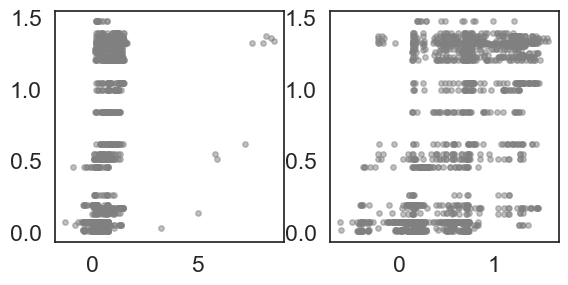

In [857]:
round1Use = 'round1_25_02.xlsx'
round1UseDF = round1_02_DF
n=20 #20

# Started with n datapoints
round1_SVCSVR = round1UseDF[round1UseDF['Method'] == 'SVC+SVR']
round1_SVCSVR = round1_SVCSVR[round1_SVCSVR['# Training data'] == n]
round1_SVCSVR = round1_SVCSVR.reset_index(drop=True)

round1_SVR = round1UseDF[round1UseDF['Method'] == 'SVR']
round1_SVR = round1_SVR[round1_SVR['# Training data'] == n]
round1_SVR = round1_SVR.reset_index(drop=True)

comparisonList = round1_SVCSVR['Results'] - round1_SVR['Results']

topIndexList = \
sorted(range(len(comparisonList)), key=lambda i: comparisonList[i], reverse=True)[:roundTwoLength]
bottomIndexList = \
sorted(range(len(comparisonList)), key=lambda i: comparisonList[i], reverse=True)[-1*roundTwoLength:][::-1]

# Run here
newSVMSVRr2List_close_H_badRound1 = []
newSVRr2List_close_H_badRound1 = []

stats_newSVMSVRr2List_close_H_badRound1 = []
stats_newSVRr2List_close_H_badRound1 = []

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6.5, 3))
for i in range(roundTwoLength):
    topIndex = bottomIndexList[i]
    print(topIndex, comparisonList[topIndex])
    if comparisonList[topIndex] < -0.01:

        # Dataframe for the first round of training
        ori = processExcelFormat03('round3.xlsx', 'FinalTimePoint', 0.6)

        # Get the SVM machine
        topSVMModel = r2Recorder_02[n][topIndex][0]
        ## Apply it to the ori df
        # Transform ori df to scaled version first
        inputName = list(ori.columns)[:-2]
        sc_X = scXRecorder_02[n][topIndex]
        sc_density = scDensityRecorder_02[n][topIndex]
        featureScaler = sc_X.fit(ori[inputName].values)
        scaled_features = featureScaler.transform(ori[inputName].values)
        ori[inputName] = scaled_features

        # Apply SVM on the full set
        ori['FirstRoundPrediction'] = topSVMModel.decision_function(ori[inputName])

        # The previous 20 training data row
        originalTopTrainDFIndexTop = indexRecorder_02[n][topIndex]

        # Select pos by creating a new DF then selecting from there
        topSVMSVRfullDF_PosTemp = ori[ori['FirstRoundPrediction']>0]
        topSVMSVRfullDF_PosTemp = topSVMSVRfullDF_PosTemp.sort_values('FirstRoundPrediction')
        # No duplicates -- temp of temp
        topSVMSVRfullDF_PosTempT = topSVMSVRfullDF_PosTemp\
        [~topSVMSVRfullDF_PosTemp.index.isin(originalTopTrainDFIndexTop)]
        newData_IndexArrayTop_Pos = topSVMSVRfullDF_PosTempT.iloc[:10].index

        # Select neg
        topSVMSVRfullDF_NegTemp = ori[ori['FirstRoundPrediction']<0]
        topSVMSVRfullDF_NegTemp = topSVMSVRfullDF_NegTemp.sort_values('FirstRoundPrediction', ascending=False)
        # No duplicates -- temp of temp
        topSVMSVRfullDF_NegTempT = topSVMSVRfullDF_NegTemp\
        [~topSVMSVRfullDF_NegTemp.index.isin(originalTopTrainDFIndexTop)]
        newData_IndexArrayTop_Neg = topSVMSVRfullDF_NegTempT.iloc[:10].index

        for t in range(3):
            # Combine the 2
            allNew = list(set(list(newData_IndexArrayTop_Pos)+list(newData_IndexArrayTop_Neg)))
            allNew_half = random.sample(allNew, n)
            print(len(allNew_half))

            final_IndexArrayTop_Close = allNew_half + list(np.array(originalTopTrainDFIndexTop))

            # Get the new training & testing DF
            topSVMSVRnewTrainingDF = ori.loc[final_IndexArrayTop_Close]
            topSVMSVRnewTestingDF = ori[~ori.index.isin(final_IndexArrayTop_Close)]

            complexStatsList = []
            simpleStatsList = []

            for t in range(5):
                # Run top once
                complexSVRSpearmanLists2D_02_neg, complexSVRPearsonLists2D_02_neg, \
                complexSVRR2Lists2D_02_neg, complexSVRMSELists2D_02_neg, \
                complexPredictedSVRSpearmanLists2D_02_neg, complexPredictedSVRPearsonLists2D_02_neg, \
                complexPredictedSVRR2Lists2D_02_neg, complexPredictedSVRMSELists2D_02_neg, \
                r2Recorder2D_02_neg, mseRecorder2D_02_neg, pearsonRecorder2D_02_neg, spearmanRecorder2D_02_neg, \
                SVRSpearmanLists2D_02_neg, SVRPearsonLists2D_02_neg, SVRR2Lists2D_02_neg, SVRMSELists2D_02_neg, \
                PredictedSVRSpearmanLists2D_02_neg, PredictedSVRPearsonLists2D_02_neg, \
                PredictedSVRR2Lists2D_02_neg, PredictedSVRMSELists2D_02_neg, \
                SVRr2Recorder2D_02_neg, SVRmseRecorder2D_02_neg, SVRpearsonRecorder2D_02_neg, SVRspearmanRecorder2D_02_neg,\
                indexRecorder2D_02_neg, TrainXDFRecorder2D_02_neg, TrainYDFRecorder2D_02_neg, \
                SVMSVRFullXDFRecorder2D_02_neg, SVMSVRFullYDFRecorder2D_02_neg, \
                scXRecorder2D_02_neg, scDensityRecorder2D_02_neg, scDistanceRecorder2D_02_neg = \
                ComparisonMultipleRun(1, 'round3.xlsx', 3, 'FinalTimePoint', [40], \
                                      final_IndexArrayTop_Close, ['poly', 'rbf'], 0.6)
                # Get the new r2 pair
                newSVMSVRr2 = complexSVRR2Lists2D_02_neg[0][0][1]
                newSVMSVRr2List_close_H_badRound1.append(newSVMSVRr2)

                newSVRr2 = SVRR2Lists2D_02_neg[0][0][1]
                newSVRr2List_close_H_badRound1.append(newSVRr2)

                ax1.scatter(complexPredictedSVRR2Lists2D_02_neg[0][0][1], \
                            tDF[tDF.index.isin(indexRecorder2D_02_neg[40][0]) == False]['Density'], \
                            s = 15, color='grey', alpha = 0.5)

                ax2.scatter(PredictedSVRR2Lists2D_02_neg[0][0][1], \
                            tDF[tDF.index.isin(indexRecorder2D_02_neg[40][0]) == False]['Density'], \
                            s = 15, color='grey', alpha = 0.5)

            meanComplex = np.mean(complexStatsList)
            meanSimple = np.mean(simpleStatsList)

            stats_newSVMSVRr2List_close_H_badRound1.append(meanComplex)
            stats_newSVRr2List_close_H_badRound1.append(meanSimple)

print(newSVMSVRr2List_close_H_badRound1, newSVRr2List_close_H_badRound1)
print(stats_newSVMSVRr2List_close_H_badRound1, stats_newSVRr2List_close_H_badRound1)


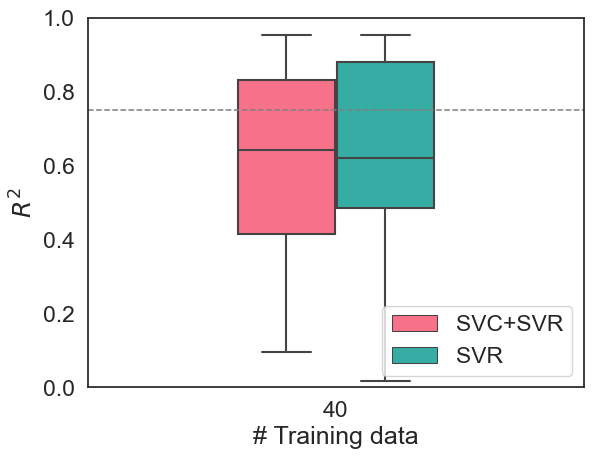

In [858]:
closeNewResult_badRound1 = ComparisonResultsListPlot([newSVMSVRr2List_close_H_badRound1[:], \
                                            newSVRr2List_close_H_badRound1[:]], 40, \
          xname = '# Training data', yname = '$R^2$', show = 1, \
          ylimit = [0, 1], yline = 0.75)

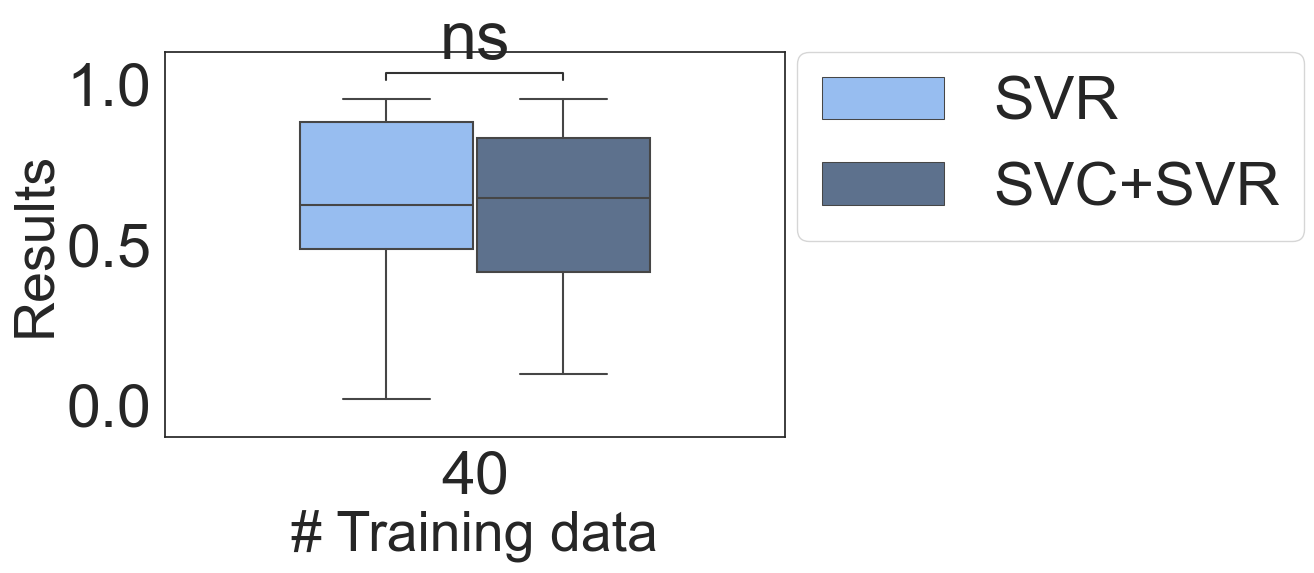

In [859]:
statsPlot(closeNewResult_badRound1, 'Mann-Whitney')
# t-test_paired, Mann-Whitney

## Assign first round of performance' properties

In [784]:
closeNewResult['New data location'] = 'Close'
closeNewResult['First round performance'] = 'Good'

In [785]:
closeNewResult['Active learning strategy'] = 'I'

In [786]:
closeNewResult

,Results,# Training data,Method,New data location,First round performance,Active learning strategy
0,0.752412,40,SVC+SVR,Close,Good,I
1,0.532825,40,SVC+SVR,Close,Good,I
2,0.651079,40,SVC+SVR,Close,Good,I
3,0.652815,40,SVC+SVR,Close,Good,I
4,0.683198,40,SVC+SVR,Close,Good,I
...,...,...,...,...,...,...
145,0.625459,40,SVR,Close,Good,I
146,0.356399,40,SVR,Close,Good,I
147,0.394338,40,SVR,Close,Good,I
148,0.782792,40,SVR,Close,Good,I


## Same, but for the data that generated poor performance

In [787]:
closeNewResult_badRound1['New data location'] = 'Close'
closeNewResult_badRound1['First round performance'] = 'Poor'

In [788]:
closeNewResult_badRound1

,Results,# Training data,Method,New data location,First round performance
0,0.025534,40,SVC+SVR,Close,Poor
1,0.786715,40,SVC+SVR,Close,Poor
2,0.296209,40,SVC+SVR,Close,Poor
3,0.177149,40,SVC+SVR,Close,Poor
4,0.321293,40,SVC+SVR,Close,Poor
...,...,...,...,...,...
70,0.287220,40,SVR,Close,Poor
71,0.369171,40,SVR,Close,Poor
72,0.788424,40,SVR,Close,Poor
73,0.508436,40,SVR,Close,Poor


In [789]:
GoodBadFrames = [closeNewResult, closeNewResult_badRound1]
GoodBadConcated = pd.concat(GoodBadFrames)

In [790]:
GoodBadConcated

,Results,# Training data,Method,New data location,First round performance,Active learning strategy
0,0.752412,40,SVC+SVR,Close,Good,I
1,0.532825,40,SVC+SVR,Close,Good,I
2,0.651079,40,SVC+SVR,Close,Good,I
3,0.652815,40,SVC+SVR,Close,Good,I
4,0.683198,40,SVC+SVR,Close,Good,I
...,...,...,...,...,...,...
70,0.287220,40,SVR,Close,Poor,NaN
71,0.369171,40,SVR,Close,Poor,NaN
72,0.788424,40,SVR,Close,Poor,NaN
73,0.508436,40,SVR,Close,Poor,NaN


In [791]:
def statsPlotForAL(toPlotDF, statesName='First round performance',statsTest = "Mann-Whitney", \
                   ylabel = 'Results', show = 1, limit = 0):

    states_order = list(set(list(toPlotDF[statesName])))
    states_order.sort()
    subcat_palette = sns.dark_palette("#8BF", reverse=True, n_colors=3)
    subcat_order = ['SVR', 'SVC+SVR']

    # Switching hue and x
    hue_plot_params = {
        'data':      toPlotDF,
        'x':         statesName,
        'y':         ylabel,
        "order":     states_order,
        "hue":       "Method",
        "hue_order": subcat_order,
        "palette":   subcat_palette
    }
    if len(states_order) == 4:
        pairs =(
            [(states_order[0], subcat_order[0]), (states_order[0], subcat_order[1])],

            [(states_order[1], subcat_order[0]), (states_order[1], subcat_order[1])],

            [(states_order[2], subcat_order[0]), (states_order[2], subcat_order[1])],

            [(states_order[3], subcat_order[0]), (states_order[3], subcat_order[1])],
        )
    elif len(states_order) == 3:
        pairs =(
            [(states_order[0], subcat_order[0]), (states_order[0], subcat_order[1])],

            [(states_order[1], subcat_order[0]), (states_order[1], subcat_order[1])],

            [(states_order[2], subcat_order[0]), (states_order[2], subcat_order[1])],
        )
    elif len(states_order) == 5:
        pairs =(
            [(states_order[0], subcat_order[0]), (states_order[0], subcat_order[1])],

            [(states_order[1], subcat_order[0]), (states_order[1], subcat_order[1])],

            [(states_order[2], subcat_order[0]), (states_order[2], subcat_order[1])],

            [(states_order[3], subcat_order[0]), (states_order[3], subcat_order[1])],

            [(states_order[4], subcat_order[0]), (states_order[4], subcat_order[1])],
        )
    elif len(states_order) == 1:
        pairs =(
            [(states_order[0], subcat_order[0]), (states_order[0], subcat_order[1])],
        )
    elif len(states_order) == 2:
        pairs =(
            [(states_order[0], subcat_order[0]), (states_order[0], subcat_order[1])],

            [(states_order[1], subcat_order[0]), (states_order[1], subcat_order[1])],
        )
    with sns.plotting_context("notebook", font_scale = 1.4):
        sns.set(font_scale = 4)
        sns.set_style("white")
        # Create new plot
        figsize = (8, 5)
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        # Plot with seaborn
        ax = sns.boxplot(ax=ax, **hue_plot_params)
        # Add stats annotations
        annotator = Annotator(ax, pairs, **hue_plot_params)
        annotator.configure(test = statsTest, verbose=False)
        _, results = annotator.apply_and_annotate()

        if show == 1:
            ax.set_xlabel(statesName, fontsize=40)
            ax.set_ylabel(ylabel, fontsize=40)
        else:
            ax.set_xlabel(" ")
            ax.set_ylabel(" ")

        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
        plt.ylim([-0.1, 1.1])
        plt.show()

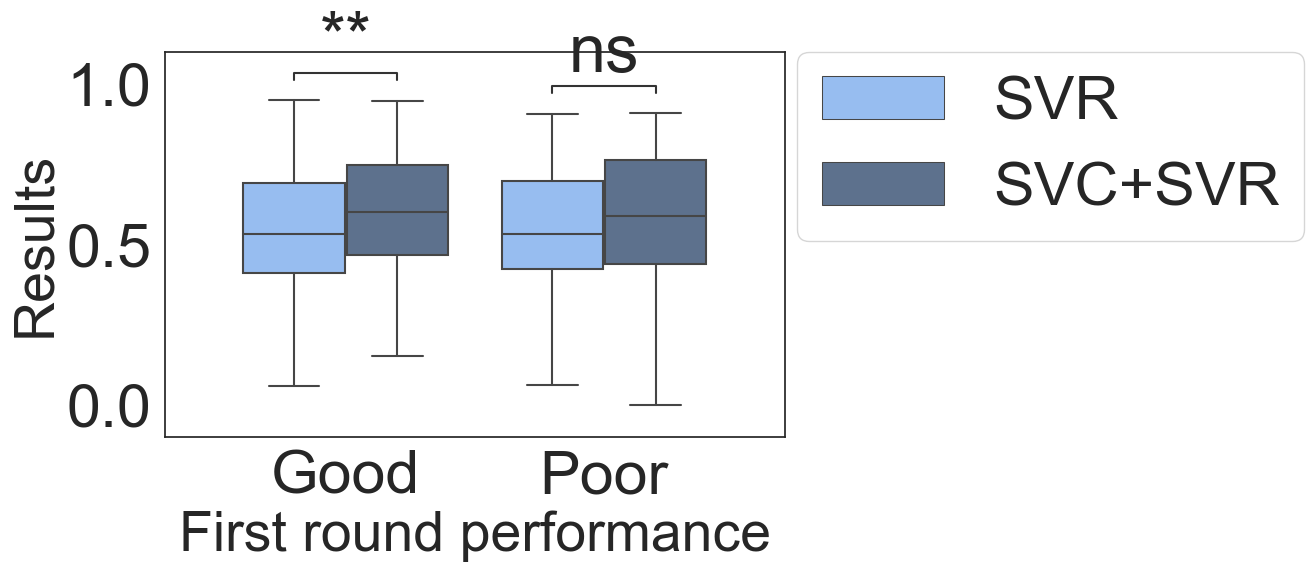

In [792]:
statsPlotForAL(GoodBadConcated, 'First round performance')

### Sample Furtherest points in the second round

In [842]:
# Started with n datapoints
round1_SVCSVR = round1UseDF[round1UseDF['Method'] == 'SVC+SVR']
round1_SVCSVR = round1_SVCSVR[round1_SVCSVR['# Training data'] == n]
round1_SVCSVR = round1_SVCSVR.reset_index(drop=True)

round1_SVR = round1UseDF[round1UseDF['Method'] == 'SVR']
round1_SVR = round1_SVR[round1_SVR['# Training data'] == n]
round1_SVR = round1_SVR.reset_index(drop=True)

comparisonList = round1_SVCSVR['Results'] - round1_SVR['Results']

topIndexList = \
sorted(range(len(comparisonList)), key=lambda i: comparisonList[i], reverse=True)[:roundTwoLength]
bottomIndexList = \
sorted(range(len(comparisonList)), key=lambda i: comparisonList[i], reverse=True)[-1*roundTwoLength:][::-1]

# Run here
newSVMSVRr2List_far_H = []
newSVRr2List_far_H = []

for i in range(roundTwoLength):
    topIndex = topIndexList[i]
    print(topIndex, comparisonList[topIndex])
    if comparisonList[topIndex] > 0.3:
        # Dataframe for the first round of training
        ori = processExcelFormat03('round3.xlsx', 'FinalTimePoint', 0.6)

        # Get the SVM machine
        topSVMModel = r2Recorder_02[n][topIndex][0]
        ## Apply it to the ori df
        # Transform ori df to scaled version first
        inputName = list(ori.columns)[:-2]
        sc_X = scXRecorder_02[n][topIndex]
        sc_density = scDensityRecorder_02[n][topIndex]
        featureScaler = sc_X.fit(ori[inputName].values)
        scaled_features = featureScaler.transform(ori[inputName].values)
        ori[inputName] = scaled_features

        # Apply SVM on the full set
        ori['FirstRoundPrediction'] = topSVMModel.decision_function(ori[inputName])

        # The previous n training data row
        originalTopTrainDFIndexTop = indexRecorder_02[n][topIndex]

        # Select pos by creating a new DF then selecting from there

        # Select pos by creating a new DF then selecting from there
        topSVMSVRfullDF_PosTemp = ori[ori['FirstRoundPrediction']>0]
        topSVMSVRfullDF_PosTemp = topSVMSVRfullDF_PosTemp.sort_values('FirstRoundPrediction')
        # No duplicates -- temp of temp
        topSVMSVRfullDF_PosTempT = topSVMSVRfullDF_PosTemp\
        [~topSVMSVRfullDF_PosTemp.index.isin(originalTopTrainDFIndexTop)]
        newData_IndexArrayTop_Pos = topSVMSVRfullDF_PosTempT.iloc[-10:].index

        # Select neg
        topSVMSVRfullDF_NegTemp = ori[ori['FirstRoundPrediction']<0]
        topSVMSVRfullDF_NegTemp = topSVMSVRfullDF_NegTemp.sort_values('FirstRoundPrediction', ascending=False)
        # No duplicates -- temp of temp
        topSVMSVRfullDF_NegTempT = topSVMSVRfullDF_NegTemp\
        [~topSVMSVRfullDF_NegTemp.index.isin(originalTopTrainDFIndexTop)]
        newData_IndexArrayTop_Neg = topSVMSVRfullDF_NegTempT.iloc[-10:].index
        
        # Combine the 2
        for j in range(3):
            allNew = list(set(list(newData_IndexArrayTop_Pos)+list(newData_IndexArrayTop_Neg)))
            if n > len(allNew):
                allNew_half = allNew
            else:
                allNew_half = random.sample(allNew, n)
            print(len(allNew_half))

            # Combine the 2
            final_IndexArrayTop_Far = allNew_half + \
            list(np.array(originalTopTrainDFIndexTop))


            # Get the new training & testing DF
            topSVMSVRnewTrainingDF = ori.loc[final_IndexArrayTop_Far]
            topSVMSVRnewTestingDF = ori[~ori.index.isin(final_IndexArrayTop_Far)]

            for k in range(5):
                # Run top once
                complexSVRSpearmanLists2D_02_neg, complexSVRPearsonLists2D_02_neg, \
                complexSVRR2Lists2D_02_neg, complexSVRMSELists2D_02_neg, \
                complexPredictedSVRSpearmanLists2D_02_neg, complexPredictedSVRPearsonLists2D_02_neg, \
                complexPredictedSVRR2Lists2D_02_neg, complexPredictedSVRMSELists2D_02_neg, \
                r2Recorder2D_02_neg, mseRecorder2D_02_neg, pearsonRecorder2D_02_neg, spearmanRecorder2D_02_neg, \
                SVRSpearmanLists2D_02_neg, SVRPearsonLists2D_02_neg, SVRR2Lists2D_02_neg, SVRMSELists2D_02_neg, \
                PredictedSVRSpearmanLists2D_02_neg, PredictedSVRPearsonLists2D_02_neg, \
                PredictedSVRR2Lists2D_02_neg, PredictedSVRMSELists2D_02_neg, \
                SVRr2Recorder2D_02_neg, SVRmseRecorder2D_02_neg, SVRpearsonRecorder2D_02_neg, SVRspearmanRecorder2D_02_neg,\
                indexRecorder2D_02_neg, TrainXDFRecorder2D_02_neg, TrainYDFRecorder2D_02_neg, \
                SVMSVRFullXDFRecorder2D_02_neg, SVMSVRFullYDFRecorder2D_02_neg, \
                scXRecorder2D_02_neg, scDensityRecorder2D_02_neg, scDistanceRecorder2D_02_neg = \
                ComparisonMultipleRun(1, 'round3.xlsx', 3, 'FinalTimePoint', [40], \
                                      final_IndexArrayTop_Far, ['poly', 'rbf'], 0.6)
                # Get the new r2 pair
                newSVMSVRr2 = complexSVRR2Lists2D_02_neg[0][0][1]
                newSVMSVRr2List_far_H.append(newSVMSVRr2)

                newSVRr2 = SVRR2Lists2D_02_neg[0][0][1]
                newSVRr2List_far_H.append(newSVRr2)

print(newSVMSVRr2List_far_H, newSVRr2List_far_H)


20 0.6609854469396321
20
40
[44, 21, 48, 47, 62, 46, 14, 15, 18, 63, 45, 17, 55, 0, 54, 5, 51, 50, 16, 53, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


SVC(C=100.0, degree=5, gamma='auto') {'kernel': 'rbf', 'gamma': 'auto', 'degree': 5, 'C': 100.0} 0.8
R2:  0.9568556121231345
MSE:  0.016962967018177597
Pearson:  0.9781899672983435
Spearman:  0.7857142857142858
R2:  0.9581307878798067
MSE:  0.016885255082800074
Pearson:  0.9788415540217972
Spearman:  0.7857142857142858
R2:  0.7051571311012301
MSE:  0.09287476930823917
Pearson:  0.8397363461832708
Spearman:  0.8095238095238096


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.0936338194625506, 0.5106606337425186, 0.24846361467906, 0.35913043478260864]
SVR:  [0.01802775427336181, 0.4535497874443162, 0.13426747287918178, 0.35913043478260864]
40
[44, 21, 48, 47, 62, 46, 14, 15, 18, 63, 45, 17, 55, 0, 54, 5, 51, 50, 16, 53, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(C=10000.0, degree=4, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 4, 'C': 10000.0} 0.875
R2:  0.9266283075839313
MSE:  0.04428385872078877
Pearson:  0.962615347677322
Spearman:  0.9285714285714287
R2:  0.9361392907636213
MSE:  0.02377501043034616
Pearson:  0.9675429141715739
Spearman:  0.7619047619047621
R2:  0.5466312728102013
MSE:  0.14859057460195468
Pearson:  0.7393451648656405
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9014172679406933, 0.32719640698165436, 0.9582904289616121, 0.8339130434782607]
SVR:  [0.898755769368949, 0.035607054568384554, 0.9480273041262837, 0.8791304347826084]
40
[44, 21, 48, 47, 62, 46, 14, 15, 18, 63, 45, 17, 55, 0, 54, 5, 51, 50, 16, 53, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(C=10000.0, degree=4, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 4, 'C': 10000.0} 0.875
R2:  0.20402461528586147
MSE:  0.4436151822623756
Pearson:  0.4516908403829565
Spearman:  0.6666666666666669
R2:  0.185333010638146
MSE:  0.4388328893414156
Pearson:  0.43050320630414135
Spearman:  0.7142857142857144
R2:  0.8021145163408903
MSE:  0.09137741279822006
Pearson:  0.8956084615170237
Spearman:  0.7857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8805173920061302, 0.2954940212187104, 0.9562925947499873, 0.8652173913043478]
SVR:  [0.34232762927758753, 0.3290447566152704, 0.5850877107559066, 0.8486956521739129]
40
[44, 21, 48, 47, 62, 46, 14, 15, 18, 63, 45, 17, 55, 0, 54, 5, 51, 50, 16, 53, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(C=1000.0, degree=5) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 5, 'C': 1000.0} 0.825
R2:  0.5435970630395097
MSE:  0.48778509678763865
Pearson:  0.7372903519235213
Spearman:  0.6190476190476191
R2:  0.4136541867579985
MSE:  0.3014618035849098
Pearson:  0.6431595344531547
Spearman:  0.8095238095238096
R2:  0.7380945006078417
MSE:  0.40242611768735725
Pearson:  0.8591242637755272
Spearman:  0.7857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5378688947012409, 0.31256884959455217, 0.303149733084778, 0.9008695652173913]
SVR:  [0.23607142480507184, 0.317717625791441, 0.4858718193156215, 0.36]
40
[44, 21, 48, 47, 62, 46, 14, 15, 18, 63, 45, 17, 55, 0, 54, 5, 51, 50, 16, 53, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(C=10000.0, degree=2, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 2, 'C': 10000.0} 0.875
R2:  0.2668037614364772
MSE:  0.3192947919720431
Pearson:  -0.5165305038780161
Spearman:  -0.07142857142857144
R2:  0.00035375256668710646
MSE:  0.47328660799958006
Pearson:  -0.01880831110671838
Spearman:  0.023809523809523815
R2:  0.22923136300795371
MSE:  0.3299060373893493
Pearson:  -0.47878112223431873
Spearman:  -0.07142857142857144


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4215131950118016, 0.11698057025871021, 0.10638420956057433, 0.8486956521739129]
SVR:  [0.9012128570088608, 0.04756918722724987, 0.9493223146059826, 0.8252173913043478]
20
40
[18, 47, 62, 15, 0, 14, 51, 50, 16, 63, 5, 45, 55, 46, 17, 54, 48, 21, 53, 44, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(C=100.0, degree=5) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 5, 'C': 100.0} 0.85
R2:  0.7898582251758196
MSE:  0.12113375643008939
Pearson:  0.8887396835833423
Spearman:  0.8571428571428572
R2:  0.2994895546212681
MSE:  0.4528906389694237
Pearson:  0.5472563883786721
Spearman:  0.4285714285714286
R2:  0.4269181602391159
MSE:  0.40012905866467363
Pearson:  0.653389746046811
Spearman:  0.6904761904761906


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8862374156499341, 0.30710644132158516, 0.5796400754061, 0.3313043478260869]
SVR:  [0.3474056555591352, 0.3266194316576563, 0.5894112787851411, 0.8486956521739129]
40
[18, 47, 62, 15, 0, 14, 51, 50, 16, 63, 5, 45, 55, 46, 17, 54, 48, 21, 53, 44, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(C=1000.0, degree=4, kernel='poly') {'kernel': 'poly', 'gamma': 'scale', 'degree': 4, 'C': 1000.0} 0.85
R2:  0.39715251196253765
MSE:  0.3170260199376267
Pearson:  0.6302003744544568
Spearman:  0.523809523809524
R2:  0.4821091842024775
MSE:  0.29304716013529425
Pearson:  0.6943408271176897
Spearman:  0.9285714285714287
R2:  0.9790127633030942
MSE:  0.010051094658392018
Pearson:  0.9894507381891704
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5067108718136321, 0.48356301479475433, 0.1410149921435928, 0.6582608695652173]
SVR:  [0.012417349993261972, 0.4525607286749789, 0.11143316379454538, 0.33826086956521734]
40
[18, 47, 62, 15, 0, 14, 51, 50, 16, 63, 5, 45, 55, 46, 17, 54, 48, 21, 53, 44, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(C=1000.0, degree=4, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 4, 'C': 1000.0} 0.875
R2:  0.8321615092837388
MSE:  0.1325788474337388
Pearson:  0.9122288689159858
Spearman:  0.4761904761904762
R2:  0.8546118308425797
MSE:  0.14483616421354262
Pearson:  0.9244521787753976
Spearman:  0.4761904761904762
R2:  0.9107813267557174
MSE:  0.039809185098516796
Pearson:  0.9543486400449874
Spearman:  0.6428571428571429


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5070912865530645, 0.3011502481423571, 0.20253893058851882, 0.8356521739130435]
SVR:  [0.3446321721117108, 0.2732512677388467, 0.5870538068283954, 0.5730434782608694]
40
[18, 47, 62, 15, 0, 14, 51, 50, 16, 63, 5, 45, 55, 46, 17, 54, 48, 21, 53, 44, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(C=1000.0, degree=2) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 2, 'C': 1000.0} 0.875
R2:  0.31723127107875004
MSE:  0.34948138327094397
Pearson:  0.5632328746431178
Spearman:  0.5476190476190477
R2:  0.49253988426230944
MSE:  0.272233203761519
Pearson:  0.7018118581659256
Spearman:  0.6904761904761906
R2:  0.49480304443050416
MSE:  0.27017828744893435
Pearson:  0.703422379819198
Spearman:  0.6904761904761906


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.062447322371238866, 0.35820644341889557, 0.8065187406536355, 0.32695652173913037]
SVR:  [0.33835196462684713, 0.3178627466692386, 0.5816802941709881, 0.8486956521739129]
40
[18, 47, 62, 15, 0, 14, 51, 50, 16, 63, 5, 45, 55, 46, 17, 54, 48, 21, 53, 44, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(C=100.0, degree=2, gamma='auto') {'kernel': 'rbf', 'gamma': 'auto', 'degree': 2, 'C': 100.0} 0.85
R2:  0.7062213525826663
MSE:  0.2670832197244844
Pearson:  0.8403697713403703
Spearman:  0.9047619047619048
R2:  0.7049952300219097
MSE:  0.12508303100045234
Pearson:  0.8396399407019117
Spearman:  0.8095238095238096
R2:  0.982205200291895
MSE:  0.018808638221957618
Pearson:  0.9910626621419533
Spearman:  0.9523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.39233787349015947, 0.16291239581681882, 0.28496552555308197, 0.4243478260869564]
SVR:  [0.0861600521908124, 0.4336642615315469, 0.2935303258452393, 0.3643478260869565]
20
40
[44, 15, 47, 63, 17, 14, 53, 51, 18, 45, 50, 21, 55, 16, 48, 0, 62, 5, 54, 46, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(C=10.0, degree=5, kernel='poly') {'kernel': 'poly', 'gamma': 'scale', 'degree': 5, 'C': 10.0} 0.7
R2:  0.639197738257052
MSE:  0.15734450019293358
Pearson:  0.799498429177351
Spearman:  0.7619047619047621
R2:  0.9226836923969147
MSE:  0.04730280741851146
Pearson:  0.9605642572971966
Spearman:  0.8333333333333335
R2:  0.6855735004366568
MSE:  0.14586574775846273
Pearson:  0.8279936596596961
Spearman:  0.6190476190476191


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.42208837349561046, 0.1811787870251722, 0.5795499395756095, 0.8521739130434782]
SVR:  [0.373306852712918, 0.21785911555000018, 0.6109884227323119, 0.8069565217391305]
40
[44, 15, 47, 63, 17, 14, 53, 51, 18, 45, 50, 21, 55, 16, 48, 0, 62, 5, 54, 46, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(C=1000.0, degree=5) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 5, 'C': 1000.0} 0.85
R2:  0.3252195156205474
MSE:  0.4064818167113375
Pearson:  0.570280207985993
Spearman:  0.6190476190476191
R2:  0.4669647808994341
MSE:  0.2050883679548805
Pearson:  0.6833482135042382
Spearman:  0.6190476190476191
R2:  0.4717753020681047
MSE:  0.19965352060474123
Pearson:  0.686859011783426
Spearman:  0.6190476190476191


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.06065562596643063, 0.37610233668896553, 0.24313343749435032, 0.8339130434782607]
SVR:  [0.12729038382046218, 0.31261366388490247, 0.35677777932553795, 0.3321739130434782]
40
[44, 15, 47, 63, 17, 14, 53, 51, 18, 45, 50, 21, 55, 16, 48, 0, 62, 5, 54, 46, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(C=1000.0, degree=5, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 5, 'C': 1000.0} 0.875
R2:  0.8417560061043066
MSE:  0.043241090779964936
Pearson:  0.9174726187218377
Spearman:  0.7142857142857144
R2:  0.718026026318287
MSE:  0.14698592037169017
Pearson:  0.8473641639332452
Spearman:  0.7142857142857144
R2:  0.7436231785866215
MSE:  0.1576335572263572
Pearson:  0.8623358850161703
Spearman:  0.7142857142857144


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.3219498238870708, 0.3184700164812094, 0.38696440743542115, 0.8339130434782607]
SVR:  [0.3351669488309353, 0.3087536480737832, 0.5789360489993134, 0.8486956521739129]
40
[44, 15, 47, 63, 17, 14, 53, 51, 18, 45, 50, 21, 55, 16, 48, 0, 62, 5, 54, 46, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(C=1000.0, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 3, 'C': 1000.0} 0.875
R2:  0.2979908408494491
MSE:  0.20875134014755387
Pearson:  0.5458853733609732
Spearman:  0.5476190476190477
R2:  0.903432978739182
MSE:  0.18245985771106038
Pearson:  0.9504909146010719
Spearman:  0.7380952380952381
R2:  0.9414169107237763
MSE:  0.026884056500019262
Pearson:  0.9702664122413884
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4659126434683222, 0.4245374764377199, 0.9472983248528386, 0.7052173913043478]
SVR:  [0.32215165437221494, 0.30806781567450775, 0.5675840504913922, 0.8156521739130433]
40
[44, 15, 47, 63, 17, 14, 53, 51, 18, 45, 50, 21, 55, 16, 48, 0, 62, 5, 54, 46, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(C=10000.0, degree=5, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 5, 'C': 10000.0} 0.825
R2:  0.9433667603336676
MSE:  0.019797691512449894
Pearson:  0.9712706936450143
Spearman:  0.9047619047619048
R2:  0.6982386469623815
MSE:  0.10837498731337729
Pearson:  0.8356067537797798
Spearman:  0.9285714285714287
R2:  0.4888992273562676
MSE:  0.17133132084536049
Pearson:  0.6992132917474236
Spearman:  0.8571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.31598605272763686, 0.30401868765722134, 0.5789242673867859, 0.8391304347826085]
SVR:  [0.8922535228193129, 0.03627860325669192, 0.9445917228196068, 0.8895652173913042]
15 0.6584476271023618
20
40
[21, 54, 5, 13, 27, 22, 37, 14, 38, 62, 17, 11, 18, 0, 33, 23, 4, 46, 39, 29, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(C=0.01, gamma=10.0, kernel='poly') {'kernel': 'poly', 'gamma': 10.0, 'degree': 3, 'C': 0.01} 0.85
R2:  0.21396473284321668
MSE:  0.4508799945885724
Pearson:  0.46256322037448755
Spearman:  0.5000000000000001
R2:  0.19209889235031777
MSE:  0.5686359230644238
Pearson:  0.4382908764169267
Spearman:  0.19047619047619052
R2:  0.1784743843550723
MSE:  0.6386358544946175
Pearson:  0.4224622874944842
Spearman:  0.19047619047619052


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.12941051543838977, 0.17765190333405698, 0.42723731002882387, 0.8234782608695651]
SVR:  [0.15190714172367423, 0.405126464923893, 0.38975266737210956, 0.48086956521739127]
40
[21, 54, 5, 13, 27, 22, 37, 14, 38, 62, 17, 11, 18, 0, 33, 23, 4, 46, 39, 29, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(C=100.0, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 3, 'C': 100.0} 0.8
R2:  0.8188858902559212
MSE:  0.07170887867231811
Pearson:  0.9049231405240562
Spearman:  0.7380952380952381
R2:  0.925710101031843
MSE:  0.02494702918536368
Pearson:  0.9621382962089404
Spearman:  0.7380952380952381
R2:  0.9121125313201696
MSE:  0.032093252302749085
Pearson:  0.9550458268167922
Spearman:  0.7380952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5734555747369651, 0.19729593984701144, 0.7630606996881186, 0.7999999999999999]
SVR:  [0.15194572627713404, 0.4050707490642913, 0.3898021629969927, 0.48086956521739127]
40
[21, 54, 5, 13, 27, 22, 37, 14, 38, 62, 17, 11, 18, 0, 33, 23, 4, 46, 39, 29, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(C=10000.0, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 3, 'C': 10000.0} 0.875
R2:  0.1787748565534852
MSE:  0.2612935013514027
Pearson:  0.4228177580867261
Spearman:  0.4523809523809524
R2:  0.2749022842882874
MSE:  0.35799654098633904
Pearson:  0.5243112475317382
Spearman:  0.19047619047619052
R2:  0.605632959501712
MSE:  0.16915333184931808
Pearson:  0.7782242347175474
Spearman:  0.7380952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.1182548756713629, 0.40363103244416537, 0.43902870149723733, 0.48086956521739127]
SVR:  [0.5764438355501573, 0.1535074845031496, 0.7592389844773231, 0.7052173913043478]
40
[21, 54, 5, 13, 27, 22, 37, 14, 38, 62, 17, 11, 18, 0, 33, 23, 4, 46, 39, 29, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(C=10000.0, degree=4) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 4, 'C': 10000.0} 0.8
R2:  0.5750262569748508
MSE:  0.1986082034222786
Pearson:  0.7583048575440163
Spearman:  0.8571428571428572
R2:  0.5668124498572576
MSE:  0.21073278494361047
Pearson:  0.7528694773048367
Spearman:  0.8571428571428572
R2:  0.5108440858486887
MSE:  0.2117533517629139
Pearson:  0.7147335768303382
Spearman:  0.7857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.3233488799615654, 0.38259176416167073, 0.6174047684746022, 0.7452173913043478]
SVR:  [0.46519420447203574, 0.2071510682842903, 0.6820514676122583, 0.5817391304347826]
40
[21, 54, 5, 13, 27, 22, 37, 14, 38, 62, 17, 11, 18, 0, 33, 23, 4, 46, 39, 29, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(gamma='auto', kernel='poly') {'kernel': 'poly', 'gamma': 'auto', 'degree': 3, 'C': 1.0} 0.75
R2:  0.6277557529363532
MSE:  0.1537465804023304
Pearson:  0.7923103892644305
Spearman:  0.6904761904761906
R2:  0.6301683165806727
MSE:  0.22911647296748472
Pearson:  0.7938314157178923
Spearman:  0.6666666666666669
R2:  0.5303917658848688
MSE:  0.17058629455696936
Pearson:  0.7282800051387304
Spearman:  0.5000000000000001


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.12695747675850852, 0.4329421923070143, 0.3678612437513895, 0.677391304347826]
SVR:  [0.4714071925075728, 0.17779065550847595, 0.6865909936108779, 0.6365217391304347]
20
40
[17, 14, 21, 5, 38, 18, 37, 54, 0, 4, 23, 62, 13, 46, 27, 33, 39, 29, 11, 22, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(C=10000.0, degree=2, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 2, 'C': 10000.0} 0.875
R2:  0.31779053018301745
MSE:  0.338768786110357
Pearson:  0.5637291283790624
Spearman:  0.8333333333333335
R2:  0.32763410939091425
MSE:  0.3467946202086777
Pearson:  0.5723933170390044
Spearman:  0.8333333333333335
R2:  0.35928901775896666
MSE:  0.3112811423853577
Pearson:  0.5994072219776524
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.19286647837912152, 0.42380379060059087, 0.7857337907684878, 0.577391304347826]
SVR:  [0.1199021847468189, 0.6050505673211638, 0.3462689485743978, 0.37652173913043474]
40
[17, 14, 21, 5, 38, 18, 37, 54, 0, 4, 23, 62, 13, 46, 27, 33, 39, 29, 11, 22, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(C=1000.0, degree=5, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 5, 'C': 1000.0} 0.875
R2:  0.3171650176925439
MSE:  0.3949359598328677
Pearson:  0.5631740563027949
Spearman:  0.8095238095238096
R2:  0.3918413453560314
MSE:  0.1864029850999214
Pearson:  0.6259723199599415
Spearman:  0.5476190476190477
R2:  0.389473378928511
MSE:  0.28668175861326883
Pearson:  0.6240780231097
Spearman:  0.5476190476190477


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.17203558409923544, 0.5022265694738657, 0.6337221299358315, 0.46086956521739125]
SVR:  [0.15189498199856002, 0.4052959672796465, 0.38973706777590456, 0.48086956521739127]
40
[17, 14, 21, 5, 38, 18, 37, 54, 0, 4, 23, 62, 13, 46, 27, 33, 39, 29, 11, 22, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(C=100.0, degree=5, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 5, 'C': 100.0} 0.75
R2:  0.18736489096713033
MSE:  0.5306612362920249
Pearson:  0.43285666330452904
Spearman:  0.3333333333333334
R2:  0.35501098421553523
MSE:  0.29863364441451684
Pearson:  0.5958279820682604
Spearman:  0.5476190476190477
R2:  0.6474129638453794
MSE:  0.3677276957258127
Pearson:  0.8046197635190051
Spearman:  0.5476190476190477


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5045630504306371, 0.38257092483109173, 0.6284106874434883, 0.7852173913043478]
SVR:  [0.6179981655502516, 0.12683715169722035, 0.7861285935203296, 0.6643478260869564]
40
[17, 14, 21, 5, 38, 18, 37, 54, 0, 4, 23, 62, 13, 46, 27, 33, 39, 29, 11, 22, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(C=1000.0, kernel='poly') {'kernel': 'poly', 'gamma': 'scale', 'degree': 3, 'C': 1000.0} 0.875
R2:  0.9487041677447277
MSE:  0.03069465509649596
Pearson:  0.9740144597205564
Spearman:  0.9285714285714287
R2:  0.2233351019795352
MSE:  0.34266351907561876
Pearson:  0.47258343388182295
Spearman:  0.4047619047619048
R2:  0.5997922789440755
MSE:  0.153818127110029
Pearson:  0.7744625742694577
Spearman:  0.8095238095238096


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.27080613000476095, 0.2600439496160654, 0.34668742887412074, 0.46086956521739125]
SVR:  [0.06269319937237441, 0.46755776561187073, 0.2503861005974062, 0.3956521739130434]
40
[17, 14, 21, 5, 38, 18, 37, 54, 0, 4, 23, 62, 13, 46, 27, 33, 39, 29, 11, 22, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(C=0.1, gamma=10.0, kernel='poly') {'kernel': 'poly', 'gamma': 10.0, 'degree': 3, 'C': 0.1} 0.875
R2:  0.18915086022588048
MSE:  0.40596667700755007
Pearson:  0.43491477351991686
Spearman:  0.28571428571428575
R2:  0.18374667799756983
MSE:  0.45013740189515133
Pearson:  0.4286568301072198
Spearman:  0.28571428571428575
R2:  0.18417146499654524
MSE:  0.42233661623709606
Pearson:  0.42915203016710207
Spearman:  0.28571428571428575


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.12971994215331453, 0.396281199127724, 0.6867836407126693, 0.4765217391304347]
SVR:  [0.43599082276547146, 0.22622725130454338, 0.6602960114717276, 0.5104347826086956]
20
40
[39, 13, 38, 17, 21, 54, 5, 62, 14, 18, 11, 27, 46, 29, 33, 37, 4, 22, 23, 0, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(C=100.0, degree=2) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 2, 'C': 100.0} 0.775
R2:  0.9006611331821068
MSE:  0.03771723036330994
Pearson:  0.9490316818642603
Spearman:  0.8333333333333335
R2:  0.9754188563683063
MSE:  0.024053257389880546
Pearson:  0.9876329562992048
Spearman:  1.0
R2:  0.9716647439207903
MSE:  0.02407681953291674
Pearson:  0.9857305635521252
Spearman:  0.9285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.36418602579615056, 0.4033336221111146, 0.6501847519356174, 0.48086956521739127]
SVR:  [0.13104859190323068, 0.43290344487140947, 0.36200634235221735, 0.47043478260869553]
40
[39, 13, 38, 17, 21, 54, 5, 62, 14, 18, 11, 27, 46, 29, 33, 37, 4, 22, 23, 0, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(C=100.0, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 3, 'C': 100.0} 0.825
R2:  0.2963118618539292
MSE:  0.17526504116190286
Pearson:  0.5443453516417028
Spearman:  0.6190476190476191
R2:  0.6947227645862367
MSE:  0.0728622259111276
Pearson:  0.8335003086899468
Spearman:  0.2380952380952381
R2:  0.4950499892188984
MSE:  0.13417434020724223
Pearson:  0.7035978888675678
Spearman:  0.6190476190476191


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.19484101939492915, 0.33652469395845025, 0.4134449815348762, 0.48086956521739127]
SVR:  [0.5066413188152395, 0.1594144848671917, 0.7117874112508873, 0.6634782608695651]
40
[39, 13, 38, 17, 21, 54, 5, 62, 14, 18, 11, 27, 46, 29, 33, 37, 4, 22, 23, 0, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC() {'kernel': 'rbf', 'gamma': 'scale', 'degree': 3, 'C': 1.0} 0.75
R2:  0.6003370494404925
MSE:  0.15744615775936077
Pearson:  0.7748142031742141
Spearman:  0.7619047619047621
R2:  0.4072040343800032
MSE:  0.2673223640982639
Pearson:  0.6381254064680413
Spearman:  0.7142857142857144
R2:  0.4082080539910997
MSE:  0.2649539159040355
Pearson:  0.6389116167288709
Spearman:  0.7142857142857144


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.15028172481947152, 0.4082393933330016, 0.298565329340977, 0.477391304347826]
SVR:  [0.07717271281825491, 0.4337556566619532, 0.27779977109107723, 0.437391304347826]
40
[39, 13, 38, 17, 21, 54, 5, 62, 14, 18, 11, 27, 46, 29, 33, 37, 4, 22, 23, 0, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(C=10000.0, degree=2) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 2, 'C': 10000.0} 0.75
R2:  0.6548607091450652
MSE:  0.10624479861201439
Pearson:  0.8092346440588569
Spearman:  0.2380952380952381
R2:  0.6502206049380492
MSE:  0.11200985652765787
Pearson:  0.8063625765981761
Spearman:  0.2380952380952381
R2:  0.8831591870812467
MSE:  0.25180983760048253
Pearson:  0.9397654957920336
Spearman:  0.3333333333333334


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.1578849509479498, 0.3854367349168168, 0.25000625623947625, 0.7121739130434783]
SVR:  [0.3228313422769743, 0.2604125232568146, 0.5681824902942492, 0.7452173913043478]
40
[39, 13, 38, 17, 21, 54, 5, 62, 14, 18, 11, 27, 46, 29, 33, 37, 4, 22, 23, 0, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(C=10.0, degree=2, gamma=0.1, kernel='poly') {'kernel': 'poly', 'gamma': 0.1, 'degree': 2, 'C': 10.0} 0.75
R2:  0.48964945582682007
MSE:  0.28979753975060274
Pearson:  0.699749566507061
Spearman:  0.7142857142857144
R2:  0.8885619740286852
MSE:  0.12874409807821938
Pearson:  0.9426356528525138
Spearman:  0.6190476190476191
R2:  0.44885981347518056
MSE:  0.24310481825096297
Pearson:  0.6699700093848834
Spearman:  0.6190476190476191


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.012185679719944546, 0.5369177485246074, 0.2016906948576448, 0.8643478260869566]
SVR:  [0.15187553007760637, 0.40521904559551564, 0.38971211179229026, 0.48086956521739127]
14 0.5817365754139048
20
40
[34, 33, 36, 47, 14, 62, 38, 48, 46, 54, 29, 17, 28, 22, 37, 0, 45, 44, 12, 18, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(C=10000.0, degree=2, gamma=0.0001) {'kernel': 'rbf', 'gamma': 0.0001, 'degree': 2, 'C': 10000.0} 0.825
R2:  0.4700072581242035
MSE:  0.2433035929916983
Pearson:  0.685570753550794
Spearman:  0.3571428571428572
R2:  0.9628567053947445
MSE:  0.017426698520440303
Pearson:  0.98125262057981
Spearman:  0.2142857142857143
R2:  0.9465612617653905
MSE:  0.08971416862794188
Pearson:  0.9729137997610016
Spearman:  0.1666666666666667


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.025270936184644384, 0.41302976515288803, 0.41739432318838526, 0.82]
SVR:  [0.15798109739382418, 0.5579588174794633, 0.39746836024245275, 0.657391304347826]
40
[34, 33, 36, 47, 14, 62, 38, 48, 46, 54, 29, 17, 28, 22, 37, 0, 45, 44, 12, 18, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(C=10000.0, degree=2, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 2, 'C': 10000.0} 0.925
R2:  0.4756884992738606
MSE:  0.15225890393763628
Pearson:  0.6897017466078077
Spearman:  0.7619047619047621
R2:  0.4742000778033107
MSE:  0.15230965307552566
Pearson:  0.6886218685195167
Spearman:  0.4523809523809524
R2:  0.47505863588012526
MSE:  0.15345189220283226
Pearson:  0.6892449752302334
Spearman:  0.7619047619047621


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.19224805044711976, 0.5767732478889717, 0.4138399059219081, 0.2969422324981642]
SVR:  [0.15798109739382418, 0.5579588174794633, 0.39746836024245275, 0.657391304347826]
40
[34, 33, 36, 47, 14, 62, 38, 48, 46, 54, 29, 17, 28, 22, 37, 0, 45, 44, 12, 18, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(C=100.0, degree=4, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 4, 'C': 100.0} 0.875
R2:  0.9315598460595061
MSE:  0.03405776585066995
Pearson:  0.9651734797742351
Spearman:  0.9285714285714287
R2:  0.9905455445667057
MSE:  0.005446302062706888
Pearson:  0.995261545809294
Spearman:  0.8333333333333335
R2:  0.9909882229168042
MSE:  0.00500355269841558
Pearson:  0.9954839139417596
Spearman:  0.8095238095238096


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.14061687834687436, 0.32222817920190433, 0.28887161914114806, 0.6895652173913043]
SVR:  [0.08312471119662757, 0.2641420827903612, 0.28831356401776803, 0.37913043478260866]
40
[34, 33, 36, 47, 14, 62, 38, 48, 46, 54, 29, 17, 28, 22, 37, 0, 45, 44, 12, 18, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(C=10000.0, degree=5, kernel='poly') {'kernel': 'poly', 'gamma': 'scale', 'degree': 5, 'C': 10000.0} 0.85
R2:  0.5716950654805016
MSE:  0.1568157205681608
Pearson:  0.756105194718633
Spearman:  0.880952380952381
R2:  0.6156959189549335
MSE:  0.20486613380449614
Pearson:  0.7846629333382159
Spearman:  0.5000000000000001
R2:  0.579759387068943
MSE:  0.15393549289227806
Pearson:  0.7614193240711342
Spearman:  0.7857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.18163701334009355, 0.6043005149452961, 0.42426649859551746, 0.46086956521739125]
SVR:  [0.17863984970283828, 0.5839952072298282, 0.4226580765853626, 0.577391304347826]
40
[34, 33, 36, 47, 14, 62, 38, 48, 46, 54, 29, 17, 28, 22, 37, 0, 45, 44, 12, 18, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(C=10.0, gamma=1.0, kernel='poly') {'kernel': 'poly', 'gamma': 1.0, 'degree': 3, 'C': 10.0} 0.875
R2:  0.9445562359060079
MSE:  0.029373371875980485
Pearson:  0.9718828303381061
Spearman:  0.6666666666666669
R2:  0.6602952691832509
MSE:  0.16240066704020548
Pearson:  0.8125855457631836
Spearman:  0.6666666666666669
R2:  0.658452607462315
MSE:  0.1696682587065355
Pearson:  0.81145092732852
Spearman:  0.5952380952380953


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.03008160192789904, 0.5898933562176726, 0.12955095916163437, 0.6304347826086956]
SVR:  [0.21276443614641158, 0.4044947491292585, 0.4612639549611606, 0.42]
20
40
[44, 46, 48, 29, 38, 22, 18, 28, 54, 45, 14, 0, 17, 37, 36, 33, 12, 34, 47, 62, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(C=1000.0, degree=4, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 4, 'C': 1000.0} 0.9
R2:  0.37508343795088184
MSE:  0.2692476490824084
Pearson:  0.6124405587082571
Spearman:  0.5952380952380953
R2:  0.3969028432560791
MSE:  0.3142821863595464
Pearson:  0.6300022565484025
Spearman:  0.6190476190476191
R2:  0.39067496740786134
MSE:  0.2923629342555365
Pearson:  0.6250399726480389
Spearman:  0.6904761904761906


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.16668021977339553, 0.5638730428107402, 0.42925650198544585, 0.12347826086956522]
SVR:  [0.15697309742698873, 0.5682167537746594, 0.39619830568414693, 0.6286956521739131]
40
[44, 46, 48, 29, 38, 22, 18, 28, 54, 45, 14, 0, 17, 37, 36, 33, 12, 34, 47, 62, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(C=100.0, degree=2, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 2, 'C': 100.0} 0.85
R2:  0.6381137391052246
MSE:  0.17613349540387635
Pearson:  0.7988202170108267
Spearman:  0.6190476190476191
R2:  0.6932109745969639
MSE:  0.16086371918684422
Pearson:  0.8325929224999236
Spearman:  0.8095238095238096
R2:  0.9927030689840091
MSE:  0.010187932698395491
Pearson:  0.9963448544474993
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.09205451485293213, 0.3028058002782501, 0.3777003087754758, 0.4834782608695652]
SVR:  [0.15938900965858352, 0.5483768084206159, 0.3992355315582314, 0.6721739130434782]
40
[44, 46, 48, 29, 38, 22, 18, 28, 54, 45, 14, 0, 17, 37, 36, 33, 12, 34, 47, 62, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(C=100.0, degree=4, gamma='auto') {'kernel': 'rbf', 'gamma': 'auto', 'degree': 4, 'C': 100.0} 0.875
R2:  0.9816297997655364
MSE:  0.007282914106705226
Pearson:  0.9907723248887892
Spearman:  0.523809523809524
R2:  0.9865639236853266
MSE:  0.006341374596177678
Pearson:  0.9932592429397906
Spearman:  0.8333333333333335
R2:  0.9208472858381395
MSE:  0.029552178985400836
Pearson:  0.959607881292218
Spearman:  0.5952380952380953


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.1397421938267843, 0.24891506795928245, 0.3744868374166019, 0.7530434782608695]
SVR:  [0.1922258536987764, 0.5759599431038351, 0.43843568935338334, 0.7078260869565216]
40
[44, 46, 48, 29, 38, 22, 18, 28, 54, 45, 14, 0, 17, 37, 36, 33, 12, 34, 47, 62, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(C=10000.0, degree=4, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 4, 'C': 10000.0} 0.925
R2:  0.4454129779069657
MSE:  0.32510734474063996
Pearson:  0.667392671451347
Spearman:  0.7857142857142858
R2:  0.45276310361264877
MSE:  0.3207727559598951
Pearson:  0.6728767373097755
Spearman:  0.7619047619047621
R2:  0.4228314655194531
MSE:  0.2733111118645958
Pearson:  0.6502549234872836
Spearman:  0.4285714285714286


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.11082835403568492, 0.6025954750389302, 0.43729537654567474, 0.7921739130434783]
SVR:  [0.20521514929654577, 0.5851910818999037, 0.45300678725218424, 0.7078260869565216]
40
[44, 46, 48, 29, 38, 22, 18, 28, 54, 45, 14, 0, 17, 37, 36, 33, 12, 34, 47, 62, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(C=1000.0, degree=2, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 2, 'C': 1000.0} 0.9
R2:  0.9688455031882862
MSE:  0.011790239273724083
Pearson:  0.9842994987239839
Spearman:  0.4761904761904762
R2:  0.9604219347235192
MSE:  0.020984628787000324
Pearson:  0.9800111911215703
Spearman:  0.4761904761904762
R2:  0.7321967422365451
MSE:  0.0795006775104737
Pearson:  0.8556849550135524
Spearman:  0.6190476190476191


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.0762655023978375, 0.5872161646779926, 0.3759156003569515, 0.12347826086956522]
SVR:  [0.5145796537650884, 0.16332934479333763, 0.7173420758362695, 0.5321739130434783]
20
40
[47, 37, 45, 46, 12, 29, 62, 38, 48, 18, 0, 33, 22, 54, 34, 36, 14, 44, 17, 28, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(C=10000.0, degree=2, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 2, 'C': 10000.0} 0.9
R2:  0.9464758016012474
MSE:  0.019065978334211094
Pearson:  0.9728698790697798
Spearman:  0.5000000000000001
R2:  0.9549134439308313
MSE:  0.01445322650565134
Pearson:  0.9771967273434923
Spearman:  0.28571428571428575
R2:  0.9562716037172223
MSE:  0.013860874757548974
Pearson:  0.9778914069145014
Spearman:  0.261904761904762


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.190700316578439, 0.5660467903111165, 0.23271109024192985, 0.537391304347826]
SVR:  [0.04588534529127013, 0.3463818004789827, 0.21420864896467215, 0.4321739130434783]
40
[47, 37, 45, 46, 12, 29, 62, 38, 48, 18, 0, 33, 22, 54, 34, 36, 14, 44, 17, 28, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(C=1000.0, degree=2, gamma='auto') {'kernel': 'rbf', 'gamma': 'auto', 'degree': 2, 'C': 1000.0} 0.9
R2:  0.7994376383383617
MSE:  0.16813244596554405
Pearson:  0.8941127660079357
Spearman:  -0.07142857142857144
R2:  0.9380509419962081
MSE:  0.014998076165280008
Pearson:  0.9685302999887035
Spearman:  0.6190476190476191
R2:  0.7808310489539041
MSE:  0.14576477979216057
Pearson:  0.8836464502016088
Spearman:  0.2380952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.20097654966867906, 0.5219295902577841, 0.6403752387349111, 0.7382608695652173]
SVR:  [0.19247162429503847, 0.5768112334642826, 0.4387158810608962, 0.7078260869565216]
40
[47, 37, 45, 46, 12, 29, 62, 38, 48, 18, 0, 33, 22, 54, 34, 36, 14, 44, 17, 28, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(C=10000.0, degree=4) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 4, 'C': 10000.0} 0.85
R2:  0.5166714883074108
MSE:  0.2006489063999276
Pearson:  0.7187986423939674
Spearman:  0.6428571428571429
R2:  0.6145372436501257
MSE:  0.15981007948282744
Pearson:  0.7839242588733466
Spearman:  0.6831300510639733
R2:  0.8406608619941726
MSE:  0.30640827144419125
Pearson:  0.9168755978834711
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.2011027870149155, 0.34581864678693935, 0.4484448539284574, 0.6617391304347826]
SVR:  [0.15984960252602845, 0.5210650629771044, 0.39981195895824384, 0.8069565217391305]
40
[47, 37, 45, 46, 12, 29, 62, 38, 48, 18, 0, 33, 22, 54, 34, 36, 14, 44, 17, 28, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(C=0.01, gamma=10.0, kernel='poly') {'kernel': 'poly', 'gamma': 10.0, 'degree': 3, 'C': 0.01} 0.9
R2:  0.1315513032589443
MSE:  0.6042007471894736
Pearson:  0.362700018278114
Spearman:  0.1666666666666667
R2:  0.6656242081659078
MSE:  0.1553025430498629
Pearson:  0.8158579583272495
Spearman:  0.6904761904761906
R2:  0.6760326829433284
MSE:  0.15775795502168322
Pearson:  0.8222120668923122
Spearman:  0.7619047619047621


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.1741739858430581, 0.5800142532283462, 0.2641288211178857, 0.6217391304347826]
SVR:  [0.19247162429503847, 0.5768112334642826, 0.4387158810608962, 0.7078260869565216]
40
[47, 37, 45, 46, 12, 29, 62, 38, 48, 18, 0, 33, 22, 54, 34, 36, 14, 44, 17, 28, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(C=10000.0, degree=4, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 4, 'C': 10000.0} 0.925
R2:  0.11339591328846636
MSE:  1.0030564271324407
Pearson:  0.33674309686831944
Spearman:  0.4285714285714286
R2:  0.9601351290979735
MSE:  0.02069247407648
Pearson:  0.9798648524658767
Spearman:  0.6428571428571429
R2:  0.9631616287052025
MSE:  0.020867649099966405
Pearson:  0.9814079828008343
Spearman:  0.6666666666666669


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.1905816264095299, 0.20352375544969373, 0.4365565557972185, 0.5321739130434783]
SVR:  [0.1580598901044749, 0.5575624756600898, 0.39756746610415056, 0.657391304347826]
26 0.5757938263956837
15
40
[12, 46, 14, 48, 47, 50, 51, 15, 53, 54, 55, 58, 28, 29, 62, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(C=10000.0, degree=2, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 2, 'C': 10000.0} 0.8571428571428571
R2:  0.2945232711433013
MSE:  0.25640123519550523
Pearson:  0.5426999826269588
Spearman:  0.7142857142857144
R2:  0.45230342291081455
MSE:  0.307507671925683
Pearson:  0.6725350718816192
Spearman:  0.5357142857142858
R2:  0.5435194765734753
MSE:  0.4176198829081997
Pearson:  0.737237734094963
Spearman:  0.8571428571428573


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.21807574758454132, 0.3232342929060273, 0.6918647182742494, 0.24581280788177334]
SVR:  [0.3551017122679007, 0.207853785314322, 0.5959041133168159, 0.6684729064039406]
40
[12, 46, 14, 48, 47, 50, 51, 15, 53, 54, 55, 58, 28, 29, 62, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(C=1000.0, gamma=1.0, kernel='poly') {'kernel': 'poly', 'gamma': 1.0, 'degree': 3, 'C': 1000.0} 0.7428571428571429
R2:  0.7831188135763175
MSE:  0.3886420777207019
Pearson:  0.8849400056367196
Spearman:  0.7857142857142859
R2:  0.2742557992835537
MSE:  0.3734404710846753
Pearson:  0.5236943758372375
Spearman:  0.642857142857143
R2:  0.9129731654915504
MSE:  0.20322714379272933
Pearson:  0.9554962927670368
Spearman:  0.9285714285714288


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.43213427803880516, 0.21028416033697503, 0.5705574185011131, 0.6231527093596056]
SVR:  [0.13676382703253517, 0.33406200721733065, 0.36981593669355994, 0.21428571428571425]
40
[12, 46, 14, 48, 47, 50, 51, 15, 53, 54, 55, 58, 28, 29, 62, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(C=10000.0, degree=2, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 2, 'C': 10000.0} 0.8571428571428571
R2:  0.22308863654713737
MSE:  0.34121534512675167
Pearson:  0.472322597963656
Spearman:  0.8214285714285715
R2:  3.4854263801173726e-33
MSE:  0.3412158058884237
Pearson:  nan
Spearman:  nan
R2:  0.2568074236504703
MSE:  0.3402059716784748
Pearson:  0.5067617030227031
Spearman:  0.7500000000000002


/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X h

SVM:  [0.19595143217626093, 0.31673779816813596, 0.44266401725943433, 0.7157635467980294]
SVR:  [nan, 0.8187632879076729, 0.3703914795255788, 0.693103448275862]
40
[12, 46, 14, 48, 47, 50, 51, 15, 53, 54, 55, 58, 28, 29, 62, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(C=10000.0, degree=5, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 5, 'C': 10000.0} 0.8857142857142858
R2:  0.6929620926406773
MSE:  0.10596405992817093
Pearson:  0.8324434471125817
Spearman:  0.8571428571428573
R2:  0.6608607056457704
MSE:  0.22161621911587215
Pearson:  0.8129333955778727
Spearman:  0.8571428571428573
R2:  0.3682435916151284
MSE:  0.24197804573799728
Pearson:  0.6068307767533948
Spearman:  0.7500000000000002


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.1340763765475267, 0.20114128223101815, 0.6062133237372449, 0.7270935960591131]
SVR:  [0.05640754269503321, 0.4512883385366215, 0.23750272144763568, 0.2364532019704433]
40
[12, 46, 14, 48, 47, 50, 51, 15, 53, 54, 55, 58, 28, 29, 62, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(C=100.0, degree=4, gamma='auto') {'kernel': 'rbf', 'gamma': 'auto', 'degree': 4, 'C': 100.0} 0.8
R2:  0.3918190671621936
MSE:  0.24298460135244773
Pearson:  0.6259545248356254
Spearman:  0.5357142857142858
R2:  0.5353153376520298
MSE:  0.1892979701674762
Pearson:  0.7316524705432421
Spearman:  0.7500000000000002
R2:  0.9579244406101145
MSE:  0.014615195971380345
Pearson:  0.9787361445303404
Spearman:  0.9285714285714288


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7237454210940742, 0.21411822001460126, 0.5613655001965779, 0.45270935960591124]
SVR:  [0.644945998885229, 0.12635007265896617, 0.8030852998811702, 0.6661748702206539]
15
40
[12, 46, 14, 48, 47, 50, 51, 15, 53, 54, 55, 58, 28, 29, 62, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(C=1000.0, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 3, 'C': 1000.0} 0.8285714285714285
R2:  0.40564881093365623
MSE:  0.29370595352378703
Pearson:  -0.6369056530865903
Spearman:  -0.7857142857142859
R2:  0.17086395747573171
MSE:  0.09181865161596525
Pearson:  -0.4133569371327057
Spearman:  -0.7857142857142859
R2:  0.08307527589918727
MSE:  0.03148739981660868
Pearson:  0.28822781944008674
Spearman:  0.3214285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5018222405727188, 0.27986167988857974, 0.17200375872220094, 0.35665024630541864]
SVR:  [0.37213511705871233, 0.19742667285816345, 0.6100287837952505, 0.7098522167487682]
40
[12, 46, 14, 48, 47, 50, 51, 15, 53, 54, 55, 58, 28, 29, 62, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(C=1000.0, degree=4, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 4, 'C': 1000.0} 0.8285714285714285
R2:  0.9791023759439088
MSE:  0.008412015803923246
Pearson:  0.9894960211864968
Spearman:  0.8571428571428573
R2:  0.6848051735803554
MSE:  0.14285065838175284
Pearson:  0.8275295605477517
Spearman:  0.642857142857143
R2:  0.9654696624139528
MSE:  0.011821271651808048
Pearson:  0.982583158014604
Spearman:  0.8571428571428573


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.14102255171892786, 0.33376903612370357, 0.3709804476359794, 0.5561576354679802]
SVR:  [0.7795327541293835, 0.0691779891402156, 0.8829115211216714, 0.7088669950738915]
40
[12, 46, 14, 48, 47, 50, 51, 15, 53, 54, 55, 58, 28, 29, 62, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(C=100.0, degree=5, gamma='auto', kernel='poly') {'kernel': 'poly', 'gamma': 'auto', 'degree': 5, 'C': 100.0} 0.7714285714285715
R2:  0.10747174164135184
MSE:  0.14177725168104588
Pearson:  -0.32782882978980327
Spearman:  -0.21673036171575272
R2:  0.011253070210008069
MSE:  0.3550174386855254
Pearson:  -0.10608048929943747
Spearman:  0.03571428571428572
R2:  0.0023006896023593914
MSE:  0.2905908117579988
Pearson:  0.04796550429589366
Spearman:  0.3571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.29917506489236245, 0.31759089374229516, 0.7857186595609337, 0.2901477832512315]
SVR:  [0.38783061907100075, 0.20679043849278414, 0.622760482907354, 0.6788177339901476]
40
[12, 46, 14, 48, 47, 50, 51, 15, 53, 54, 55, 58, 28, 29, 62, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(C=1000.0, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 3, 'C': 1000.0} 0.8571428571428571
R2:  0.8196402882781569
MSE:  0.1688221830414179
Pearson:  0.9053398744549789
Spearman:  0.14414999403128945
R2:  0.7663080325243946
MSE:  0.05930078154192887
Pearson:  0.8753902172884925
Spearman:  0.4642857142857144
R2:  0.6673181956403443
MSE:  0.23125760680441768
Pearson:  0.8168954618801259
Spearman:  0.7857142857142859


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8788809745480863, 0.18607076637445175, 0.7351704324305781, 0.45467980295566496]
SVR:  [0.5017520310794075, 0.19673527261466328, 0.7083445708688727, 0.5753694581280787]
40
[12, 46, 14, 48, 47, 50, 51, 15, 53, 54, 55, 58, 28, 29, 62, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(C=100.0, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 3, 'C': 100.0} 0.8285714285714285
R2:  0.25955427539319886
MSE:  0.40716470388044806
Pearson:  0.5094646949428377
Spearman:  0.8928571428571429
R2:  0.2122892763309077
MSE:  0.2043812731846493
Pearson:  0.46074860426365666
Spearman:  0.8214285714285715
R2:  0.32673212502572063
MSE:  0.2688226552148228
Pearson:  0.5716048679163961
Spearman:  0.7500000000000002


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.1359295966320022, 1.040754772111853, 0.3692187677704256, 0.7098522167487682]
SVR:  [0.8687007497989471, 0.044961217475002424, 0.9320411738753533, 0.6467980295566501]
15
40
[12, 46, 14, 48, 47, 50, 51, 15, 53, 54, 55, 58, 28, 29, 62, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(C=100.0, degree=4, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 4, 'C': 100.0} 0.8285714285714285
R2:  0.0004419956741894115
MSE:  0.33251153222582247
Pearson:  -0.021023693162463386
Spearman:  0.7500000000000002
R2:  0.39336387606855594
MSE:  0.33203802103927815
Pearson:  0.6271872735224749
Spearman:  0.7857142857142859
R2:  0.44884035555614665
MSE:  0.32918963497296605
Pearson:  0.6699554877423921
Spearman:  0.8214285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5300517099672238, 0.32080029050963255, 0.908554573263703, 0.451231527093596]
SVR:  [0.44907866953810915, 0.8238288875814317, 0.6701333222114156, 0.4855546279686425]
40
[12, 46, 14, 48, 47, 50, 51, 15, 53, 54, 55, 58, 28, 29, 62, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(C=1000.0, degree=4, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 4, 'C': 1000.0} 0.8285714285714285
R2:  0.03816118556402152
MSE:  0.40649962250536353
Pearson:  -0.19534888165541542
Spearman:  0.10714285714285716
R2:  0.05703663407689689
MSE:  0.6240405537737163
Pearson:  -0.23882343703434322
Spearman:  0.10714285714285716
R2:  0.20448192107225938
MSE:  0.4352791806165932
Pearson:  0.4521967725142001
Spearman:  0.5357142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.029585293014565136, 0.1832882149890995, 0.13446509794975176, 0.2118226600985221]
SVR:  [0.38010188646791887, 0.20117568966122798, 0.6165240355962767, 0.7295566502463052]
40
[12, 46, 14, 48, 47, 50, 51, 15, 53, 54, 55, 58, 28, 29, 62, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(C=10000.0, degree=5, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 5, 'C': 10000.0} 0.8857142857142858
R2:  0.6282822552252785
MSE:  0.1700523835388752
Pearson:  0.7926425772220912
Spearman:  0.7857142857142859
R2:  0.35139189791972764
MSE:  0.3195589521517001
Pearson:  0.5927831795182177
Spearman:  0.7857142857142859
R2:  0.2722834641417691
MSE:  0.27021705840129023
Pearson:  0.5218078804902907
Spearman:  0.6785714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7577138423401102, 0.20394362076076286, 0.3704460186135713, 0.24088669950738908]
SVR:  [0.8787289939400061, 0.038953564346887536, 0.9374054586677026, 0.6724137931034482]
40
[12, 46, 14, 48, 47, 50, 51, 15, 53, 54, 55, 58, 28, 29, 62, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(C=1000.0, degree=4, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 4, 'C': 1000.0} 0.8285714285714285
R2:  0.492580167541894
MSE:  0.19239288037140684
Pearson:  0.7018405570654166
Spearman:  0.7500000000000002
R2:  0.4995372061760857
MSE:  0.18794511854199822
Pearson:  0.7067794607769001
Spearman:  0.7500000000000002
R2:  0.624789560944903
MSE:  0.11453706708850812
Pearson:  0.7904363104924411
Spearman:  0.5714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5562412680894505, 0.34731543713481766, 0.1643412177756398, 0.6995073891625614]
SVR:  [0.8680133834210463, 0.046276340208212384, 0.9316723584077433, 0.6684729064039406]
40
[12, 46, 14, 48, 47, 50, 51, 15, 53, 54, 55, 58, 28, 29, 62, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(C=10000.0, degree=5, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 5, 'C': 10000.0} 0.8285714285714285
R2:  0.9100334181366214
MSE:  0.07132587581399202
Pearson:  0.9539567171190844
Spearman:  0.3214285714285715
R2:  0.9680037192854852
MSE:  0.018832657339255102
Pearson:  0.9838718002288128
Spearman:  0.8571428571428573
R2:  0.8893381101378884
MSE:  0.03816745313859287
Pearson:  0.9430472470337252
Spearman:  0.7142857142857144


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.36389678189792557, 0.33269472834662606, 0.6943964158356721, 0.5915665549813637]
SVR:  [0.30624237270157806, 0.33233924516787655, 0.5533916991621559, 0.5300492610837437]
28 0.5530175969011716
20
40
[29, 0, 15, 50, 17, 56, 48, 44, 45, 14, 33, 28, 18, 31, 46, 51, 47, 36, 12, 2, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=0.1, degree=2, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 2, 'C': 0.1} 0.625
R2:  0.7088243756573311
MSE:  0.16977898282631274
Pearson:  0.8419170835998822
Spearman:  0.9523809523809524
R2:  0.906173156816007
MSE:  0.15382740165333686
Pearson:  0.9519312773598768
Spearman:  0.790433332862751
R2:  0.7443996802595401
MSE:  0.15122534313644448
Pearson:  0.862785999109594
Spearman:  0.6904761904761906


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7137574927736465, 0.2713346393107437, 0.5385653696864807, 0.4130434782608695]
SVR:  [0.12456296274395476, 8.246773929662986, 0.3529347853980318, 0.2643478260869565]
40
[29, 0, 15, 50, 17, 56, 48, 44, 45, 14, 33, 28, 18, 31, 46, 51, 47, 36, 12, 2, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=10000.0, degree=5, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 5, 'C': 10000.0} 0.875
R2:  0.5398697493623315
MSE:  1.17709843442033
Pearson:  -0.7347582931565535
Spearman:  -0.6904761904761906
R2:  0.3166172573194743
MSE:  0.6097193328429341
Pearson:  -0.562687530801487
Spearman:  -0.9047619047619048
R2:  0.20212687844420965
MSE:  0.5559165002696225
Pearson:  -0.4495852293439028
Spearman:  -0.36147201953390995


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6749857798251918, 0.281825943837178, 0.7257658016617456, 0.7721739130434783]
SVR:  [0.8591411059425736, 0.09087464913619962, 0.9268986492290157, 0.8382608695652173]
40
[29, 0, 15, 50, 17, 56, 48, 44, 45, 14, 33, 28, 18, 31, 46, 51, 47, 36, 12, 2, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=10000.0, degree=5, kernel='poly') {'kernel': 'poly', 'gamma': 'scale', 'degree': 5, 'C': 10000.0} 0.75
R2:  0.8464066541100632
MSE:  0.07563065022221459
Pearson:  0.9200036163570569
Spearman:  0.7857142857142858
R2:  0.39924622748805116
MSE:  0.2373125267832285
Pearson:  0.6318593415373797
Spearman:  0.7619047619047621
R2:  0.3956008285567211
MSE:  0.2741512314981096
Pearson:  0.6289680664045838
Spearman:  0.7380952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.2782966230473565, 0.19164201571634007, 0.6558286670865272, 0.8478260869565216]
SVR:  [0.3844274654618751, 0.26116236100792806, 0.6200221491703948, 0.8547826086956521]
40
[29, 0, 15, 50, 17, 56, 48, 44, 45, 14, 33, 28, 18, 31, 46, 51, 47, 36, 12, 2, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=1000.0, degree=2, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 2, 'C': 1000.0} 0.875
R2:  0.24199946531473057
MSE:  0.4360273751651936
Pearson:  0.4919344115984676
Spearman:  0.523809523809524
R2:  0.257386533308143
MSE:  0.26612289124769684
Pearson:  0.507332763881994
Spearman:  0.523809523809524
R2:  0.2556766882761467
MSE:  0.3973361811449855
Pearson:  0.505644824235497
Spearman:  0.7380952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.3280224833706476, 0.2640956758831126, 0.574508808057223, 0.2904347826086956]
SVR:  [0.37599602341919114, 0.258874293019913, 0.6131851461175416, 0.8339130434782607]
40
[29, 0, 15, 50, 17, 56, 48, 44, 45, 14, 33, 28, 18, 31, 46, 51, 47, 36, 12, 2, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=100.0, degree=5, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 5, 'C': 100.0} 0.875
R2:  0.3270735566284141
MSE:  0.2796986606887257
Pearson:  0.5719034504428299
Spearman:  0.4285714285714286
R2:  0.21832410787927836
MSE:  0.35144571467758984
Pearson:  0.4672516536934658
Spearman:  0.523809523809524
R2:  0.2754291819057102
MSE:  0.2820932958917637
Pearson:  0.5248134734414792
Spearman:  0.5476190476190477


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.2026917505565977, 0.08820117874185403, 0.7060277656688532, 0.2782608695652174]
SVR:  [0.2438177001876821, 0.26520832599586136, 0.49377899933845115, 0.28521739130434776]
20
40
[17, 33, 56, 12, 45, 15, 48, 18, 44, 50, 14, 51, 0, 36, 46, 47, 31, 2, 29, 28, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=1000.0, degree=4, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 4, 'C': 1000.0} 0.875
R2:  0.1514710984236829
MSE:  0.4137390903114161
Pearson:  0.3891928807464018
Spearman:  0.5952380952380953
R2:  0.13114715159706675
MSE:  0.3845068983999659
Pearson:  0.36214244655531164
Spearman:  0.3333333333333334
R2:  0.16931698199929315
MSE:  0.31761512337106446
Pearson:  0.4114814479406006
Spearman:  0.6904761904761906


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.270425478499584, 0.263250080478264, 0.2646116303442359, 0.706086956521739]
SVR:  [0.3524042686155383, 0.23975967102572904, 0.5936364785081341, 0.6965217391304346]
40
[17, 33, 56, 12, 45, 15, 48, 18, 44, 50, 14, 51, 0, 36, 46, 47, 31, 2, 29, 28, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=10.0, degree=2, gamma=10.0, kernel='poly') {'kernel': 'poly', 'gamma': 10.0, 'degree': 2, 'C': 10.0} 0.725
R2:  0.8571981250424381
MSE:  0.051063531806239584
Pearson:  0.9258499473685995
Spearman:  0.8095238095238096
R2:  0.3427656923790505
MSE:  0.33043555719618484
Pearson:  0.585461947848919
Spearman:  0.4761904761904762
R2:  0.36551238696491806
MSE:  0.29909436466160555
Pearson:  0.6045762044315985
Spearman:  0.4761904761904762


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7991240027761906, 0.30527328118544766, 0.544517467281896, 0.041739130434782605]
SVR:  [0.16444948444416405, 39.86937753091258, 0.4055237162536416, 0.8982608695652173]
40
[17, 33, 56, 12, 45, 15, 48, 18, 44, 50, 14, 51, 0, 36, 46, 47, 31, 2, 29, 28, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=1000.0, degree=5, gamma='auto', kernel='poly') {'kernel': 'poly', 'gamma': 'auto', 'degree': 5, 'C': 1000.0} 0.8
R2:  0.6815279455071516
MSE:  0.14275805551674264
Pearson:  0.8255470583238437
Spearman:  0.7142857142857144
R2:  0.7030948817770448
MSE:  0.36236037300524193
Pearson:  0.8385075323317286
Spearman:  0.8571428571428572
R2:  0.6794740165400571
MSE:  0.15315309820619682
Pearson:  0.8243021391092329
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.2447030632661218, 0.372728641925035, 0.46251998881093304, 0.606086956521739]
SVR:  [0.7316371933753689, 0.12195602355950046, 0.8553579329002385, 0.786086956521739]
40
[17, 33, 56, 12, 45, 15, 48, 18, 44, 50, 14, 51, 0, 36, 46, 47, 31, 2, 29, 28, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=10000.0, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 3, 'C': 10000.0} 0.875
R2:  0.3837292780802153
MSE:  0.24771921127696614
Pearson:  0.6194588590699268
Spearman:  0.8095238095238096
R2:  0.38183079525927605
MSE:  0.33854473038295513
Pearson:  0.6179245870324923
Spearman:  0.7619047619047621
R2:  0.9579134818173275
MSE:  0.017286418366014487
Pearson:  0.9787305460734979
Spearman:  0.7619047619047621


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.24352219161985728, 0.09076336014723548, 0.6605440187278357, 0.28521739130434776]
SVR:  [0.4983192448269688, 0.25807706753114795, 0.7059173073575746, 0.6799999999999999]
40
[17, 33, 56, 12, 45, 15, 48, 18, 44, 50, 14, 51, 0, 36, 46, 47, 31, 2, 29, 28, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=10000.0, degree=5, gamma='auto') {'kernel': 'rbf', 'gamma': 'auto', 'degree': 5, 'C': 10000.0} 0.75
R2:  0.2798728887908206
MSE:  0.2876876783296493
Pearson:  0.5290301397754393
Spearman:  0.30952380952380953
R2:  0.41235184451466195
MSE:  0.27726764295689055
Pearson:  0.6421462796860712
Spearman:  0.8095238095238096
R2:  0.06289662791595939
MSE:  0.39597904066266176
Pearson:  0.25079200129980106
Spearman:  0.3571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7856965091332407, 0.4837852010118667, 0.11704735052669438, 0.508695652173913]
SVR:  [0.42981396291563595, 0.26005370962285124, 0.6556019851370459, 0.6058762661015342]
20
40
[48, 18, 56, 31, 28, 0, 51, 12, 17, 46, 14, 15, 44, 36, 33, 47, 29, 50, 2, 45, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=10000.0, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 3, 'C': 10000.0} 0.875
R2:  0.689047469050323
MSE:  0.09534257019456589
Pearson:  0.8300888320236111
Spearman:  0.6904761904761906
R2:  0.5352714426693878
MSE:  0.15542297899877328
Pearson:  0.7316224727749878
Spearman:  0.2380952380952381
R2:  0.5360500338046537
MSE:  0.15492845083334342
Pearson:  0.7321543783961507
Spearman:  0.2380952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.80836919469749, 0.13817807824239545, 0.6925102412870978, 0.3869565217391304]
SVR:  [0.35808985969714346, 0.25525876677361925, 0.598406099314791, 0.7999999999999999]
40
[48, 18, 56, 31, 28, 0, 51, 12, 17, 46, 14, 15, 44, 36, 33, 47, 29, 50, 2, 45, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=10000.0, degree=4, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 4, 'C': 10000.0} 0.875
R2:  0.838673993398409
MSE:  0.09454505280446468
Pearson:  0.9157914573735709
Spearman:  0.6428571428571429
R2:  0.45032605889881144
MSE:  0.382486169385432
Pearson:  0.6710633791966386
Spearman:  0.6831300510639733
R2:  0.4635656590709301
MSE:  0.37154698753467674
Pearson:  0.6808565627729016
Spearman:  0.5952380952380953


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.04318191525106945, 0.2537046066898268, 0.6912406042513353, 0.28521739130434776]
SVR:  [0.06359436055620371, 0.3014750477974906, 0.2521792230858912, 0.26302355207003286]
40
[48, 18, 56, 31, 28, 0, 51, 12, 17, 46, 14, 15, 44, 36, 33, 47, 29, 50, 2, 45, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=10000.0, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 3, 'C': 10000.0} 0.875
R2:  0.3195162129577693
MSE:  0.3301432203526981
Pearson:  0.5652576518347799
Spearman:  0.5714285714285715
R2:  0.23194266894984117
MSE:  0.244083173583741
Pearson:  0.4816042659174037
Spearman:  0.7142857142857144
R2:  0.34378359164890643
MSE:  0.39909395286038213
Pearson:  0.5863306163325487
Spearman:  0.7857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.46584331936928963, 0.2647576401230289, 0.6672624475117586, 0.6739130434782608]
SVR:  [0.18938578022720642, 0.30903195400346933, 0.4351847656193934, 0.3869565217391304]
40
[48, 18, 56, 31, 28, 0, 51, 12, 17, 46, 14, 15, 44, 36, 33, 47, 29, 50, 2, 45, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=10.0, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 3, 'C': 10.0} 0.825
R2:  0.9166438071707652
MSE:  0.0958394327758967
Pearson:  0.9574151696995225
Spearman:  0.6904761904761906
R2:  0.9526562674224311
MSE:  0.01570509627038174
Pearson:  0.9760411197395482
Spearman:  0.880952380952381
R2:  0.9498807991373477
MSE:  0.017195185861619732
Pearson:  0.9746182838103067
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.31665429690887514, 0.2697344237378147, 0.8759152877997819, 0.6799999999999999]
SVR:  [0.24381770018768323, 0.26520832599586097, 0.4937789993384522, 0.28521739130434776]
40
[48, 18, 56, 31, 28, 0, 51, 12, 17, 46, 14, 15, 44, 36, 33, 47, 29, 50, 2, 45, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=0.01, degree=2) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 2, 'C': 0.01} 0.625
R2:  0.505213003217204
MSE:  0.23123673756571822
Pearson:  0.7107833729183626
Spearman:  0.5476190476190477
R2:  0.12696858027131974
MSE:  0.4450624831841195
Pearson:  0.3563265079548809
Spearman:  0.4285714285714286
R2:  0.4665065830226084
MSE:  0.24193487048597967
Pearson:  0.6830128717839865
Spearman:  0.4285714285714286


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.06522793996775753, 0.2670191936245263, 0.779809812517867, 0.6617391304347826]
SVR:  [0.3346224764144064, 0.2537143227597414, 0.578465622500081, 0.7999999999999999]
27 0.5317356294894106
20
40
[36, 17, 29, 48, 54, 0, 18, 33, 2, 30, 37, 45, 21, 28, 44, 46, 16, 14, 62, 12, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(C=1000.0, degree=5, gamma=1.0, kernel='poly') {'kernel': 'poly', 'gamma': 1.0, 'degree': 5, 'C': 1000.0} 0.875
R2:  0.8385759511419293
MSE:  0.035134064727943254
Pearson:  0.9157379271068383
Spearman:  0.6428571428571429
R2:  0.2873805328962999
MSE:  0.16890632515316023
Pearson:  0.5360788495140428
Spearman:  0.5000000000000001
R2:  0.13324487973623245
MSE:  0.5655128047771889
Pearson:  0.3650272314995586
Spearman:  0.023809523809523815


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.20426718814897452, 0.22403349870030964, -0.07635482437067084, 0.2860869565217391]
SVR:  [0.04187117816790363, 0.49416231552355533, 0.2046244808616595, 0.23913043478260865]
40
[36, 17, 29, 48, 54, 0, 18, 33, 2, 30, 37, 45, 21, 28, 44, 46, 16, 14, 62, 12, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(C=10.0) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 3, 'C': 10.0} 0.85
R2:  0.5495445040064945
MSE:  0.1522260963793689
Pearson:  0.7413126897649163
Spearman:  0.880952380952381
R2:  0.9512149386672495
MSE:  0.01406102739090766
Pearson:  0.9753024857280176
Spearman:  0.4285714285714286
R2:  0.7919813309963533
MSE:  0.21344435678108212
Pearson:  0.889933329523259
Spearman:  0.38095238095238104


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.02252308321295451, 0.40162900526367934, -0.1480300127427051, 0.11391304347826085]
SVR:  [0.25330053149649034, 0.43550565490837617, 0.5032897093091517, 0.8243478260869566]
40
[36, 17, 29, 48, 54, 0, 18, 33, 2, 30, 37, 45, 21, 28, 44, 46, 16, 14, 62, 12, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(C=1000.0, degree=4, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 4, 'C': 1000.0} 0.9
R2:  0.7988184092499132
MSE:  0.1674747599352741
Pearson:  0.8937664176113987
Spearman:  0.9047619047619048
R2:  0.4024795245040814
MSE:  0.2441696984185279
Pearson:  0.6344127398658392
Spearman:  0.7619047619047621
R2:  0.5241916796077708
MSE:  0.21196602225943595
Pearson:  0.7240108283774287
Spearman:  0.6666666666666669


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.27540722454915406, 0.3845892145922236, 0.2185211155962526, 0.6121739130434782]
SVR:  [0.23274064648202422, 0.43048631966578915, 0.4824320122898399, 0.7434782608695651]
40
[36, 17, 29, 48, 54, 0, 18, 33, 2, 30, 37, 45, 21, 28, 44, 46, 16, 14, 62, 12, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(C=10000.0, degree=4, gamma='auto', kernel='poly') {'kernel': 'poly', 'gamma': 'auto', 'degree': 4, 'C': 10000.0} 0.85
R2:  0.5197414916066712
MSE:  0.15983538668275726
Pearson:  0.7209309894897509
Spearman:  0.5000000000000001
R2:  0.7767588933239499
MSE:  0.06921216062993783
Pearson:  0.8813392611951142
Spearman:  0.8571428571428572
R2:  0.5820024149801444
MSE:  0.2914455204175861
Pearson:  0.7628908276943329
Spearman:  0.8295150620062534


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.25396110668733785, 0.48436929980085336, 0.2723161990176785, 0.040869565217391296]
SVR:  [0.07373521271867062, 0.3084117530735603, 0.27154228532342917, 0.2208695652173913]
40
[36, 17, 29, 48, 54, 0, 18, 33, 2, 30, 37, 45, 21, 28, 44, 46, 16, 14, 62, 12, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(C=100.0, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 3, 'C': 100.0} 0.925
R2:  0.6115461667292611
MSE:  0.16160188802836567
Pearson:  0.7820141729721153
Spearman:  0.5952380952380953
R2:  0.827512773903409
MSE:  0.20402419398486818
Pearson:  0.9096772910782203
Spearman:  0.880952380952381
R2:  0.7836523322758296
MSE:  0.08111715138567507
Pearson:  0.8852413977417853
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.2516205381596239, 0.49612919067269434, 0.0894342578694616, -0.05130434782608695]
SVR:  [0.39320178189534605, 0.4258760949150458, 0.6270580371029035, 0.8652173913043478]
20
40
[28, 30, 36, 45, 17, 33, 0, 16, 62, 48, 29, 44, 37, 14, 46, 2, 18, 12, 21, 54, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(C=100.0) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 3, 'C': 100.0} 0.85
R2:  0.7157082880121405
MSE:  0.11989523195815043
Pearson:  0.8459954420752753
Spearman:  0.7142857142857144
R2:  0.6804045268675675
MSE:  0.13929663010997556
Pearson:  0.8248663690971815
Spearman:  0.8333333333333335
R2:  0.820256381789442
MSE:  0.13803914234368656
Pearson:  0.9056800659114905
Spearman:  0.7857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.043445306556018415, 0.3083681047073867, 0.03934677923361198, -0.32260869565217387]
SVR:  [0.08728024854692178, 0.33984179189365227, 0.2954323078928941, 0.32]
40
[28, 30, 36, 45, 17, 33, 0, 16, 62, 48, 29, 44, 37, 14, 46, 2, 18, 12, 21, 54, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(C=100.0, degree=4, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 4, 'C': 100.0} 0.9
R2:  0.6158095444028181
MSE:  0.13561250882378026
Pearson:  0.7847353339838967
Spearman:  0.6190476190476191
R2:  0.6721824023350945
MSE:  0.11534087893559432
Pearson:  0.8198673077608926
Spearman:  0.6666666666666669
R2:  0.5973197714232258
MSE:  0.16125461576069527
Pearson:  0.7728646527194949
Spearman:  0.7142857142857144


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.09626215237046791, 0.4164170696672815, 0.2979237346306052, 0.06]
SVR:  [0.04773154092837604, 0.5376340935120845, -0.21847549274089315, -0.22347826086956518]
40
[28, 30, 36, 45, 17, 33, 0, 16, 62, 48, 29, 44, 37, 14, 46, 2, 18, 12, 21, 54, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(C=10.0, degree=5, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 5, 'C': 10.0} 0.775
R2:  0.6788017512157082
MSE:  0.11392222637036405
Pearson:  0.8238942597297959
Spearman:  0.5952380952380953
R2:  0.9364902112993501
MSE:  0.0235297077945952
Pearson:  0.9677242434182116
Spearman:  0.8095238095238096
R2:  0.8876033853514758
MSE:  0.0917420307824537
Pearson:  0.9421270537201849
Spearman:  0.9523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.005189455626676208, 0.3471457497324672, 0.2805639306058857, 0.6756521739130433]
SVR:  [0.2532393350200051, 0.4422532298336897, 0.5032289091656055, 0.6843478260869565]
40
[28, 30, 36, 45, 17, 33, 0, 16, 62, 48, 29, 44, 37, 14, 46, 2, 18, 12, 21, 54, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(C=0.1, gamma=10.0, kernel='poly') {'kernel': 'poly', 'gamma': 10.0, 'degree': 3, 'C': 0.1} 0.85
R2:  0.9390230102125418
MSE:  0.01850951784365229
Pearson:  0.9690319964854318
Spearman:  0.261904761904762
R2:  0.96393796439835
MSE:  0.22864973801855143
Pearson:  0.9818034245195675
Spearman:  0.3333333333333334
R2:  0.9196305464032964
MSE:  0.022463845719937363
Pearson:  0.9589736943228926
Spearman:  0.19047619047619052


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.23313988878453432, 0.27929566899555397, 0.44241538436195676, 0.8339130434782607]
SVR:  [0.23792529282236846, 0.3822993262544397, 0.4877758633044161, 0.8721739130434782]
40
[28, 30, 36, 45, 17, 33, 0, 16, 62, 48, 29, 44, 37, 14, 46, 2, 18, 12, 21, 54, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(C=10000.0, degree=2, gamma='auto') {'kernel': 'rbf', 'gamma': 'auto', 'degree': 2, 'C': 10000.0} 0.825
R2:  0.9941563355222135
MSE:  0.01297134882834115
Pearson:  0.9970738866915598
Spearman:  0.9761904761904763
R2:  0.9851587268295289
MSE:  0.010220750030207282
Pearson:  0.9925516242642138
Spearman:  0.8095238095238096
R2:  0.9741737028718139
MSE:  0.016272680344220355
Pearson:  0.9870023824043249
Spearman:  0.6904761904761906


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.2461502239936112, 0.3260725504219472, 0.038896020678355264, 0.7434782608695651]
SVR:  [0.2531488944731856, 0.22428390926759348, 0.5031390408954425, 0.3808695652173913]
20
40
[2, 21, 18, 36, 54, 37, 17, 28, 12, 33, 16, 45, 30, 62, 44, 14, 48, 29, 0, 46, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(C=10000.0, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 3, 'C': 10000.0} 0.9
R2:  0.42145920991253427
MSE:  0.18464750280172454
Pearson:  0.6491988985761868
Spearman:  -0.023809523809523815
R2:  0.9427640604171702
MSE:  0.029993615085854054
Pearson:  0.9709603804569836
Spearman:  0.7142857142857144
R2:  0.4208976496269496
MSE:  0.18393369010056587
Pearson:  0.6487662519173987
Spearman:  0.04761904761904763


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.23761883662202582, 0.24879545757231636, 0.40279470560932484, -0.13478260869565215]
SVR:  [0.1887143704911922, 0.4480735119423344, 0.4344126730324429, 0.6052173913043478]
40
[2, 21, 18, 36, 54, 37, 17, 28, 12, 33, 16, 45, 30, 62, 44, 14, 48, 29, 0, 46, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(C=10000.0, degree=2) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 2, 'C': 10000.0} 0.825
R2:  0.6346621906495692
MSE:  0.24228460199613056
Pearson:  0.7966568838901533
Spearman:  0.7857142857142858
R2:  0.4897112306127003
MSE:  0.19997273250495176
Pearson:  0.6997937057538459
Spearman:  0.30952380952380953
R2:  0.47105053054704776
MSE:  0.21325658283837948
Pearson:  0.6863312105296158
Spearman:  0.38095238095238104


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.1535041233781, 0.5137306050091753, 0.4423578554477634, 0.7565217391304346]
SVR:  [0.22245796990526567, 0.36410428717410576, 0.471654502687365, 0.7095652173913043]
40
[2, 21, 18, 36, 54, 37, 17, 28, 12, 33, 16, 45, 30, 62, 44, 14, 48, 29, 0, 46, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(C=10000.0, degree=5, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 5, 'C': 10000.0} 0.875
R2:  0.4111840222917969
MSE:  0.3361804663231619
Pearson:  0.641236323278553
Spearman:  0.8095238095238096
R2:  0.5754801125804259
MSE:  0.1171871538117786
Pearson:  0.7586040552095844
Spearman:  0.523809523809524
R2:  0.7568323898344073
MSE:  0.2923142045806178
Pearson:  0.8699611427152404
Spearman:  0.6904761904761906


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.03321028877939044, 0.7650998421493127, -0.0954245529413778, 0.7434782608695651]
SVR:  [0.20196639154083865, 0.2488912537348212, 0.4494067106094862, 0.3556521739130434]
40
[2, 21, 18, 36, 54, 37, 17, 28, 12, 33, 16, 45, 30, 62, 44, 14, 48, 29, 0, 46, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(C=100.0, degree=5, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 5, 'C': 100.0} 0.9
R2:  0.875542314811746
MSE:  0.06027606296925191
Pearson:  0.93570418125161
Spearman:  0.7380952380952381
R2:  0.8221336821512835
MSE:  0.09345926065541203
Pearson:  0.9067158773018609
Spearman:  0.7142857142857144
R2:  0.57574112933787
MSE:  0.19615703179885827
Pearson:  0.7587760732507779
Spearman:  0.5714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.13561771495239197, 0.5522922620334998, 0.27160999633436167, 0.8721739130434782]
SVR:  [0.2555812276064414, 0.4516311678344412, 0.5055504204393872, 0.7565217391304346]
40
[2, 21, 18, 36, 54, 37, 17, 28, 12, 33, 16, 45, 30, 62, 44, 14, 48, 29, 0, 46, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(C=10000.0, degree=5, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 5, 'C': 10000.0} 0.875
R2:  0.08540591979049723
MSE:  0.7131360725192633
Pearson:  0.2922429123015599
Spearman:  0.6428571428571429
R2:  0.14508171742438455
MSE:  0.5413644813437675
Pearson:  0.3808959404146816
Spearman:  0.14285714285714288
R2:  0.12358806539538009
MSE:  0.655354732315611
Pearson:  0.3515509428167988
Spearman:  0.14285714285714288


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.018853294828304088, 0.7390090723379664, 0.48851730265624377, 0.643478260869565]
SVR:  [0.25556382179695525, 0.4468064634172985, 0.505533205434574, 0.7521739130434782]
24 0.5123170441709317
20
40
[46, 33, 38, 14, 0, 54, 1, 62, 17, 32, 44, 28, 47, 18, 48, 45, 36, 37, 12, 29, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(C=10000.0, degree=5, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 5, 'C': 10000.0} 0.925
R2:  0.4153675074529213
MSE:  0.27480722538405555
Pearson:  0.6444901143174511
Spearman:  0.7857142857142858
R2:  0.10194383149902472
MSE:  100.83680104876063
Pearson:  0.31928644114497684
Spearman:  0.4523809523809524
R2:  0.3902914178410574
MSE:  0.27223793006055824
Pearson:  0.6247330772746529
Spearman:  0.4523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.17153220629572516, 0.23230486384650137, -0.05859409077730199, 0.8817391304347826]
SVR:  [0.18254031412320132, 0.4076081862523469, 0.42724736877270675, 0.8521739130434782]
40
[46, 33, 38, 14, 0, 54, 1, 62, 17, 32, 44, 28, 47, 18, 48, 45, 36, 37, 12, 29, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(C=1000.0, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 3, 'C': 1000.0} 0.925
R2:  0.5780559522122408
MSE:  0.1628461825485506
Pearson:  0.7602999093859217
Spearman:  0.6190476190476191
R2:  0.5098487297827472
MSE:  0.24108210417237308
Pearson:  0.7140369246633871
Spearman:  0.8333333333333335
R2:  0.6131015632851059
MSE:  0.15827679467236513
Pearson:  0.7830080224908976
Spearman:  0.8095238095238096


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.014408423296917518, 0.25749434756279843, 0.021829243133522053, -0.32608695652173914]
SVR:  [0.29556337578204533, 0.23752207976670284, 0.5436574066285174, 0.46441846767257566]
40
[46, 33, 38, 14, 0, 54, 1, 62, 17, 32, 44, 28, 47, 18, 48, 45, 36, 37, 12, 29, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(C=10000.0, gamma=0.1, kernel='poly') {'kernel': 'poly', 'gamma': 0.1, 'degree': 3, 'C': 10000.0} 0.9
R2:  0.6959254831968951
MSE:  0.2296096208409778
Pearson:  0.8342214832985873
Spearman:  0.7857142857142858
R2:  0.9824480648483929
MSE:  0.0073447220364398465
Pearson:  0.9911851819152631
Spearman:  0.5714285714285715
R2:  0.9760605992336469
MSE:  0.009896742616755112
Pearson:  0.9879577922328702
Spearman:  0.6904761904761906


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.03817129611559234, 0.26920243991567494, 0.4126060886228924, 0.8513043478260869]
SVR:  [0.16890753600385394, 0.41643614649963373, 0.4109836201162449, 0.8878260869565217]
40
[46, 33, 38, 14, 0, 54, 1, 62, 17, 32, 44, 28, 47, 18, 48, 45, 36, 37, 12, 29, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(C=100.0) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 3, 'C': 100.0} 0.9
R2:  0.5971157568391978
MSE:  0.1241170307997233
Pearson:  0.7727326554761338
Spearman:  0.7619047619047621
R2:  0.2290922803361047
MSE:  0.37117958161123243
Pearson:  0.4786358535840214
Spearman:  0.6428571428571429
R2:  0.8801627416887647
MSE:  0.06887653321195572
Pearson:  0.9381698895662579
Spearman:  0.9523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.021797531661089494, 0.9294395471678188, -0.17933540318431918, 0.5347826086956522]
SVR:  [0.1712616750826413, 0.4403217073480136, 0.413837740041482, 0.8521739130434782]
40
[46, 33, 38, 14, 0, 54, 1, 62, 17, 32, 44, 28, 47, 18, 48, 45, 36, 37, 12, 29, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(degree=4, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 4, 'C': 1.0} 0.775
R2:  0.3517604928501248
MSE:  0.299409894530277
Pearson:  0.5930940000119076
Spearman:  0.5714285714285715
R2:  0.3322115688656576
MSE:  0.31761179942214046
Pearson:  0.5763779739594996
Spearman:  0.523809523809524
R2:  0.9631175455098974
MSE:  0.04370738985101813
Pearson:  0.9813855233851255
Spearman:  0.7142857142857144


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5760506259100875, 0.5036000577674322, 0.6438601624527587, 0.10173913043478258]
SVR:  [0.3025144318298637, 0.24081661777560404, 0.5500131196888521, 0.4757919811665978]
20
40
[44, 37, 18, 0, 28, 29, 47, 12, 54, 62, 17, 14, 46, 33, 36, 45, 38, 1, 48, 32, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(C=10.0, degree=2, gamma='auto') {'kernel': 'rbf', 'gamma': 'auto', 'degree': 2, 'C': 10.0} 0.8
R2:  0.9340188943147377
MSE:  0.025703441568542103
Pearson:  0.9664465294648934
Spearman:  0.7619047619047621
R2:  0.49873230593106493
MSE:  0.21945249160126107
Pearson:  0.7062098172151567
Spearman:  0.6190476190476191
R2:  0.6702576075962983
MSE:  0.19799953038106763
Pearson:  0.8186926209489728
Spearman:  0.7619047619047621


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.22433834003596737, 0.41633004752928754, 0.4109843876817597, 0.6260869565217391]
SVR:  [0.171269812839131, 0.44036887183898205, 0.41384757198651184, 0.8521739130434782]
40
[44, 37, 18, 0, 28, 29, 47, 12, 54, 62, 17, 14, 46, 33, 36, 45, 38, 1, 48, 32, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(C=10000.0, degree=5, kernel='poly') {'kernel': 'poly', 'gamma': 'scale', 'degree': 5, 'C': 10000.0} 0.85
R2:  0.8467800707797261
MSE:  0.05795493007395144
Pearson:  0.9202065370229265
Spearman:  0.7619047619047621
R2:  0.516340604087111
MSE:  0.30873698275584266
Pearson:  0.7185684407814685
Spearman:  0.5476190476190477
R2:  0.5487407373717912
MSE:  0.17617709457110545
Pearson:  0.7407703675038515
Spearman:  0.6428571428571429


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.00012970880787075754, 1.0911242985120162, 0.4210901051457726, 0.8521739130434782]
SVR:  [0.2260207986732608, 0.29116385278992923, 0.4754164476259325, 0.5222430391856783]
40
[44, 37, 18, 0, 28, 29, 47, 12, 54, 62, 17, 14, 46, 33, 36, 45, 38, 1, 48, 32, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(C=10000.0, degree=5, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 5, 'C': 10000.0} 0.925
R2:  0.38901370313165884
MSE:  0.3040448190467344
Pearson:  0.6237096304624924
Spearman:  0.7619047619047621
R2:  0.37111381884830347
MSE:  0.30385035686147904
Pearson:  0.6091911184909902
Spearman:  0.5476190476190477
R2:  0.37043377650314013
MSE:  0.32252908876362907
Pearson:  0.6086327106746238
Spearman:  0.5952380952380953


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.003066565926210406, 0.29911498958787736, -0.02223778296550037, 0.8817391304347826]
SVR:  [0.1811919020690866, 0.44815143124796314, 0.4256664211199734, 0.7426086956521739]
40
[44, 37, 18, 0, 28, 29, 47, 12, 54, 62, 17, 14, 46, 33, 36, 45, 38, 1, 48, 32, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(C=100.0, degree=4, gamma='auto') {'kernel': 'rbf', 'gamma': 'auto', 'degree': 4, 'C': 100.0} 0.9
R2:  0.8360853760002892
MSE:  0.09147725022381106
Pearson:  0.9143770425816088
Spearman:  0.5476190476190477
R2:  0.4446468877660249
MSE:  0.27115954775693396
Pearson:  0.6668184818719594
Spearman:  0.19047619047619052
R2:  0.7540908569895333
MSE:  0.09954514386134643
Pearson:  0.8683840492486794
Spearman:  0.7619047619047621


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.0663869866754596, 67.39076748385936, 0.5589021349439834, -0.3017391304347826]
SVR:  [0.1756939975224003, 0.4407936022115462, 0.4191586782143493, 0.8817391304347826]
40
[44, 37, 18, 0, 28, 29, 47, 12, 54, 62, 17, 14, 46, 33, 36, 45, 38, 1, 48, 32, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(C=10.0, degree=5, gamma='auto') {'kernel': 'rbf', 'gamma': 'auto', 'degree': 5, 'C': 10.0} 0.8
R2:  0.43054759086565575
MSE:  0.266147428647227
Pearson:  0.6561612537064769
Spearman:  0.7142857142857144
R2:  0.44729808735563875
MSE:  0.24364068697899155
Pearson:  0.668803474389629
Spearman:  0.6428571428571429
R2:  0.5638622569374208
MSE:  0.19004142090022175
Pearson:  0.750907622106355
Spearman:  0.6666666666666669


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.04706761773165515, 0.31955136004751633, -0.02007831693443362, 0.6286956521739131]
SVR:  [0.17588155370938838, 0.44081533696573166, 0.41938234787528705, 0.8817391304347826]
20
40
[38, 12, 48, 14, 44, 18, 45, 37, 29, 47, 32, 36, 0, 33, 54, 1, 28, 17, 46, 62, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(C=10000.0, degree=4, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 4, 'C': 10000.0} 0.925
R2:  0.6272666123516478
MSE:  0.14254119181361063
Pearson:  0.7920016492101818
Spearman:  0.6190476190476191
R2:  0.6172482655064223
MSE:  0.1500682707728819
Pearson:  0.7856514911246728
Spearman:  0.8095238095238096
R2:  0.9688005133041535
MSE:  0.012898375028406574
Pearson:  0.9842766447011496
Spearman:  0.523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.0003337413608007386, 0.1667904252181139, 0.4013244745748538, 0.8521739130434782]
SVR:  [0.17588155370985298, 0.44081533696547665, 0.4193823478758412, 0.8817391304347826]
40
[38, 12, 48, 14, 44, 18, 45, 37, 29, 47, 32, 36, 0, 33, 54, 1, 28, 17, 46, 62, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(C=1000.0, degree=4, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 4, 'C': 1000.0} 0.925
R2:  0.9550900867936482
MSE:  0.025294399050702597
Pearson:  0.9772871056110628
Spearman:  0.8571428571428572
R2:  0.37725796109658905
MSE:  0.2630177219912443
Pearson:  0.6142132863237241
Spearman:  0.4523809523809524
R2:  0.34435187973294856
MSE:  0.36593856662627744
Pearson:  0.5868150302548059
Spearman:  0.8539125638299666


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.2534390878553769, 1.2049697364565415, 0.28085358122038273, 0.8730434782608695]
SVR:  [0.008080586752982712, 0.39496645442980194, 0.08989208392835657, 0.2052173913043478]
40
[38, 12, 48, 14, 44, 18, 45, 37, 29, 47, 32, 36, 0, 33, 54, 1, 28, 17, 46, 62, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(C=1000.0, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 3, 'C': 1000.0} 0.925
R2:  0.9156247843239796
MSE:  0.2031876610599206
Pearson:  0.9568828477530462
Spearman:  0.7142857142857144
R2:  0.9825751464774906
MSE:  0.006644445894967796
Pearson:  0.9912492857387039
Spearman:  0.8095238095238096
R2:  0.9770835065289273
MSE:  0.011782317140871735
Pearson:  0.9884753444213605
Spearman:  0.7619047619047621


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.000466347102911301, 1.3175059217495941, -0.24625046692863106, 0.7573913043478261]
SVR:  [0.29552433729127553, 0.23751438625148777, 0.5436215018662115, 0.46441846767257566]
40
[38, 12, 48, 14, 44, 18, 45, 37, 29, 47, 32, 36, 0, 33, 54, 1, 28, 17, 46, 62, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(C=100.0) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 3, 'C': 100.0} 0.9
R2:  0.4030979441702708
MSE:  0.2808789717821429
Pearson:  0.6348999481574014
Spearman:  0.5952380952380953
R2:  0.6870814000938533
MSE:  0.13669099731295326
Pearson:  0.8289037339123604
Spearman:  0.6428571428571429
R2:  0.516034402128615
MSE:  0.33667810364188827
Pearson:  0.7183553453052429
Spearman:  0.5714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.020009683711559714, 2.6032702511265824, 0.510939020330009, 0.537391304347826]
SVR:  [0.18118772174495493, 0.44841054382674744, 0.4256615107629006, 0.7426086956521739]
40
[38, 12, 48, 14, 44, 18, 45, 37, 29, 47, 32, 36, 0, 33, 54, 1, 28, 17, 46, 62, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(C=1000.0, degree=2, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 2, 'C': 1000.0} 0.925
R2:  0.42489541872158804
MSE:  0.2871669714072358
Pearson:  0.6518400254062251
Spearman:  0.7619047619047621
R2:  0.4480307501642933
MSE:  0.29100353562293124
Pearson:  0.6693509917556657
Spearman:  0.8333333333333335
R2:  0.4512564503264047
MSE:  0.2650984456099545
Pearson:  0.6717562432358961
Spearman:  0.7619047619047621


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.26278920114618826, 0.5573549807418096, 0.2754376177920538, 0.8521739130434782]
SVR:  [0.04368734868699907, 0.395716194338888, 0.20901518769457655, -0.0008695652173913043]
29 0.46176921755990397
20
40
[51, 12, 45, 33, 15, 28, 29, 34, 46, 48, 18, 14, 50, 57, 44, 0, 30, 2, 17, 47, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=10000.0, degree=5, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 5, 'C': 10000.0} 0.875
R2:  0.6890017307999072
MSE:  0.1282006421395017
Pearson:  0.8300612813521101
Spearman:  0.8095238095238096
R2:  0.4231493694453596
MSE:  0.25928196825824984
Pearson:  0.6504993231705622
Spearman:  0.6666666666666669
R2:  0.8293305791710757
MSE:  0.06929510170569426
Pearson:  0.910675891396646
Spearman:  0.8571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.30465426992200006, 0.21707432512878558, 0.9054712722501752, 0.8521739130434782]
SVR:  [0.33585794406229286, 0.30522127690877837, 0.5795325220057047, 0.8156521739130433]
40
[51, 12, 45, 33, 15, 28, 29, 34, 46, 48, 18, 14, 50, 57, 44, 0, 30, 2, 17, 47, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=10000.0, degree=2, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 2, 'C': 10000.0} 0.875
R2:  0.02876033816616942
MSE:  0.6111215922037339
Pearson:  0.16958873242691982
Spearman:  -0.28571428571428575
R2:  0.08240430613098468
MSE:  0.4132139074430976
Pearson:  0.2870615023492086
Spearman:  -0.09523809523809526
R2:  0.7714451859251591
MSE:  0.043729927311395966
Pearson:  0.8783195238210063
Spearman:  -0.09523809523809526


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.3143891622240784, 0.3478926642323379, 0.7598421430620608, 0.23739130434782607]
SVR:  [0.34943093764177435, 0.3254250354151903, 0.591126837186212, 0.8521739130434782]
40
[51, 12, 45, 33, 15, 28, 29, 34, 46, 48, 18, 14, 50, 57, 44, 0, 30, 2, 17, 47, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=10000.0, degree=4, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 4, 'C': 10000.0} 0.875
R2:  0.9664763920524776
MSE:  0.023575176265425195
Pearson:  0.9830953117844056
Spearman:  0.7857142857142858
R2:  0.6736384936525575
MSE:  0.14208535058211264
Pearson:  0.8207548316352191
Spearman:  0.8095238095238096
R2:  0.85836010155257
MSE:  0.10566605991044951
Pearson:  0.9264772536617236
Spearman:  0.8095238095238096


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8067491725102464, 0.29650755512197696, 0.5921100450410552, 0.8460869565217389]
SVR:  [0.4691572529567076, 0.1870432575907388, 0.6849505478183865, 0.677391304347826]
40
[51, 12, 45, 33, 15, 28, 29, 34, 46, 48, 18, 14, 50, 57, 44, 0, 30, 2, 17, 47, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=100.0, degree=4, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 4, 'C': 100.0} 0.875
R2:  0.00405149663908625
MSE:  0.3754890663789103
Pearson:  -0.06365136792784777
Spearman:  0.6190476190476191
R2:  6.684202642736237e-05
MSE:  0.35823709001536524
Pearson:  0.008175697305267765
Spearman:  0.6428571428571429
R2:  3.7386568126236872e-06
MSE:  0.37667183468734977
Pearson:  -0.0019335606565669822
Spearman:  0.6428571428571429


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.2351711784485126, 0.3052572202556197, 0.547741353740968, 0.41130434782608694]
SVR:  [0.3492681435254106, 0.32542924031144443, 0.5909891230178527, 0.8521739130434782]
40
[51, 12, 45, 33, 15, 28, 29, 34, 46, 48, 18, 14, 50, 57, 44, 0, 30, 2, 17, 47, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=10000.0, degree=5) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 5, 'C': 10000.0} 0.75
R2:  0.37507830454755936
MSE:  0.3743034829424665
Pearson:  0.6124363677538751
Spearman:  0.8095238095238096
R2:  0.3792699458270222
MSE:  0.36921546535235855
Pearson:  0.6158489634861963
Spearman:  0.8333333333333335
R2:  0.7230476754127846
MSE:  0.14468086758940885
Pearson:  0.850322100978673
Spearman:  0.7619047619047621


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.15533190128979518, 0.12174611313016244, 0.43937529705958345, 0.8182608695652173]
SVR:  [0.3505942162074382, 0.32216897968874697, 0.5921099696909673, 0.8695652173913043]
20
40
[33, 30, 28, 44, 50, 46, 57, 47, 14, 0, 15, 18, 45, 29, 12, 48, 51, 2, 17, 34, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=100.0, degree=2, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 2, 'C': 100.0} 0.9
R2:  0.9298415314343295
MSE:  0.03178141038169705
Pearson:  0.9642829104751001
Spearman:  0.8333333333333335
R2:  0.8872614989782601
MSE:  0.24266079719399747
Pearson:  0.941945592366279
Spearman:  0.6190476190476191
R2:  0.9023741397348909
MSE:  0.02718107138338409
Pearson:  0.9499337554455526
Spearman:  0.7619047619047621


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.3492785002506694, 0.36478405703451394, 0.4607838385887247, 0.8521739130434782]
SVR:  [0.3492680272672236, 0.32540604063070233, 0.5909890246588541, 0.8521739130434782]
40
[33, 30, 28, 44, 50, 46, 57, 47, 14, 0, 15, 18, 45, 29, 12, 48, 51, 2, 17, 34, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=10.0, degree=4, gamma=1.0, kernel='poly') {'kernel': 'poly', 'gamma': 1.0, 'degree': 4, 'C': 10.0} 0.875
R2:  0.8340358140785955
MSE:  0.05453738600277282
Pearson:  0.9132556126729228
Spearman:  0.7857142857142858
R2:  0.5153087979839076
MSE:  0.20109282483649518
Pearson:  0.7178501222288032
Spearman:  0.5476190476190477
R2:  0.8303114369529582
MSE:  0.05743351668829184
Pearson:  0.9112142651171338
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.42443690869433454, 0.24294572791268, 0.4486792526963356, 0.24434782608695652]
SVR:  [0.3492680272672236, 0.32540604063070233, 0.5909890246588541, 0.8521739130434782]
40
[33, 30, 28, 44, 50, 46, 57, 47, 14, 0, 15, 18, 45, 29, 12, 48, 51, 2, 17, 34, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=10000.0, degree=5, gamma='auto', kernel='poly') {'kernel': 'poly', 'gamma': 'auto', 'degree': 5, 'C': 10000.0} 0.9
R2:  0.6270597230860735
MSE:  0.15746223402495357
Pearson:  0.7918710268004971
Spearman:  0.5714285714285715
R2:  0.5474066917293278
MSE:  0.1994342471437675
Pearson:  0.7398693747745801
Spearman:  0.19047619047619052
R2:  0.9292567677455309
MSE:  0.07174215681364374
Pearson:  0.9639796511055256
Spearman:  0.9285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.19592182549336595, 0.2234815988164812, 0.4717256365258515, 0.3217391304347825]
SVR:  [0.3208742789083466, 0.2505492676189834, 0.5664576585309324, 0.8365217391304347]
40
[33, 30, 28, 44, 50, 46, 57, 47, 14, 0, 15, 18, 45, 29, 12, 48, 51, 2, 17, 34, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=100.0, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 3, 'C': 100.0} 0.9
R2:  0.7050017474524941
MSE:  0.1393229778113606
Pearson:  0.8396438217795055
Spearman:  0.8095238095238096
R2:  0.6690147078912848
MSE:  0.23620471445852503
Pearson:  0.8179331928044521
Spearman:  0.9523809523809524
R2:  0.7718606715322175
MSE:  0.08451687141574547
Pearson:  0.8785560150225012
Spearman:  0.9523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.09297047389232274, 0.2890214477598468, 0.7022347960338848, 0.8182608695652173]
SVR:  [0.34623253771920925, 0.30115306311963125, 0.5884152765855162, 0.5504347826086956]
40
[33, 30, 28, 44, 50, 46, 57, 47, 14, 0, 15, 18, 45, 29, 12, 48, 51, 2, 17, 34, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=1000.0, degree=4, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 4, 'C': 1000.0} 0.9
R2:  0.6039323741716998
MSE:  0.203606778309431
Pearson:  0.7771308603907708
Spearman:  0.7142857142857144
R2:  0.23257549486258083
MSE:  0.38913948593246556
Pearson:  0.48226081622145167
Spearman:  0.2380952380952381
R2:  0.5572841983986898
MSE:  0.17997141355311913
Pearson:  0.746514700725103
Spearman:  0.6190476190476191


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.08503701323764995, 0.45778729856235884, 0.5228915587877501, 0.8156521739130433]
SVR:  [0.4726787317437813, 0.19792167066748592, 0.6875163501646935, 0.6608695652173912]
20
40
[15, 51, 47, 18, 30, 44, 34, 14, 33, 50, 2, 17, 48, 28, 45, 0, 46, 12, 29, 57, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=0.01, gamma=10.0, kernel='poly') {'kernel': 'poly', 'gamma': 10.0, 'degree': 3, 'C': 0.01} 0.825
R2:  0.5848105171526689
MSE:  0.19071067714341763
Pearson:  0.7647290481946329
Spearman:  0.8095238095238096
R2:  0.9570275603267537
MSE:  0.014934002303732756
Pearson:  0.9782778543577244
Spearman:  0.8095238095238096
R2:  0.9772151295597726
MSE:  0.012523592719949486
Pearson:  0.9885419209926168
Spearman:  0.9761904761904763


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4709329911328783, 0.5066615585861842, 0.19112658056116702, 0.6226086956521739]
SVR:  [0.33585794406229263, 0.3052212769087783, 0.5795325220057048, 0.8156521739130433]
40
[15, 51, 47, 18, 30, 44, 34, 14, 33, 50, 2, 17, 48, 28, 45, 0, 46, 12, 29, 57, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=1000.0, degree=4, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 4, 'C': 1000.0} 0.875
R2:  0.5226021536471066
MSE:  0.3197552647170004
Pearson:  0.7229122724418964
Spearman:  0.2380952380952381
R2:  0.5704210538083604
MSE:  0.1432273745927217
Pearson:  0.7552622417467726
Spearman:  0.7380952380952381
R2:  0.8446655140666783
MSE:  0.04369656250997412
Pearson:  0.9190568611716461
Spearman:  0.5952380952380953


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.03537372861334889, 0.49346539291099895, 0.3096257349559541, 0.8391304347826085]
SVR:  [0.3469122372112361, 0.3135380596442871, 0.5889925612528873, 0.8521739130434782]
40
[15, 51, 47, 18, 30, 44, 34, 14, 33, 50, 2, 17, 48, 28, 45, 0, 46, 12, 29, 57, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=1000.0, degree=2, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 2, 'C': 1000.0} 0.75
R2:  0.6575169818409237
MSE:  0.232325467440644
Pearson:  0.8108742083954352
Spearman:  0.6666666666666669
R2:  0.9536711678226454
MSE:  0.023050128338628833
Pearson:  0.9765608879238639
Spearman:  0.7619047619047621
R2:  0.9073203953540038
MSE:  0.05514545635294735
Pearson:  0.9525336715066841
Spearman:  0.6904761904761906


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.427032741914784, 0.10952872212391214, 0.669688946844474, 0.8417391304347825]
SVR:  [0.07174261071276244, 0.3190096455398111, 0.26784811127346486, 0.15739130434782608]
40
[15, 51, 47, 18, 30, 44, 34, 14, 33, 50, 2, 17, 48, 28, 45, 0, 46, 12, 29, 57, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=1000.0, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 3, 'C': 1000.0} 0.875
R2:  0.2401564117212898
MSE:  0.3274505522358865
Pearson:  0.49005755960018604
Spearman:  0.3333333333333334
R2:  0.45933160442974663
MSE:  0.24906480471580872
Pearson:  0.6777400714357583
Spearman:  0.5714285714285715
R2:  0.07374774146654015
MSE:  0.29042992507429183
Pearson:  0.2715653539510151
Spearman:  0.2142857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.2633978063285039, 0.4580912632259892, 0.4384381318484086, 0.3321739130434782]
SVR:  [0.27475150921332775, 1.0599137918750596, 0.5241674438701127, 0.6991304347826087]
40
[15, 51, 47, 18, 30, 44, 34, 14, 33, 50, 2, 17, 48, 28, 45, 0, 46, 12, 29, 57, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=100.0, degree=2, gamma='auto') {'kernel': 'rbf', 'gamma': 'auto', 'degree': 2, 'C': 100.0} 0.85
R2:  0.3811464551009189
MSE:  0.27747241164844655
Pearson:  0.6173705978591134
Spearman:  0.8333333333333335
R2:  0.8906320344861703
MSE:  0.042090483992960476
Pearson:  0.9437330313633037
Spearman:  0.6904761904761906
R2:  0.4676865420144453
MSE:  0.1695451583477883
Pearson:  0.6838761159847924
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.27412672485353035, 0.27153329979058255, 0.5900354608456782, 0.8443478260869565]
SVR:  [0.37419492391937725, 0.24626725304031294, 0.6117147406425462, 0.5226086956521738]
18 0.39772570524272743
20
40
[33, 22, 18, 54, 14, 16, 5, 28, 27, 44, 1, 6, 62, 21, 12, 45, 0, 29, 17, 46, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(C=10000.0, degree=5, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 5, 'C': 10000.0} 0.95
R2:  0.5154048029469384
MSE:  0.17514477583894983
Pearson:  0.7179169888970021
Spearman:  0.7142857142857144
R2:  0.512368364457158
MSE:  0.21567977421347018
Pearson:  0.7157991090083574
Spearman:  0.7619047619047621
R2:  0.5339236375211055
MSE:  0.1979244353357679
Pearson:  0.7307007852199869
Spearman:  0.7857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.20405708889455312, 0.31406400840150905, 0.8491955476103562, 0.686086956521739]
SVR:  [0.7302944082328888, 0.10076727494800208, 0.8545726465508294, 0.8026086956521737]
40
[33, 22, 18, 54, 14, 16, 5, 28, 27, 44, 1, 6, 62, 21, 12, 45, 0, 29, 17, 46, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(C=100.0, kernel='poly') {'kernel': 'poly', 'gamma': 'scale', 'degree': 3, 'C': 100.0} 0.9
R2:  0.9191321034290523
MSE:  0.07363284783252347
Pearson:  0.9587137755498525
Spearman:  0.9047619047619048
R2:  0.44062701316182884
MSE:  0.30205742375883693
Pearson:  0.663797418767073
Spearman:  0.7857142857142858
R2:  0.3892308564705437
MSE:  0.32733342274906757
Pearson:  0.6238836882549051
Spearman:  0.8571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.21062721078880117, 0.4309054837615262, -0.07097556979371394, 0.8339130434782607]
SVR:  [0.2625062497144782, 0.42065781235354044, 0.5123536373584932, 0.7130434782608696]
40
[33, 22, 18, 54, 14, 16, 5, 28, 27, 44, 1, 6, 62, 21, 12, 45, 0, 29, 17, 46, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(C=0.1, degree=4, gamma=10.0, kernel='poly') {'kernel': 'poly', 'gamma': 10.0, 'degree': 4, 'C': 0.1} 0.85
R2:  0.4216002047669915
MSE:  0.31281047855055943
Pearson:  0.6493074809110021
Spearman:  0.5952380952380953
R2:  0.4159961387209499
MSE:  0.31109572422129417
Pearson:  0.6449776265274245
Spearman:  0.6428571428571429
R2:  0.14223539261888044
MSE:  0.40189193459381867
Pearson:  0.37714107787256546
Spearman:  0.3333333333333334


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7087302090621723, 0.22087693966269983, 0.4611087773025949, 0.41478260869565214]
SVR:  [0.2138495641885533, 0.3600778523333532, 0.4624387139811645, 0.6817391304347826]
40
[33, 22, 18, 54, 14, 16, 5, 28, 27, 44, 1, 6, 62, 21, 12, 45, 0, 29, 17, 46, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(C=10000.0, degree=2, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 2, 'C': 10000.0} 0.95
R2:  0.6051565718269424
MSE:  0.16736852162209584
Pearson:  0.7779181009765372
Spearman:  0.6190476190476191
R2:  0.3701118872508816
MSE:  0.3216220960486045
Pearson:  0.6083682168316172
Spearman:  0.19047619047619052
R2:  0.545455523907393
MSE:  0.1890392871869332
Pearson:  0.7385496082914085
Spearman:  0.4285714285714286


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.173363844944821, 0.42205664202889465, 0.48941527933244444, 0.33652173913043476]
SVR:  [0.21364296812278868, 0.36055599077671047, 0.4622152833072364, 0.6817391304347826]
40
[33, 22, 18, 54, 14, 16, 5, 28, 27, 44, 1, 6, 62, 21, 12, 45, 0, 29, 17, 46, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(C=100.0, gamma='auto', kernel='poly') {'kernel': 'poly', 'gamma': 'auto', 'degree': 3, 'C': 100.0} 0.85
R2:  0.9802811691129697
MSE:  0.012767494359302675
Pearson:  0.990091495324028
Spearman:  0.8095238095238096
R2:  0.9904495410533948
MSE:  0.0033917438862753717
Pearson:  0.9952133143469265
Spearman:  0.523809523809524
R2:  0.9622238427158907
MSE:  0.015556609537197223
Pearson:  0.9809300906363771
Spearman:  0.5714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.05701678926448975, 0.42770721383136356, 0.4801158384955565, 0.5721739130434782]
SVR:  [0.2138495641885533, 0.3600778523333532, 0.4624387139811645, 0.6817391304347826]
20
40
[1, 46, 12, 18, 54, 5, 0, 6, 44, 14, 28, 22, 45, 33, 21, 17, 16, 29, 62, 27, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(C=1000.0, degree=5, kernel='poly') {'kernel': 'poly', 'gamma': 'scale', 'degree': 5, 'C': 1000.0} 0.9
R2:  0.9218394021226736
MSE:  0.021938830747611004
Pearson:  0.9601246805090855
Spearman:  0.6904761904761906
R2:  0.5266877121401071
MSE:  0.2059548296026792
Pearson:  0.7257325348502073
Spearman:  0.8095238095238096
R2:  0.5266741200082086
MSE:  0.20594409395388433
Pearson:  0.7257231703674678
Spearman:  0.8095238095238096


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.005036837406353857, 0.2637110014096074, 0.4905379012961869, 0.2208695652173913]
SVR:  [0.06984908745098892, 0.3603739203561828, 0.26428977931616826, 0.14260869565217388]
40
[1, 46, 12, 18, 54, 5, 0, 6, 44, 14, 28, 22, 45, 33, 21, 17, 16, 29, 62, 27, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(C=0.1, degree=4, gamma=10.0, kernel='poly') {'kernel': 'poly', 'gamma': 10.0, 'degree': 4, 'C': 0.1} 0.85
R2:  0.49078258392150315
MSE:  0.24919662132815726
Pearson:  0.7005587655018695
Spearman:  0.7857142857142858
R2:  0.4992377521880279
MSE:  0.23827068674253138
Pearson:  0.7065675850108241
Spearman:  0.7857142857142858
R2:  0.9689000143453257
MSE:  0.06869831075828278
Pearson:  0.9843271886650933
Spearman:  0.9761904761904763


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [1.5701577157635236e-05, 0.5100740981208919, -0.07943332209399495, -0.2452173913043478]
SVR:  [0.3992185805909443, 0.19509428810760468, 0.6318374637443911, 0.5626086956521739]
40
[1, 46, 12, 18, 54, 5, 0, 6, 44, 14, 28, 22, 45, 33, 21, 17, 16, 29, 62, 27, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(C=100.0, degree=5, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 5, 'C': 100.0} 0.95
R2:  0.4229405432671213
MSE:  0.3010036434979967
Pearson:  0.6503387911443705
Spearman:  0.6666666666666669
R2:  0.8936003577029137
MSE:  0.06451124547928459
Pearson:  0.9453043730475987
Spearman:  0.9047619047619048
R2:  0.938988398293843
MSE:  0.03685606511696354
Pearson:  0.969014137303395
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.1613226618900413, 0.19238880549520265, 0.3806063137617378, 0.8217391304347826]
SVR:  [0.2624697722909138, 0.4207146706289698, 0.5123180382251964, 0.7130434782608696]
40
[1, 46, 12, 18, 54, 5, 0, 6, 44, 14, 28, 22, 45, 33, 21, 17, 16, 29, 62, 27, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(C=10.0, degree=4, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 4, 'C': 10.0} 0.9
R2:  0.719348345955158
MSE:  0.11176866699554382
Pearson:  0.8481440596709723
Spearman:  0.6428571428571429
R2:  0.6914973182321291
MSE:  0.21158715430456612
Pearson:  0.831563177535014
Spearman:  0.6904761904761906
R2:  0.9605384011624379
MSE:  0.01921967498739571
Pearson:  0.9800706102941958
Spearman:  0.8571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.025995052893124787, 0.4564968922685782, 0.2609191303205666, 0.6182608695652172]
SVR:  [0.17236385643638796, 0.2751689949822927, 0.4151672632041067, 0.46434782608695646]
40
[1, 46, 12, 18, 54, 5, 0, 6, 44, 14, 28, 22, 45, 33, 21, 17, 16, 29, 62, 27, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(C=10.0, degree=2, gamma='auto') {'kernel': 'rbf', 'gamma': 'auto', 'degree': 2, 'C': 10.0} 0.825
R2:  0.9173035392747827
MSE:  0.03675461797451689
Pearson:  0.9577596458792688
Spearman:  0.5000000000000001
R2:  0.0043304638692562925
MSE:  0.3326042624199273
Pearson:  0.06580626010689483
Spearman:  -0.1666666666666667
R2:  0.8235689918854617
MSE:  0.14008262312211578
Pearson:  0.9075070202954144
Spearman:  0.38095238095238104


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.2622029771846287, 0.4068614476659312, 0.8706831829235968, 0.6947826086956521]
SVR:  [0.7305676838588662, 0.10770832521979819, 0.8547325218212226, 0.8008695652173912]
20
40
[6, 46, 12, 29, 1, 22, 16, 44, 14, 0, 54, 28, 27, 33, 45, 62, 21, 5, 18, 17, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(C=10.0, degree=5, kernel='poly') {'kernel': 'poly', 'gamma': 'scale', 'degree': 5, 'C': 10.0} 0.8
R2:  0.3806428586439747
MSE:  0.2858592386680604
Pearson:  0.6169626071683555
Spearman:  0.7380952380952381
R2:  0.4192288156470314
MSE:  0.3362281549728158
Pearson:  0.64747881482488
Spearman:  0.4523809523809524
R2:  0.7489590577237298
MSE:  0.12114443165891745
Pearson:  0.8654242068048071
Spearman:  0.8742671711966791


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.047986834454693574, 0.45132315460635364, 0.26143445476023225, 0.6452173913043477]
SVR:  [0.002948307517899777, 0.5426404560283239, -0.054298319660002176, -0.07565217391304348]
40
[6, 46, 12, 29, 1, 22, 16, 44, 14, 0, 54, 28, 27, 33, 45, 62, 21, 5, 18, 17, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(C=10.0, degree=4, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 4, 'C': 10.0} 0.9
R2:  0.9874836217712845
MSE:  0.013532024293136349
Pearson:  0.9937221049022129
Spearman:  0.7380952380952381
R2:  0.9622002717522793
MSE:  0.01858459346554
Pearson:  0.9809180759636753
Spearman:  0.9523809523809524
R2:  0.9788655790384682
MSE:  0.011439564671777171
Pearson:  0.9893763586413759
Spearman:  0.7380952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.17256466105882332, 0.4514756968252258, 0.48940501059275854, 0.4547826086956522]
SVR:  [0.2101249364901425, 0.24601204437129845, 0.45839386611313065, 0.5721739130434782]
40
[6, 46, 12, 29, 1, 22, 16, 44, 14, 0, 54, 28, 27, 33, 45, 62, 21, 5, 18, 17, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(C=100.0, degree=2, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 2, 'C': 100.0} 0.9
R2:  0.9892372243698686
MSE:  0.006490546383215665
Pearson:  0.9946040540686873
Spearman:  0.5714285714285715
R2:  0.9792995233628207
MSE:  0.009122387507304115
Pearson:  0.989595636289298
Spearman:  0.6904761904761906
R2:  0.9712995390086709
MSE:  0.011269209937505862
Pearson:  0.9855453003331052
Spearman:  0.6666666666666669


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.12140829120384447, 0.2635295203055232, 0.4154004292852783, 0.46434782608695646]
SVR:  [0.00015162472219924263, 0.5284976558562279, -0.012313599075787784, -0.08086956521739129]
40
[6, 46, 12, 29, 1, 22, 16, 44, 14, 0, 54, 28, 27, 33, 45, 62, 21, 5, 18, 17, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(C=100.0, degree=4, gamma=1.0, kernel='poly') {'kernel': 'poly', 'gamma': 1.0, 'degree': 4, 'C': 100.0} 0.9
R2:  0.9553770410878829
MSE:  0.020984265054982448
Pearson:  0.9774339062503831
Spearman:  0.523809523809524
R2:  0.6347502027451203
MSE:  0.1542139860927971
Pearson:  0.7967121203704135
Spearman:  0.7619047619047621
R2:  0.9004761650981666
MSE:  0.043066349153721456
Pearson:  0.9489342259072366
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.1473403256426011, 0.1072665771784261, 0.5687741589222493, 0.3499458002121243]
SVR:  [0.18163457624527274, 0.3709927777657209, 0.4261860817122878, 0.5808695652173912]
40
[6, 46, 12, 29, 1, 22, 16, 44, 14, 0, 54, 28, 27, 33, 45, 62, 21, 5, 18, 17, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(C=10000.0, degree=2, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 2, 'C': 10000.0} 0.95
R2:  0.9777623785214979
MSE:  0.023033160348218718
Pearson:  0.9888186782830801
Spearman:  0.5714285714285715
R2:  0.9742659640776989
MSE:  0.006554510634287166
Pearson:  0.9870491193844905
Spearman:  0.04761904761904763
R2:  0.9714025587029433
MSE:  0.00737311642248116
Pearson:  0.9855975642740519
Spearman:  0.04761904761904763


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.40316941009271673, 0.09535483352594278, 0.6133133274399712, 0.4165217391304347]
SVR:  [0.17336705030339464, 0.263723892376321, 0.41637369069550334, 0.33652173913043476]
8 0.3180976211019163
20
40
[2, 16, 12, 0, 15, 62, 46, 54, 50, 18, 51, 55, 47, 45, 5, 53, 29, 48, 17, 14, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(gamma=1.0, kernel='poly') {'kernel': 'poly', 'gamma': 1.0, 'degree': 3, 'C': 1.0} 0.8
R2:  0.9880086913445719
MSE:  0.01003750073093639
Pearson:  0.993986263156877
Spearman:  0.880952380952381
R2:  0.9486646352958423
MSE:  0.028485881925568262
Pearson:  0.9739941659454858
Spearman:  0.8571428571428572
R2:  0.754247288643602
MSE:  0.10618288239797359
Pearson:  0.868474115125835
Spearman:  0.7619047619047621


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9014668854605709, 0.2939618623886802, 0.5871548044391193, 0.788695652173913]
SVR:  [0.8661773949526467, 0.06593886314630289, 0.9306865180890104, 0.7556521739130433]
40
[2, 16, 12, 0, 15, 62, 46, 54, 50, 18, 51, 55, 47, 45, 5, 53, 29, 48, 17, 14, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(C=10000.0, degree=4, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 4, 'C': 10000.0} 0.875
R2:  0.6304459215972229
MSE:  0.21729767299450164
Pearson:  0.794006247832612
Spearman:  0.880952380952381
R2:  0.1877668592714195
MSE:  0.45789620393556285
Pearson:  0.4333207348736263
Spearman:  0.5952380952380953
R2:  0.5339685069924806
MSE:  0.21747157124540253
Pearson:  0.7307314876153075
Spearman:  0.7142857142857144


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.33892070202040475, 0.29270868248618703, 0.4152054943682975, 0.76]
SVR:  [0.8598380601315522, 0.07825397765799463, 0.9272745333133828, 0.7773913043478261]
40
[2, 16, 12, 0, 15, 62, 46, 54, 50, 18, 51, 55, 47, 45, 5, 53, 29, 48, 17, 14, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(C=10.0, degree=2, gamma=10.0) {'kernel': 'rbf', 'gamma': 10.0, 'degree': 2, 'C': 10.0} 0.825
R2:  0.40070903535352387
MSE:  0.3472419035114679
Pearson:  0.6330158255158584
Spearman:  0.8333333333333335
R2:  0.9663458290565247
MSE:  0.010863892287126274
Pearson:  0.9830289055040677
Spearman:  0.7380952380952381
R2:  0.9428731470726044
MSE:  0.018169619396833883
Pearson:  0.971016553449324
Spearman:  0.7380952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5211866726145543, 0.42005348565942985, 0.6240415900451719, 0.7782608695652173]
SVR:  [0.3389066751540628, 0.42322254040013974, 0.5821569162640456, 0.7495652173913043]
40
[2, 16, 12, 0, 15, 62, 46, 54, 50, 18, 51, 55, 47, 45, 5, 53, 29, 48, 17, 14, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(C=100.0, degree=2, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 2, 'C': 100.0} 0.825
R2:  0.3668299347120491
MSE:  0.23529450877795083
Pearson:  0.6056648699669226
Spearman:  0.38095238095238104
R2:  0.3698649141559524
MSE:  0.23354974332932957
Pearson:  0.6081652030130895
Spearman:  0.38095238095238104
R2:  0.5188218492748817
MSE:  0.19221828166841876
Pearson:  0.7202928913121953
Spearman:  0.7380952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.44982875777978776, 0.23066473494949782, 0.6757181271719422, 0.5539130434782608]
SVR:  [0.2739890449654627, 0.3417849512966489, 0.5234396287686506, 0.7268183181278639]
40
[2, 16, 12, 0, 15, 62, 46, 54, 50, 18, 51, 55, 47, 45, 5, 53, 29, 48, 17, 14, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(C=10.0, gamma=10.0) {'kernel': 'rbf', 'gamma': 10.0, 'degree': 3, 'C': 10.0} 0.825
R2:  0.3820642684348482
MSE:  2.1382970085002238
Pearson:  0.6181134753707025
Spearman:  0.7142857142857144
R2:  0.9115358990325718
MSE:  0.02834922436538181
Pearson:  0.9547438918540258
Spearman:  0.7380952380952381
R2:  0.88563293880471
MSE:  0.055427194241845376
Pearson:  0.9410807291644591
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5499718187292886, 0.29580210853910544, 0.7405464507211319, 0.7695652173913042]
SVR:  [0.34064892683917375, 0.26598123124378253, 0.5836513744001408, 0.7521739130434782]
20
40
[16, 62, 0, 15, 48, 51, 14, 53, 47, 12, 17, 54, 50, 5, 18, 46, 29, 2, 45, 55, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(C=10000.0, degree=4, kernel='poly') {'kernel': 'poly', 'gamma': 'scale', 'degree': 4, 'C': 10000.0} 0.825
R2:  0.834300581192359
MSE:  0.22242834110424026
Pearson:  0.9134005590059374
Spearman:  0.6099375455928333
R2:  0.8762849341395033
MSE:  0.070600676149533
Pearson:  0.9361009209158508
Spearman:  0.7380952380952381
R2:  0.3479827223111683
MSE:  0.30175781429288007
Pearson:  0.5899006037555552
Spearman:  0.7142857142857144


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.18746350852405005, 0.20313666191455612, 0.43297056311491894, 0.7339130434782607]
SVR:  [0.30061812204454247, 0.4525517079680625, 0.548286532795164, 0.6956521739130433]
40
[16, 62, 0, 15, 48, 51, 14, 53, 47, 12, 17, 54, 50, 5, 18, 46, 29, 2, 45, 55, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(degree=5, gamma=10.0) {'kernel': 'rbf', 'gamma': 10.0, 'degree': 5, 'C': 1.0} 0.775
R2:  0.7175858031254249
MSE:  0.10496180293415139
Pearson:  0.8471043637742784
Spearman:  0.9047619047619048
R2:  0.7501212613768287
MSE:  0.09127455455934075
Pearson:  0.8660954112433739
Spearman:  0.8095238095238096
R2:  0.5786249443203715
MSE:  0.192679922231559
Pearson:  0.7606740066022841
Spearman:  0.7857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.35851935905751814, 0.2745067441181062, 0.5987648612414709, 0.5704347826086955]
SVR:  [0.04247121190932393, 0.40450708760896353, 0.20608544807754847, 0.3695652173913043]
40
[16, 62, 0, 15, 48, 51, 14, 53, 47, 12, 17, 54, 50, 5, 18, 46, 29, 2, 45, 55, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(C=10.0) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 3, 'C': 10.0} 0.8
R2:  0.7604225459175865
MSE:  0.3468316659043603
Pearson:  0.8720221017368692
Spearman:  0.9523809523809524
R2:  0.9618713520201995
MSE:  0.014367823861562289
Pearson:  0.9807504025083036
Spearman:  0.7619047619047621
R2:  0.864127223390676
MSE:  0.052946530700109525
Pearson:  0.9295844358586669
Spearman:  0.9285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5273567388743945, 0.4252528462632754, 0.43740121978387375, 0.11565217391304347]
SVR:  [0.26176704029898146, 0.3356849491345331, 0.511631742857088, 0.528695652173913]
40
[16, 62, 0, 15, 48, 51, 14, 53, 47, 12, 17, 54, 50, 5, 18, 46, 29, 2, 45, 55, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(C=10000.0, gamma=0.01, kernel='poly') {'kernel': 'poly', 'gamma': 0.01, 'degree': 3, 'C': 10000.0} 0.7
R2:  0.20195774587406629
MSE:  0.3702526393548044
Pearson:  0.4493970915282678
Spearman:  0.5714285714285715
R2:  0.20131734627959633
MSE:  0.3700978418175726
Pearson:  0.44868401607322317
Spearman:  0.5714285714285715
R2:  0.5162906594505382
MSE:  0.18859714716481107
Pearson:  0.7185336870673067
Spearman:  0.523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.11839938248372052, 0.2727201376201069, 0.5250008238683399, 0.7582608695652173]
SVR:  [0.34050876454734796, 0.2650539307424893, 0.5835312884047845, 0.7521739130434782]
40
[16, 62, 0, 15, 48, 51, 14, 53, 47, 12, 17, 54, 50, 5, 18, 46, 29, 2, 45, 55, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(C=10.0, degree=4) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 4, 'C': 10.0} 0.8
R2:  0.2601113601205059
MSE:  0.3516707648620557
Pearson:  0.5100111372514387
Spearman:  0.7142857142857144
R2:  0.5765038697969405
MSE:  0.20317634506179538
Pearson:  0.7592785192516252
Spearman:  0.6428571428571429
R2:  0.576799091503151
MSE:  0.2018580331361241
Pearson:  0.7594729037320234
Spearman:  0.6428571428571429


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.0791839169975935, 0.23625728714873895, 0.47143535500733447, 0.7521739130434782]
SVR:  [0.8907514884706064, 0.037609121535082654, 0.9437963172584463, 0.8426086956521738]
20
40
[53, 15, 14, 29, 17, 2, 54, 55, 18, 48, 47, 45, 12, 46, 51, 50, 5, 16, 0, 62, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(C=10.0, degree=4, gamma=1.0, kernel='poly') {'kernel': 'poly', 'gamma': 1.0, 'degree': 4, 'C': 10.0} 0.825
R2:  0.9516325026536339
MSE:  0.06603952855938217
Pearson:  0.9755165312046914
Spearman:  0.6190476190476191
R2:  0.9556641910222651
MSE:  0.027049005973327343
Pearson:  0.9775807849084724
Spearman:  0.9047619047619048
R2:  0.5072148896658392
MSE:  0.13250415245469654
Pearson:  0.7121902061007572
Spearman:  0.9523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.3023258614418285, 0.32124192346339603, 0.6050916118829497, 0.4391304347826086]
SVR:  [0.01949019970113215, 0.4404215902449507, 0.13960730532866875, 0.3321739130434782]
40
[53, 15, 14, 29, 17, 2, 54, 55, 18, 48, 47, 45, 12, 46, 51, 50, 5, 16, 0, 62, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(C=100.0, degree=5) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 5, 'C': 100.0} 0.85
R2:  0.1585799701362608
MSE:  0.28949334153317613
Pearson:  0.39822100664864574
Spearman:  0.3273268353539886
R2:  0.1269027815555201
MSE:  0.41924704063756857
Pearson:  0.3562341667436184
Spearman:  0.3333333333333334
R2:  0.3612582661986867
MSE:  0.2429132018419052
Pearson:  0.6010476405399879
Spearman:  0.6904761904761906


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.38173584130887506, 0.22927886612615014, 0.294847891631979, 0.37043478260869556]
SVR:  [0.369524097308818, 0.2697184445104893, 0.6078849375571154, 0.7843478260869564]
40
[53, 15, 14, 29, 17, 2, 54, 55, 18, 48, 47, 45, 12, 46, 51, 50, 5, 16, 0, 62, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(C=100.0, gamma=10.0) {'kernel': 'rbf', 'gamma': 10.0, 'degree': 3, 'C': 100.0} 0.775
R2:  0.939101913361487
MSE:  0.07842733401228975
Pearson:  0.9690727079850546
Spearman:  0.6904761904761906
R2:  0.7993076679305695
MSE:  0.33845189642066176
Pearson:  0.8940400818366978
Spearman:  0.9047619047619048
R2:  0.6016030905580462
MSE:  1.8955980929691674
Pearson:  0.7756307694760738
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5790110774715769, 0.2816312448698675, 0.6285221810258139, 0.3808695652173913]
SVR:  [0.35899734254487675, 0.2455575210831209, 0.599163869525589, 0.76]
40
[53, 15, 14, 29, 17, 2, 54, 55, 18, 48, 47, 45, 12, 46, 51, 50, 5, 16, 0, 62, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(C=10000.0, degree=2, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 2, 'C': 10000.0} 0.875
R2:  0.493045898448731
MSE:  0.21198735241603395
Pearson:  0.7021722712046745
Spearman:  0.4523809523809524
R2:  0.6271855721176424
MSE:  0.23987803313921977
Pearson:  0.7919504859002503
Spearman:  0.8571428571428572
R2:  0.6163395712584484
MSE:  0.2609152976150194
Pearson:  0.7850729719321945
Spearman:  0.523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.07531205288377264, 0.2659586193690783, 0.9618722391884496, 0.2834782608695652]
SVR:  [0.37387883838821356, 0.23872052018356024, 0.6114563258223873, 0.76]
40
[53, 15, 14, 29, 17, 2, 54, 55, 18, 48, 47, 45, 12, 46, 51, 50, 5, 16, 0, 62, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(C=1000.0, degree=5, gamma='auto') {'kernel': 'rbf', 'gamma': 'auto', 'degree': 5, 'C': 1000.0} 0.85
R2:  0.5319739088359556
MSE:  0.08735091281008356
Pearson:  0.7293654151630411
Spearman:  0.09523809523809526
R2:  0.1988912288353557
MSE:  0.2466867092649029
Pearson:  0.44597222877142884
Spearman:  -0.14285714285714288
R2:  0.4343438266294078
MSE:  0.09286970326966687
Pearson:  0.6590476664319569
Spearman:  0.09523809523809526


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.2542494086026238, 0.2977365621537981, 0.11570614447695844, 0.11565217391304347]
SVR:  [0.3685748801627696, 0.26930500235403787, 0.607103681559229, 0.7843478260869564]
19 0.25043454081842487
25 0.23233081701384017
17 0.22616580854695714
21 0.18917717332779596
1 0.15007493215999684
0 0.08737357993564482
2 0.06102546930199984
16 0.05604059236897774
10 0.04978919800134338
12 0.03580002157369502
23 0.02848992120219984
6 0.022202621560014124
4 0.016622072864038356
9 0.00016495006900052773
13 7.884449323825038e-05
3 -0.015428977161927482
11 -0.11784988316245576
7 -0.15384102998583227
5 -0.18493178414181322
22 -0.7135912262664404
[0.0936338194625506, 0.9014172679406933, 0.8805173920061302, 0.5378688947012409, 0.4215131950118016, 0.8862374156499341, 0.5067108718136321, 0.5070912865530645, 0.062447322371238866, 0.39233787349015947, 0.42208837349561046, 0.06065562596643063, 0.3219498238870708, 0.4659126434683222, 0.31598605272763686, 0.12941051543838977, 0.5734555747369651, 0.11825487567

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


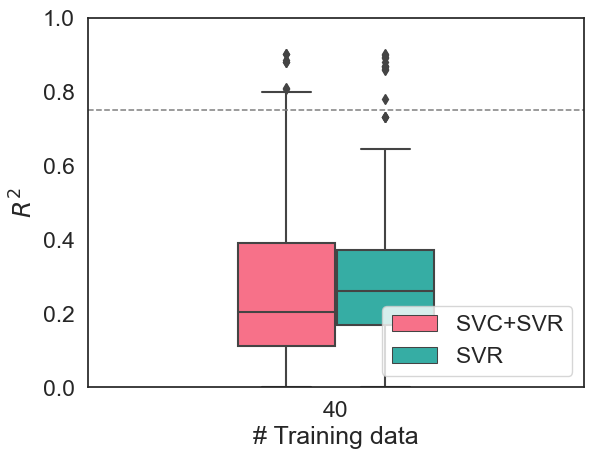

In [843]:
farNewResult = ComparisonResultsListPlot([newSVMSVRr2List_far_H[:], newSVRr2List_far_H[:]], 40, \
          xname = '# Training data', yname = '$R^2$', show = 1, \
          ylimit = [0, 1], yline = 0.75)

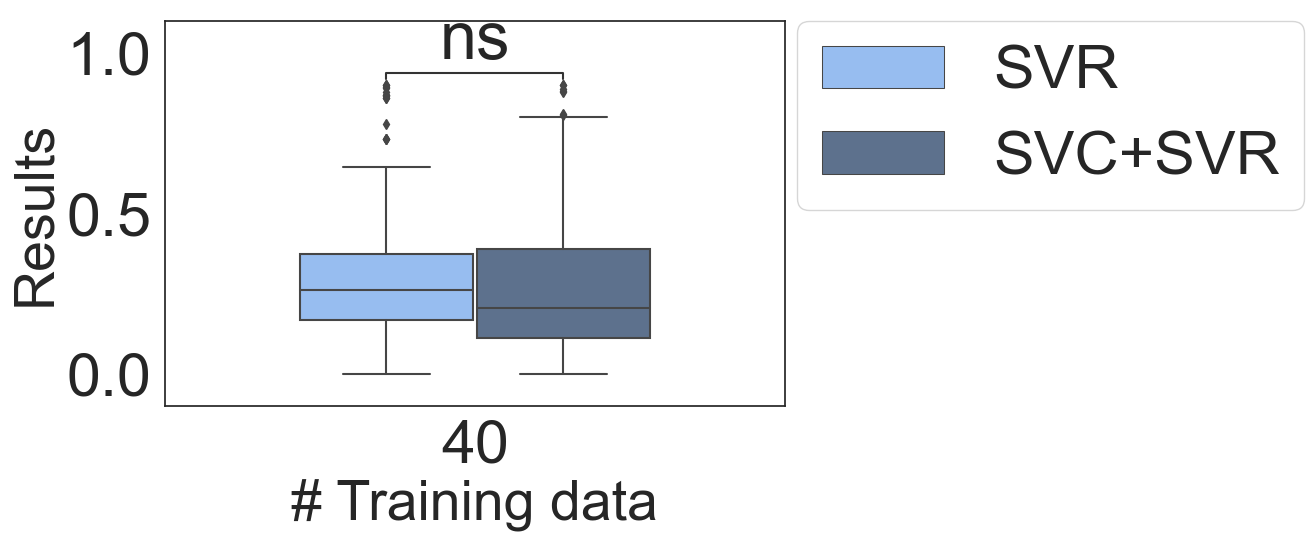

In [844]:
statsPlot(farNewResult, 'Mann-Whitney')
# t-test_paired, Mann-Whitney

['Results']


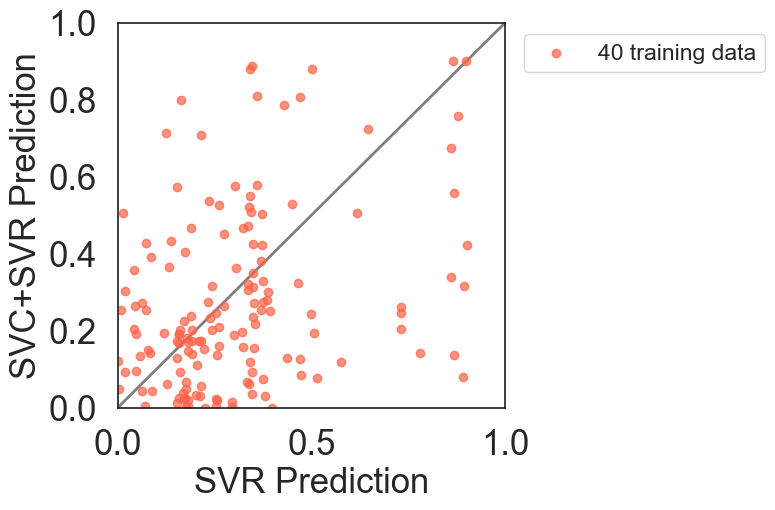

In [845]:
scatterComparisonPlot(farNewResult)

In [800]:
farNewResult['New data location'] = 'Far'
farNewResult['First round performance'] = 'Good'

In [801]:
farNewResult['Active learning strategy'] = 'II'

### Mixture of Closest & Furtherest points

In [854]:
# Started with n datapoints
round1_SVCSVR = round1UseDF[round1UseDF['Method'] == 'SVC+SVR']
round1_SVCSVR = round1_SVCSVR[round1_SVCSVR['# Training data'] == n]
round1_SVCSVR = round1_SVCSVR.reset_index(drop=True)

round1_SVR = round1UseDF[round1UseDF['Method'] == 'SVR']
round1_SVR = round1_SVR[round1_SVR['# Training data'] == n]
round1_SVR = round1_SVR.reset_index(drop=True)

comparisonList = round1_SVCSVR['Results'] - round1_SVR['Results']

topIndexList = \
sorted(range(len(comparisonList)), key=lambda i: comparisonList[i], reverse=True)[:roundTwoLength]
bottomIndexList = \
sorted(range(len(comparisonList)), key=lambda i: comparisonList[i], reverse=True)[-1*roundTwoLength:][::-1]

# Run here
newSVMSVRr2List_H = []
newSVRr2List_H = []

for i in range(roundTwoLength):
    topIndex = topIndexList[i]
    print(topIndex, comparisonList[topIndex])
    if comparisonList[topIndex] > 0.3:
        
        # Dataframe for the first round of training
        ori = processExcelFormat03('round3.xlsx', 'FinalTimePoint', 0.6)

        # Get the SVM machine
        topSVMModel = r2Recorder_02[n][topIndex][0]
        ## Apply it to the ori df
        # Transform ori df to scaled version first
        inputName = list(ori.columns)[:-2]
        sc_X = scXRecorder_02[n][topIndex]
        sc_density = scDensityRecorder_02[n][topIndex]
        featureScaler = sc_X.fit(ori[inputName].values)
        scaled_features = featureScaler.transform(ori[inputName].values)
        ori[inputName] = scaled_features

        # Apply SVM on the full set
        ori['FirstRoundPrediction'] = topSVMModel.decision_function(ori[inputName])

        # The previous 15 training data row
        originalTopTrainDFIndexTop = indexRecorder_02[n][topIndex]

        # Select pos by creating a new DF then selecting from there
        topSVMSVRfullDF_PosTemp = ori[ori['FirstRoundPrediction']>0]
        topSVMSVRfullDF_PosTemp = topSVMSVRfullDF_PosTemp.sort_values('FirstRoundPrediction')
        # No duplicates -- temp of temp
        topSVMSVRfullDF_PosTempT = topSVMSVRfullDF_PosTemp\
        [~topSVMSVRfullDF_PosTemp.index.isin(originalTopTrainDFIndexTop)]
        newData_IndexArrayTop_Pos_F = topSVMSVRfullDF_PosTempT.iloc[-7:].index
        newData_IndexArrayTop_Pos_C = topSVMSVRfullDF_PosTempT.iloc[:7].index

        # Select neg
        topSVMSVRfullDF_NegTemp = ori[ori['FirstRoundPrediction']<0]
        topSVMSVRfullDF_NegTemp = topSVMSVRfullDF_NegTemp.sort_values('FirstRoundPrediction', ascending=False)
        # No duplicates -- temp of temp
        topSVMSVRfullDF_NegTempT = topSVMSVRfullDF_NegTemp\
        [~topSVMSVRfullDF_NegTemp.index.isin(originalTopTrainDFIndexTop)]
        newData_IndexArrayTop_Neg_F = topSVMSVRfullDF_NegTempT.iloc[-7:].index
        newData_IndexArrayTop_Neg_C = topSVMSVRfullDF_NegTempT.iloc[:7].index
        
        # Combine the 4
        allNew = list(set(list(newData_IndexArrayTop_Pos_F) + list(newData_IndexArrayTop_Pos_C) + \
                        list(newData_IndexArrayTop_Neg_F) + list(newData_IndexArrayTop_Neg_C)))
        
        for j in range(3):
            if n > len(allNew):
                allNew_half = allNew
            else:
                allNew_half = list(set(random.sample(allNew, n)))
            print(len(allNew_half))

            final_IndexArrayTop_Comb = allNew_half + list(np.array(originalTopTrainDFIndexTop))

            # Get the new training & testing DF
            topSVMSVRnewTrainingDF = ori.loc[final_IndexArrayTop_Comb]
            topSVMSVRnewTestingDF = ori[~ori.index.isin(final_IndexArrayTop_Comb)]

            for t in range(5):
                # Run top once
                complexSVRSpearmanLists2D_02_neg, complexSVRPearsonLists2D_02_neg, \
                complexSVRR2Lists2D_02_neg, complexSVRMSELists2D_02_neg, \
                complexPredictedSVRSpearmanLists2D_02_neg, complexPredictedSVRPearsonLists2D_02_neg, \
                complexPredictedSVRR2Lists2D_02_neg, complexPredictedSVRMSELists2D_02_neg, \
                r2Recorder2D_02_neg, mseRecorder2D_02_neg, pearsonRecorder2D_02_neg, spearmanRecorder2D_02_neg, \
                SVRSpearmanLists2D_02_neg, SVRPearsonLists2D_02_neg, SVRR2Lists2D_02_neg, SVRMSELists2D_02_neg, \
                PredictedSVRSpearmanLists2D_02_neg, PredictedSVRPearsonLists2D_02_neg, \
                PredictedSVRR2Lists2D_02_neg, PredictedSVRMSELists2D_02_neg, \
                SVRr2Recorder2D_02_neg, SVRmseRecorder2D_02_neg, SVRpearsonRecorder2D_02_neg, SVRspearmanRecorder2D_02_neg,\
                indexRecorder2D_02_neg, TrainXDFRecorder2D_02_neg, TrainYDFRecorder2D_02_neg, \
                SVMSVRFullXDFRecorder2D_02_neg, SVMSVRFullYDFRecorder2D_02_neg, \
                scXRecorder2D_02_neg, scDensityRecorder2D_02_neg, scDistanceRecorder2D_02_neg = \
                ComparisonMultipleRun(1, 'round3.xlsx', 3, 'FinalTimePoint', [40], \
                                      final_IndexArrayTop_Comb, ['poly', 'rbf'], 0.6)
                # Get the new r2 pair
                newSVMSVRr2 = complexSVRR2Lists2D_02_neg[0][0][1]
                newSVMSVRr2List_H.append(newSVMSVRr2)

                newSVRr2 = SVRR2Lists2D_02_neg[0][0][1]
                newSVRr2List_H.append(newSVRr2)

print(newSVMSVRr2List_H, newSVRr2List_H)


20 0.6609854469396321
20
40
[0, 8, 12, 15, 16, 17, 21, 27, 28, 35, 39, 40, 46, 47, 51, 53, 54, 55, 59, 63, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


SVC(C=10000.0, degree=5, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 5, 'C': 10000.0} 0.875
R2:  0.3650198604505607
MSE:  0.3647919436438296
Pearson:  0.6041687350819809
Spearman:  0.8571428571428572
R2:  0.03390506267046371
MSE:  0.2547569428503821
Pearson:  0.18413327420774248
Spearman:  0.21821789023599242
R2:  0.3300144558619618
MSE:  0.3358550469983479
Pearson:  0.5744688467288386
Spearman:  0.7380952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9085959450539064, 0.27340937718414177, 0.6848334690945729, 0.8086956521739129]
SVR:  [0.6238677907305523, 0.12350545419009747, 0.789853018434792, 0.6956521739130433]
40
[0, 8, 12, 15, 16, 17, 21, 27, 28, 35, 39, 40, 46, 47, 51, 53, 54, 55, 59, 63, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(C=100.0, kernel='poly') {'kernel': 'poly', 'gamma': 'scale', 'degree': 3, 'C': 100.0} 0.8
R2:  0.5336650588365128
MSE:  0.1543624695915769
Pearson:  0.7305238249615909
Spearman:  0.5476190476190477
R2:  0.23429489298854117
MSE:  0.6884741031581753
Pearson:  0.4840401770396143
Spearman:  0.6190476190476191
R2:  0.5341468633567595
MSE:  0.1374934258017813
Pearson:  0.7308535170311216
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.30191938140789876, 0.25576319514545653, 0.5129576263876889, 0.7895652173913044]
SVR:  [0.4652580627411639, 0.19760009942097337, 0.6820982793858695, 0.6878260869565217]
40
[0, 8, 12, 15, 16, 17, 21, 27, 28, 35, 39, 40, 46, 47, 51, 53, 54, 55, 59, 63, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(C=10000.0, degree=5, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 5, 'C': 10000.0} 0.875
R2:  0.8118994689953171
MSE:  0.10333689786893452
Pearson:  0.9010546426245842
Spearman:  0.6666666666666669
R2:  0.6062185276541143
MSE:  0.18094505145420525
Pearson:  0.7786003645350508
Spearman:  0.5952380952380953
R2:  0.7544938073903721
MSE:  0.699377031968267
Pearson:  0.8686160298948968
Spearman:  0.6904761904761906


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.47846368429090474, 0.21867137041235662, 0.49363724438242695, 0.7530434782608695]
SVR:  [0.9193392959872677, 0.037648247819267754, 0.9588218270290199, 0.8521739130434782]
40
[0, 8, 12, 15, 16, 17, 21, 27, 28, 35, 39, 40, 46, 47, 51, 53, 54, 55, 59, 63, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(C=1000.0, degree=2) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 2, 'C': 1000.0} 0.85
R2:  0.6417696266196011
MSE:  0.22746137501880787
Pearson:  0.8011052531469264
Spearman:  0.8333333333333335
R2:  0.3215097229145361
MSE:  0.3238778474295044
Pearson:  0.5670182738806009
Spearman:  0.4285714285714286
R2:  0.45544192680632706
MSE:  0.22408764472989467
Pearson:  0.6748643766019415
Spearman:  0.5714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4691608256668142, 0.18750344784846398, 0.9532148437072885, 0.8113043478260868]
SVR:  [0.4732813908622423, 0.21817971231084163, 0.687954497668445, 0.7165217391304347]
40
[0, 8, 12, 15, 16, 17, 21, 27, 28, 35, 39, 40, 46, 47, 51, 53, 54, 55, 59, 63, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(C=100.0, degree=5, gamma='auto') {'kernel': 'rbf', 'gamma': 'auto', 'degree': 5, 'C': 100.0} 0.8
R2:  0.872828380140464
MSE:  0.04577378523106536
Pearson:  0.934252845936508
Spearman:  0.9047619047619048
R2:  0.8947980320043974
MSE:  0.040085684430820556
Pearson:  0.9459376469960362
Spearman:  1.0
R2:  0.329552661830289
MSE:  0.48932556136076344
Pearson:  0.5740667747137864
Spearman:  0.6428571428571429


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.37353306825991267, 0.18327192316861005, 0.6924203326941125, 0.8339130434782607]
SVR:  [0.47337697312171834, 0.21811348600718652, 0.6880239626072033, 0.7339130434782607]
20
40
[0, 5, 9, 11, 12, 15, 16, 17, 25, 27, 29, 35, 40, 42, 46, 47, 51, 55, 61, 63, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(C=100.0, degree=2, gamma=10.0) {'kernel': 'rbf', 'gamma': 10.0, 'degree': 2, 'C': 100.0} 0.8
R2:  0.5419555782566855
MSE:  0.15547325442210186
Pearson:  0.7361763228036372
Spearman:  0.4523809523809524
R2:  0.07896817226836685
MSE:  0.3075027100882394
Pearson:  0.2810127617535667
Spearman:  0.1666666666666667
R2:  0.8948565883296641
MSE:  0.052524058646822074
Pearson:  0.945968597961721
Spearman:  0.8095238095238096


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.48751677572117974, 0.8013321314783642, 0.5243899419554325, 0.82]
SVR:  [0.35476428902262597, 0.25198778879618583, 0.5956209272873358, 0.6582608695652173]
40
[0, 5, 9, 11, 12, 15, 16, 17, 25, 27, 29, 35, 40, 42, 46, 47, 51, 55, 61, 63, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(C=100.0, degree=4, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 4, 'C': 100.0} 0.9
R2:  0.32828775265175786
MSE:  0.2720461503221562
Pearson:  0.5729640064190401
Spearman:  0.4523809523809524
R2:  0.8688420037499139
MSE:  0.022577816700921405
Pearson:  0.9321169474641658
Spearman:  0.4523809523809524
R2:  0.7161406531895202
MSE:  0.23195274590559975
Pearson:  0.846250939845576
Spearman:  0.6666666666666669


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8737663513295837, 0.10036042625784614, 0.9604980594689596, 0.7513043478260868]
SVR:  [0.3109640644863185, 2.898610212421459, 0.5576415196937171, 0.9234782608695651]
40
[0, 5, 9, 11, 12, 15, 16, 17, 25, 27, 29, 35, 40, 42, 46, 47, 51, 55, 61, 63, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(C=1000.0, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 3, 'C': 1000.0} 0.9
R2:  0.6604928030274709
MSE:  0.09584128563247894
Pearson:  0.8127070831655593
Spearman:  0.9285714285714287
R2:  0.26604755081362225
MSE:  0.19075555362724528
Pearson:  0.5157979748056617
Spearman:  0.7380952380952381
R2:  0.8977182889106623
MSE:  0.02879868095707212
Pearson:  0.9474799675511149
Spearman:  0.8571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7477063838489406, 0.2068947584927967, 0.43125089803167466, 0.7104347826086955]
SVR:  [0.17176067540356957, 0.32316045192235826, 0.41444019520742603, 0.6278260869565216]
40
[0, 5, 9, 11, 12, 15, 16, 17, 25, 27, 29, 35, 40, 42, 46, 47, 51, 55, 61, 63, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(C=100.0, degree=4, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 4, 'C': 100.0} 0.85
R2:  0.5471354667473332
MSE:  0.21438657043092843
Pearson:  0.7396860595869934
Spearman:  0.7619047619047621
R2:  0.9078843057874395
MSE:  0.06559217349297929
Pearson:  0.9528296310397988
Spearman:  0.7857142857142858
R2:  0.9536222494381319
MSE:  0.02000965871832778
Pearson:  0.9765358413484536
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8610549468288078, 0.05859598184759423, 0.9290577712500203, 0.7539130434782607]
SVR:  [0.6179824503400827, 0.13467114710047542, 0.7861185981390357, 0.8321739130434782]
40
[0, 5, 9, 11, 12, 15, 16, 17, 25, 27, 29, 35, 40, 42, 46, 47, 51, 55, 61, 63, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(degree=4, gamma=1.0, kernel='poly') {'kernel': 'poly', 'gamma': 1.0, 'degree': 4, 'C': 1.0} 0.725
R2:  0.010846969339901405
MSE:  0.4660575507200277
Pearson:  0.10414878462997737
Spearman:  -0.1666666666666667
R2:  0.13917355911854787
MSE:  0.717253407473359
Pearson:  -0.3730597259401608
Spearman:  -0.04761904761904763
R2:  0.03578250944573465
MSE:  0.3796901084792057
Pearson:  -0.18916265341164631
Spearman:  -0.28571428571428575


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.39276382413444894, 0.19117160434337246, 0.8444474137356116, 0.5791304347826086]
SVR:  [0.5963291110825506, 0.21279502617424395, 0.772223485192305, 0.7826086956521738]
20
40
[5, 8, 9, 12, 15, 16, 17, 25, 28, 29, 35, 40, 51, 53, 54, 55, 59, 61, 62, 63, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(C=10.0, degree=2, gamma='auto') {'kernel': 'rbf', 'gamma': 'auto', 'degree': 2, 'C': 10.0} 0.8
R2:  0.49352746106729106
MSE:  0.3223121017877705
Pearson:  0.7025150966828335
Spearman:  0.6428571428571429
R2:  0.8623630473307392
MSE:  0.0836695175608845
Pearson:  0.9286350452846045
Spearman:  0.6666666666666669
R2:  0.9448764296460609
MSE:  0.15396995746432682
Pearson:  0.9720475449514088
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6523778848702046, 0.0378780557711742, 0.8125265013405341, 0.7347826086956522]
SVR:  [0.6421857985848752, 0.15200518162288487, 0.801364959668736, 0.6991304347826087]
40
[5, 8, 9, 12, 15, 16, 17, 25, 28, 29, 35, 40, 51, 53, 54, 55, 59, 61, 62, 63, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(C=100.0, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 3, 'C': 100.0} 0.925
R2:  0.35083131507546483
MSE:  0.3322528700531699
Pearson:  0.592310151082577
Spearman:  0.6428571428571429
R2:  0.7729517020582684
MSE:  0.21284348114503968
Pearson:  0.8791767183327075
Spearman:  0.7857142857142858
R2:  0.9061953968364612
MSE:  0.06781165156104818
Pearson:  0.9519429588144775
Spearman:  0.8571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8427749801173969, 0.03413302638236979, 0.7634456144759585, 0.6513043478260869]
SVR:  [0.5766265254784436, 0.1995216707450943, 0.7593592861606708, 0.7260869565217389]
40
[5, 8, 9, 12, 15, 16, 17, 25, 28, 29, 35, 40, 51, 53, 54, 55, 59, 61, 62, 63, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(C=10000.0, degree=2, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 2, 'C': 10000.0} 0.925
R2:  0.3966681584847794
MSE:  0.243759259717595
Pearson:  0.6298159719194008
Spearman:  0.6666666666666669
R2:  0.4337361920428939
MSE:  0.2834465082108032
Pearson:  0.658586510674865
Spearman:  0.6190476190476191
R2:  0.4358607182554055
MSE:  0.3413241242407603
Pearson:  0.6601974842843661
Spearman:  0.5952380952380953


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6691361421155122, 0.04590605612368106, 0.7732957497126992, 0.41650976190281463]
SVR:  [0.6111159233528958, 0.30979917961078535, 0.7817390378846995, 0.6799999999999999]
40
[5, 8, 9, 12, 15, 16, 17, 25, 28, 29, 35, 40, 51, 53, 54, 55, 59, 61, 62, 63, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(C=1000.0, degree=4) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 4, 'C': 1000.0} 0.825
R2:  0.6361985432753815
MSE:  0.20840210312076912
Pearson:  0.797620550935958
Spearman:  0.7619047619047621
R2:  0.4548708997606335
MSE:  0.36185240320800044
Pearson:  0.6744411759083468
Spearman:  0.8728715609439694
R2:  0.31938777217364644
MSE:  0.30269224256905725
Pearson:  0.5651440278138365
Spearman:  0.7863867486193535


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6552055148900876, 0.2138130182216457, 0.9166405087435061, 0.7382608695652173]
SVR:  [0.8264500884871493, 0.05073297766023737, 0.909093003210975, 0.7017391304347826]
40
[5, 8, 9, 12, 15, 16, 17, 25, 28, 29, 35, 40, 51, 53, 54, 55, 59, 61, 62, 63, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(C=10000.0, degree=4, kernel='poly') {'kernel': 'poly', 'gamma': 'scale', 'degree': 4, 'C': 10000.0} 0.85
R2:  0.46815957059004376
MSE:  0.29502402031580566
Pearson:  0.6842218723411608
Spearman:  0.7857142857142858
R2:  0.46999250327043585
MSE:  0.29446691957214344
Pearson:  0.685559992466331
Spearman:  0.7857142857142858
R2:  0.186044119847546
MSE:  0.2470208027865659
Pearson:  0.4313283202475187
Spearman:  0.6428571428571429


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8862869856967265, 0.11890563214185, 0.852417105408507, 0.7008695652173912]
SVR:  [0.5764198718651755, 0.19970758675388087, 0.7592232029286088, 0.7260869565217389]
15 0.6584476271023618
20
40
[5, 8, 9, 11, 13, 14, 15, 18, 21, 27, 38, 41, 44, 46, 47, 48, 51, 52, 53, 57, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


SVC(C=1000.0, degree=5, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 5, 'C': 1000.0} 0.925
R2:  0.5986445217759736
MSE:  0.29944413702581374
Pearson:  0.7737212170904796
Spearman:  0.7380952380952381
R2:  0.3962558852833679
MSE:  0.253501120734963
Pearson:  0.6294885902725862
Spearman:  0.6428571428571429
R2:  0.7838756306008077
MSE:  0.10328948319542922
Pearson:  0.8853675116022769
Spearman:  0.7857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.30661527144291, 0.0580722827584074, 0.7204182202844683, 0.737391304347826]
SVR:  [0.6568012534850532, 0.26439251804028924, 0.8104327569175949, 0.7713043478260868]
40
[5, 8, 9, 11, 13, 14, 15, 18, 21, 27, 38, 41, 44, 46, 47, 48, 51, 52, 53, 57, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(C=10.0, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 3, 'C': 10.0} 0.925
R2:  0.31600807510224765
MSE:  0.39748900931452474
Pearson:  0.5621459553374439
Spearman:  0.5000000000000001
R2:  0.29621128608279634
MSE:  0.2879480463549797
Pearson:  0.5442529614827981
Spearman:  0.4523809523809524
R2:  0.9143727349109442
MSE:  0.02200495962628489
Pearson:  0.9562283905589417
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.44015642571688407, 0.2998364867282008, 0.6258562761792661, 0.6365217391304347]
SVR:  [0.4835057823157854, 0.2170670163384477, 0.6953458005307758, 0.677391304347826]
40
[5, 8, 9, 11, 13, 14, 15, 18, 21, 27, 38, 41, 44, 46, 47, 48, 51, 52, 53, 57, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(C=1000.0, degree=4, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 4, 'C': 1000.0} 0.925
R2:  0.5631050387690485
MSE:  0.26587720948274685
Pearson:  0.7504032507719087
Spearman:  0.9523809523809524
R2:  0.45537043730926335
MSE:  0.18389083212930576
Pearson:  0.6748114086982104
Spearman:  0.880952380952381
R2:  0.5640292093943333
MSE:  0.23305338363550598
Pearson:  0.7510187809864232
Spearman:  0.8571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5514476669253092, 0.27465541109362973, 0.7230238619715287, 0.7695652173913042]
SVR:  [0.4104562195235959, 0.36170283738943326, 0.640668572292723, 0.6532186212554915]
40
[5, 8, 9, 11, 13, 14, 15, 18, 21, 27, 38, 41, 44, 46, 47, 48, 51, 52, 53, 57, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(C=1000.0, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 3, 'C': 1000.0} 0.9
R2:  0.3596177515073424
MSE:  0.16907034967701434
Pearson:  0.59968137498787
Spearman:  0.2142857142857143
R2:  0.9344466468161539
MSE:  0.22376455139922968
Pearson:  0.9666678058237761
Spearman:  0.9523809523809524
R2:  0.6944707560867813
MSE:  0.13569637374473847
Pearson:  0.8333491201692009
Spearman:  0.2380952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.651687309573858, 0.14677110534223822, 0.6559843280305502, 0.737391304347826]
SVR:  [0.655533718901828, 0.1960383376699456, 0.8096503683083386, 0.8017391304347825]
40
[5, 8, 9, 11, 13, 14, 15, 18, 21, 27, 38, 41, 44, 46, 47, 48, 51, 52, 53, 57, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(C=10000.0, degree=5, gamma=0.0001) {'kernel': 'rbf', 'gamma': 0.0001, 'degree': 5, 'C': 10000.0} 0.925
R2:  0.7332926665434394
MSE:  0.49799292694385255
Pearson:  0.8563250939587367
Spearman:  0.8095238095238096
R2:  0.5136359736384587
MSE:  0.22215917741585878
Pearson:  0.7166840124060663
Spearman:  0.7619047619047621
R2:  0.9075509425977811
MSE:  0.0380764678135388
Pearson:  0.9526546817172425
Spearman:  0.8571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6017488853817383, 0.2220045334539006, 0.6199254610159101, 0.7095652173913043]
SVR:  [0.5194823500416034, 0.42546879904036344, 0.7207512400555434, 0.5669565217391304]
20
40
[4, 5, 8, 9, 11, 13, 14, 22, 25, 27, 38, 41, 46, 47, 48, 51, 52, 53, 55, 62, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(C=10000.0, degree=2, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 2, 'C': 10000.0} 0.925
R2:  0.8173710865780522
MSE:  0.10575286530109372
Pearson:  0.904085773905359
Spearman:  0.6946232319096901
R2:  0.3028632347397037
MSE:  0.36967693487183195
Pearson:  0.55033011433112
Spearman:  0.4047619047619048
R2:  0.8948451818550035
MSE:  0.06039671022709327
Pearson:  0.9459625689502745
Spearman:  0.5952380952380953


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.41620454074496177, 0.1659393486801093, 0.8338032971324741, 0.7799999999999999]
SVR:  [0.8682805952797913, 0.06777334374041055, 0.9318157517877613, 0.7504347826086956]
40
[4, 5, 8, 9, 11, 13, 14, 22, 25, 27, 38, 41, 46, 47, 48, 51, 52, 53, 55, 62, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(C=10000.0, degree=2, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 2, 'C': 10000.0} 0.925
R2:  0.9889811904084841
MSE:  0.0040916657924690535
Pearson:  0.9944753342383534
Spearman:  0.7142857142857144
R2:  0.902239895136591
MSE:  0.026812128784468
Pearson:  0.9498630928384315
Spearman:  0.8333333333333335
R2:  0.8154755937535291
MSE:  0.08139501748929187
Pearson:  0.903036872864851
Spearman:  0.3333333333333334


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4261987160860952, 0.4345637620682787, 0.71274144849096, 0.6189720881843834]
SVR:  [0.694370546276347, 0.2707161474248013, 0.8332889932528492, 0.7226086956521738]
40
[4, 5, 8, 9, 11, 13, 14, 22, 25, 27, 38, 41, 46, 47, 48, 51, 52, 53, 55, 62, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(C=10000.0, degree=4, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 4, 'C': 10000.0} 0.925
R2:  0.326595614670935
MSE:  0.21947148061432478
Pearson:  0.5714854457210042
Spearman:  0.7380952380952381
R2:  0.0909676730179282
MSE:  0.3677467987614813
Pearson:  -0.30160847636949495
Spearman:  0.3333333333333334
R2:  0.4197266078465729
MSE:  0.2652488166949398
Pearson:  0.6478631088791618
Spearman:  0.9523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5108768646160748, 0.22077261084456437, 0.8784192277633557, 0.7521739130434782]
SVR:  [0.5811296937912311, 0.1744526484030514, 0.7623186300958616, 0.7478260869565216]
40
[4, 5, 8, 9, 11, 13, 14, 22, 25, 27, 38, 41, 46, 47, 48, 51, 52, 53, 55, 62, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(C=10.0, degree=5, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 5, 'C': 10.0} 0.925
R2:  0.920857425599758
MSE:  0.027604443610084614
Pearson:  0.9596131645615111
Spearman:  0.7380952380952381
R2:  0.924137217267558
MSE:  0.026046075153053357
Pearson:  0.9613205590579854
Spearman:  0.8095238095238096
R2:  0.5029720076994643
MSE:  0.18702490118631646
Pearson:  0.7092051943545424
Spearman:  0.5476190476190477


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.3947689263800527, 0.14884441508742816, 0.64562721363756, 0.7591304347826088]
SVR:  [0.8544582757025381, 0.11967886424630896, 0.924369123079378, 0.706086956521739]
40
[4, 5, 8, 9, 11, 13, 14, 22, 25, 27, 38, 41, 46, 47, 48, 51, 52, 53, 55, 62, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(C=100.0, degree=5, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 5, 'C': 100.0} 0.9
R2:  0.265689260720375
MSE:  0.2923709501344762
Pearson:  0.5154505414880995
Spearman:  0.1666666666666667
R2:  0.9896557609264494
MSE:  0.008883329346572884
Pearson:  0.9948144354232348
Spearman:  0.9523809523809524
R2:  0.9865658721010874
MSE:  0.018289633296249042
Pearson:  0.9932602237586518
Spearman:  0.9523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4804923811856302, 0.24092624098240434, 0.7003515622314211, 0.7617391304347826]
SVR:  [0.0452938876394788, 0.4082302271081437, 0.21282360686605883, 0.12882761734435613]
20
40
[5, 8, 9, 11, 14, 18, 21, 22, 27, 38, 41, 44, 46, 47, 48, 51, 54, 55, 57, 61, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(C=10000.0, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 3, 'C': 10000.0} 0.925
R2:  0.2598582072266818
MSE:  0.2855156802488235
Pearson:  0.5097628931441379
Spearman:  -0.04761904761904763
R2:  0.055193090190455485
MSE:  0.3185080993750652
Pearson:  0.234932096977947
Spearman:  -0.07142857142857144
R2:  0.8981613937280973
MSE:  0.04957615826700577
Pearson:  0.9477137720472871
Spearman:  0.7619047619047621


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5840063487818056, 0.17867852482732746, 0.6449496753273707, 0.7869565217391304]
SVR:  [0.5450854417383371, 0.2004758247019485, 0.7382990191909624, 0.7695652173913042]
40
[5, 8, 9, 11, 14, 18, 21, 22, 27, 38, 41, 44, 46, 47, 48, 51, 54, 55, 57, 61, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(C=10000.0, degree=2, gamma=0.0001) {'kernel': 'rbf', 'gamma': 0.0001, 'degree': 2, 'C': 10000.0} 0.925
R2:  0.9268954502197903
MSE:  0.03343205173233975
Pearson:  0.9627540964440454
Spearman:  0.5476190476190477
R2:  0.2925657135082482
MSE:  0.31492866352898
Pearson:  0.5408934400676794
Spearman:  0.09523809523809526
R2:  0.4268291312391517
MSE:  0.2978170422346623
Pearson:  0.6533216139384581
Spearman:  0.7142857142857144


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4606158515528657, 0.16362658553734277, 0.6454109974241679, 0.5895652173913043]
SVR:  [0.40399565417958433, 0.21413348704156218, 0.6356065246515208, 0.58]
40
[5, 8, 9, 11, 14, 18, 21, 22, 27, 38, 41, 44, 46, 47, 48, 51, 54, 55, 57, 61, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(C=1000.0, degree=4, gamma='auto') {'kernel': 'rbf', 'gamma': 'auto', 'degree': 4, 'C': 1000.0} 0.9
R2:  0.8908054081585565
MSE:  0.2935860417998221
Pearson:  0.9438248821463422
Spearman:  0.7325886315065459
R2:  0.952100141610982
MSE:  0.03596051111013267
Pearson:  0.9757561896349836
Spearman:  0.7619047619047621
R2:  0.9559233054417945
MSE:  0.07222861288601243
Pearson:  0.9777133043187022
Spearman:  0.5628843430992317


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7518674471155362, 0.11870822303340266, 0.8545049059818155, 0.8547826086956521]
SVR:  [0.2977672631826177, 0.27651077476323216, 0.5456805504895862, 0.4832141999582788]
40
[5, 8, 9, 11, 14, 18, 21, 22, 27, 38, 41, 44, 46, 47, 48, 51, 54, 55, 57, 61, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(C=1000.0, degree=4, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 4, 'C': 1000.0} 0.925
R2:  0.12185632470629576
MSE:  0.3549367069552446
Pearson:  0.34907925275830387
Spearman:  0.30952380952380953
R2:  0.4555984324943373
MSE:  0.23535520218092498
Pearson:  0.674980320079287
Spearman:  0.7857142857142858
R2:  0.07604853531943279
MSE:  0.42551788356797104
Pearson:  0.2757689890459636
Spearman:  0.4523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.2797126631513688, 0.10937741206273881, 0.9604830717871968, 0.868695652173913]
SVR:  [0.293166599325714, 0.6277765249163528, 0.5414486118974857, 0.7765217391304347]
40
[5, 8, 9, 11, 14, 18, 21, 22, 27, 38, 41, 44, 46, 47, 48, 51, 54, 55, 57, 61, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(C=1000.0, degree=4, gamma=1.0, kernel='poly') {'kernel': 'poly', 'gamma': 1.0, 'degree': 4, 'C': 1000.0} 0.675
R2:  0.270465919215051
MSE:  0.41005782790857825
Pearson:  0.5200633799981027
Spearman:  0.1666666666666667
R2:  0.8680185390558902
MSE:  0.09495135975262431
Pearson:  0.9316751252748409
Spearman:  0.880952380952381
R2:  0.864204349275638
MSE:  0.09875769783178504
Pearson:  0.9296259189994857
Spearman:  0.8095238095238096


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8603312363239195, 0.2163845088590873, 0.5879472181822766, 0.6295652173913043]
SVR:  [0.5363752358022674, 0.25036633994489715, 0.73237643039783, 0.8191304347826085]
14 0.5817365754139048
20
40
[0, 7, 9, 10, 11, 12, 14, 17, 23, 26, 27, 28, 33, 34, 38, 43, 45, 46, 52, 53, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(C=100.0, degree=4, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 4, 'C': 100.0} 0.875
R2:  0.7959958949800457
MSE:  0.3025817673290553
Pearson:  0.8921860203903921
Spearman:  0.9523809523809524
R2:  0.6444299178499672
MSE:  0.34850230437223123
Pearson:  0.8027639241084312
Spearman:  0.790433332862751
R2:  0.7962640814331138
MSE:  0.12213249033109014
Pearson:  0.8923363051188231
Spearman:  0.7857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7589004162493752, 0.23288480151290894, 0.6663954758102764, 0.8443478260869565]
SVR:  [0.5123717785178661, 0.2869296016871911, 0.715801493794101, 0.8408695652173912]
40
[0, 7, 9, 10, 11, 12, 14, 17, 23, 26, 27, 28, 33, 34, 38, 43, 45, 46, 52, 53, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(C=100.0, degree=4, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 4, 'C': 100.0} 0.875
R2:  0.8198630464520794
MSE:  0.13993346278815966
Pearson:  0.9054628907095417
Spearman:  0.9047619047619048
R2:  0.2874595181019332
MSE:  0.2808718666908256
Pearson:  0.5361525138446461
Spearman:  0.9285714285714287
R2:  0.6936345398590866
MSE:  0.14660201533441589
Pearson:  0.8328472488152235
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7608165298965488, 0.21919991472582953, 0.746472753932257, 0.7913043478260868]
SVR:  [0.3693367000984401, 0.243475074844376, 0.6077307792916531, 0.6339130434782608]
40
[0, 7, 9, 10, 11, 12, 14, 17, 23, 26, 27, 28, 33, 34, 38, 43, 45, 46, 52, 53, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(C=1000.0, degree=2, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 2, 'C': 1000.0} 0.825
R2:  0.8845646482111271
MSE:  0.09035871834530539
Pearson:  0.9405129707830335
Spearman:  0.8571428571428572
R2:  0.8891976896416705
MSE:  0.09502100758888622
Pearson:  0.9429727936911381
Spearman:  0.8571428571428572
R2:  0.982584931029935
MSE:  0.01241401900786131
Pearson:  0.9912542211914834
Spearman:  0.8571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.47265608097902084, 0.16310111794935395, 0.8987688590738773, 0.8365217391304347]
SVR:  [0.5424522239286441, 0.25360603385218966, 0.7365135599081964, 0.7388346421715534]
40
[0, 7, 9, 10, 11, 12, 14, 17, 23, 26, 27, 28, 33, 34, 38, 43, 45, 46, 52, 53, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(gamma=10.0, kernel='poly') {'kernel': 'poly', 'gamma': 10.0, 'degree': 3, 'C': 1.0} 0.85
R2:  0.17279425773303134
MSE:  0.41356949951711386
Pearson:  0.4156852868854408
Spearman:  0.14285714285714288
R2:  0.22123428685600344
MSE:  0.42590377606605784
Pearson:  0.47035548987548065
Spearman:  0.5714285714285715
R2:  0.2075208145803063
MSE:  0.43807885995957974
Pearson:  0.455544525354335
Spearman:  0.5714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.381241849092239, 0.25403826170594224, 0.6668673568900683, 0.8286956521739129]
SVR:  [0.8028672182606829, 0.07627979925387957, 0.8960285811628346, 0.8139130434782607]
40
[0, 7, 9, 10, 11, 12, 14, 17, 23, 26, 27, 28, 33, 34, 38, 43, 45, 46, 52, 53, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(C=10000.0, degree=5, gamma=0.0001) {'kernel': 'rbf', 'gamma': 0.0001, 'degree': 5, 'C': 10000.0} 0.925
R2:  0.3511929211828422
MSE:  1.3316951104848807
Pearson:  0.5926153231083737
Spearman:  0.8571428571428572
R2:  0.3456896535068184
MSE:  0.245176774436758
Pearson:  0.5879537851794293
Spearman:  0.5714285714285715
R2:  0.15538441536051514
MSE:  1.3823175144922697
Pearson:  0.3941882993703836
Spearman:  0.4761904761904762


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.555459978168311, 0.3963038692694638, 0.8426891654246687, 0.7165217391304347]
SVR:  [0.8054931953551325, 0.07521622495433063, 0.8974927271878768, 0.8139130434782607]
20
40
[0, 7, 8, 9, 11, 14, 17, 26, 27, 29, 33, 34, 38, 39, 43, 44, 48, 52, 53, 61, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(C=1000.0, degree=5, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 5, 'C': 1000.0} 0.85
R2:  0.9172525137920339
MSE:  0.0682659252537417
Pearson:  0.9577330075715433
Spearman:  0.7619047619047621
R2:  0.9728285361659069
MSE:  0.023210047297186082
Pearson:  0.9863207065482842
Spearman:  0.8333333333333335
R2:  0.9420954580795382
MSE:  0.0462160471063565
Pearson:  0.9706160198964047
Spearman:  0.8571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.47624999360737297, 0.23035304100834808, 0.7874988046682905, 0.7852173913043478]
SVR:  [0.6276041557792631, 0.1521928047515236, 0.7922147157048163, 0.7730434782608695]
40
[0, 7, 8, 9, 11, 14, 17, 26, 27, 29, 33, 34, 38, 39, 43, 44, 48, 52, 53, 61, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(C=100.0, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 3, 'C': 100.0} 0.875
R2:  0.6108988514817648
MSE:  1.0041979987974108
Pearson:  0.781600186464771
Spearman:  1.0
R2:  0.7746510498378014
MSE:  0.0962629787777287
Pearson:  0.8801426303945296
Spearman:  0.9047619047619048
R2:  0.9479203869213968
MSE:  0.035449218277592565
Pearson:  0.9736120310069083
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.31614402367674754, 0.18829641168240208, 0.8038543662357953, 0.8086956521739129]
SVR:  [0.6052585840577419, 0.2252492349504617, 0.777983665675406, 0.8539130434782608]
40
[0, 7, 8, 9, 11, 14, 17, 26, 27, 29, 33, 34, 38, 39, 43, 44, 48, 52, 53, 61, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(C=1000.0, degree=2, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 2, 'C': 1000.0} 0.875
R2:  0.9206855999129815
MSE:  0.022449513578173774
Pearson:  0.9595236317636903
Spearman:  0.6904761904761906
R2:  0.9103408150865197
MSE:  0.2642164841888716
Pearson:  0.9541178203379916
Spearman:  0.5476190476190477
R2:  0.8247432857217031
MSE:  0.05449967797559463
Pearson:  0.9081537786750121
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.577716686572001, 0.07344579979098716, 0.8773670537105245, 0.6756521739130433]
SVR:  [0.5778756672443547, 0.2547018048644241, 0.7601813383952243, 0.8252173913043478]
40
[0, 7, 8, 9, 11, 14, 17, 26, 27, 29, 33, 34, 38, 39, 43, 44, 48, 52, 53, 61, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(C=100.0, degree=4, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 4, 'C': 100.0} 0.875
R2:  0.9187606007345098
MSE:  0.2580557185742652
Pearson:  0.9585200053908682
Spearman:  0.880952380952381
R2:  0.8762838819485887
MSE:  0.17450847205195363
Pearson:  0.936100358908482
Spearman:  0.6190476190476191
R2:  0.43725886942308806
MSE:  0.1757520614226371
Pearson:  0.6612555250605383
Spearman:  0.5000000000000001


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7695587730281145, 0.3534482598744689, 0.4524546309997509, 0.8286956521739129]
SVR:  [0.8292889751968407, 0.0727136549764744, 0.9106530487495449, 0.7939130434782607]
40
[0, 7, 8, 9, 11, 14, 17, 26, 27, 29, 33, 34, 38, 39, 43, 44, 48, 52, 53, 61, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(C=10.0, degree=2, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 2, 'C': 10.0} 0.8
R2:  0.9764914196931985
MSE:  0.019300497361220845
Pearson:  0.9881758040415675
Spearman:  0.9523809523809524
R2:  0.9726975481946551
MSE:  0.020426164902257522
Pearson:  0.9862543019904426
Spearman:  0.6904761904761906
R2:  0.9851198734936184
MSE:  0.011030773671097163
Pearson:  0.9925320516203083
Spearman:  0.9285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6504979380301933, 0.08484076740006895, 0.8887583347702114, 0.7556521739130433]
SVR:  [0.7695759304150102, 0.08344336941432305, 0.8772547693885797, 0.7808695652173911]
20
40
[0, 7, 8, 10, 11, 12, 14, 18, 23, 25, 26, 27, 28, 34, 39, 43, 48, 52, 53, 61, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(C=10000.0, degree=5, gamma=0.0001) {'kernel': 'rbf', 'gamma': 0.0001, 'degree': 5, 'C': 10000.0} 0.875
R2:  0.5771761723553109
MSE:  0.11329193566374615
Pearson:  0.7597211148542014
Spearman:  0.9761904761904763
R2:  0.5769060801094469
MSE:  0.11270875147131999
Pearson:  0.7595433365578602
Spearman:  0.9761904761904763
R2:  0.8465762855674459
MSE:  0.04047923048880142
Pearson:  0.920095802385516
Spearman:  0.8571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6706564780670314, 0.18127186669956577, 0.9087852990791451, 0.7808695652173911]
SVR:  [0.5795790852215112, 0.19366375098359292, 0.7613009163409112, 0.7043478260869565]
40
[0, 7, 8, 10, 11, 12, 14, 18, 23, 25, 26, 27, 28, 34, 39, 43, 48, 52, 53, 61, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(C=1000.0, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 3, 'C': 1000.0} 0.875
R2:  0.0014767579833055106
MSE:  0.3721171179088121
Pearson:  0.0384286089171272
Spearman:  0.2380952380952381
R2:  0.8851241373537029
MSE:  0.04233346656390078
Pearson:  0.9408103620569358
Spearman:  0.7142857142857144
R2:  0.06842679442331955
MSE:  0.3129000472820027
Pearson:  0.2615851571158416
Spearman:  0.3571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.40519794428055833, 0.09120249741425505, 0.8191740039544623, 0.7214972271257799]
SVR:  [0.45053708788313335, 0.2877766510708594, 0.671220595544515, 0.7539130434782607]
40
[0, 7, 8, 10, 11, 12, 14, 18, 23, 25, 26, 27, 28, 34, 39, 43, 48, 52, 53, 61, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(C=10000.0, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 3, 'C': 10000.0} 0.825
R2:  0.44853047253491357
MSE:  0.8112744198684351
Pearson:  0.6697241764599167
Spearman:  0.7857142857142858
R2:  0.26740538523193225
MSE:  0.32214930378183587
Pearson:  0.5171125460012861
Spearman:  0.7142857142857144
R2:  0.37261494121079664
MSE:  0.25038231885423823
Pearson:  0.6104219370327353
Spearman:  0.627376434428478


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7429615575959454, 0.23206522927114648, 0.880170618757079, 0.8313043478260868]
SVR:  [0.22451846833231173, 0.5262499140720998, 0.47383379821653904, 0.34956521739130436]
40
[0, 7, 8, 10, 11, 12, 14, 18, 23, 25, 26, 27, 28, 34, 39, 43, 48, 52, 53, 61, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(C=10000.0, gamma='auto') {'kernel': 'rbf', 'gamma': 'auto', 'degree': 3, 'C': 10000.0} 0.75
R2:  0.8759289454279107
MSE:  0.03820522883182648
Pearson:  0.9359107571921111
Spearman:  0.8095238095238096
R2:  0.6832453093376906
MSE:  0.21579343673254214
Pearson:  0.8265865407431279
Spearman:  0.6190476190476191
R2:  0.788116670882615
MSE:  0.08057915747766589
Pearson:  0.887759354151008
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7831548766903447, 0.25985693747095834, 0.6376779714582435, 0.874782608695652]
SVR:  [0.6626770578216745, 0.23655484854693495, 0.8140497882941031, 0.7791304347826087]
40
[0, 7, 8, 10, 11, 12, 14, 18, 23, 25, 26, 27, 28, 34, 39, 43, 48, 52, 53, 61, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(C=100.0, degree=4, kernel='poly') {'kernel': 'poly', 'gamma': 'scale', 'degree': 4, 'C': 100.0} 0.75
R2:  0.06744699730114478
MSE:  0.5695735968097198
Pearson:  0.2597055973619837
Spearman:  0.19047619047619052
R2:  0.5151097197295397
MSE:  0.16334579763549145
Pearson:  0.7177114460070563
Spearman:  0.8095238095238096
R2:  0.42486180876932467
MSE:  0.22156558435890167
Pearson:  0.6518142440675294
Spearman:  0.6666666666666669


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.047388468796043665, 0.09680250858980773, 0.8116642861733359, 0.36695652173913035]
SVR:  [0.5441820417554922, 0.18571245082321677, 0.7376869537652759, 0.7043478260869565]
26 0.5757938263956837
19
40
[3, 7, 11, 12, 14, 15, 19, 23, 27, 47, 48, 50, 51, 52, 53, 54, 55, 58, 62, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(C=1000.0, degree=4, gamma='auto') {'kernel': 'rbf', 'gamma': 'auto', 'degree': 4, 'C': 1000.0} 0.8178571428571428
R2:  0.45749815414422657
MSE:  0.24553476208074138
Pearson:  0.6763860984262069
Spearman:  0.6666666666666669
R2:  0.2513441183212544
MSE:  0.32412184266928223
Pearson:  0.501342316507648
Spearman:  0.21957751641341997
R2:  0.5392245313700302
MSE:  0.18332436757139448
Pearson:  0.7343190936983938
Spearman:  0.7857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8862568647449961, 0.1508521593404364, 0.9371215380692137, 0.7784615384615384]
SVR:  [0.5151436761304925, 0.22787987968352688, 0.7177351016430035, 0.6753846153846154]
40
[3, 7, 11, 12, 14, 15, 19, 23, 27, 47, 48, 50, 51, 52, 53, 54, 55, 58, 62, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(C=10000.0, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 3, 'C': 10000.0} 0.925
R2:  0.34885676099822627
MSE:  0.316872288810757
Pearson:  0.5906409747030984
Spearman:  0.7619047619047621
R2:  0.7219193582072442
MSE:  0.21457424042382892
Pearson:  0.8496583773536543
Spearman:  0.8095238095238096
R2:  0.9816957768092062
MSE:  0.012355482504625608
Pearson:  0.9908056200936725
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.875277652615608, 0.06309582043935003, 0.9403772727936232, 0.576923076923077]
SVR:  [0.8919023570363545, 0.03691140473049257, 0.9444058222164634, 0.7253846153846153]
40
[3, 7, 11, 12, 14, 15, 19, 23, 27, 47, 48, 50, 51, 52, 53, 54, 55, 58, 62, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(gamma=10.0, kernel='poly') {'kernel': 'poly', 'gamma': 10.0, 'degree': 3, 'C': 1.0} 0.7464285714285714
R2:  0.46627173593229704
MSE:  1.6663163997910637
Pearson:  0.68284093018235
Spearman:  0.8571428571428572
R2:  0.3120241029213271
MSE:  0.2989900402067894
Pearson:  0.558591176909667
Spearman:  0.6190476190476191
R2:  0.8883920162642911
MSE:  0.07954056134495621
Pearson:  0.94254549824626
Spearman:  0.9761904761904763


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8480018561209937, 0.19450960041197252, 0.8724841882258622, 0.7]
SVR:  [0.828634925031723, 0.059319924453677564, 0.9102938674031165, 0.7523076923076923]
40
[3, 7, 11, 12, 14, 15, 19, 23, 27, 47, 48, 50, 51, 52, 53, 54, 55, 58, 62, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(C=1000.0, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 3, 'C': 1000.0} 0.9
R2:  0.49581132667241873
MSE:  0.24061351115939383
Pearson:  0.7041387126642156
Spearman:  0.6904761904761906
R2:  0.5039499398111474
MSE:  0.2446912491558547
Pearson:  0.7098943159450903
Spearman:  0.880952380952381
R2:  0.3955407162369013
MSE:  0.30087190182402235
Pearson:  0.6289202781250589
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.42202368501159965, 0.19276991527589984, 0.3127634186988938, 0.5900000000000001]
SVR:  [0.44912480204158783, 0.34152580467580634, 0.6701677417196295, 0.5661538461538461]
40
[3, 7, 11, 12, 14, 15, 19, 23, 27, 47, 48, 50, 51, 52, 53, 54, 55, 58, 62, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(C=1000.0, degree=5, gamma='auto') {'kernel': 'rbf', 'gamma': 'auto', 'degree': 5, 'C': 1000.0} 0.8178571428571428
R2:  0.4955580368641059
MSE:  0.19423160279375618
Pearson:  0.7039588317963672
Spearman:  0.8333333333333335
R2:  0.3758737613476586
MSE:  0.2762302228987145
Pearson:  0.6130854437577675
Spearman:  0.5000000000000001
R2:  0.7595824859466517
MSE:  0.12207343099892799
Pearson:  0.8715402950791498
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8917258889301145, 0.1527617722096488, 0.92525944704512, 0.7515384615384615]
SVR:  [0.8704077216424279, 0.054820125399800725, 0.9329564414496683, 0.6946153846153846]
19
40
[3, 7, 11, 12, 14, 15, 19, 23, 27, 47, 48, 50, 51, 52, 53, 54, 55, 58, 62, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(C=10.0, gamma=1.0, kernel='poly') {'kernel': 'poly', 'gamma': 1.0, 'degree': 3, 'C': 10.0} 0.7714285714285715
R2:  0.4053010656683976
MSE:  0.2200791835387233
Pearson:  0.6366325986535701
Spearman:  0.880952380952381
R2:  0.29801446421944067
MSE:  0.30227808757618935
Pearson:  0.5459070105974466
Spearman:  0.6428571428571429
R2:  0.8671546703492227
MSE:  0.06447357529102535
Pearson:  0.9312113993874983
Spearman:  0.7380952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.48924626834963963, 0.226832261760463, 0.9446527328782861, 0.733076923076923]
SVR:  [0.5860341508494747, 0.2540751156584718, 0.7655286740870484, 0.6892704238533526]
40
[3, 7, 11, 12, 14, 15, 19, 23, 27, 47, 48, 50, 51, 52, 53, 54, 55, 58, 62, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(C=10000.0, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 3, 'C': 10000.0} 0.8428571428571429
R2:  0.25428293162187887
MSE:  7.350813751864913
Pearson:  0.504264743584041
Spearman:  0.880952380952381
R2:  0.1761868574650346
MSE:  0.26546406433132125
Pearson:  0.41974618219232745
Spearman:  0.28571428571428575
R2:  0.143704611897214
MSE:  0.27118632770948115
Pearson:  0.3790839114196407
Spearman:  0.261904761904762


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.515221284419876, 0.0439620251011539, 0.6481319858457346, 0.7061538461538461]
SVR:  [0.47496551614012456, 0.23219934048285013, 0.6891774199290954, 0.7553846153846154]
40
[3, 7, 11, 12, 14, 15, 19, 23, 27, 47, 48, 50, 51, 52, 53, 54, 55, 58, 62, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(C=10000.0, degree=2, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 2, 'C': 10000.0} 0.8714285714285713
R2:  0.5033632471122973
MSE:  0.2769055787958481
Pearson:  0.7094809702256268
Spearman:  0.7380952380952381
R2:  0.8819546902042386
MSE:  0.0726653122539132
Pearson:  0.9391244274345327
Spearman:  0.7380952380952381
R2:  0.435940524142129
MSE:  0.2817776305933454
Pearson:  0.6602579224379888
Spearman:  0.523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7649611663812583, 0.25393798711042925, 0.9148514760935542, 0.5738461538461538]
SVR:  [0.4690105877766977, 0.25928868893623824, 0.6848434768446712, 0.576923076923077]
40
[3, 7, 11, 12, 14, 15, 19, 23, 27, 47, 48, 50, 51, 52, 53, 54, 55, 58, 62, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(C=1000.0, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 3, 'C': 1000.0} 0.8428571428571429
R2:  0.45713216215988656
MSE:  0.1866798295472414
Pearson:  0.6761154946899877
Spearman:  0.7857142857142858
R2:  0.5073951963065881
MSE:  0.23017890222485451
Pearson:  0.7123167808683073
Spearman:  0.7857142857142858
R2:  0.9071475956109659
MSE:  0.043665050200516725
Pearson:  0.9524429618675156
Spearman:  0.7142857142857144


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8419287297940508, 0.19607635492944947, 0.66857340749896, 0.7176923076923076]
SVR:  [0.8933766803378248, 0.035661865862077737, 0.9451860559370443, 0.7907692307692307]
40
[3, 7, 11, 12, 14, 15, 19, 23, 27, 47, 48, 50, 51, 52, 53, 54, 55, 58, 62, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(C=10000.0, degree=5, gamma=0.0001) {'kernel': 'rbf', 'gamma': 0.0001, 'degree': 5, 'C': 10000.0} 0.8
R2:  0.7748540004299717
MSE:  0.18736880198328762
Pearson:  0.880257916993634
Spearman:  0.9761904761904763
R2:  0.08667569088743518
MSE:  0.27800332811727424
Pearson:  0.2944073553555263
Spearman:  0.14285714285714288
R2:  0.6487629970631155
MSE:  0.4339694590264681
Pearson:  0.8054582528369272
Spearman:  0.8095238095238096


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5152262906803431, 0.045012848982663965, 0.8745396863814079, 0.7453846153846154]
SVR:  [0.5860341508494747, 0.2540751156584718, 0.7655286740870484, 0.6892704238533526]
19
40
[3, 7, 11, 12, 14, 15, 19, 23, 27, 47, 48, 50, 51, 52, 53, 54, 55, 58, 62, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(C=10000.0, gamma='auto', kernel='poly') {'kernel': 'poly', 'gamma': 'auto', 'degree': 3, 'C': 10000.0} 0.7964285714285715
R2:  0.7966388821339723
MSE:  0.05958895183757219
Pearson:  0.8925462913115332
Spearman:  0.5000000000000001
R2:  0.3164842988740397
MSE:  0.28575742508168755
Pearson:  0.5625693724991077
Spearman:  0.3571428571428572
R2:  0.45642017145184416
MSE:  0.22681290085931766
Pearson:  0.6755887591218819
Spearman:  0.5952380952380953


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5151755092266531, 0.03713631242393331, 0.18082325108130642, 0.5692307692307692]
SVR:  [0.5290088418525851, 0.18444871124481552, 0.7273299401596123, 0.6846153846153846]
40
[3, 7, 11, 12, 14, 15, 19, 23, 27, 47, 48, 50, 51, 52, 53, 54, 55, 58, 62, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(C=100.0, degree=5, gamma='auto') {'kernel': 'rbf', 'gamma': 'auto', 'degree': 5, 'C': 100.0} 0.7678571428571429
R2:  0.12932934145076613
MSE:  0.4143617357515199
Pearson:  0.3596238888766514
Spearman:  0.523809523809524
R2:  0.1171147655608795
MSE:  0.46903743350969834
Pearson:  0.3422203465033597
Spearman:  0.5952380952380953
R2:  0.25180155037941987
MSE:  0.26577098535878835
Pearson:  0.5017983164374108
Spearman:  0.4523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8321704541947627, 0.05046838949120814, 0.9204883058955315, 0.71]
SVR:  [0.8286250682509773, 0.05779160304748365, 0.9102884533217906, 0.7300000000000001]
40
[3, 7, 11, 12, 14, 15, 19, 23, 27, 47, 48, 50, 51, 52, 53, 54, 55, 58, 62, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(C=1000.0, degree=4, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 4, 'C': 1000.0} 0.8428571428571429
R2:  0.39780170102732887
MSE:  0.23231589334134906
Pearson:  0.6307152297410685
Spearman:  0.8571428571428572
R2:  0.43834607476884674
MSE:  0.2017331687354502
Pearson:  0.6620770912581455
Spearman:  0.9047619047619048
R2:  0.486708903976393
MSE:  0.23640536687698396
Pearson:  0.6976452565426019
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4903287017595884, 0.1961325655572951, 0.7300366466442837, 0.5569230769230769]
SVR:  [0.8612621975507879, 0.06275594030637245, 0.9280421313446865, 0.6938461538461538]
40
[3, 7, 11, 12, 14, 15, 19, 23, 27, 47, 48, 50, 51, 52, 53, 54, 55, 58, 62, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(C=1000.0, degree=2, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 2, 'C': 1000.0} 0.8428571428571429
R2:  0.2601254436674429
MSE:  0.30904895429621493
Pearson:  0.5100249441619916
Spearman:  0.5476190476190477
R2:  0.6474809845146091
MSE:  0.17994186119885597
Pearson:  0.804662031237096
Spearman:  0.6904761904761906
R2:  0.5517771231793268
MSE:  0.2124012189969019
Pearson:  0.742817018638727
Spearman:  0.6666666666666669


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.549286452588378, 0.3079600061253913, 0.77233942050027, 0.6892307692307692]
SVR:  [0.41999281107744135, 0.28594693908652535, 0.6480685234428852, 0.576923076923077]
40
[3, 7, 11, 12, 14, 15, 19, 23, 27, 47, 48, 50, 51, 52, 53, 54, 55, 58, 62, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(C=10000.0) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 3, 'C': 10000.0} 0.7678571428571429
R2:  0.6079942708898812
MSE:  0.23578421388847237
Pearson:  0.7797398738617138
Spearman:  0.8095238095238096
R2:  0.9791089457053666
MSE:  0.017988954697884686
Pearson:  0.9894993409322549
Spearman:  1.0
R2:  0.9887356322957929
MSE:  0.01132749870023474
Pearson:  0.9943518654358695
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.899394859862862, 0.040390009546459715, 0.9616230242617544, 0.5853846153846154]
SVR:  [0.5150740932715459, 0.227931349467213, 0.7176866260921587, 0.6753846153846154]
28 0.5530175969011716
20
40
[0, 3, 9, 11, 12, 14, 15, 17, 23, 25, 27, 29, 31, 33, 46, 48, 50, 55, 61, 62, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=100.0, degree=4, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 4, 'C': 100.0} 0.95
R2:  0.37545674247600486
MSE:  0.3514252909961193
Pearson:  0.6127452508800089
Spearman:  0.6666666666666669
R2:  0.541634116393567
MSE:  0.2817572492569753
Pearson:  0.7359579583057492
Spearman:  0.7619047619047621
R2:  0.06436230525975682
MSE:  0.3589083787156223
Pearson:  0.2536972708953662
Spearman:  0.09523809523809526


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7494589215334998, 0.09057482855797527, 0.5883951416943815, 0.6817391304347826]
SVR:  [0.7315407161647768, 0.11011145454549431, 0.8553015352288205, 0.877391304347826]
40
[0, 3, 9, 11, 12, 14, 15, 17, 23, 25, 27, 29, 31, 33, 46, 48, 50, 55, 61, 62, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=1000.0, degree=2, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 2, 'C': 1000.0} 0.9
R2:  0.8749930150417616
MSE:  0.06417656460883765
Pearson:  0.9354106130688071
Spearman:  0.9285714285714287
R2:  0.8510827271163796
MSE:  0.07903992166325932
Pearson:  0.9225414500803637
Spearman:  0.8333333333333335
R2:  0.5395593613893449
MSE:  0.09730936544174176
Pearson:  0.7345470450484061
Spearman:  0.8095238095238096


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5198159985457058, 0.25390952442737413, 0.7997083570847396, 0.5791304347826086]
SVR:  [0.4127170354203694, 0.2830618415047056, 0.6424305685600349, 0.5599999999999999]
40
[0, 3, 9, 11, 12, 14, 15, 17, 23, 25, 27, 29, 31, 33, 46, 48, 50, 55, 61, 62, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=10.0, degree=4, gamma=1.0, kernel='poly') {'kernel': 'poly', 'gamma': 1.0, 'degree': 4, 'C': 10.0} 0.85
R2:  0.2608566380098615
MSE:  0.4707418475359606
Pearson:  0.5107412632731583
Spearman:  0.28571428571428575
R2:  0.3973973207565958
MSE:  0.46173353653630345
Pearson:  0.6303945754498494
Spearman:  0.6586944440522925
R2:  0.9002857707753156
MSE:  0.0272517056800968
Pearson:  0.9488339005196409
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.2731124762271078, 0.8559576454199681, 0.5748310884700218, 0.6817391304347826]
SVR:  [0.15776312999475248, 0.8012084422213824, 0.39719407094612125, 0.42956521739130427]
40
[0, 3, 9, 11, 12, 14, 15, 17, 23, 25, 27, 29, 31, 33, 46, 48, 50, 55, 61, 62, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=100.0, degree=4, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 4, 'C': 100.0} 0.9
R2:  0.9537486891108277
MSE:  0.019022558510748133
Pearson:  0.9766005780823745
Spearman:  0.8333333333333335
R2:  0.965970991699951
MSE:  0.01695005321856987
Pearson:  0.9828382327219223
Spearman:  0.8333333333333335
R2:  0.960738195256959
MSE:  0.20230439857549268
Pearson:  0.9801725334128473
Spearman:  0.7857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6112254025586196, 0.16872423283602608, 0.7828953861799821, 0.7104177997463541]
SVR:  [0.3482278935582622, 0.2304551693356159, 0.5901083744180068, 0.7956521739130433]
40
[0, 3, 9, 11, 12, 14, 15, 17, 23, 25, 27, 29, 31, 33, 46, 48, 50, 55, 61, 62, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=1000.0, degree=4, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 4, 'C': 1000.0} 0.95
R2:  0.6607045116290152
MSE:  0.4938956220552314
Pearson:  0.812837321749571
Spearman:  0.8333333333333335
R2:  0.8971675973181669
MSE:  0.04665626041283705
Pearson:  0.9471893144024417
Spearman:  0.9523809523809524
R2:  0.8044414176067881
MSE:  0.25343693950538193
Pearson:  0.8969065824302933
Spearman:  0.9285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4625709497785504, 0.1789292352118422, 0.6630465146166953, 0.7078260869565216]
SVR:  [0.779380123585668, 0.08076904117092347, 0.882825080967724, 0.6634782608695651]
20
40
[3, 7, 12, 14, 15, 17, 23, 25, 27, 29, 31, 39, 46, 48, 50, 51, 53, 56, 61, 62, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=1000.0, degree=5, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 5, 'C': 1000.0} 0.875
R2:  0.4604088324539129
MSE:  0.24927862470815154
Pearson:  0.6785343266585067
Spearman:  0.6428571428571429
R2:  0.2730445155348779
MSE:  0.3436101584482585
Pearson:  0.5225366164536969
Spearman:  0.5476190476190477
R2:  0.3756465588049621
MSE:  0.3224915942054346
Pearson:  0.6129001213941486
Spearman:  0.5952380952380953


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6747355879524184, 0.4121592786261868, 0.8307133999043186, 0.7504347826086956]
SVR:  [0.6858887213063124, 0.19331767943781966, 0.8281839900084473, 0.7504347826086956]
40
[3, 7, 12, 14, 15, 17, 23, 25, 27, 29, 31, 39, 46, 48, 50, 51, 53, 56, 61, 62, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=1000.0, degree=4, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 4, 'C': 1000.0} 0.9
R2:  0.0324724951338325
MSE:  0.4033681924380196
Pearson:  0.1802012628530458
Spearman:  0.6190476190476191
R2:  0.24529632538526214
MSE:  0.3041547017809494
Pearson:  0.4952739902167911
Spearman:  0.6428571428571429
R2:  0.21735060648441967
MSE:  0.28487520477257133
Pearson:  0.46620875848102594
Spearman:  0.6428571428571429


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6850124370852055, 0.03172147868630073, 0.7648606820202709, 0.6686956521739129]
SVR:  [0.6858829951817798, 0.1934031645199554, 0.8281805329647514, 0.7504347826086956]
40
[3, 7, 12, 14, 15, 17, 23, 25, 27, 29, 31, 39, 46, 48, 50, 51, 53, 56, 61, 62, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=10000.0, degree=5, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 5, 'C': 10000.0} 0.925
R2:  0.13141949031617578
MSE:  0.25757388376803936
Pearson:  0.3625182620450668
Spearman:  -0.1666666666666667
R2:  0.1919743128042869
MSE:  0.3158255331179335
Pearson:  0.43814873365592066
Spearman:  0.3333333333333334
R2:  0.1580390867838149
MSE:  0.21672568196396896
Pearson:  0.3975413019848566
Spearman:  0.4285714285714286


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8444301485012428, 0.2314160218433706, 0.7983096066932116, 0.6817560191914652]
SVR:  [0.5841177886909066, 0.2899941813291343, 0.764275989869436, 0.6801478743085871]
40
[3, 7, 12, 14, 15, 17, 23, 25, 27, 29, 31, 39, 46, 48, 50, 51, 53, 56, 61, 62, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=1000.0, degree=5, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 5, 'C': 1000.0} 0.9
R2:  0.8441090748172371
MSE:  0.13950002460967115
Pearson:  0.9187540883268152
Spearman:  0.880952380952381
R2:  0.2632003244617633
MSE:  6.043261664031256
Pearson:  0.5130305297560402
Spearman:  0.8095238095238096
R2:  0.9180652535130388
MSE:  0.04019039544142926
Pearson:  0.9581572175342825
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.47288039891502265, 0.2083122813371305, 0.9501928540673985, 0.6713043478260868]
SVR:  [0.9148777167960949, 0.02873514749792022, 0.9564924028951274, 0.7391304347826086]
40
[3, 7, 12, 14, 15, 17, 23, 25, 27, 29, 31, 39, 46, 48, 50, 51, 53, 56, 61, 62, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=1000.0, degree=2, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 2, 'C': 1000.0} 0.9
R2:  0.9027190311089409
MSE:  0.042752753375909
Pearson:  0.9501152725374645
Spearman:  0.7619047619047621
R2:  0.4728013658904196
MSE:  0.2503064352863877
Pearson:  0.6876055307299527
Spearman:  0.8333333333333335
R2:  0.7477006692734632
MSE:  0.11319304337278302
Pearson:  0.8646968655392844
Spearman:  0.6666666666666669


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6061078970985674, 0.042878205447917955, 0.8281984331827105, 0.6913043478260869]
SVR:  [0.5161135276894894, 0.8023349401843666, 0.7184104173030129, 0.6756521739130433]
20
40
[0, 3, 7, 9, 11, 14, 15, 17, 23, 25, 28, 29, 31, 39, 46, 48, 51, 55, 56, 62, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=10.0, degree=2) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 2, 'C': 10.0} 0.8
R2:  0.18945481979717846
MSE:  0.3695422007146669
Pearson:  0.4352640805271881
Spearman:  0.523809523809524
R2:  0.12000806710122021
MSE:  0.3171807589056856
Pearson:  0.34642180517574267
Spearman:  -0.4047619047619048
R2:  0.19913945530202515
MSE:  0.26919159566613576
Pearson:  0.4462504401140968
Spearman:  -0.261904761904762


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8614147995707654, 0.06888064707403523, 0.80919765517675, 0.5278260869565217]
SVR:  [0.7813437730567858, 0.08252363102146831, 0.8839365209429837, 0.72]
40
[0, 3, 7, 9, 11, 14, 15, 17, 23, 25, 28, 29, 31, 39, 46, 48, 51, 55, 56, 62, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=10000.0, degree=5, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 5, 'C': 10000.0} 0.9
R2:  0.17191433820280072
MSE:  0.3957132603475173
Pearson:  0.4146255397377261
Spearman:  0.3333333333333334
R2:  0.19513942799572181
MSE:  0.46336537897829944
Pearson:  0.4417458862238806
Spearman:  0.6190476190476191
R2:  0.15962867047707016
MSE:  0.3794897439134054
Pearson:  0.3995355684755365
Spearman:  0.3333333333333334


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8722809570729346, 0.2389579751195207, 0.4588680303217098, 0.3043478260869565]
SVR:  [0.8517067396268362, 0.0615228713226077, 0.922879591077209, 0.8617391304347826]
40
[0, 3, 7, 9, 11, 14, 15, 17, 23, 25, 28, 29, 31, 39, 46, 48, 51, 55, 56, 62, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(degree=2, gamma=10.0) {'kernel': 'rbf', 'gamma': 10.0, 'degree': 2, 'C': 1.0} 0.875
R2:  0.2693037964464832
MSE:  0.23921333173019632
Pearson:  0.518944887677375
Spearman:  0.6428571428571429
R2:  0.941669524090435
MSE:  0.021115398120440543
Pearson:  0.970396580831999
Spearman:  0.8333333333333335
R2:  0.9330905654952029
MSE:  0.026312174748098407
Pearson:  0.9659661306149419
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6465298105771332, 0.15000900580424825, 0.9590745632847185, 0.8417391304347825]
SVR:  [0.49875418591499, 0.20007026118832583, 0.7062253081807466, 0.577391304347826]
40
[0, 3, 7, 9, 11, 14, 15, 17, 23, 25, 28, 29, 31, 39, 46, 48, 51, 55, 56, 62, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=1000.0, degree=5, gamma='auto') {'kernel': 'rbf', 'gamma': 'auto', 'degree': 5, 'C': 1000.0} 0.875
R2:  0.6666641519237849
MSE:  0.24299744275611962
Pearson:  0.8164950409670502
Spearman:  0.523809523809524
R2:  0.5427599511770004
MSE:  0.20475593954788562
Pearson:  0.7367224383558575
Spearman:  0.523809523809524
R2:  0.75839449721385
MSE:  0.14403076544714624
Pearson:  0.8708584828856236
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6243658805981955, 0.11750412820322624, 0.8755052156210206, 0.7113043478260868]
SVR:  [0.45376078749313314, 0.22836721350149128, 0.6736176864462019, 0.6217391304347826]
40
[0, 3, 7, 9, 11, 14, 15, 17, 23, 25, 28, 29, 31, 39, 46, 48, 51, 55, 56, 62, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=1000.0, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 3, 'C': 1000.0} 0.875
R2:  0.5001217043697792
MSE:  0.20722871249978522
Pearson:  0.7071928339355389
Spearman:  0.7857142857142858
R2:  0.3714831923294775
MSE:  0.285646352560302
Pearson:  0.6094942102509895
Spearman:  0.7142857142857144
R2:  0.5187722275868931
MSE:  0.20988951081937074
Pearson:  0.7202584449951928
Spearman:  0.7619047619047621


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4604430890695535, 0.17795569738847025, 0.6621513867989613, 0.797391304347826]
SVR:  [0.21054121981441662, 0.29347885335805474, 0.4588477087383315, 0.3043478260869565]
27 0.5317356294894106
20
40
[0, 2, 3, 7, 8, 9, 14, 16, 17, 18, 23, 30, 33, 35, 44, 45, 46, 52, 55, 61, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(C=1000.0, degree=4, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 4, 'C': 1000.0} 0.775
R2:  0.8237183345803851
MSE:  0.09738647256054977
Pearson:  0.9075892984056088
Spearman:  0.8095238095238096
R2:  0.7798471867854365
MSE:  0.2902284952704166
Pearson:  0.8830895689483805
Spearman:  0.8333333333333335
R2:  0.9352456653917102
MSE:  0.05784897231332825
Pearson:  0.9670810024975729
Spearman:  0.7857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.540968913759112, 0.1706220079280567, 0.7328112797323325, 0.6739130434782608]
SVR:  [0.28036360529407683, 0.29130212494947844, 0.5294937254529809, 0.7379865362542664]
40
[0, 2, 3, 7, 8, 9, 14, 16, 17, 18, 23, 30, 33, 35, 44, 45, 46, 52, 55, 61, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(C=100.0, degree=5, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 5, 'C': 100.0} 0.95
R2:  0.10055627505147412
MSE:  0.45422750711801385
Pearson:  0.3171060943146222
Spearman:  -0.4311454542887732
R2:  0.9529477303087999
MSE:  0.438759334518805
Pearson:  0.9761904170338899
Spearman:  0.30952380952380953
R2:  0.9514711387037549
MSE:  0.42749131967399057
Pearson:  0.9754338207709194
Spearman:  0.3333333333333334


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7159247502655589, 0.1144941024635936, 0.8600676681479493, 0.8165217391304346]
SVR:  [0.6340898869390968, 0.1222270383061942, 0.7962976120390519, 0.7573913043478261]
40
[0, 2, 3, 7, 8, 9, 14, 16, 17, 18, 23, 30, 33, 35, 44, 45, 46, 52, 55, 61, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(C=100.0, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 3, 'C': 100.0} 0.95
R2:  0.4522067198992353
MSE:  0.34890216275440944
Pearson:  0.6724631736379586
Spearman:  0.7563225565351133
R2:  0.648630600149638
MSE:  0.166324954707295
Pearson:  0.8053760613214411
Spearman:  0.8333333333333335
R2:  0.1967959542383352
MSE:  1.2756294082269661
Pearson:  0.44361690030738826
Spearman:  0.2380952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6417255904594811, 0.11183173663702445, 0.8489887048624851, 0.7313043478260869]
SVR:  [0.43951474240768157, 0.25723629067969717, 0.6629590804926659, 0.7826086956521738]
40
[0, 2, 3, 7, 8, 9, 14, 16, 17, 18, 23, 30, 33, 35, 44, 45, 46, 52, 55, 61, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(C=10000.0, degree=2, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 2, 'C': 10000.0} 0.95
R2:  0.8733367481670975
MSE:  0.10113756386124989
Pearson:  0.9345248783029254
Spearman:  0.9523809523809524
R2:  0.6962805856689838
MSE:  0.23362372330881767
Pearson:  0.8344342908036462
Spearman:  0.9047619047619048
R2:  0.6966531529750452
MSE:  0.23348063577159736
Pearson:  0.8346575063911216
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7295347836014809, 0.13413329520020356, 0.7290453453393912, 0.8043478260869565]
SVR:  [0.7101511355121252, 0.09748584055188018, 0.8427046549723839, 0.7252173913043477]
40
[0, 2, 3, 7, 8, 9, 14, 16, 17, 18, 23, 30, 33, 35, 44, 45, 46, 52, 55, 61, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(C=100.0, degree=5, kernel='poly') {'kernel': 'poly', 'gamma': 'scale', 'degree': 5, 'C': 100.0} 0.8
R2:  0.4843828193343786
MSE:  0.17259907288899282
Pearson:  0.6959761629067327
Spearman:  0.38095238095238104
R2:  0.9315755974619896
MSE:  0.025749534881730287
Pearson:  0.9651816396212634
Spearman:  0.6904761904761906
R2:  0.5491321735083017
MSE:  0.26349499125595616
Pearson:  0.741034529228093
Spearman:  0.7380952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4297860458242106, 0.19013542658054214, 0.8279664318649859, 0.5947826086956521]
SVR:  [0.4219007361323675, 0.22214572598608714, 0.6495388642201231, 0.7139130434782608]
20
40
[0, 2, 3, 8, 14, 16, 17, 18, 23, 25, 28, 33, 35, 39, 41, 44, 48, 53, 55, 61, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(C=100.0, kernel='poly') {'kernel': 'poly', 'gamma': 'scale', 'degree': 3, 'C': 100.0} 0.85
R2:  0.14587243599546934
MSE:  0.6737286029523004
Pearson:  0.38193250188412786
Spearman:  0.5476190476190477
R2:  0.12182889045640709
MSE:  0.6714252492675802
Pearson:  0.3490399553867825
Spearman:  0.3333333333333334
R2:  0.611176161755787
MSE:  0.14387071035795254
Pearson:  0.7817775653955459
Spearman:  0.3571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7380112129902794, 0.21673704812523753, 0.8733009774652348, 0.8478260869565216]
SVR:  [0.6001595221745222, 0.1474829877252222, 0.7746996335190319, 0.8330434782608694]
40
[0, 2, 3, 8, 14, 16, 17, 18, 23, 25, 28, 33, 35, 39, 41, 44, 48, 53, 55, 61, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(C=1000.0, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 3, 'C': 1000.0} 0.925
R2:  0.013401477192518564
MSE:  0.4529005930724036
Pearson:  0.11576474935194461
Spearman:  -0.07185757571479554
R2:  0.16198000183565042
MSE:  0.24544759701398708
Pearson:  0.40246739226383355
Spearman:  0.09523809523809526
R2:  0.8945638797096477
MSE:  0.05762038508675298
Pearson:  0.9458138715992951
Spearman:  0.38095238095238104


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6147459812214126, 0.09221779803615622, 0.8618158814776702, 0.8165217391304346]
SVR:  [0.5852196586448423, 0.15859177395903876, 0.764996508910232, 0.7721739130434783]
40
[0, 2, 3, 8, 14, 16, 17, 18, 23, 25, 28, 33, 35, 39, 41, 44, 48, 53, 55, 61, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(degree=4, gamma=10.0) {'kernel': 'rbf', 'gamma': 10.0, 'degree': 4, 'C': 1.0} 0.825
R2:  0.7135245480836385
MSE:  0.17565788075801822
Pearson:  0.8447038226997902
Spearman:  0.9047619047619048
R2:  0.8933351326658352
MSE:  0.0453960746343752
Pearson:  0.945164077113511
Spearman:  0.7619047619047621
R2:  0.8952077472643385
MSE:  0.04469286389124414
Pearson:  0.9461541878913493
Spearman:  0.7619047619047621


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8092420042519155, 0.05947119992141139, 0.9045483264726133, 0.8730434782608695]
SVR:  [0.6691372237875438, 0.1207065238786344, 0.8180080829597859, 0.8269565217391304]
40
[0, 2, 3, 8, 14, 16, 17, 18, 23, 25, 28, 33, 35, 39, 41, 44, 48, 53, 55, 61, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(C=1000.0, degree=5) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 5, 'C': 1000.0} 0.8
R2:  0.9215714463130549
MSE:  0.030291062130872404
Pearson:  0.9599851281728563
Spearman:  0.6666666666666669
R2:  0.9415041666740901
MSE:  0.21854683196531305
Pearson:  0.9703113761438079
Spearman:  0.4761904761904762
R2:  0.8932121447685475
MSE:  0.04468736783669032
Pearson:  0.945099013208959
Spearman:  0.6190476190476191


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6551574445761676, 0.06113617118645314, 0.8834817421085701, 0.8269565217391304]
SVR:  [0.592514220345429, 0.24611524808041008, 0.7697494529685805, 0.7965217391304347]
40
[0, 2, 3, 8, 14, 16, 17, 18, 23, 25, 28, 33, 35, 39, 41, 44, 48, 53, 55, 61, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(C=1000.0, degree=2, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 2, 'C': 1000.0} 0.925
R2:  0.5539695335346521
MSE:  0.709666651297235
Pearson:  0.7442912961567211
Spearman:  0.8095238095238096
R2:  0.6251778893284068
MSE:  0.18849865051476233
Pearson:  0.7906819141275501
Spearman:  0.7857142857142858
R2:  0.6792825407331127
MSE:  0.14739694627750943
Pearson:  0.8241859867366785
Spearman:  0.9523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5980771481380038, 0.08838306855746514, 0.7858954816566768, 0.686086956521739]
SVR:  [0.6260953254528694, 0.13290875375520136, 0.7912618564374687, 0.7965217391304347]
20
40
[2, 3, 7, 8, 9, 14, 17, 19, 23, 25, 33, 35, 41, 44, 45, 46, 48, 52, 53, 55, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(C=10.0, gamma=1.0, kernel='poly') {'kernel': 'poly', 'gamma': 1.0, 'degree': 3, 'C': 10.0} 0.9
R2:  0.25784406595590764
MSE:  0.38624085191271174
Pearson:  0.5077834833429575
Spearman:  0.7142857142857144
R2:  0.8962071965697764
MSE:  0.07069765993390963
Pearson:  0.946682204633517
Spearman:  0.7142857142857144
R2:  0.3098313344348021
MSE:  0.44425662498712243
Pearson:  0.5566249495259821
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7542039108331808, 0.23664873345931303, 0.7557545897391706, 0.6713043478260868]
SVR:  [0.74197391656778, 0.09142809644493026, 0.8613790783202131, 0.8191304347826085]
40
[2, 3, 7, 8, 9, 14, 17, 19, 23, 25, 33, 35, 41, 44, 45, 46, 48, 52, 53, 55, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(C=1000.0, degree=2, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 2, 'C': 1000.0} 0.9
R2:  0.40283576330374
MSE:  0.279857557908321
Pearson:  0.634693440413354
Spearman:  0.4285714285714286
R2:  0.7084430852210463
MSE:  0.10204441289361635
Pearson:  0.8416906113418675
Spearman:  0.6428571428571429
R2:  0.3754691359044659
MSE:  0.4195830573599433
Pearson:  0.6127553638316565
Spearman:  0.4285714285714286


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7229797209956537, 0.15569127351746107, 0.8369550324521411, 0.7791304347826087]
SVR:  [0.5654207207793501, 0.23664308903744147, 0.7519446261390197, 0.646086956521739]
40
[2, 3, 7, 8, 9, 14, 17, 19, 23, 25, 33, 35, 41, 44, 45, 46, 48, 52, 53, 55, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(C=100.0, degree=5, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 5, 'C': 100.0} 0.975
R2:  0.28849470600918903
MSE:  0.36280032227454606
Pearson:  0.5371170319485216
Spearman:  0.7857142857142858
R2:  0.9790818851348448
MSE:  0.01606144561562264
Pearson:  0.9894856669678673
Spearman:  0.6904761904761906
R2:  0.40640240887390444
MSE:  1.0925247810530954
Pearson:  0.6374969873449634
Spearman:  0.5000000000000001


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6732768578450904, 0.23936083983647713, 0.7136275476371607, 0.6920400828660036]
SVR:  [0.5873408340239957, 0.1667493155593033, 0.7663816503700984, 0.6991304347826087]
40
[2, 3, 7, 8, 9, 14, 17, 19, 23, 25, 33, 35, 41, 44, 45, 46, 48, 52, 53, 55, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(C=1000.0, degree=2, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 2, 'C': 1000.0} 0.975
R2:  0.509741824311567
MSE:  0.24335272276626002
Pearson:  0.7139620608348647
Spearman:  0.9047619047619048
R2:  0.4875965493888155
MSE:  0.282181844252686
Pearson:  0.6982811392188792
Spearman:  0.4879500364742666
R2:  0.9608646926610358
MSE:  0.026875278339015984
Pearson:  0.9802370594203405
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5781671977325312, 0.05832385652008861, 0.8756582329043439, 0.8382608695652173]
SVR:  [0.74197391656778, 0.09142809644493026, 0.8613790783202131, 0.8191304347826085]
40
[2, 3, 7, 8, 9, 14, 17, 19, 23, 25, 33, 35, 41, 44, 45, 46, 48, 52, 53, 55, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(C=1000.0, degree=2, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 2, 'C': 1000.0} 0.975
R2:  0.971087853008786
MSE:  0.01275176331986309
Pearson:  0.9854378991132756
Spearman:  0.7857142857142858
R2:  0.4144201374898247
MSE:  0.3063016233181527
Pearson:  0.6437547184214066
Spearman:  0.8333333333333335
R2:  0.01540472486340733
MSE:  1.3710794091705882
Pearson:  0.12411577201712651
Spearman:  0.07142857142857144


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5635245817693005, 0.23893574673123688, 0.8368433106204956, 0.646086956521739]
SVR:  [0.568594674837564, 0.23216048327749864, 0.7540521698381117, 0.6139130434782608]
24 0.5123170441709317
20
40
[0, 3, 8, 11, 12, 14, 17, 18, 19, 23, 29, 33, 43, 44, 45, 46, 49, 51, 52, 53, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(C=100.0, degree=5, gamma='auto') {'kernel': 'rbf', 'gamma': 'auto', 'degree': 5, 'C': 100.0} 0.925
R2:  0.8464739545084026
MSE:  0.052527504613768844
Pearson:  0.9200401917896859
Spearman:  0.8571428571428572
R2:  0.5362321692847632
MSE:  0.1758206408048926
Pearson:  0.7322787510810094
Spearman:  0.6428571428571429
R2:  0.8345787383694835
MSE:  0.05611148863898302
Pearson:  0.9135528109362278
Spearman:  0.7857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6521401352858197, 0.07976822924966488, 0.9079148094126889, 0.7078260869565216]
SVR:  [0.8541189406438815, 0.0475115144558241, 0.9241855553101237, 0.7939130434782607]
40
[0, 3, 8, 11, 12, 14, 17, 18, 19, 23, 29, 33, 43, 44, 45, 46, 49, 51, 52, 53, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(C=1000.0, degree=5, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 5, 'C': 1000.0} 0.925
R2:  0.5471622258110784
MSE:  0.16926434039341864
Pearson:  0.7397041474880877
Spearman:  0.6428571428571429
R2:  0.9480698221685504
MSE:  0.024433600799928165
Pearson:  0.9736887706903837
Spearman:  0.6904761904761906
R2:  0.8757359723367878
MSE:  0.058259966719222
Pearson:  0.9358076577677636
Spearman:  0.6904761904761906


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5209280266647313, 0.09195073693820137, 0.7024353386374205, 0.8339130434782607]
SVR:  [0.8617467458163619, 0.0471252533364846, 0.9283031540484833, 0.7808695652173911]
40
[0, 3, 8, 11, 12, 14, 17, 18, 19, 23, 29, 33, 43, 44, 45, 46, 49, 51, 52, 53, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(C=1000.0, degree=4, gamma='auto') {'kernel': 'rbf', 'gamma': 'auto', 'degree': 4, 'C': 1000.0} 0.925
R2:  0.9732321590376635
MSE:  0.01310306374906305
Pearson:  0.9865252956907209
Spearman:  0.7619047619047621
R2:  0.29366062022076367
MSE:  0.3241767867536584
Pearson:  0.5419046228080766
Spearman:  0.261904761904762
R2:  0.5222992363931985
MSE:  0.2177398647369289
Pearson:  0.7227027303070042
Spearman:  0.7784570702436182


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7208623070627843, 0.03439056076470112, 0.7466499556000844, 0.8121739130434782]
SVR:  [0.864907904730074, 0.042556891110917504, 0.9300042498451682, 0.788695652173913]
40
[0, 3, 8, 11, 12, 14, 17, 18, 19, 23, 29, 33, 43, 44, 45, 46, 49, 51, 52, 53, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(C=10000.0, degree=2, gamma=0.0001) {'kernel': 'rbf', 'gamma': 0.0001, 'degree': 2, 'C': 10000.0} 0.925
R2:  0.4137779352115725
MSE:  0.3324042547908962
Pearson:  0.6432557308035216
Spearman:  0.7142857142857144
R2:  0.23672060377702112
MSE:  0.6125027038075028
Pearson:  0.4865394164679993
Spearman:  0.19047619047619052
R2:  0.8610324046659337
MSE:  0.168933071118206
Pearson:  0.9279183178846799
Spearman:  0.6428571428571429


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5700944621563625, 0.09643127397171895, 0.9315764245612242, 0.7443478260869565]
SVR:  [0.8326826414428301, 0.05902164371260049, 0.9125144609499785, 0.7817391304347826]
40
[0, 3, 8, 11, 12, 14, 17, 18, 19, 23, 29, 33, 43, 44, 45, 46, 49, 51, 52, 53, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(C=100.0, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 3, 'C': 100.0} 0.925
R2:  0.9065222358028949
MSE:  0.03216071806336629
Pearson:  0.9521146127451753
Spearman:  0.7380952380952381
R2:  0.8694483601999659
MSE:  0.059314857079414016
Pearson:  0.9324421484467366
Spearman:  0.7619047619047621
R2:  0.3463526447205113
MSE:  0.2413691049376228
Pearson:  0.5885173274598728
Spearman:  0.523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8241933860249722, 0.2026185287692064, 0.9390726102694509, 0.646086956521739]
SVR:  [0.4934260359351096, 0.23911534979031232, 0.7024429058187647, 0.7017391304347826]
20
40
[1, 3, 7, 8, 11, 12, 14, 17, 19, 23, 27, 28, 29, 32, 33, 43, 44, 46, 49, 51, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(C=1000.0, degree=5, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 5, 'C': 1000.0} 0.95
R2:  0.4218593762258053
MSE:  0.2496185138057594
Pearson:  0.6495070255399902
Spearman:  0.6666666666666669
R2:  0.551332998244039
MSE:  0.18539570280083886
Pearson:  0.7425180120670737
Spearman:  0.7619047619047621
R2:  0.5623617892396046
MSE:  0.2037345257411874
Pearson:  0.749907853832459
Spearman:  0.7857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8163453141204844, 0.27496952343001013, 0.6711912888213456, 0.8147826086956521]
SVR:  [0.7273192689874807, 0.1055271356448369, 0.852830152484937, 0.7826086956521738]
40
[1, 3, 7, 8, 11, 12, 14, 17, 19, 23, 27, 28, 29, 32, 33, 43, 44, 46, 49, 51, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(C=1000.0, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 3, 'C': 1000.0} 0.875
R2:  0.9804550100031463
MSE:  0.01081301804030393
Pearson:  0.9901792817480815
Spearman:  0.9285714285714287
R2:  0.16519572886775466
MSE:  0.8110797977241185
Pearson:  0.4064427744071172
Spearman:  0.5952380952380953
R2:  0.614842940787123
MSE:  0.15742229554627651
Pearson:  0.7841192133771006
Spearman:  0.7065994945288228


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.548390050262653, 0.10895435740132405, 0.9161457288920805, 0.7426086956521739]
SVR:  [0.3572030822664748, 0.21912143352872349, 0.5976646904966656, 0.6539130434782607]
40
[1, 3, 7, 8, 11, 12, 14, 17, 19, 23, 27, 28, 29, 32, 33, 43, 44, 46, 49, 51, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(C=1000.0, gamma=1.0, kernel='poly') {'kernel': 'poly', 'gamma': 1.0, 'degree': 3, 'C': 1000.0} 0.825
R2:  0.6758719775960027
MSE:  0.20191554053801547
Pearson:  0.8221143336519576
Spearman:  0.9285714285714287
R2:  0.9078280314635718
MSE:  0.041123962584357215
Pearson:  0.952800100474161
Spearman:  0.6428571428571429
R2:  0.648799059155552
MSE:  0.1444230871678331
Pearson:  0.8054806385975716
Spearman:  0.6190476190476191


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.3658198128270455, 0.17622048590383668, 0.5971212832023813, 0.8286956521739129]
SVR:  [0.3065391705665685, 0.2222485269163462, 0.5536597967764758, 0.36347826086956525]
40
[1, 3, 7, 8, 11, 12, 14, 17, 19, 23, 27, 28, 29, 32, 33, 43, 44, 46, 49, 51, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(C=100.0, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 3, 'C': 100.0} 0.95
R2:  0.2807961710842191
MSE:  0.3361603978054865
Pearson:  0.5299020391395178
Spearman:  0.28571428571428575
R2:  0.974406114555583
MSE:  0.008062669009068163
Pearson:  0.9871201115140869
Spearman:  0.8095238095238096
R2:  0.9737800398360722
MSE:  0.013119938805545458
Pearson:  0.9868029387046194
Spearman:  0.7142857142857144


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6434024104427585, 0.2129667769409729, 0.705087685214504, 0.5182608695652173]
SVR:  [0.6428024192443023, 0.10913780906609145, 0.8017495988426202, 0.8147826086956521]
40
[1, 3, 7, 8, 11, 12, 14, 17, 19, 23, 27, 28, 29, 32, 33, 43, 44, 46, 49, 51, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(C=10000.0, degree=5, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 5, 'C': 10000.0} 0.95
R2:  0.6476339903406947
MSE:  0.30366088825367765
Pearson:  0.8047571002114208
Spearman:  0.9047619047619048
R2:  0.6654161520642701
MSE:  0.07090404552614103
Pearson:  0.8157304408101183
Spearman:  0.4047619047619048
R2:  0.7452915068281782
MSE:  0.27614832395952693
Pearson:  0.8633026739378133
Spearman:  0.5476190476190477


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.36056929987033787, 0.08519319167597428, 0.6025055596330786, 0.36347826086956525]
SVR:  [0.6891585864698739, 0.12907512239889632, 0.8301557603666156, 0.7808695652173911]
20
40
[3, 7, 8, 11, 12, 17, 18, 19, 23, 27, 28, 29, 32, 33, 44, 45, 49, 51, 52, 61, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(C=10000.0, degree=5, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 5, 'C': 10000.0} 0.95
R2:  0.24736940745909622
MSE:  0.32605461000012215
Pearson:  0.49736245079327834
Spearman:  0.3333333333333334
R2:  0.29365136189546825
MSE:  0.3024917584759458
Pearson:  0.5418960803470241
Spearman:  0.3333333333333334
R2:  0.3341820012876119
MSE:  0.2956408641829362
Pearson:  0.5780847699841363
Spearman:  0.3333333333333334


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.46694324543657273, 0.059464792859739934, 0.6496099806285824, 0.8347826086956521]
SVR:  [0.45709649253853973, 0.21895644198210604, 0.6760891158261162, 0.7730434782608695]
40
[3, 7, 8, 11, 12, 17, 18, 19, 23, 27, 28, 29, 32, 33, 44, 45, 49, 51, 52, 61, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(C=10000.0, degree=5, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 5, 'C': 10000.0} 0.95
R2:  0.4970172409331042
MSE:  0.2176062993591789
Pearson:  0.7049944970942004
Spearman:  0.5952380952380953
R2:  0.0913397204581017
MSE:  0.3650584331467368
Pearson:  0.30222461921243565
Spearman:  0.523809523809524
R2:  0.5743462810214351
MSE:  0.16242091827646338
Pearson:  0.7578563722905779
Spearman:  0.7142857142857144


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.46150172583687854, 0.06273730727033437, 0.6844669638030124, 0.7504347826086956]
SVR:  [0.4577621118943301, 0.2438040609410201, 0.676581193866878, 0.7739130434782608]
40
[3, 7, 8, 11, 12, 17, 18, 19, 23, 27, 28, 29, 32, 33, 44, 45, 49, 51, 52, 61, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(C=100.0, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 3, 'C': 100.0} 0.95
R2:  0.3388705601859554
MSE:  0.4355382921910113
Pearson:  0.5821258971957486
Spearman:  0.8095238095238096
R2:  0.43980387462334697
MSE:  0.266404734423431
Pearson:  0.6631771065283745
Spearman:  0.5952380952380953
R2:  0.3398186617890162
MSE:  0.43693713560255804
Pearson:  0.5829396725125304
Spearman:  0.8095238095238096


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4797258372346896, 0.05590182373806556, 0.6546447624229439, 0.7904347826086956]
SVR:  [0.8293243399410927, 0.101749877712961, 0.9106724657861861, 0.7617391304347826]
40
[3, 7, 8, 11, 12, 17, 18, 19, 23, 27, 28, 29, 32, 33, 44, 45, 49, 51, 52, 61, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(C=1000.0, degree=2, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 2, 'C': 1000.0} 0.95
R2:  0.7095266478946407
MSE:  0.07061395621153709
Pearson:  0.8423340476881132
Spearman:  0.38095238095238104
R2:  0.7324209886933662
MSE:  0.30785174405975035
Pearson:  0.8558159782881868
Spearman:  0.7857142857142858
R2:  0.5303558087393085
MSE:  0.16761547858862128
Pearson:  0.7282553183735142
Spearman:  0.28571428571428575


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4327930817421686, 0.20858658265752938, 0.9044483759367319, 0.7904347826086956]
SVR:  [0.4589690996326414, 0.2123373616616591, 0.6774725821999303, 0.686086956521739]
40
[3, 7, 8, 11, 12, 17, 18, 19, 23, 27, 28, 29, 32, 33, 44, 45, 49, 51, 52, 61, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(C=1000.0, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 3, 'C': 1000.0} 0.95
R2:  0.5041604817490409
MSE:  0.2170227896693464
Pearson:  0.7100425915035244
Spearman:  0.7142857142857144
R2:  0.4676191970727122
MSE:  0.2408952753823701
Pearson:  0.6838268765358029
Spearman:  0.7380952380952381
R2:  0.5795829707106169
MSE:  0.18453691479284023
Pearson:  0.7613034682113415
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7940630697513289, 0.13115519992447144, 0.8648037949223176, 0.7556521739130433]
SVR:  [0.8085622778259224, 0.1090697933516338, 0.8992009107123515, 0.8417391304347825]
29 0.46176921755990397
20
40
[0, 8, 12, 15, 25, 27, 29, 30, 33, 34, 40, 45, 47, 48, 50, 53, 54, 55, 57, 61, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=10.0, degree=5, gamma='auto') {'kernel': 'rbf', 'gamma': 'auto', 'degree': 5, 'C': 10.0} 0.9
R2:  0.9192002726877722
MSE:  0.02680430623820298
Pearson:  0.958749327346712
Spearman:  0.880952380952381
R2:  0.8858109841947326
MSE:  0.044586936927184836
Pearson:  0.9411753206468669
Spearman:  0.8333333333333335
R2:  0.4599678024559421
MSE:  0.2068681289848463
Pearson:  0.6782092615527617
Spearman:  0.523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7214689906990853, 0.1304063968585946, 0.607383735348877, 0.7399999999999999]
SVR:  [0.7446357324652298, 0.12420576033437876, 0.8629227847642162, 0.7234782608695651]
40
[0, 8, 12, 15, 25, 27, 29, 30, 33, 34, 40, 45, 47, 48, 50, 53, 54, 55, 57, 61, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=1000.0, degree=5, gamma='auto', kernel='poly') {'kernel': 'poly', 'gamma': 'auto', 'degree': 5, 'C': 1000.0} 0.875
R2:  0.0973897494435156
MSE:  0.339512641126451
Pearson:  0.3120733078036563
Spearman:  -0.14285714285714288
R2:  0.808799403089218
MSE:  0.24793179508701021
Pearson:  0.8993327543736066
Spearman:  0.9271050693011065
R2:  0.08299382948720808
MSE:  0.3682265282883259
Pearson:  0.2880864965374254
Spearman:  0.11904761904761905


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5725898790884804, 0.22878959148122024, 0.8474397561896204, 0.5904347826086956]
SVR:  [0.5696788353573031, 0.14367525271480058, 0.754770717077248, 0.5808695652173912]
40
[0, 8, 12, 15, 25, 27, 29, 30, 33, 34, 40, 45, 47, 48, 50, 53, 54, 55, 57, 61, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=1000.0, degree=5) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 5, 'C': 1000.0} 0.9
R2:  0.21443376147878854
MSE:  0.2530167686700716
Pearson:  0.463069931520919
Spearman:  0.4285714285714286
R2:  0.27495668202757956
MSE:  0.199430548570254
Pearson:  0.5243631203923285
Spearman:  0.3333333333333334
R2:  0.3530169367903756
MSE:  0.12204280055755745
Pearson:  0.5941522841750047
Spearman:  0.523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.3925213405755288, 0.34095374247223803, 0.62651523570902, 0.5869565217391304]
SVR:  [0.391203480053358, 0.24056124858031214, 0.6254626128341789, 0.5765217391304347]
40
[0, 8, 12, 15, 25, 27, 29, 30, 33, 34, 40, 45, 47, 48, 50, 53, 54, 55, 57, 61, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=1000.0, degree=4, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 4, 'C': 1000.0} 0.95
R2:  0.844378143614533
MSE:  0.05765344914819376
Pearson:  0.9189005080064612
Spearman:  0.4523809523809524
R2:  0.45803730086430694
MSE:  0.24579203455864834
Pearson:  0.676784530603579
Spearman:  0.3571428571428572
R2:  0.8111786033457568
MSE:  0.2226870062564306
Pearson:  0.9006545416227895
Spearman:  0.5952380952380953


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.3965723018030521, 0.266764536552368, 0.81982665122042, 0.7269565217391305]
SVR:  [0.5722166969740015, 0.21708073458153612, 0.7564500624456325, 0.6686956521739129]
40
[0, 8, 12, 15, 25, 27, 29, 30, 33, 34, 40, 45, 47, 48, 50, 53, 54, 55, 57, 61, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=10000.0, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 3, 'C': 10000.0} 0.95
R2:  0.965317720788685
MSE:  0.016544448678942683
Pearson:  0.9825058375341518
Spearman:  0.880952380952381
R2:  0.9502609297228435
MSE:  0.02049072965303389
Pearson:  0.9748132794144955
Spearman:  0.9047619047619048
R2:  0.25612976433836937
MSE:  0.2320668200250541
Pearson:  0.5060926440271282
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.759622972505547, 0.21697056504068093, 0.7137607328208341, 0.6113043478260869]
SVR:  [0.3361941489360975, 0.2926188170889991, 0.57982251503033, 0.5217908923729555]
20
40
[0, 8, 9, 11, 14, 15, 17, 25, 27, 33, 34, 40, 44, 46, 48, 50, 52, 54, 57, 62, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=1000.0, degree=4, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 4, 'C': 1000.0} 0.9
R2:  0.047181635804018004
MSE:  0.5378811211834122
Pearson:  -0.2172133416805192
Spearman:  -0.28571428571428575
R2:  0.8419005552099377
MSE:  0.10612636662496608
Pearson:  0.9175513910457209
Spearman:  0.7142857142857144
R2:  0.8917394379250894
MSE:  0.08794858418983409
Pearson:  0.9443195634556604
Spearman:  0.6347419188140272


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.34877567341058496, 0.20638957673814354, 0.5568826470031779, 0.5478260869565217]
SVR:  [0.00011669681486984115, 0.566082489453332, 0.010802629997821805, 0.06434782608695652]
40
[0, 8, 9, 11, 14, 15, 17, 25, 27, 33, 34, 40, 44, 46, 48, 50, 52, 54, 57, 62, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=100.0, degree=4, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 4, 'C': 100.0} 0.95
R2:  0.7222997646887187
MSE:  0.3024563424045196
Pearson:  0.8498822063608102
Spearman:  0.9047619047619048
R2:  0.9698806117651504
MSE:  0.07921656635621951
Pearson:  0.9848251681213022
Spearman:  0.8571428571428572
R2:  0.707600036577621
MSE:  0.26086669023715736
Pearson:  0.8411896555341258
Spearman:  0.7619047619047621


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5460713611964657, 0.24880348229341687, 0.8704385146636224, 0.5391304347826086]
SVR:  [0.2434914541383379, 0.36547670718869013, 0.49344853241076514, 0.4956521739130434]
40
[0, 8, 9, 11, 14, 15, 17, 25, 27, 33, 34, 40, 44, 46, 48, 50, 52, 54, 57, 62, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=1000.0, degree=4, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 4, 'C': 1000.0} 0.95
R2:  0.41667448178068656
MSE:  0.1302821873350425
Pearson:  0.6455032779008071
Spearman:  0.7857142857142858
R2:  0.3864521793656544
MSE:  0.1333344036517886
Pearson:  0.6216527803892254
Spearman:  0.6190476190476191
R2:  0.4172252905514889
MSE:  0.13054138742186203
Pearson:  0.6459297876329043
Spearman:  0.7857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.3881614083610174, 0.3440828786884744, 0.6219864686595831, 0.33391304347826084]
SVR:  [0.6435740346154671, 0.14174932196107284, 0.8022306617273282, 0.6765217391304347]
40
[0, 8, 9, 11, 14, 15, 17, 25, 27, 33, 34, 40, 44, 46, 48, 50, 52, 54, 57, 62, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=10000.0, degree=5, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 5, 'C': 10000.0} 0.95
R2:  0.9857070772624037
MSE:  0.005127183518258769
Pearson:  0.9928278185377382
Spearman:  0.6666666666666669
R2:  0.6015447501308178
MSE:  0.2756281506733026
Pearson:  0.7755931601882634
Spearman:  0.6190476190476191
R2:  0.6895485807609419
MSE:  0.121266681415234
Pearson:  0.8303906193839992
Spearman:  0.5476190476190477


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.3667294310715683, 0.6323789305080143, 0.6786799958583396, 0.8480892832502511]
SVR:  [0.3653028331419013, 0.23269453477900714, 0.6044028732078472, 0.5382608695652172]
40
[0, 8, 9, 11, 14, 15, 17, 25, 27, 33, 34, 40, 44, 46, 48, 50, 52, 54, 57, 62, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=1000.0, degree=5, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 5, 'C': 1000.0} 0.95
R2:  0.23097066092407256
MSE:  0.16479519501178216
Pearson:  0.480594070837409
Spearman:  0.8333333333333335
R2:  0.8584488303480653
MSE:  0.03352191830671887
Pearson:  0.9265251374615073
Spearman:  0.7619047619047621
R2:  0.877353207075776
MSE:  0.04312785092231861
Pearson:  0.9366713442161959
Spearman:  0.8571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.27643609764062993, 0.22783847087761933, 0.8781045320310809, 0.5313043478260869]
SVR:  [0.05473378998334147, 0.3531236923310705, 0.23395253788608805, 0.5412805352120134]
20
40
[8, 9, 11, 12, 14, 17, 25, 29, 33, 34, 44, 45, 46, 47, 48, 50, 52, 53, 57, 61, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=10.0, degree=2, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 2, 'C': 10.0} 0.925
R2:  0.28091667070822446
MSE:  0.3472485867235775
Pearson:  0.5300157268498968
Spearman:  0.261904761904762
R2:  0.7283368426941182
MSE:  0.30353151512509413
Pearson:  0.8534265303434844
Spearman:  0.7142857142857144
R2:  0.9444705556951031
MSE:  0.0498545960217226
Pearson:  0.9718387498423301
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.49784653566775217, 0.18798315162526316, 0.5437813224780206, 0.5539130434782608]
SVR:  [0.5849198650940549, 0.24238483451063644, 0.764800539417994, 0.646086956521739]
40
[8, 9, 11, 12, 14, 17, 25, 29, 33, 34, 44, 45, 46, 47, 48, 50, 52, 53, 57, 61, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=100.0, degree=5, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 5, 'C': 100.0} 0.95
R2:  0.4225150853801395
MSE:  0.8491989252075771
Pearson:  0.650011604034989
Spearman:  0.4523809523809524
R2:  0.6209873833620261
MSE:  0.8225393459359154
Pearson:  0.788027527033178
Spearman:  0.6428571428571429
R2:  0.8898470943851042
MSE:  0.7639951738777063
Pearson:  0.9433170699108039
Spearman:  0.6428571428571429


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7116019367898284, 0.2917827554537316, 0.5980294779565182, 0.5095652173913043]
SVR:  [0.526967727895597, 0.641352081769658, 0.7259254286051677, 0.5252173913043477]
40
[8, 9, 11, 12, 14, 17, 25, 29, 33, 34, 44, 45, 46, 47, 48, 50, 52, 53, 57, 61, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=100.0, degree=2, gamma=10.0) {'kernel': 'rbf', 'gamma': 10.0, 'degree': 2, 'C': 100.0} 0.925
R2:  0.46606867265627494
MSE:  0.1484867336127048
Pearson:  0.6826922239606036
Spearman:  0.09523809523809526
R2:  0.5144396045874973
MSE:  0.14276028863559037
Pearson:  0.7172444524619882
Spearman:  0.4523809523809524
R2:  0.8176321903535662
MSE:  0.03923125999425535
Pearson:  0.9042301644789151
Spearman:  0.523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5036563668160616, 0.20131227349833192, 0.6790454322204302, 0.6113043478260869]
SVR:  [0.7552000910688677, 0.1325747421215347, 0.8690224916933205, 0.7356521739130434]
40
[8, 9, 11, 12, 14, 17, 25, 29, 33, 34, 44, 45, 46, 47, 48, 50, 52, 53, 57, 61, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=10.0, degree=5, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 5, 'C': 10.0} 0.925
R2:  0.9584956823212869
MSE:  0.029274622978855545
Pearson:  0.9790279272427763
Spearman:  0.9761904761904763
R2:  0.4536387040435888
MSE:  0.283158193277042
Pearson:  0.6735270625918373
Spearman:  0.8095238095238096
R2:  0.9388966499698922
MSE:  0.025853294964001166
Pearson:  0.9689667950811793
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7281635099907073, 0.1556917762509488, 0.877375008332177, 0.7165217391304347]
SVR:  [0.5849376031556774, 0.24237941089552303, 0.7648121358580011, 0.646086956521739]
40
[8, 9, 11, 12, 14, 17, 25, 29, 33, 34, 44, 45, 46, 47, 48, 50, 52, 53, 57, 61, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=10000.0, degree=5, kernel='poly') {'kernel': 'poly', 'gamma': 'scale', 'degree': 5, 'C': 10000.0} 0.875
R2:  0.628698971676765
MSE:  0.7158275009271294
Pearson:  0.7929053989454009
Spearman:  0.9271050693011065
R2:  nan
MSE:  0.7523538676123561
Pearson:  nan
Spearman:  nan
R2:  0.4340894556292335
MSE:  0.7514663020607206
Pearson:  0.6588546544035593
Spearman:  0.9285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted wit

SVM:  [0.44339353777285545, 0.11324527183006715, 0.5867410757953045, 0.6]
SVR:  [0.5567226934225452, 0.6832709168005068, 0.7461385216047656, 0.5391304347826086]
18 0.39772570524272743
20
40
[0, 1, 5, 8, 9, 10, 12, 14, 17, 25, 28, 29, 33, 36, 38, 46, 52, 55, 59, 61, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(C=10000.0, degree=5, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 5, 'C': 10000.0} 0.9
R2:  0.2267950304935518
MSE:  0.2833696845074365
Pearson:  0.4762300184716959
Spearman:  0.523809523809524
R2:  0.8900522597135135
MSE:  0.03826899527869461
Pearson:  0.9434258103918474
Spearman:  0.7619047619047621
R2:  0.8907583103929853
MSE:  0.03554829309803022
Pearson:  0.9437999313376672
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.11565305136951175, 0.206447868211986, 0.7079441325505383, 0.5521739130434782]
SVR:  [0.5292061340758427, 0.24435646651048262, 0.7274655552504479, 0.64]
40
[0, 1, 5, 8, 9, 10, 12, 14, 17, 25, 28, 29, 33, 36, 38, 46, 52, 55, 59, 61, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(degree=4, gamma=10.0) {'kernel': 'rbf', 'gamma': 10.0, 'degree': 4, 'C': 1.0} 0.925
R2:  0.8845173239714735
MSE:  0.04501646723311287
Pearson:  0.9404878117080907
Spearman:  0.6666666666666669
R2:  0.3637677813309297
MSE:  0.23844271330222158
Pearson:  0.6031316451082048
Spearman:  0.7619047619047621
R2:  0.9094850916378975
MSE:  0.041123009432954466
Pearson:  0.9536692779144653
Spearman:  0.6904761904761906


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.12776238918330118, 0.4023978653238352, 0.4281140353096725, 0.551304347826087]
SVR:  [0.4328188525613977, 0.2256607991960973, 0.6578896963484058, 0.5991304347826086]
40
[0, 1, 5, 8, 9, 10, 12, 14, 17, 25, 28, 29, 33, 36, 38, 46, 52, 55, 59, 61, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(C=10000.0, degree=2) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 2, 'C': 10000.0} 0.9
R2:  0.704385007246253
MSE:  0.10405744781490453
Pearson:  0.8392764784302329
Spearman:  0.9523809523809524
R2:  0.5189835669016515
MSE:  0.4144448308283007
Pearson:  0.7204051408073457
Spearman:  0.814385858101016
R2:  0.5208206036241617
MSE:  0.28473224443335443
Pearson:  0.7216790170319224
Spearman:  0.7857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.1470251653669385, 0.23382063426219987, 0.4267893495971422, 0.5599999999999999]
SVR:  [0.5291844267045345, 0.24437852680128558, 0.7274506352355014, 0.64]
40
[0, 1, 5, 8, 9, 10, 12, 14, 17, 25, 28, 29, 33, 36, 38, 46, 52, 55, 59, 61, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(C=10000.0, gamma='auto', kernel='poly') {'kernel': 'poly', 'gamma': 'auto', 'degree': 3, 'C': 10000.0} 0.85
R2:  0.3581364744979608
MSE:  0.2517647626462055
Pearson:  0.5984450471830816
Spearman:  0.5476190476190477
R2:  0.3850183800356109
MSE:  0.19063312559898568
Pearson:  0.6204984931775507
Spearman:  0.31716752370827334
R2:  0.29912918479282175
MSE:  0.30304365851071813
Pearson:  0.5469270379061744
Spearman:  0.32732683535398854


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.2814151122089693, 0.24870204676787902, 0.41912528560041207, 0.64]
SVR:  [0.4328188525613977, 0.2256607991960973, 0.6578896963484058, 0.5991304347826086]
40
[0, 1, 5, 8, 9, 10, 12, 14, 17, 25, 28, 29, 33, 36, 38, 46, 52, 55, 59, 61, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(C=10.0, degree=4, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 4, 'C': 10.0} 0.9
R2:  0.5135853371482834
MSE:  0.16355628813258893
Pearson:  0.7166486846065392
Spearman:  0.880952380952381
R2:  0.9674100269621215
MSE:  0.009619545876629389
Pearson:  0.9835700417164611
Spearman:  0.9047619047619048
R2:  0.6809395117190402
MSE:  0.18932465753420807
Pearson:  0.8251905911479118
Spearman:  0.7857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.44324120797495153, 0.319598994307842, 0.5116580173467189, 0.5278260869565217]
SVR:  [0.5344903948604615, 0.2463174086341873, 0.7310885000192939, 0.64]
20
40
[1, 5, 8, 9, 10, 12, 14, 17, 18, 28, 29, 33, 38, 46, 50, 52, 54, 55, 61, 62, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(C=1000.0, degree=5, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 5, 'C': 1000.0} 0.9
R2:  0.783480565369129
MSE:  0.12124388862472112
Pearson:  0.885144375437775
Spearman:  0.9285714285714287
R2:  0.05960690469132814
MSE:  0.45422208527506563
Pearson:  0.24414525326397024
Spearman:  0.0
R2:  0.2236140095769795
MSE:  0.34968823729229703
Pearson:  0.47287843001873053
Spearman:  0.4761904761904762


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4335252208812543, 0.16601178317967197, 0.2948333720929265, 0.44434782608695644]
SVR:  [0.19933770483741933, 0.259137163404894, 0.4464725129696332, 0.5147826086956522]
40
[1, 5, 8, 9, 10, 12, 14, 17, 18, 28, 29, 33, 38, 46, 50, 52, 54, 55, 61, 62, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(C=10000.0, degree=5, kernel='poly') {'kernel': 'poly', 'gamma': 'scale', 'degree': 5, 'C': 10000.0} 0.875
R2:  0.7345158987782606
MSE:  0.2688672091015959
Pearson:  0.8570390299036913
Spearman:  0.8333333333333335
R2:  0.30171312201200273
MSE:  0.3887983581025096
Pearson:  0.5492841905716955
Spearman:  0.6428571428571429
R2:  0.7240429733333071
MSE:  0.2523360666802693
Pearson:  0.8509071473041621
Spearman:  0.9523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.16901609673977921, 0.2058969919343873, 0.630468857043088, 0.5660869565217391]
SVR:  [0.0876768079947192, 0.47262523530407385, 0.29610269839148573, 0.28782608695652173]
40
[1, 5, 8, 9, 10, 12, 14, 17, 18, 28, 29, 33, 38, 46, 50, 52, 54, 55, 61, 62, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(C=10000.0, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 3, 'C': 10000.0} 0.9
R2:  0.30969349460744655
MSE:  0.3370422906823668
Pearson:  0.5565011182445607
Spearman:  -0.023809523809523815
R2:  0.30952863007690146
MSE:  0.3371651032657669
Pearson:  0.5563529725604974
Spearman:  -0.023809523809523815
R2:  0.9464519811337784
MSE:  0.024806017392198714
Pearson:  0.972857636622018
Spearman:  0.8571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4468063064849995, 0.26785731913096467, 0.6899496777034713, 0.6304347826086956]
SVR:  [0.4019425254845318, 0.25742457539250996, 0.6339893733214553, 0.5973913043478261]
40
[1, 5, 8, 9, 10, 12, 14, 17, 18, 28, 29, 33, 38, 46, 50, 52, 54, 55, 61, 62, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(C=0.01, gamma=10.0, kernel='poly') {'kernel': 'poly', 'gamma': 10.0, 'degree': 3, 'C': 0.01} 0.9
R2:  0.6178233355358267
MSE:  0.13022340651055297
Pearson:  0.7860173888253532
Spearman:  0.9047619047619048
R2:  0.7775559817362058
MSE:  0.07599463253620914
Pearson:  0.8817913481862962
Spearman:  0.6904761904761906
R2:  0.9278131045990143
MSE:  0.02379468176370369
Pearson:  0.9632305563046752
Spearman:  0.8571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4342503539960371, 0.560764587399585, 0.528835437176662, 0.5530434782608695]
SVR:  [0.45379578784064994, 0.16774039724564407, 0.6736436653310487, 0.7930434782608695]
40
[1, 5, 8, 9, 10, 12, 14, 17, 18, 28, 29, 33, 38, 46, 50, 52, 54, 55, 61, 62, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(C=10000.0, gamma=0.1, kernel='poly') {'kernel': 'poly', 'gamma': 0.1, 'degree': 3, 'C': 10000.0} 0.9
R2:  0.990414485512058
MSE:  0.5701316912049198
Pearson:  0.995195702116954
Spearman:  0.8982196964349441
R2:  0.1856702097495816
MSE:  0.6047699091796997
Pearson:  0.4308946620110088
Spearman:  0.261904761904762
R2:  0.40475401277623885
MSE:  0.5778069717160945
Pearson:  0.6362028078971665
Spearman:  0.7380952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4340402370334718, 0.10029372279550243, 0.6689624822134335, 0.5113043478260869]
SVR:  [0.49736966064321936, 0.7632226897684058, 0.7052443978105883, 0.7721739130434783]
20
40
[0, 1, 5, 8, 9, 12, 14, 16, 25, 28, 29, 33, 36, 37, 46, 53, 54, 59, 61, 62, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(C=100.0, degree=4, gamma=1.0, kernel='poly') {'kernel': 'poly', 'gamma': 1.0, 'degree': 4, 'C': 100.0} 0.85
R2:  0.257727286682877
MSE:  0.25079075539683293
Pearson:  0.5076684810807905
Spearman:  0.7142857142857144
R2:  0.9042942623193663
MSE:  0.03960646873157486
Pearson:  0.9509438796897356
Spearman:  0.9285714285714287
R2:  0.21519259333736443
MSE:  0.4849225659017184
Pearson:  0.46388855702352083
Spearman:  0.6666666666666669


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.46164833985468456, 0.28056387411899014, 0.7165757898832255, 0.7339130434782607]
SVR:  [0.4805108166378703, 0.1826899995494249, 0.6931888751544344, 0.7130434782608696]
40
[0, 1, 5, 8, 9, 12, 14, 16, 25, 28, 29, 33, 36, 37, 46, 53, 54, 59, 61, 62, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(C=1000.0, degree=4, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 4, 'C': 1000.0} 0.925
R2:  0.23638834436615563
MSE:  0.43234198801389856
Pearson:  0.4861978448802048
Spearman:  0.30952380952380953
R2:  0.26330081153279516
MSE:  0.35734955916882455
Pearson:  0.5131284551969373
Spearman:  0.5952380952380953
R2:  0.27007827963840275
MSE:  0.3153151205887442
Pearson:  0.5196905614290133
Spearman:  0.5476190476190477


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.042044431077209135, 0.48366078389144196, 0.5846207085219195, 0.6373913043478261]
SVR:  [0.14989875914184658, 0.36178089935830676, 0.3871676111735674, 0.3078260869565217]
40
[0, 1, 5, 8, 9, 12, 14, 16, 25, 28, 29, 33, 36, 37, 46, 53, 54, 59, 61, 62, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(C=1000.0, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 3, 'C': 1000.0} 0.925
R2:  0.8424914458636582
MSE:  0.048011640025079336
Pearson:  0.9178733277874777
Spearman:  0.523809523809524
R2:  0.9292986800433933
MSE:  0.019330053626990334
Pearson:  0.9640013900629987
Spearman:  0.523809523809524
R2:  0.632673310886755
MSE:  0.13195107326232508
Pearson:  0.7954076381873353
Spearman:  0.6190476190476191


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.03229035872552781, 0.2908649397095646, 0.7172626960781685, 0.33739130434782605]
SVR:  [0.7661201672656542, 0.10014364815158354, 0.8752829069881659, 0.8495652173913043]
40
[0, 1, 5, 8, 9, 12, 14, 16, 25, 28, 29, 33, 36, 37, 46, 53, 54, 59, 61, 62, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(C=1000.0, degree=4, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 4, 'C': 1000.0} 0.925
R2:  0.3643299886297547
MSE:  0.3245860721385153
Pearson:  0.6035975386213521
Spearman:  0.520029946667637
R2:  0.36747515326799085
MSE:  0.2690945036681297
Pearson:  0.6061972890635449
Spearman:  0.5476190476190477
R2:  0.39207906475425935
MSE:  0.2470505088086291
Pearson:  0.6261621712897221
Spearman:  0.7142857142857144


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.13990869295530764, 0.26408591603445347, 0.4549461981050024, 0.6547826086956522]
SVR:  [0.5125209424931306, 0.27734995402563845, 0.7159056798860661, 0.6947826086956521]
40
[0, 1, 5, 8, 9, 12, 14, 16, 25, 28, 29, 33, 36, 37, 46, 53, 54, 59, 61, 62, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(C=1000.0, degree=5, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 5, 'C': 1000.0} 0.925
R2:  0.1787111221989341
MSE:  0.32293001879611927
Pearson:  0.4227423827804993
Spearman:  0.30952380952380953
R2:  0.2884728500269719
MSE:  0.24194209523669147
Pearson:  0.5370966859206748
Spearman:  0.7619047619047621
R2:  0.918761291187312
MSE:  0.027280747283217652
Pearson:  0.9585203655568888
Spearman:  0.9523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.47550188156792955, 0.22432412060122378, 0.8011398610284972, 0.7035269387305495]
SVR:  [0.13115166011383114, 0.28270002037162745, 0.36214867128546946, 0.4782608695652173]
8 0.3180976211019163
20
40
[0, 3, 11, 14, 15, 16, 17, 22, 23, 34, 36, 38, 46, 47, 48, 52, 54, 55, 61, 62, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(C=1000.0, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 3, 'C': 1000.0} 0.95
R2:  0.8463231768100374
MSE:  0.06768950707394422
Pearson:  0.9199582473188868
Spearman:  0.9047619047619048
R2:  0.9537589926121127
MSE:  0.016211856106268036
Pearson:  0.9766058532550957
Spearman:  0.8333333333333335
R2:  0.0004418849906867072
MSE:  0.8992768777797876
Pearson:  -0.021021060646092687
Spearman:  0.30952380952380953


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7593933600071279, 0.20110183037767423, 0.8718691640657421, 0.697391304347826]
SVR:  [0.430356806048004, 0.22475359911350604, 0.6560158580766199, 0.6704347826086956]
40
[0, 3, 11, 14, 15, 16, 17, 22, 23, 34, 36, 38, 46, 47, 48, 52, 54, 55, 61, 62, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(C=100.0, degree=4, gamma='auto') {'kernel': 'rbf', 'gamma': 'auto', 'degree': 4, 'C': 100.0} 0.95
R2:  0.6155939695577198
MSE:  0.25225886845534456
Pearson:  0.7845979668325169
Spearman:  0.6190476190476191
R2:  0.3484964969236543
MSE:  0.3574670992045384
Pearson:  0.59033591871379
Spearman:  0.28571428571428575
R2:  0.9284095969626808
MSE:  0.21506326050149616
Pearson:  0.9635401377019439
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6967220888475157, 0.10384101340836839, 0.7746355858681775, 0.8156521739130433]
SVR:  [0.7411926326878423, 0.09726428591828724, 0.8609254512951989, 0.7739130434782608]
40
[0, 3, 11, 14, 15, 16, 17, 22, 23, 34, 36, 38, 46, 47, 48, 52, 54, 55, 61, 62, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(C=10000.0, gamma='auto', kernel='poly') {'kernel': 'poly', 'gamma': 'auto', 'degree': 3, 'C': 10000.0} 0.875
R2:  0.9232900349894119
MSE:  0.034708812745477234
Pearson:  0.9608798233855329
Spearman:  0.4047619047619048
R2:  0.8866849173428692
MSE:  0.0928300757848547
Pearson:  0.9416394837425145
Spearman:  0.7857142857142858
R2:  0.16229418465145512
MSE:  0.6000650387994988
Pearson:  0.40285752400998437
Spearman:  0.5714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4470389968033027, 0.26395008424765726, 0.8737846314076942, 0.7417391304347827]
SVR:  [0.45608474598872417, 0.28557264762209145, 0.6753404667193609, 0.8565217391304346]
40
[0, 3, 11, 14, 15, 16, 17, 22, 23, 34, 36, 38, 46, 47, 48, 52, 54, 55, 61, 62, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(C=1000.0, kernel='poly') {'kernel': 'poly', 'gamma': 'scale', 'degree': 3, 'C': 1000.0} 0.9
R2:  0.5245670863411359
MSE:  0.3438444651849262
Pearson:  0.7242700368931023
Spearman:  0.51234753829798
R2:  0.9842729324536819
MSE:  0.030298100013679344
Pearson:  0.9921053031073276
Spearman:  0.7619047619047621
R2:  0.652526697563846
MSE:  0.3723476477908
Pearson:  0.8077912462782979
Spearman:  0.6428571428571429


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6766717296038015, 0.2745614276342334, 0.6718671835730556, 0.8608695652173911]
SVR:  [0.557993946768051, 0.22390152635813743, 0.7469899241409157, 0.7275178536004454]
40
[0, 3, 11, 14, 15, 16, 17, 22, 23, 34, 36, 38, 46, 47, 48, 52, 54, 55, 61, 62, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(C=1000.0, degree=2) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 2, 'C': 1000.0} 0.925
R2:  0.4223890963643922
MSE:  0.26198563032596256
Pearson:  0.6499146839119672
Spearman:  0.2380952380952381
R2:  0.5334715382718852
MSE:  0.17627168259205434
Pearson:  0.7303913596640403
Spearman:  0.6190476190476191
R2:  0.4227216080862732
MSE:  0.26618676009886594
Pearson:  0.6501704454112578
Spearman:  0.2380952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.46232911788378256, 0.13159122363693576, 0.7999193333735406, 0.837391304347826]
SVR:  [0.6590188152642649, 0.11171384635231162, 0.8117997383987412, 0.7626086956521738]
20
40
[0, 3, 14, 15, 16, 17, 22, 23, 32, 33, 36, 37, 38, 47, 50, 52, 53, 54, 55, 61, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(degree=2, gamma=10.0) {'kernel': 'rbf', 'gamma': 10.0, 'degree': 2, 'C': 1.0} 0.9
R2:  0.971695427117845
MSE:  0.018248794295039544
Pearson:  0.9857461271127801
Spearman:  0.7142857142857144
R2:  0.7743128927751636
MSE:  0.18443267878653502
Pearson:  0.8799505058667583
Spearman:  0.8095238095238096
R2:  0.99451352130258
MSE:  0.005387510144231699
Pearson:  0.9972529876127625
Spearman:  0.7857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7096063427127656, 0.09157576286632403, 0.8666355318259829, 0.7391304347826086]
SVR:  [0.8124914898634926, 0.06008163591764918, 0.9013830982792462, 0.7686956521739129]
40
[0, 3, 14, 15, 16, 17, 22, 23, 32, 33, 36, 37, 38, 47, 50, 52, 53, 54, 55, 61, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(C=1000.0, degree=4, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 4, 'C': 1000.0} 0.9
R2:  0.6183956889814143
MSE:  0.15737548985245145
Pearson:  0.7863813890100744
Spearman:  0.7619047619047621
R2:  0.604358214580967
MSE:  0.16229316912944838
Pearson:  0.7774047945446225
Spearman:  0.6190476190476191
R2:  0.9567750973825164
MSE:  0.03923055330851362
Pearson:  0.9781488114711976
Spearman:  0.9523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7834723528903479, 0.06204505426591115, 0.8853255458856821, 0.837391304347826]
SVR:  [0.5783506586418442, 0.13544355685846957, 0.7604936940184612, 0.7339130434782607]
40
[0, 3, 14, 15, 16, 17, 22, 23, 32, 33, 36, 37, 38, 47, 50, 52, 53, 54, 55, 61, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(C=10000.0, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 3, 'C': 10000.0} 0.875
R2:  0.2712435504492872
MSE:  0.2624041761962847
Pearson:  0.5208104745963613
Spearman:  0.6904761904761906
R2:  0.8889046961926103
MSE:  0.04362345739579958
Pearson:  0.9428174246335344
Spearman:  0.7619047619047621
R2:  0.922116653795624
MSE:  0.028632386600851996
Pearson:  0.9602690528157325
Spearman:  0.8571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5726637188452358, 0.1596708110607561, 0.8770398124099638, 0.8695652173913043]
SVR:  [0.5507176230509346, 0.172761522267477, 0.7421035123558808, 0.7791304347826087]
40
[0, 3, 14, 15, 16, 17, 22, 23, 32, 33, 36, 37, 38, 47, 50, 52, 53, 54, 55, 61, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(C=100.0, gamma='auto') {'kernel': 'rbf', 'gamma': 'auto', 'degree': 3, 'C': 100.0} 0.85
R2:  0.23016194642411314
MSE:  0.2519088167708877
Pearson:  0.4797519634395603
Spearman:  0.4047619047619048
R2:  0.31451929930783507
MSE:  0.21535835175928797
Pearson:  0.5608202023000196
Spearman:  0.28571428571428575
R2:  0.9077935682284005
MSE:  0.04455271219479225
Pearson:  0.9527820150634668
Spearman:  0.4285714285714286


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7453015656584143, 0.10576096399665857, 0.8285415862430752, 0.8539130434782608]
SVR:  [0.801049842010291, 0.08067235375979136, 0.8950138781104409, 0.8930434782608694]
40
[0, 3, 14, 15, 16, 17, 22, 23, 32, 33, 36, 37, 38, 47, 50, 52, 53, 54, 55, 61, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(C=10000.0, gamma='auto', kernel='poly') {'kernel': 'poly', 'gamma': 'auto', 'degree': 3, 'C': 10000.0} 0.825
R2:  0.5823899093128825
MSE:  0.14850498330487605
Pearson:  0.763144749908484
Spearman:  0.7380952380952381
R2:  0.9827759096495559
MSE:  0.017932420431298685
Pearson:  0.9913505483175749
Spearman:  0.9285714285714287
R2:  0.5694777173386992
MSE:  0.1474743250839776
Pearson:  0.7546374741150211
Spearman:  0.6904761904761906


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7770406977023592, 0.09580709473033393, 0.7216555363807077, 0.8791304347826084]
SVR:  [0.5807856284532132, 0.2149820562087307, 0.762092926389698, 0.7570997497031302]
20
40
[3, 7, 11, 15, 16, 17, 19, 22, 23, 32, 34, 38, 46, 47, 50, 51, 52, 55, 61, 62, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(C=10000.0, gamma=10.0, kernel='poly') {'kernel': 'poly', 'gamma': 10.0, 'degree': 3, 'C': 10000.0} 0.925
R2:  0.1919889934770296
MSE:  0.36512959572446135
Pearson:  0.4381654864055699
Spearman:  0.5000000000000001
R2:  0.18416374100168223
MSE:  0.3840858198216267
Pearson:  0.4291430309368688
Spearman:  0.4761904761904762
R2:  0.6713144889078307
MSE:  0.15646922033559774
Pearson:  0.81933783563792
Spearman:  0.9285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.515842292732523, 0.15977824740126992, 0.9173622487950709, 0.8147826086956521]
SVR:  [0.43431101563284435, 0.4717740177836754, 0.6590227732277878, 0.7399999999999999]
40
[3, 7, 11, 15, 16, 17, 19, 22, 23, 32, 34, 38, 46, 47, 50, 51, 52, 55, 61, 62, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(C=100.0, gamma=10.0, kernel='poly') {'kernel': 'poly', 'gamma': 10.0, 'degree': 3, 'C': 100.0} 0.925
R2:  0.10942571507563718
MSE:  0.3021658791889449
Pearson:  -0.33079557898441925
Spearman:  -0.4047619047619048
R2:  0.07480186475786435
MSE:  0.39904834392411714
Pearson:  -0.2734992957173095
Spearman:  -0.4047619047619048
R2:  0.3145713247624684
MSE:  0.1928090653559777
Pearson:  0.5608665837456074
Spearman:  0.2142857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7880199230168016, 0.09288040106212132, 0.7187671267403775, 0.7408695652173911]
SVR:  [0.4750845781594105, 0.22908582955891324, 0.6892637943192799, 0.6278260869565216]
40
[3, 7, 11, 15, 16, 17, 19, 22, 23, 32, 34, 38, 46, 47, 50, 51, 52, 55, 61, 62, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(C=1000.0, degree=5, gamma=10.0, kernel='poly') {'kernel': 'poly', 'gamma': 10.0, 'degree': 5, 'C': 1000.0} 0.9
R2:  0.793302206010045
MSE:  0.048507334560274874
Pearson:  0.8906751405591404
Spearman:  0.6904761904761906
R2:  0.9404073025688993
MSE:  0.07361702077614252
Pearson:  0.969745998996077
Spearman:  0.5952380952380953
R2:  0.847697648532859
MSE:  1.6195727608823076
Pearson:  -0.9207049736657552
Spearman:  -0.04761904761904763


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5222315687905216, 0.04114236062217769, 0.6563653963782088, 0.788695652173913]
SVR:  [0.4958536000864709, 0.19517624090295924, 0.7041687298414145, 0.7965217391304347]
40
[3, 7, 11, 15, 16, 17, 19, 22, 23, 32, 34, 38, 46, 47, 50, 51, 52, 55, 61, 62, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(C=10.0, gamma=10.0, kernel='poly') {'kernel': 'poly', 'gamma': 10.0, 'degree': 3, 'C': 10.0} 0.925
R2:  0.9850517119063218
MSE:  0.005994798952462382
Pearson:  0.992497713804078
Spearman:  0.7142857142857144
R2:  0.9709248642710716
MSE:  0.027899580977392084
Pearson:  0.9853551970082016
Spearman:  0.6190476190476191
R2:  0.5875100954780114
MSE:  0.29368960700339564
Pearson:  0.7664920713732215
Spearman:  0.7380952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5149825661520813, 0.08270431515470687, 0.7244449419187453, 0.8147826086956521]
SVR:  [0.4958299736181447, 0.1952118303085353, 0.7041519535001978, 0.7965217391304347]
40
[3, 7, 11, 15, 16, 17, 19, 22, 23, 32, 34, 38, 46, 47, 50, 51, 52, 55, 61, 62, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(C=10.0, degree=4, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 4, 'C': 10.0} 0.9
R2:  0.43752715967160877
MSE:  0.37563784523669586
Pearson:  0.6614583582294571
Spearman:  0.7637626158259734
R2:  0.9755418663375547
MSE:  0.0179677792033762
Pearson:  0.9876952294800025
Spearman:  0.8333333333333335
R2:  0.9650823025418763
MSE:  0.015606953668323823
Pearson:  0.9823860252171124
Spearman:  0.7857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


SVM:  [0.8406667030378782, 0.20637439233690044, 0.9405171180090711, 0.8182608695652173]
SVR:  [0.42491910818776374, 0.32406774694057, 0.6518581963799825, 0.7269565217391305]
19 0.25043454081842487
25 0.23233081701384017
17 0.22616580854695714
21 0.18917717332779596
1 0.15007493215999684
0 0.08737357993564482
2 0.06102546930199984
16 0.05604059236897774
10 0.04978919800134338
12 0.03580002157369502
23 0.02848992120219984
6 0.022202621560014124
4 0.016622072864038356
9 0.00016495006900052773
13 7.884449323825038e-05
3 -0.015428977161927482
11 -0.11784988316245576
7 -0.15384102998583227
5 -0.18493178414181322
22 -0.7135912262664404
[0.9085959450539064, 0.30191938140789876, 0.47846368429090474, 0.4691608256668142, 0.37353306825991267, 0.48751677572117974, 0.8737663513295837, 0.7477063838489406, 0.8610549468288078, 0.39276382413444894, 0.6523778848702046, 0.8427749801173969, 0.6691361421155122, 0.6552055148900876, 0.8862869856967265, 0.30661527144291, 0.44015642571688407, 0.5514476669253092

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

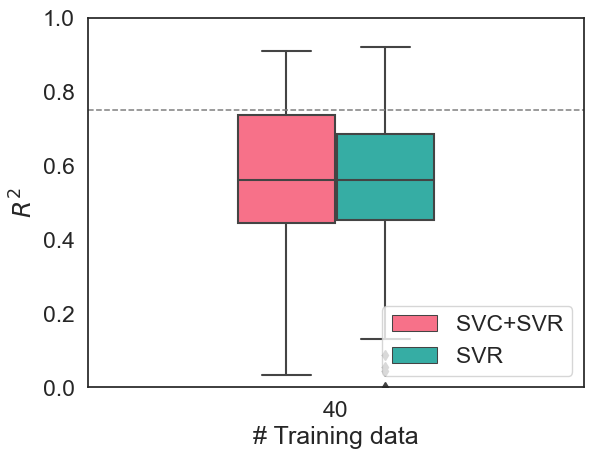

In [855]:
mixNewResult = ComparisonResultsListPlot([newSVMSVRr2List_H[:], newSVRr2List_H[:]], 40, \
                                         xname = '# Training data', yname = '$R^2$', show = 1, \
                              ylimit = [0, 1], yline = 0.75)

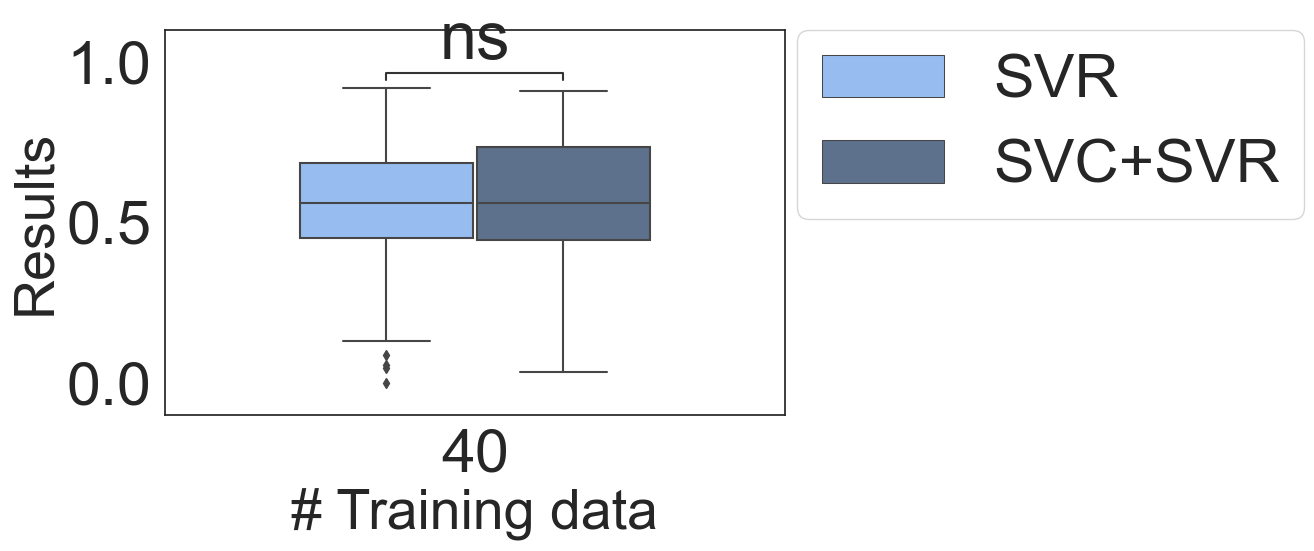

In [856]:
statsPlot(mixNewResult, 'Mann-Whitney')
# t-test_paired, Mann-Whitney

In [836]:
mixNewResult

,Results,# Training data,Method
0,0.485616,40,SVC+SVR
1,0.311165,40,SVC+SVR
2,0.631692,40,SVC+SVR
3,0.718726,40,SVC+SVR
4,0.366516,40,SVC+SVR
...,...,...,...
145,0.433467,40,SVR
146,0.786934,40,SVR
147,0.730704,40,SVR
148,0.502046,40,SVR


['Results']


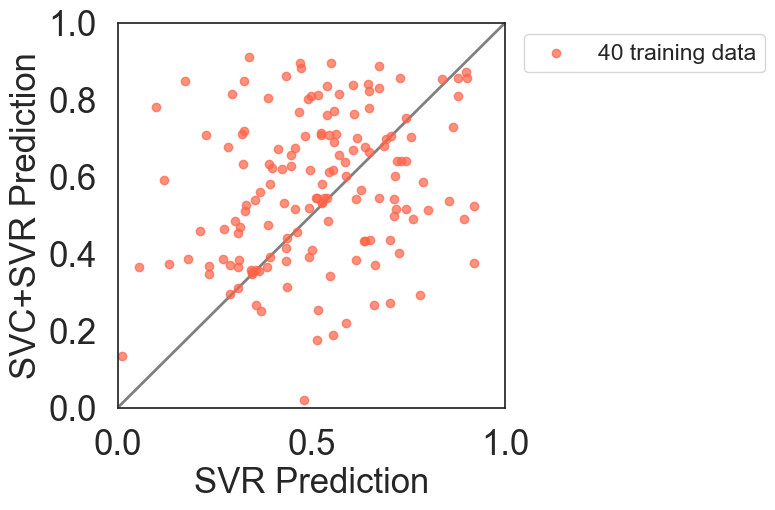

In [837]:
scatterComparisonPlot(mixNewResult)

In [ ]:
mixNewResult['New data location'] = 'Mix'
mixNewResult['First round performance'] = 'Good'

In [ ]:
mixNewResult['Active learning strategy'] = 'III'

## First control: Add in fully random data

20 0.6609854469396321
40
[38, 53, 3, 63, 45, 59, 61, 62, 7, 50, 19, 21, 11, 25, 37, 33, 46, 42, 18, 16, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(C=10000.0, degree=2, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 2, 'C': 10000.0} 0.875


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


R2:  0.45813691017362307
MSE:  0.20675767402439482
Pearson:  0.6768581167228648
Spearman:  0.6190476190476191
R2:  0.4988667811635154
MSE:  0.23067961793809078
Pearson:  0.7063050199195213
Spearman:  0.6666666666666669
R2:  0.9326532101165723
MSE:  0.026649055204619534
Pearson:  0.96573972172453
Spearman:  0.7142857142857144


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5852366347325975, 0.10635098369231022, 0.9186337579986781, 0.7408695652173911]
SVR:  [0.7497034825909923, 0.09447411866690447, 0.8658541924544759, 0.7704347826086956]
40
[38, 53, 3, 63, 45, 59, 61, 62, 7, 50, 19, 21, 11, 25, 37, 33, 46, 42, 18, 16, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(C=10000.0, degree=5, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 5, 'C': 10000.0} 0.9
R2:  0.03473757838460378
MSE:  0.4023816727521602
Pearson:  0.1863801984777455
Spearman:  0.11904761904761905
R2:  0.9815969268819865
MSE:  0.06472399899067038
Pearson:  0.9907557352253816
Spearman:  0.8571428571428572
R2:  0.46134439976665526
MSE:  0.28671916301909295
Pearson:  0.6792233798734073
Spearman:  0.7142857142857144


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7260733973219562, 0.06490449171562708, 0.8548227894700233, 0.7608695652173912]
SVR:  [0.501575922026816, 0.22887094561304547, 0.7082202496588306, 0.8678260869565216]
40
[38, 53, 3, 63, 45, 59, 61, 62, 7, 50, 19, 21, 11, 25, 37, 33, 46, 42, 18, 16, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(C=10000.0, degree=4, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 4, 'C': 10000.0} 0.9
R2:  0.4155548901684456
MSE:  0.2586583032723394
Pearson:  0.6446354707650253
Spearman:  0.8333333333333335
R2:  0.7173989816324523
MSE:  0.11052733377627325
Pearson:  0.8469940859489233
Spearman:  0.7857142857142858
R2:  0.5701159893823428
MSE:  0.14782213910189557
Pearson:  0.7550602554646503
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6482414423079055, 0.09413270808644442, 0.7367241670077522, 0.797391304347826]
SVR:  [0.6656075326637138, 0.10860555267573281, 0.8158477386520805, 0.7608695652173912]
40
[27, 0, 62, 7, 18, 14, 21, 54, 42, 8, 3, 45, 15, 16, 38, 23, 33, 9, 11, 36, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(C=1000.0, degree=5, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 5, 'C': 1000.0} 0.9
R2:  0.9592804300464424
MSE:  0.03209566038486261
Pearson:  0.9794286242735827
Spearman:  0.9523809523809524
R2:  0.561072830573022
MSE:  0.30676952141607894
Pearson:  0.7490479494485129
Spearman:  0.880952380952381
R2:  0.9464872784467891
MSE:  0.04644506244893836
Pearson:  0.9728757775002873
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6119183835259362, 0.3101312176619245, 0.653881449765159, 0.7808695652173911]
SVR:  [0.6003976163763848, 0.28008436620399996, 0.7748532870010847, 0.7815304143742215]
40
[27, 0, 62, 7, 18, 14, 21, 54, 42, 8, 3, 45, 15, 16, 38, 23, 33, 9, 11, 36, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(C=100.0, degree=5, gamma='auto') {'kernel': 'rbf', 'gamma': 'auto', 'degree': 5, 'C': 100.0} 0.9
R2:  0.8514500432700927
MSE:  0.08917454093160217
Pearson:  0.9227405070062182
Spearman:  0.7857142857142858
R2:  0.8272410149279417
MSE:  0.08763785908558541
Pearson:  0.9095279077235296
Spearman:  0.6190476190476191
R2:  0.665277854510305
MSE:  0.21483046677434658
Pearson:  0.81564566725405
Spearman:  0.6190476190476191


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6130218637287916, 0.186971546704351, 0.6442684159742809, 0.7713043478260868]
SVR:  [0.8140744147891101, 0.075173060455967, 0.9022607243968399, 0.7426086956521739]
40
[27, 0, 62, 7, 18, 14, 21, 54, 42, 8, 3, 45, 15, 16, 38, 23, 33, 9, 11, 36, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(C=1000.0, degree=5, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 5, 'C': 1000.0} 0.925
R2:  0.26550389574930316
MSE:  0.29765030733186143
Pearson:  0.5152707014272238
Spearman:  0.523809523809524
R2:  0.8373724507814145
MSE:  0.11107734501479312
Pearson:  0.9150805706501555
Spearman:  0.5952380952380953
R2:  0.608067122132642
MSE:  0.21375787393864865
Pearson:  0.7797865875562633
Spearman:  0.5714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.40421465960480224, 0.2728444333740028, 0.7543646476675798, 0.7643478260869565]
SVR:  [0.3693368663449116, 0.2216084746100715, 0.6077309160680503, 0.5626086956521739]
40
[5, 19, 3, 35, 53, 51, 12, 18, 55, 63, 29, 28, 61, 54, 9, 59, 8, 25, 23, 0, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(C=10000.0, degree=4, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 4, 'C': 10000.0} 0.875
R2:  0.6365102220184443
MSE:  0.26356939532047186
Pearson:  0.7978159073485838
Spearman:  0.7380952380952381
R2:  0.9862022339869785
MSE:  0.013967526096620657
Pearson:  0.9930771540957826
Spearman:  0.7857142857142858
R2:  0.8523905828685098
MSE:  0.06811930189969656
Pearson:  0.9232500110308743
Spearman:  0.6904761904761906


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.49199927989690834, 0.2520717141683791, 0.8575745420863077, 0.7539130434782607]
SVR:  [0.9128059278765064, 0.03359222534867461, 0.9554087752771097, 0.9217391304347825]
40
[5, 19, 3, 35, 53, 51, 12, 18, 55, 63, 29, 28, 61, 54, 9, 59, 8, 25, 23, 0, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(C=10000.0, degree=5, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 5, 'C': 10000.0} 0.925
R2:  0.897449525698582
MSE:  0.05970184209415742
Pearson:  0.9473381263828571
Spearman:  0.7142857142857144
R2:  0.6310000544839237
MSE:  0.29453329509635173
Pearson:  0.7943551186238583
Spearman:  0.523809523809524
R2:  0.9354654755705591
MSE:  0.026303942485615205
Pearson:  0.9671946420294932
Spearman:  0.5714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8332890821465417, 0.034396847357868035, 0.7087430569954278, 0.8059694806801319]
SVR:  [0.5048712683799745, 0.19311521667718945, 0.7105429391528527, 0.8599999999999999]
40
[5, 19, 3, 35, 53, 51, 12, 18, 55, 63, 29, 28, 61, 54, 9, 59, 8, 25, 23, 0, 57, 2, 41, 24, 13, 34, 60, 43, 6, 31, 49, 10, 20, 26, 1, 56, 58, 4, 30, 32]
SVC(C=1000.0, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 3, 'C': 1000.0} 0.9
R2:  0.9460444466137474
MSE:  0.02354137771300556
Pearson:  0.9726481617798635
Spearman:  0.880952380952381
R2:  0.5746727292058045
MSE:  0.17667244881759872
Pearson:  0.7580717177192435
Spearman:  0.6904761904761906
R2:  0.3759748976571284
MSE:  0.31079645387339544
Pearson:  0.6131679196249007
Spearman:  0.5952380952380953


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6728423578711896, 0.1940955618261687, 0.7047477720658637, 0.7617391304347826]
SVR:  [0.6956691174398649, 0.10844688398602591, 0.8340678134539572, 0.8643478260869566]
15 0.6584476271023618
40
[55, 0, 28, 52, 25, 44, 45, 57, 27, 36, 3, 13, 18, 23, 19, 33, 51, 37, 54, 26, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(C=10000.0, gamma=0.0001) {'kernel': 'rbf', 'gamma': 0.0001, 'degree': 3, 'C': 10000.0} 0.925
R2:  0.8807474329831764
MSE:  0.05908595071967416
Pearson:  0.9384814505269545
Spearman:  0.7380952380952381
R2:  0.3472934527824421
MSE:  0.2815261960859593
Pearson:  0.5893160890239142
Spearman:  0.5714285714285715
R2:  0.3823092655623529
MSE:  0.22554022590040548
Pearson:  0.6183116249613562
Spearman:  0.7857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8724744374089729, 0.23543469471417713, 0.6791278375149927, 0.8113043478260868]
SVR:  [0.5085485885437524, 0.1619598440904281, 0.7131259275497932, 0.7878260869565217]
40
[55, 0, 28, 52, 25, 44, 45, 57, 27, 36, 3, 13, 18, 23, 19, 33, 51, 37, 54, 26, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(C=10000.0, degree=4, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 4, 'C': 10000.0} 0.825
R2:  0.9792454877751583
MSE:  0.010608702912102549
Pearson:  0.9895683340604416
Spearman:  0.4285714285714286
R2:  0.6971305546687444
MSE:  0.2717557918732859
Pearson:  0.8349434439941095
Spearman:  0.5952380952380953
R2:  0.005308919092417068
MSE:  0.35725349389291106
Pearson:  -0.07286232972131113
Spearman:  0.14285714285714288


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4458193335902511, 0.19955457366947615, 0.9289050573424094, 0.8539130434782608]
SVR:  [0.7162012165977835, 0.09803999940010599, 0.8462867224515479, 0.82]
40
[55, 0, 28, 52, 25, 44, 45, 57, 27, 36, 3, 13, 18, 23, 19, 33, 51, 37, 54, 26, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(C=100.0, degree=2, gamma='auto') {'kernel': 'rbf', 'gamma': 'auto', 'degree': 2, 'C': 100.0} 0.9
R2:  0.3145970854275449
MSE:  0.2717223913261221
Pearson:  0.5608895483315276
Spearman:  0.7619047619047621
R2:  0.7652911511992172
MSE:  0.1095901313251725
Pearson:  0.8748092084558878
Spearman:  0.6428571428571429
R2:  0.6993888044675244
MSE:  0.1325840190887719
Pearson:  0.8362946875758117
Spearman:  0.6428571428571429


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8366334235741874, 0.04839174898934895, 0.67214757740088, 0.8389721644966083]
SVR:  [0.8428324502017973, 0.050687659211732794, 0.9180590668370949, 0.8130434782608694]
40
[25, 44, 57, 62, 9, 48, 26, 19, 50, 13, 12, 23, 27, 28, 46, 38, 11, 54, 45, 39, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(C=1000.0, degree=4) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 4, 'C': 1000.0} 0.8
R2:  0.5033647302903199
MSE:  0.17206841799942318
Pearson:  0.7094820154805335
Spearman:  0.7619047619047621
R2:  0.5146456888288238
MSE:  0.167835336864561
Pearson:  0.7173881019565519
Spearman:  0.7619047619047621
R2:  0.514341908820202
MSE:  0.16796193448165248
Pearson:  0.7171763442976923
Spearman:  0.7619047619047621


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.23015673289842278, 0.20384830150083325, 0.5361109543269602, 0.5617391304347825]
SVR:  [0.5604242628084994, 0.17236324646273918, 0.7486148961973037, 0.5730434782608694]
40
[25, 44, 57, 62, 9, 48, 26, 19, 50, 13, 12, 23, 27, 28, 46, 38, 11, 54, 45, 39, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(C=1000.0, degree=2) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 2, 'C': 1000.0} 0.8
R2:  0.6721255575866285
MSE:  0.14522411956441442
Pearson:  0.8198326399861307
Spearman:  0.880952380952381
R2:  0.6413423383988036
MSE:  0.1473756137296251
Pearson:  0.8008385220497349
Spearman:  0.880952380952381
R2:  0.8170191434775185
MSE:  0.0834889655048805
Pearson:  0.9038911126222664
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6255106402020454, 0.1359157408341035, 0.4370723714617177, 0.36260869565217385]
SVR:  [0.2687746907701557, 0.33203903804525065, 0.5184348471796199, 0.368695652173913]
40
[25, 44, 57, 62, 9, 48, 26, 19, 50, 13, 12, 23, 27, 28, 46, 38, 11, 54, 45, 39, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(C=100.0, degree=5, gamma=1.0, kernel='poly') {'kernel': 'poly', 'gamma': 1.0, 'degree': 5, 'C': 100.0} 0.925
R2:  0.308773064443551
MSE:  0.14479067455643052
Pearson:  0.5556735232522338
Spearman:  0.4523809523809524
R2:  0.07734625939085733
MSE:  0.27852858787300183
Pearson:  0.27811195477874967
Spearman:  0.30952380952380953
R2:  0.4922404666181547
MSE:  0.10887592474632639
Pearson:  0.7015985081356393
Spearman:  0.5952380952380953


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6255159819204128, 0.29001567238577347, 0.3878935342180675, 0.43478260869565216]
SVR:  [0.03905878967588889, 1.2194387663480002, -0.19763296707758274, 0.0017391304347826085]
40
[15, 28, 5, 51, 8, 54, 11, 22, 33, 48, 21, 18, 19, 17, 46, 50, 55, 25, 47, 37, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(C=100.0, degree=2) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 2, 'C': 100.0} 0.875
R2:  0.466084781460609
MSE:  0.1936585078350977
Pearson:  0.682704021857649
Spearman:  0.4147575310031267
R2:  0.39314748071584954
MSE:  0.21586890205903403
Pearson:  0.6270147372397633
Spearman:  0.4523809523809524
R2:  0.43383680721208817
MSE:  0.38737253730112736
Pearson:  0.6586628934531596
Spearman:  0.523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8166253441137459, 0.07488141207256462, 0.8812781717193465, 0.7773913043478261]
SVR:  [0.7391856093170975, 0.08966681917112813, 0.8597590414279445, 0.8226086956521739]
40
[15, 28, 5, 51, 8, 54, 11, 22, 33, 48, 21, 18, 19, 17, 46, 50, 55, 25, 47, 37, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(C=1000.0, degree=4, kernel='poly') {'kernel': 'poly', 'gamma': 'scale', 'degree': 4, 'C': 1000.0} 0.775
R2:  0.26963720943249203
MSE:  0.29783163711744465
Pearson:  0.5192660295383207
Spearman:  0.5000000000000001
R2:  0.24068904521992407
MSE:  0.3782821109879332
Pearson:  0.49060069834838615
Spearman:  0.7142857142857144
R2:  0.24521975627092954
MSE:  0.38681611400160154
Pearson:  0.49519668443046905
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9294838523726315, 0.27108981877721455, 0.6791552495109887, 0.7773913043478261]
SVR:  [0.8493129438914954, 0.07240948217712723, 0.9215817619134483, 0.88]
40
[15, 28, 5, 51, 8, 54, 11, 22, 33, 48, 21, 18, 19, 17, 46, 50, 55, 25, 47, 37, 16, 58, 49, 1, 60, 56, 30, 10, 43, 32, 59, 6, 34, 20, 63, 42, 40, 31, 2, 24]
SVC(C=100.0, kernel='poly') {'kernel': 'poly', 'gamma': 'scale', 'degree': 3, 'C': 100.0} 0.85
R2:  0.4858495618232627
MSE:  0.1957014300386235
Pearson:  0.6970290968268562
Spearman:  0.6666666666666669
R2:  0.46932706094219034
MSE:  0.2523410479267753
Pearson:  0.6850744929875803
Spearman:  0.5855400437691199
R2:  0.5053796082038567
MSE:  0.33590003031640203
Pearson:  0.710900561403532
Spearman:  0.6904761904761906


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.806612600711314, 0.0801223784255176, 0.859560306720955, 0.5939130434782608]
SVR:  [0.929701834678708, 0.023917328172233198, 0.9642104721888829, 0.9191304347826086]
14 0.5817365754139048
40
[39, 8, 38, 28, 52, 42, 61, 0, 10, 45, 27, 14, 26, 54, 43, 50, 53, 48, 22, 33, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(C=100.0, degree=2, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 2, 'C': 100.0} 0.825
R2:  0.17640631088069303
MSE:  0.347634446992865
Pearson:  0.42000751288601135
Spearman:  0.07142857142857144
R2:  0.6094379046432625
MSE:  0.09807201748665095
Pearson:  0.7806650399776224
Spearman:  0.7142857142857144
R2:  0.24466041441351932
MSE:  0.23149901546603646
Pearson:  0.49463159463738193
Spearman:  0.4047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6415073486204056, 0.2352161753466513, 0.3113412900745631, 0.7191304347826086]
SVR:  [0.6636069031457201, 0.24976287236861316, 0.8146207112182455, 0.7826086956521738]
40
[39, 8, 38, 28, 52, 42, 61, 0, 10, 45, 27, 14, 26, 54, 43, 50, 53, 48, 22, 33, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(C=100.0, degree=4, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 4, 'C': 100.0} 0.8
R2:  0.7805849383247511
MSE:  0.14820096773538916
Pearson:  0.883507180686581
Spearman:  0.7619047619047621
R2:  0.0716724725416886
MSE:  0.548391172243228
Pearson:  -0.26771715025692433
Spearman:  -0.09523809523809526
R2:  0.8964322273046995
MSE:  0.039216588557429446
Pearson:  0.9468010494843675
Spearman:  0.7619047619047621


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.3856216881829985, 0.21464726460503256, 0.752429985175663, 0.7669565217391304]
SVR:  [0.4671228989449259, 0.4722441445798002, 0.6834638973237182, 0.7086956521739128]
40
[39, 8, 38, 28, 52, 42, 61, 0, 10, 45, 27, 14, 26, 54, 43, 50, 53, 48, 22, 33, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(C=1000.0, degree=5, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 5, 'C': 1000.0} 0.8
R2:  0.49417464021949564
MSE:  0.24245734340505054
Pearson:  0.7029755616090047
Spearman:  0.8333333333333335
R2:  0.189445116683593
MSE:  0.36455208753811474
Pearson:  0.4352529341470232
Spearman:  0.30952380952380953
R2:  0.5369471869708902
MSE:  0.2334961368798309
Pearson:  0.7327668025851678
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.2793495097936908, 0.25900282941307257, 0.4380707030509037, 0.8469565217391304]
SVR:  [0.5434563077089256, 0.19605046410148452, 0.7371948912661603, 0.7095652173913043]
40
[23, 11, 37, 15, 53, 48, 3, 7, 47, 33, 21, 44, 39, 25, 22, 8, 9, 12, 27, 61, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(C=1000.0, degree=2, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 2, 'C': 1000.0} 0.95
R2:  0.9401190464809988
MSE:  0.3690802406708251
Pearson:  0.9695973630744872
Spearman:  0.6190476190476191
R2:  0.5195180146145484
MSE:  0.173037109176302
Pearson:  0.720775980880709
Spearman:  0.2142857142857143
R2:  0.9561746998865875
MSE:  0.26085948935024933
Pearson:  0.9778418583219822
Spearman:  0.7619047619047621


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4897509791838789, 0.35845614691017674, 0.7011438593339802, 0.8756521739130434]
SVR:  [0.7845738592515212, 0.10451526643259196, 0.8857617395504961, 0.84]
40
[23, 11, 37, 15, 53, 48, 3, 7, 47, 33, 21, 44, 39, 25, 22, 8, 9, 12, 27, 61, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(C=10000.0, degree=4, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 4, 'C': 10000.0} 0.95
R2:  0.8280478620394113
MSE:  0.19389377637719069
Pearson:  0.9099713523179788
Spearman:  0.7619047619047621
R2:  0.6157575486825969
MSE:  0.31146501378513214
Pearson:  0.7847022038216769
Spearman:  0.8571428571428572
R2:  0.7674169380680232
MSE:  0.24115508086507825
Pearson:  0.8760233661655511
Spearman:  0.4523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.47621122109457137, 0.27394159644231203, 0.6878903666969475, 0.8669565217391304]
SVR:  [0.857317968178458, 0.05897021553481621, 0.9259146657108623, 0.8660869565217391]
40
[23, 11, 37, 15, 53, 48, 3, 7, 47, 33, 21, 44, 39, 25, 22, 8, 9, 12, 27, 61, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(C=100.0, gamma=10.0) {'kernel': 'rbf', 'gamma': 10.0, 'degree': 3, 'C': 100.0} 0.925
R2:  0.953854202415308
MSE:  0.05405830744067156
Pearson:  0.9766545972938988
Spearman:  0.8095238095238096
R2:  0.2680388075390137
MSE:  0.8136941980821321
Pearson:  0.5177246445158021
Spearman:  0.6190476190476191
R2:  0.939592126840543
MSE:  0.024109449051297457
Pearson:  0.9693256041395704
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.46132663629360976, 0.6612429656226854, 0.6241107418136349, 0.6521739130434783]
SVR:  [0.8611406710146365, 0.04760288663500051, 0.927976654347854, 0.8834782608695652]
40
[10, 33, 14, 51, 9, 47, 55, 54, 26, 50, 15, 3, 62, 46, 38, 52, 43, 27, 28, 12, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(C=0.1, degree=5, gamma=1.0, kernel='poly') {'kernel': 'poly', 'gamma': 1.0, 'degree': 5, 'C': 0.1} 0.775
R2:  0.20907638753297497
MSE:  0.368575020695519
Pearson:  0.4572487151791407
Spearman:  0.5000000000000001
R2:  0.0932982277234154
MSE:  0.20842395010516723
Pearson:  0.30544758588572196
Spearman:  0.28571428571428575
R2:  0.0938844777581373
MSE:  0.20862171121447548
Pearson:  0.30640574041316093
Spearman:  0.28571428571428575


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6622594375382828, 0.0851770712647406, 0.850915466688928, 0.6895652173913043]
SVR:  [0.8830990155895586, 0.04165405475751537, 0.9397334811474788, 0.8139130434782607]
40
[10, 33, 14, 51, 9, 47, 55, 54, 26, 50, 15, 3, 62, 46, 38, 52, 43, 27, 28, 12, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(C=10.0, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 3, 'C': 10.0} 0.75
R2:  0.4552428082857131
MSE:  0.24038987466239137
Pearson:  0.6747168356323363
Spearman:  0.5714285714285715
R2:  0.7101608631900299
MSE:  0.14148870382271364
Pearson:  0.8427104266532072
Spearman:  0.7857142857142858
R2:  0.7139818244694975
MSE:  0.1355441529917861
Pearson:  0.844974451962601
Spearman:  0.7857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6570411957609668, 0.11089291676784437, 0.8181106514620886, 0.7947826086956521]
SVR:  [0.41009900555027345, 0.22978140165939354, 0.6403897294228517, 0.7695652173913042]
40
[10, 33, 14, 51, 9, 47, 55, 54, 26, 50, 15, 3, 62, 46, 38, 52, 43, 27, 28, 12, 2, 49, 4, 41, 1, 57, 56, 59, 32, 20, 40, 13, 58, 30, 24, 60, 16, 63, 31, 6]
SVC(C=10000.0, degree=4, gamma='auto') {'kernel': 'rbf', 'gamma': 'auto', 'degree': 4, 'C': 10000.0} 0.825
R2:  0.9343414481850623
MSE:  0.031019238703175703
Pearson:  0.9666133912713302
Spearman:  0.8095238095238096
R2:  0.8555158059713253
MSE:  0.08758944343580909
Pearson:  0.9249409743174563
Spearman:  0.5952380952380953
R2:  0.3896230741438611
MSE:  0.24979304160188573
Pearson:  0.6241979446809007
Spearman:  0.7142857142857144


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.545546365246704, 0.07126594860388462, 0.9503652173102803, 0.6895652173913043]
SVR:  [0.4218939274225447, 0.6729722737297194, 0.6495336230115767, 0.8017391304347825]
26 0.5757938263956837
40
[28, 27, 5, 39, 44, 48, 55, 19, 43, 1, 17, 46, 62, 53, 51, 47, 20, 11, 3, 15, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(gamma=1.0, kernel='poly') {'kernel': 'poly', 'gamma': 1.0, 'degree': 3, 'C': 1.0} 0.875
R2:  0.4219285447621281
MSE:  0.303095957181452
Pearson:  0.6495602703076351
Spearman:  0.7637626158259734
R2:  0.3217663523407954
MSE:  0.30208513824188066
Pearson:  0.5672445260562637
Spearman:  0.4910267673844361
R2:  0.4114965211163462
MSE:  0.21994253508796538
Pearson:  0.6414799459970251
Spearman:  0.6666666666666669


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4450147199824704, 0.17916238401652382, 0.9428750889235114, 0.7504347826086956]
SVR:  [0.49628594832972384, 0.21668610663894006, 0.7044756548878915, 0.6669565217391304]
40
[28, 27, 5, 39, 44, 48, 55, 19, 43, 1, 17, 46, 62, 53, 51, 47, 20, 11, 3, 15, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(C=100.0, degree=4, gamma=10.0) {'kernel': 'rbf', 'gamma': 10.0, 'degree': 4, 'C': 100.0} 0.85
R2:  0.8329618133504737
MSE:  0.09972344411511666
Pearson:  0.9126674166148772
Spearman:  0.9047619047619048
R2:  0.9276251510361302
MSE:  0.30674497011991375
Pearson:  0.9631329872017313
Spearman:  0.6190476190476191
R2:  0.6275090992969496
MSE:  0.14454655992603102
Pearson:  0.7921547192922287
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8946737507936792, 0.041202979223401576, 0.9371309614904646, 0.7417391304347827]
SVR:  [0.8873850839548608, 0.04759700324885738, 0.9420111909923685, 0.7208695652173912]
40
[28, 27, 5, 39, 44, 48, 55, 19, 43, 1, 17, 46, 62, 53, 51, 47, 20, 11, 3, 15, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(C=100.0, degree=2) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 2, 'C': 100.0} 0.85
R2:  0.7623208148762279
MSE:  0.06566760656512437
Pearson:  0.8731098526968001
Spearman:  0.9047619047619048
R2:  0.8752908437658302
MSE:  0.0338981804224263
Pearson:  0.9355697963090888
Spearman:  0.880952380952381
R2:  0.7973369522444542
MSE:  0.0584230809797592
Pearson:  0.8929372610908642
Spearman:  0.7380952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8208778739443545, 0.05769563188035992, 0.8750248485442144, 0.7339130434782607]
SVR:  [0.5207508315418179, 0.18870483584393496, 0.7216306753054625, 0.7669565217391304]
40
[47, 27, 43, 58, 7, 11, 23, 17, 21, 44, 53, 3, 20, 35, 33, 9, 12, 62, 1, 52, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(C=1000.0, degree=4, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 4, 'C': 1000.0} 0.975
R2:  0.16174533698039778
MSE:  0.3614271103647471
Pearson:  0.4021757538445074
Spearman:  0.07142857142857144
R2:  0.2963198959426267
MSE:  0.2569868637199682
Pearson:  0.544352731179542
Spearman:  0.3571428571428572
R2:  0.45891668991013496
MSE:  0.33745930661984913
Pearson:  0.6774339007682852
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.49175404038447207, 0.23990209334068768, 0.8838067790404842, 0.7869565217391304]
SVR:  [0.6682280589767564, 0.10581104952287436, 0.817452175345296, 0.8521739130434782]
40
[47, 27, 43, 58, 7, 11, 23, 17, 21, 44, 53, 3, 20, 35, 33, 9, 12, 62, 1, 52, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(C=10000.0, degree=5, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 5, 'C': 10000.0} 0.975
R2:  0.22919352703293983
MSE:  0.31008457649928645
Pearson:  0.4787416077937448
Spearman:  0.6904761904761906
R2:  0.6960586320139026
MSE:  0.19385090604378227
Pearson:  0.8343012837182396
Spearman:  0.7142857142857144
R2:  0.40591177447752114
MSE:  0.24874819885963384
Pearson:  0.6371120580223869
Spearman:  0.5269555552418339


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7705939857304087, 0.25110746957196955, 0.8471689660845096, 0.7026086956521739]
SVR:  [0.5997888344000968, 0.19746893797822415, 0.7744603504377073, 0.7126705504657425]
40
[47, 27, 43, 58, 7, 11, 23, 17, 21, 44, 53, 3, 20, 35, 33, 9, 12, 62, 1, 52, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(C=1000.0, degree=4, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 4, 'C': 1000.0} 0.975
R2:  0.3412944093168612
MSE:  0.3489608443153214
Pearson:  0.5842040819070515
Spearman:  0.880952380952381
R2:  0.3011122586236247
MSE:  0.3568107710002148
Pearson:  0.5487369667004627
Spearman:  0.5714285714285715
R2:  0.9511502506165713
MSE:  0.017139870520594704
Pearson:  0.9752693220934261
Spearman:  0.9285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5358753593687845, 0.2599704703836712, 0.8179372676801826, 0.6313043478260869]
SVR:  [0.5062150040078872, 0.21897811998397868, 0.7114878804364042, 0.7026086956521739]
40
[58, 48, 22, 62, 36, 17, 21, 50, 18, 28, 20, 0, 14, 43, 54, 46, 53, 27, 12, 45, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(C=10000.0, degree=5, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 5, 'C': 10000.0} 0.9
R2:  0.6537284613563755
MSE:  0.1530983737772276
Pearson:  0.8085347619962768
Spearman:  0.8571428571428572
R2:  0.2599832311090742
MSE:  0.3518031429628518
Pearson:  0.5098855078437454
Spearman:  0.4761904761904762
R2:  0.735573279413272
MSE:  0.3001649096020184
Pearson:  0.8576556881483803
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8278534709134443, 0.3194377389128668, 0.45748265263799304, 0.4591304347826086]
SVR:  [0.3189399778815049, 0.3066319889450932, 0.564747711709844, 0.5878260869565216]
40
[58, 48, 22, 62, 36, 17, 21, 50, 18, 28, 20, 0, 14, 43, 54, 46, 53, 27, 12, 45, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(C=10000.0, kernel='poly') {'kernel': 'poly', 'gamma': 'scale', 'degree': 3, 'C': 10000.0} 0.9
R2:  0.4164014231563612
MSE:  0.290452988677916
Pearson:  0.6452917349202304
Spearman:  0.6666666666666669
R2:  0.3765947720676582
MSE:  0.3235592771440639
Pearson:  0.6136731801762713
Spearman:  0.6904761904761906
R2:  0.6030446454566959
MSE:  0.18349693630604352
Pearson:  0.7765594925417472
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.2112133720131864, 0.22103358292649364, 0.45755018890549837, 0.437391304347826]
SVR:  [0.35644164632364966, 0.20898561395781665, 0.5970273413535174, 0.4652173913043478]
40
[58, 48, 22, 62, 36, 17, 21, 50, 18, 28, 20, 0, 14, 43, 54, 46, 53, 27, 12, 45, 24, 2, 56, 26, 57, 31, 49, 59, 34, 40, 41, 32, 63, 16, 30, 6, 13, 60, 42, 10]
SVC(C=10.0, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 3, 'C': 10.0} 0.85
R2:  0.4491777745452715
MSE:  0.2662410049516782
Pearson:  0.6702072623787895
Spearman:  0.7619047619047621
R2:  0.9310291407392824
MSE:  0.027753730047477554
Pearson:  0.964898513181196
Spearman:  0.8571428571428572
R2:  0.9040078767540988
MSE:  0.04573041020792728
Pearson:  0.9507932881305476
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.2585416814956146, 0.33065428032839306, 0.5041640155110809, 0.27304347826086955]
SVR:  [0.2302240371809776, 0.31935100216977313, 0.47981667038669834, 0.45652173913043476]
28 0.5530175969011716
40
[31, 55, 52, 17, 19, 2, 5, 36, 39, 45, 15, 47, 48, 23, 35, 46, 8, 54, 6, 50, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(gamma=1.0, kernel='poly') {'kernel': 'poly', 'gamma': 1.0, 'degree': 3, 'C': 1.0} 0.825
R2:  0.5558617201591183
MSE:  0.12356435977149616
Pearson:  0.7455613456712455
Spearman:  0.8571428571428572
R2:  0.5131377626942465
MSE:  0.22548942317529466
Pearson:  0.7163363474613351
Spearman:  0.5714285714285715
R2:  0.921904827482097
MSE:  0.03595066724938822
Pearson:  0.9601587511875821
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6275736577798434, 0.10754208094008445, 0.6509561463285889, 0.6634782608695651]
SVR:  [0.7861698338426243, 0.0741352883519761, 0.88666218699267, 0.8026086956521737]
40
[31, 55, 52, 17, 19, 2, 5, 36, 39, 45, 15, 47, 48, 23, 35, 46, 8, 54, 6, 50, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=10000.0, degree=2, gamma=0.0001) {'kernel': 'rbf', 'gamma': 0.0001, 'degree': 2, 'C': 10000.0} 0.825
R2:  0.9260202787096741
MSE:  0.03387635177477525
Pearson:  0.9622994745450474
Spearman:  0.8095238095238096
R2:  0.8733613723941251
MSE:  0.05419532835147958
Pearson:  0.9345380529406627
Spearman:  0.8095238095238096
R2:  0.9609298577960909
MSE:  0.01256561687137938
Pearson:  0.9802702983341336
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.766533752694403, 0.1447127136433574, 0.8662494638419409, 0.766086956521739]
SVR:  [0.5100089978703967, 0.2250055774184573, 0.7141491425958563, 0.7773913043478261]
40
[31, 55, 52, 17, 19, 2, 5, 36, 39, 45, 15, 47, 48, 23, 35, 46, 8, 54, 6, 50, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=1000.0, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 3, 'C': 1000.0} 0.9
R2:  0.004426760583998568
MSE:  0.4375143408297226
Pearson:  -0.06653390552191088
Spearman:  -0.19047619047619052
R2:  0.01138383863713046
MSE:  0.4461753779187627
Pearson:  -0.10669507316240266
Spearman:  -0.30952380952380953
R2:  0.11229442542742232
MSE:  0.4587784640061263
Pearson:  -0.3351036040203422
Spearman:  -0.30952380952380953


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.32063338959183024, 0.2256222904696429, 0.6611796870237924, 0.6713043478260868]
SVR:  [0.6942630551785389, 0.12039619100835758, 0.8332244926660155, 0.7808695652173911]
40
[55, 37, 2, 21, 54, 8, 47, 62, 4, 28, 38, 9, 27, 50, 23, 14, 33, 52, 56, 31, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=10000.0, degree=2, gamma=0.0001) {'kernel': 'rbf', 'gamma': 0.0001, 'degree': 2, 'C': 10000.0} 0.925
R2:  0.08844209758661947
MSE:  0.2579138491706325
Pearson:  0.297392161272989
Spearman:  0.04761904761904763
R2:  0.9250163794139353
MSE:  0.026675091652633175
Pearson:  0.9617777182977028
Spearman:  0.6428571428571429
R2:  0.9162842847437404
MSE:  0.03613231018535029
Pearson:  0.9572273944804024
Spearman:  0.8571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5996970276051903, 0.18015363884259264, 0.7100327028018417, 0.7469565217391304]
SVR:  [0.5042835240952721, 0.1783943056220959, 0.7101292305596727, 0.7460869565217391]
40
[55, 37, 2, 21, 54, 8, 47, 62, 4, 28, 38, 9, 27, 50, 23, 14, 33, 52, 56, 31, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=1000.0, degree=2, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 2, 'C': 1000.0} 0.875
R2:  0.0017224052011093102
MSE:  0.323137575346088
Pearson:  0.041501869850758655
Spearman:  0.14285714285714288
R2:  0.5825427874496445
MSE:  0.2932593026660363
Pearson:  0.7632449065992151
Spearman:  0.5476190476190477
R2:  0.45507041556707123
MSE:  0.9717143670161783
Pearson:  0.6745890716332954
Spearman:  0.4047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.455579781117708, 0.25879765305772134, 0.8069622586455013, 0.8139130434782607]
SVR:  [0.6595265681641452, 0.11958001897320612, 0.8121124110393496, 0.7913043478260868]
40
[55, 37, 2, 21, 54, 8, 47, 62, 4, 28, 38, 9, 27, 50, 23, 14, 33, 52, 56, 31, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=10000.0, degree=2, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 2, 'C': 10000.0} 0.925
R2:  0.4345792318565813
MSE:  0.1697960050812039
Pearson:  0.659226237233153
Spearman:  0.4047619047619048
R2:  0.6326359076123069
MSE:  0.18375463373172782
Pearson:  0.7953841258236845
Spearman:  0.9523809523809524
R2:  0.5510526938688735
MSE:  0.16699569826923688
Pearson:  0.742329235493843
Spearman:  0.7619047619047621


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6374218524842257, 0.08234141887258942, 0.6913630319199302, 0.7391304347826086]
SVR:  [0.5440677676712156, 0.20831096356615345, 0.7376094953776121, 0.551304347826087]
40
[15, 44, 14, 62, 54, 56, 35, 12, 38, 7, 31, 53, 37, 39, 52, 8, 25, 18, 61, 2, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=1000.0, degree=5, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 5, 'C': 1000.0} 0.925
R2:  0.19209224475957315
MSE:  0.26244922748240807
Pearson:  0.438283292813647
Spearman:  0.6428571428571429
R2:  0.6661663367760357
MSE:  0.12341689755937371
Pearson:  0.8161901351866703
Spearman:  0.2380952380952381
R2:  0.9936790966922526
MSE:  0.002341607604459975
Pearson:  0.9968345382721511
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6665900109599652, 0.08558490012746127, 0.818013937295673, 0.7577360030968673]
SVR:  [0.7736381958521649, 0.06874377302951278, 0.8795670502310582, 0.797391304347826]
40
[15, 44, 14, 62, 54, 56, 35, 12, 38, 7, 31, 53, 37, 39, 52, 8, 25, 18, 61, 2, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(degree=4, gamma=1.0, kernel='poly') {'kernel': 'poly', 'gamma': 1.0, 'degree': 4, 'C': 1.0} 0.825
R2:  0.5859754412477527
MSE:  0.3734341133408578
Pearson:  0.7654903273378135
Spearman:  0.4761904761904762
R2:  0.8948189035223144
MSE:  0.034547443871952625
Pearson:  0.9459486791165336
Spearman:  0.7857142857142858
R2:  0.7757255753246067
MSE:  0.0831886335710442
Pearson:  0.8807528457658296
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.2944888228535961, 0.29716952935897545, 0.3662238764670715, 0.677391304347826]
SVR:  [0.733375551368581, 0.11060030574004816, 0.8563734882448086, 0.7330434782608695]
40
[15, 44, 14, 62, 54, 56, 35, 12, 38, 7, 31, 53, 37, 39, 52, 8, 25, 18, 61, 2, 57, 20, 16, 1, 34, 40, 58, 41, 13, 49, 43, 26, 32, 24, 42, 63, 30, 59, 10, 60]
SVC(C=1000.0, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 3, 'C': 1000.0} 0.925
R2:  0.8714039594511573
MSE:  0.04523578614460082
Pearson:  0.9334902031897052
Spearman:  0.6428571428571429
R2:  0.4326169512282275
MSE:  0.5447458166650212
Pearson:  0.657736232260492
Spearman:  0.8095238095238096
R2:  0.8387274328367725
MSE:  0.060484409865897565
Pearson:  0.9158206335504634
Spearman:  0.6666666666666669


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6751139301559645, 0.11057535439607452, 0.8682931857015226, 0.6852173913043478]
SVR:  [0.8261549607394376, 0.05868307733053654, 0.9089306688298272, 0.8434782608695651]
27 0.5317356294894106
40
[8, 55, 15, 52, 61, 27, 25, 54, 33, 21, 37, 62, 3, 50, 46, 0, 51, 22, 39, 18, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(C=100.0, degree=4, gamma=10.0) {'kernel': 'rbf', 'gamma': 10.0, 'degree': 4, 'C': 100.0} 0.85
R2:  0.15375990173452697
MSE:  0.288819799289315
Pearson:  0.3921223045613791
Spearman:  0.07142857142857144
R2:  0.7105954442084608
MSE:  0.0980395393857839
Pearson:  0.8429682344005975
Spearman:  0.8333333333333335
R2:  0.733508969707913
MSE:  0.12382534758684581
Pearson:  0.8564513819872748
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5649362529507186, 1.3673913491463416, 0.7516224138160853, 0.5417391304347825]
SVR:  [0.6744457804958882, 0.18112065152974996, 0.8212464797464207, 0.8930434782608694]
40
[8, 55, 15, 52, 61, 27, 25, 54, 33, 21, 37, 62, 3, 50, 46, 0, 51, 22, 39, 18, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(C=10.0, degree=4, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 4, 'C': 10.0} 0.85
R2:  0.6399897259583425
MSE:  0.18027948135086772
Pearson:  0.799993578698193
Spearman:  0.880952380952381
R2:  0.6688313195889146
MSE:  0.13332817958463672
Pearson:  0.8178210804258559
Spearman:  0.9047619047619048
R2:  0.736394835672855
MSE:  0.0993305164240802
Pearson:  0.8581345090793489
Spearman:  0.8571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8034676101624674, 0.07779152152982682, 0.8996253199226693, 0.7982608695652172]
SVR:  [0.6608850329715072, 0.299889811238184, 0.8129483581209249, 0.7530434782608695]
40
[8, 55, 15, 52, 61, 27, 25, 54, 33, 21, 37, 62, 3, 50, 46, 0, 51, 22, 39, 18, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(C=100.0, degree=5, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 5, 'C': 100.0} 0.85
R2:  0.12519817137194938
MSE:  0.28661693571359137
Pearson:  0.35383353624543473
Spearman:  0.5714285714285715
R2:  0.5928422237704662
MSE:  0.18390552150807882
Pearson:  0.7699624820538117
Spearman:  0.5476190476190477
R2:  0.6463026301316644
MSE:  0.1379653944100676
Pearson:  0.803929493258995
Spearman:  0.7142857142857144


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6772722051208407, 0.12274484736423552, 0.9176732595405458, 0.8573913043478261]
SVR:  [0.7334343836700514, 0.10802807048610702, 0.8564078372306339, 0.8026086956521737]
40
[37, 23, 22, 55, 36, 62, 44, 61, 3, 54, 8, 41, 2, 29, 7, 14, 25, 45, 11, 52, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(C=10.0, degree=4, gamma=10.0) {'kernel': 'rbf', 'gamma': 10.0, 'degree': 4, 'C': 10.0} 0.925
R2:  0.5467138515444477
MSE:  0.17630552783729295
Pearson:  0.739401008617413
Spearman:  0.6190476190476191
R2:  0.8739588217152041
MSE:  0.06504989724375872
Pearson:  0.9348576478347941
Spearman:  0.8095238095238096
R2:  0.9119942049984542
MSE:  0.0771405631933248
Pearson:  0.9549838768264381
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5520839332492199, 0.15054571190398666, 0.7044330689639449, 0.7913043478260868]
SVR:  [0.5234195195730457, 0.1763423957485407, 0.7234773801391758, 0.5991304347826086]
40
[37, 23, 22, 55, 36, 62, 44, 61, 3, 54, 8, 41, 2, 29, 7, 14, 25, 45, 11, 52, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(C=100.0, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 3, 'C': 100.0} 0.975
R2:  0.28435774752659404
MSE:  0.23443714711696834
Pearson:  0.5332520487786183
Spearman:  0.6190476190476191
R2:  0.8729741573165964
MSE:  0.05811673311758978
Pearson:  0.9343308607322123
Spearman:  0.4523809523809524
R2:  0.2973059477212196
MSE:  0.2889571652311515
Pearson:  0.5452576892820674
Spearman:  0.7142857142857144


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5328573756483668, 0.1601528020381703, 0.7291934574406587, 0.8226086956521739]
SVR:  [0.5592443262256337, 0.1514886015366635, 0.7478264011290547, 0.7582608695652173]
40
[37, 23, 22, 55, 36, 62, 44, 61, 3, 54, 8, 41, 2, 29, 7, 14, 25, 45, 11, 52, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(C=10.0, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 3, 'C': 10.0} 0.925
R2:  0.9723672880540781
MSE:  0.014843197573729363
Pearson:  0.9860868562424295
Spearman:  0.8095238095238096
R2:  0.9450554704549652
MSE:  0.024201122637427068
Pearson:  0.9721396352659248
Spearman:  0.7380952380952381
R2:  0.5376052889995654
MSE:  0.2794366027205816
Pearson:  0.7332157179163341
Spearman:  0.6904761904761906


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5722869529630319, 0.16425186137345105, 0.7439009067823503, 0.786086956521739]
SVR:  [0.5191422876606548, 0.22886526511108204, 0.7205152931483513, 0.64]
40
[37, 55, 39, 35, 9, 50, 38, 36, 23, 2, 22, 11, 7, 53, 17, 25, 33, 48, 28, 45, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(C=10000.0, degree=4) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 4, 'C': 10000.0} 0.85
R2:  0.6852963549353127
MSE:  0.11729545806671103
Pearson:  0.8278262830662682
Spearman:  0.4285714285714286
R2:  0.774476302830855
MSE:  0.08093525334876989
Pearson:  0.8800433528132892
Spearman:  0.880952380952381
R2:  0.7248153753710749
MSE:  0.08639161318949297
Pearson:  0.8513608960781998
Spearman:  0.5714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6512416156039585, 0.1297221008426295, 0.8042591756316885, 0.8147826086956521]
SVR:  [0.7639348848386693, 0.10995537218366751, 0.8740336863294629, 0.8756521739130434]
40
[37, 55, 39, 35, 9, 50, 38, 36, 23, 2, 22, 11, 7, 53, 17, 25, 33, 48, 28, 45, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(C=1000.0, degree=5, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 5, 'C': 1000.0} 0.9
R2:  0.5967210259715675
MSE:  0.15146237485580158
Pearson:  0.7724772009396571
Spearman:  0.6904761904761906
R2:  0.46075294779392445
MSE:  0.19201284444699768
Pearson:  0.6787878518314281
Spearman:  0.9047619047619048
R2:  0.3485732174986482
MSE:  0.21410466297866887
Pearson:  0.5904008955774442
Spearman:  0.7380952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8049039827200754, 0.07285026124120116, 0.8796533467140946, 0.8313043478260868]
SVR:  [0.8136519124559455, 0.07146692721232571, 0.9020265586200589, 0.7852173913043478]
40
[37, 55, 39, 35, 9, 50, 38, 36, 23, 2, 22, 11, 7, 53, 17, 25, 33, 48, 28, 45, 26, 58, 40, 57, 4, 56, 34, 20, 10, 24, 63, 60, 42, 31, 13, 32, 59, 1, 43, 49]
SVC(C=100.0, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 3, 'C': 100.0} 0.8
R2:  0.44362323250198205
MSE:  0.28211361133710866
Pearson:  0.666050472938787
Spearman:  0.8333333333333335
R2:  0.8860690139131068
MSE:  0.03843380869807583
Pearson:  0.941312389121224
Spearman:  0.7619047619047621
R2:  0.9073684980298566
MSE:  0.03634731062166875
Pearson:  0.9525589210279097
Spearman:  0.7619047619047621


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7863531745937413, 0.054065120212922, 0.8957394939065177, 0.64]
SVR:  [0.5323530006356935, 0.24616332963915288, 0.7296252467093596, 0.8095652173913043]
24 0.5123170441709317
40
[52, 5, 61, 36, 35, 17, 37, 9, 53, 25, 55, 8, 49, 1, 14, 22, 12, 28, 50, 15, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


SVC(C=100.0, degree=2) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 2, 'C': 100.0} 0.9
R2:  0.4045210222291998
MSE:  0.3366552086327188
Pearson:  0.6360196712596236
Spearman:  0.6666666666666669
R2:  0.48361696598463233
MSE:  1.1701296290236585
Pearson:  0.695425744407433
Spearman:  0.8333333333333335
R2:  0.7290568082628168
MSE:  0.15903887068318087
Pearson:  0.8538482349122803
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6417085805414993, 0.13929257941874387, 0.7720113511735921, 0.7417391304347827]
SVR:  [0.6010065529806196, 0.22689898729736077, 0.7752461241313107, 0.7947826086956521]
40
[52, 5, 61, 36, 35, 17, 37, 9, 53, 25, 55, 8, 49, 1, 14, 22, 12, 28, 50, 15, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(C=10000.0, degree=4, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 4, 'C': 10000.0} 0.925
R2:  0.34076660395969094
MSE:  0.4003469924600109
Pearson:  0.5837521768350771
Spearman:  0.7380952380952381
R2:  0.932434988403384
MSE:  0.0466737981151773
Pearson:  0.9656267334759241
Spearman:  0.9047619047619048
R2:  0.3335819679987975
MSE:  0.24086941775711013
Pearson:  0.5775655529884012
Spearman:  0.6904761904761906


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5435388620227569, 0.13116737664992073, 0.9132630978125664, 0.8826086956521739]
SVR:  [0.5530764603191146, 0.21874572660958477, 0.7436911054457453, 0.8147826086956521]
40
[52, 5, 61, 36, 35, 17, 37, 9, 53, 25, 55, 8, 49, 1, 14, 22, 12, 28, 50, 15, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(C=10000.0, degree=2, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 2, 'C': 10000.0} 0.95
R2:  0.6751947067427757
MSE:  0.4672295789538805
Pearson:  0.8217023224640272
Spearman:  0.6904761904761906
R2:  0.6816871427301745
MSE:  0.46934531408851154
Pearson:  0.8256434719236714
Spearman:  0.6904761904761906
R2:  0.6807151301278764
MSE:  0.4584404213047378
Pearson:  0.8250546225116714
Spearman:  0.6904761904761906


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8262287716849434, 0.23302609673353766, 0.756241367101913, 0.8052173913043478]
SVR:  [0.5766761515053541, 0.2042449629088355, 0.7593919617070974, 0.8826086956521739]
40
[27, 41, 45, 46, 28, 1, 33, 22, 25, 55, 35, 61, 21, 8, 53, 32, 11, 47, 12, 44, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(C=10000.0, degree=5, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 5, 'C': 10000.0} 0.95
R2:  0.42019748557344466
MSE:  0.3903752080951095
Pearson:  0.6482264153622905
Spearman:  0.28571428571428575
R2:  0.9563203824924537
MSE:  0.39414322356220516
Pearson:  0.9779163473899259
Spearman:  0.5476190476190477
R2:  0.9927932058566362
MSE:  0.0051305355850956155
Pearson:  0.9963900871930813
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5169462999137647, 0.22120587921840063, 0.740812779975943, 0.6408695652173912]
SVR:  [0.5404413883529412, 0.2761048310278942, 0.7351471882235158, 0.7426086956521739]
40
[27, 41, 45, 46, 28, 1, 33, 22, 25, 55, 35, 61, 21, 8, 53, 32, 11, 47, 12, 44, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(C=1000.0, degree=5, kernel='poly') {'kernel': 'poly', 'gamma': 'scale', 'degree': 5, 'C': 1000.0} 0.925
R2:  0.44155113466876267
MSE:  0.22978674352723738
Pearson:  0.6644931411751085
Spearman:  0.8095238095238096
R2:  0.944972148089313
MSE:  0.021819620251790108
Pearson:  0.9720967791785513
Spearman:  0.8333333333333335
R2:  0.3877255129025644
MSE:  0.34579673762098684
Pearson:  0.6226760898754375
Spearman:  0.6190476190476191


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.67433622585128, 0.21479969221538076, 0.6948007454234968, 0.6078260869565217]
SVR:  [0.45833815110548715, 0.18726543742119317, 0.6770067585375253, 0.5678260869565217]
40
[27, 41, 45, 46, 28, 1, 33, 22, 25, 55, 35, 61, 21, 8, 53, 32, 11, 47, 12, 44, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(C=10000.0, degree=4, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 4, 'C': 10000.0} 0.975
R2:  0.5136634960086801
MSE:  0.2101075363896059
Pearson:  0.7167032133377667
Spearman:  0.6428571428571429
R2:  0.25917318067437
MSE:  0.3269435116392758
Pearson:  0.5090905427076504
Spearman:  0.4285714285714286
R2:  0.524174783328503
MSE:  0.21695676867236857
Pearson:  0.7239991597567658
Spearman:  0.4523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4324333340799495, 0.25929726272064785, 0.6852042568230519, 0.6408695652173912]
SVR:  [0.27079896841870577, 0.2592931607221827, 0.5203834820771177, 0.502003511027176]
40
[19, 43, 54, 41, 22, 3, 9, 33, 53, 23, 7, 14, 45, 17, 29, 11, 52, 50, 35, 15, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(C=1000.0, degree=2, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 2, 'C': 1000.0} 0.95
R2:  0.9514723482938877
MSE:  0.1810417419987106
Pearson:  0.9754344407974774
Spearman:  1.0
R2:  0.5628123867193541
MSE:  0.13000088642332447
Pearson:  0.7502082289067176
Spearman:  0.9461247469114746
R2:  0.8854544676665627
MSE:  0.29596084230672004
Pearson:  0.9409859019488882
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7212749559115963, 0.09883713806989654, 0.7378300075750501, 0.728695652173913]
SVR:  [0.7080807473126384, 0.10472466551001963, 0.8414753396937062, 0.7817391304347826]
40
[19, 43, 54, 41, 22, 3, 9, 33, 53, 23, 7, 14, 45, 17, 29, 11, 52, 50, 35, 15, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(C=1000.0, degree=5) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 5, 'C': 1000.0} 0.925
R2:  0.46828180757698884
MSE:  0.24492871083595802
Pearson:  0.6843111920588387
Spearman:  0.7619047619047621
R2:  0.9152095522243543
MSE:  0.05333345526291908
Pearson:  0.9566658519171438
Spearman:  0.8333333333333335
R2:  0.7951204747474053
MSE:  0.13966722202704157
Pearson:  0.8916952813306825
Spearman:  0.8571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6137560453402837, 0.21952705842786802, 0.8446679141424368, 0.7504347826086956]
SVR:  [0.5409955106608544, 0.20931427231456445, 0.7355239701470335, 0.7721739130434783]
40
[19, 43, 54, 41, 22, 3, 9, 33, 53, 23, 7, 14, 45, 17, 29, 11, 52, 50, 35, 15, 63, 20, 24, 58, 34, 4, 40, 56, 30, 2, 59, 26, 10, 57, 16, 60, 31, 6, 42, 13]
SVC(degree=2, gamma=10.0) {'kernel': 'rbf', 'gamma': 10.0, 'degree': 2, 'C': 1.0} 0.925
R2:  0.22475251278748218
MSE:  0.2860078394850095
Pearson:  0.4740807028212414
Spearman:  -0.04761904761904763
R2:  0.8092878776427949
MSE:  0.06893196674375991
Pearson:  0.899604289475542
Spearman:  0.5476190476190477
R2:  0.9956190518604162
MSE:  0.003993959340926038
Pearson:  0.997807121572309
Spearman:  0.8095238095238096


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6080900211395368, 0.1406413243232637, 0.7798331756032248, 0.7582608695652173]
SVR:  [0.6176064511403767, 0.2256548043360398, 0.7858794125948183, 0.7091770673752239]
29 0.46176921755990397
40
[2, 40, 5, 18, 34, 61, 23, 9, 21, 46, 14, 3, 17, 25, 8, 11, 7, 37, 53, 19, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=1000.0, degree=4, gamma='auto') {'kernel': 'rbf', 'gamma': 'auto', 'degree': 4, 'C': 1000.0} 0.875
R2:  0.9691723700503502
MSE:  0.018492213410199906
Pearson:  0.9844655250694918
Spearman:  0.6428571428571429
R2:  0.9822257104645392
MSE:  0.017830787143464394
Pearson:  0.9910730096539504
Spearman:  0.9523809523809524
R2:  0.6618183061691861
MSE:  0.18103998180608732
Pearson:  0.8135221608347163
Spearman:  0.6904761904761906


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.686403381668379, 0.3185034680543522, 0.7252915667614444, 0.8695652173913043]
SVR:  [0.5510356334334612, 0.35613149498883256, 0.7423177442534037, 0.8095652173913043]
40
[2, 40, 5, 18, 34, 61, 23, 9, 21, 46, 14, 3, 17, 25, 8, 11, 7, 37, 53, 19, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=10000.0, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 3, 'C': 10000.0} 0.975
R2:  0.9373242946239762
MSE:  0.03513941136839423
Pearson:  0.9681550984341178
Spearman:  0.8095238095238096
R2:  0.8663058089170856
MSE:  0.21253709912865815
Pearson:  0.9307555043710919
Spearman:  0.6190476190476191
R2:  0.9350442370303392
MSE:  0.31755963838719
Pearson:  0.9669768544439621
Spearman:  0.6190476190476191


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.793106558960094, 0.22175300539043827, 0.8205608133301263, 0.7817391304347826]
SVR:  [0.48465060490064993, 0.1773856325436782, 0.6961685176023474, 0.7765217391304347]
40
[2, 40, 5, 18, 34, 61, 23, 9, 21, 46, 14, 3, 17, 25, 8, 11, 7, 37, 53, 19, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=10.0, degree=5) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 5, 'C': 10.0} 0.925
R2:  0.5752777307100362
MSE:  0.2157892147404496
Pearson:  0.7584706525041269
Spearman:  0.9027075674773933
R2:  0.9350642954999593
MSE:  0.03496609275030545
Pearson:  0.9669872261307072
Spearman:  0.9047619047619048
R2:  0.9584085167304119
MSE:  0.015750355597138534
Pearson:  0.9789834098341054
Spearman:  0.6904761904761906


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5766338086751974, 0.05697887317413638, 0.8860553908901321, 0.8278260869565216]
SVR:  [0.6347421549781261, 0.22827095856759286, 0.7967070697427794, 0.8252173913043478]
40
[2, 28, 39, 7, 34, 55, 45, 14, 51, 46, 5, 11, 44, 54, 12, 15, 8, 27, 19, 21, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=1000.0, degree=2, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 2, 'C': 1000.0} 0.85
R2:  0.42457791158726277
MSE:  0.20608437860434756
Pearson:  0.6515964330682471
Spearman:  0.6190476190476191
R2:  0.21596126856365622
MSE:  0.27776438306459855
Pearson:  0.464716331285717
Spearman:  0.34156502553198664
R2:  0.7097637116579684
MSE:  0.15893967821472732
Pearson:  0.8424747543149103
Spearman:  0.8571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8906453161439568, 0.13954407960407245, 0.8504654440591031, 0.7643478260869565]
SVR:  [0.4765004596361141, 0.7801634446545692, 0.6902901271466324, 0.8539130434782608]
40
[2, 28, 39, 7, 34, 55, 45, 14, 51, 46, 5, 11, 44, 54, 12, 15, 8, 27, 19, 21, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=10000.0, degree=5) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 5, 'C': 10000.0} 0.85
R2:  0.07814691487057832
MSE:  0.32929554882264983
Pearson:  0.2795476969509466
Spearman:  0.2142857142857143
R2:  0.004274397833155068
MSE:  0.6959814266731288
Pearson:  -0.06537887910598549
Spearman:  0.09523809523809526
R2:  0.307490522229218
MSE:  0.2619005537352005
Pearson:  0.5545182794365014
Spearman:  0.04761904761904763


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.42771078571563464, 0.24443189004635313, 0.6378936158095532, 0.8495652173913043]
SVR:  [0.4739208527724511, 0.7972963229687015, 0.6884190967517178, 0.8460869565217389]
40
[2, 28, 39, 7, 34, 55, 45, 14, 51, 46, 5, 11, 44, 54, 12, 15, 8, 27, 19, 21, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=1000.0, degree=4, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 4, 'C': 1000.0} 0.9
R2:  0.9821214499857598
MSE:  0.008244687013819446
Pearson:  0.9910204084607741
Spearman:  0.9523809523809524
R2:  0.42436149999490685
MSE:  0.19739629592773877
Pearson:  0.6514303493044417
Spearman:  0.3571428571428572
R2:  0.26589179220586834
MSE:  0.6445051633289873
Pearson:  0.5156469647014985
Spearman:  0.7142857142857144


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7492079370689407, 0.24139706998818067, 0.6446017526099881, 0.8513043478260869]
SVR:  [0.4159836627133938, 0.22894798894646998, 0.6449679547957354, 0.7643478260869565]
40
[2, 37, 55, 46, 35, 0, 39, 54, 25, 61, 44, 11, 53, 12, 15, 62, 14, 9, 5, 38, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=1000.0, gamma=0.1, kernel='poly') {'kernel': 'poly', 'gamma': 0.1, 'degree': 3, 'C': 1000.0} 0.85
R2:  0.734149602692544
MSE:  0.09336899309737837
Pearson:  0.8568253046523218
Spearman:  0.5476190476190477
R2:  0.8985374284085517
MSE:  0.0498298959114568
Pearson:  0.9479121417138572
Spearman:  0.6904761904761906
R2:  0.4345344827710772
MSE:  0.2875973119953741
Pearson:  0.6591922957461482
Spearman:  0.6190476190476191


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4718885513199973, 0.21428690582157153, 0.6517883062753602, 0.7799999999999999]
SVR:  [0.525187562289659, 0.23067669992609696, 0.724698256027748, 0.8052173913043478]
40
[2, 37, 55, 46, 35, 0, 39, 54, 25, 61, 44, 11, 53, 12, 15, 62, 14, 9, 5, 38, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=10000.0, degree=5, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 5, 'C': 10000.0} 0.9
R2:  0.004512443113362381
MSE:  0.5441718356753802
Pearson:  0.06717472079110104
Spearman:  0.023809523809523815
R2:  0.031364318006035063
MSE:  0.4544271021004638
Pearson:  0.17709974027658842
Spearman:  0.023809523809523815
R2:  0.6663189985984462
MSE:  0.08878869567483852
Pearson:  0.8162836508214815
Spearman:  0.4761904761904762


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8255542853408028, 0.13943337783152235, 0.7578283782457318, 0.7869565217391304]
SVR:  [0.6078520381636922, 0.14732921522752535, 0.7796486632860294, 0.7643478260869565]
40
[2, 37, 55, 46, 35, 0, 39, 54, 25, 61, 44, 11, 53, 12, 15, 62, 14, 9, 5, 38, 24, 43, 20, 49, 16, 63, 41, 56, 58, 4, 10, 32, 42, 13, 26, 6, 59, 31, 1, 60]
SVC(C=10000.0, degree=5, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 5, 'C': 10000.0} 0.9
R2:  0.05687028098946467
MSE:  0.37559280532817013
Pearson:  0.23847490641462613
Spearman:  0.3333333333333334
R2:  0.14810600667653942
MSE:  0.4735705261031723
Pearson:  0.38484543218874173
Spearman:  0.3333333333333334
R2:  0.1248405298397175
MSE:  0.31407636403865113
Pearson:  0.3533277937549175
Spearman:  0.3333333333333334


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4669203985720127, 0.1780930692283392, 0.7485628184200952, 0.42183084276171967]
SVR:  [0.5124049658242178, 0.17020964781918935, 0.7158246753390232, 0.6130434782608695]
18 0.39772570524272743
40
[25, 10, 16, 45, 61, 18, 37, 15, 6, 59, 46, 44, 7, 23, 47, 54, 12, 38, 52, 51, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


SVC(gamma=10.0, kernel='poly') {'kernel': 'poly', 'gamma': 10.0, 'degree': 3, 'C': 1.0} 0.825
R2:  0.349070920142329
MSE:  0.32817047144457023
Pearson:  0.59082224073094
Spearman:  0.8095238095238096
R2:  0.21266663591676485
MSE:  0.3233254976299744
Pearson:  0.4611579294740195
Spearman:  0.5000000000000001
R2:  0.4848374082410289
MSE:  0.34479013845670514
Pearson:  0.6963026699941834
Spearman:  0.8095238095238096


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.36328967453933037, 0.0904710569297039, 0.6888730003489725, 0.7654114278611774]
SVR:  [0.8326647917232646, 0.05458600142963582, 0.9125046803843059, 0.8530434782608695]
40
[25, 10, 16, 45, 61, 18, 37, 15, 6, 59, 46, 44, 7, 23, 47, 54, 12, 38, 52, 51, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(C=10000.0, degree=4, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 4, 'C': 10000.0} 0.85
R2:  0.45498183941162856
MSE:  0.25217177120588724
Pearson:  0.6745234165035554
Spearman:  0.8095238095238096
R2:  0.9873539140705117
MSE:  0.013510156806728712
Pearson:  0.9936568391907297
Spearman:  0.8095238095238096
R2:  0.9887449936297842
MSE:  0.011474764853509137
Pearson:  0.9943565726789283
Spearman:  0.7380952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5493868593612615, 0.1659257178599842, 0.7390657545480803, 0.6678260869565217]
SVR:  [0.724530834339167, 0.08759693739796541, 0.8511937701482354, 0.797391304347826]
40
[25, 10, 16, 45, 61, 18, 37, 15, 6, 59, 46, 44, 7, 23, 47, 54, 12, 38, 52, 51, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(C=1000.0, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 3, 'C': 1000.0} 0.875
R2:  0.5549779231284327
MSE:  0.1861320800381085
Pearson:  0.7449684041141831
Spearman:  0.6428571428571429
R2:  0.5873761349644714
MSE:  0.2187467350886066
Pearson:  0.7664046809385179
Spearman:  0.7619047619047621
R2:  0.2233950136296906
MSE:  0.33751562544069663
Pearson:  0.47264681701000655
Spearman:  0.3333333333333334


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6527767525180781, 0.2314169968539855, 0.7884340069630744, 0.5547826086956522]
SVR:  [0.5508256128183205, 0.18613193474058218, 0.7421762680241943, 0.786086956521739]
40
[44, 33, 55, 61, 38, 9, 47, 3, 53, 17, 19, 18, 21, 29, 37, 25, 16, 28, 5, 48, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(C=10000.0, degree=4, gamma=0.001) {'kernel': 'rbf', 'gamma': 0.001, 'degree': 4, 'C': 10000.0} 0.95
R2:  0.8477075609992666
MSE:  0.2590813062488748
Pearson:  0.9207103567350953
Spearman:  0.5714285714285715
R2:  0.5022064162845056
MSE:  0.21249642972115979
Pearson:  0.7086652356963095
Spearman:  0.7857142857142858
R2:  0.49667896651883237
MSE:  0.29987801262592045
Pearson:  0.7047545434538415
Spearman:  0.6666666666666669


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6751664010886009, 0.2342620707072515, 0.6880805975067183, 0.874782608695652]
SVR:  [0.8236110920057469, 0.05104319410459496, 0.9075302154781111, 0.8495652173913043]
40
[44, 33, 55, 61, 38, 9, 47, 3, 53, 17, 19, 18, 21, 29, 37, 25, 16, 28, 5, 48, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(C=10000.0, degree=2, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 2, 'C': 10000.0} 0.875
R2:  0.325388128784616
MSE:  0.3490737102713922
Pearson:  0.5704280224398307
Spearman:  0.5000000000000001
R2:  0.6697558345949187
MSE:  0.19853954036114121
Pearson:  0.81838611583709
Spearman:  0.7142857142857144
R2:  0.013736964216066785
MSE:  0.3762833016328261
Pearson:  0.117204796045498
Spearman:  -0.07142857142857144


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.46460170422303454, 0.21799410227796465, 0.7393883312290289, 0.7556521739130433]
SVR:  [0.7437731518598062, 0.08881174759584527, 0.8624228382062977, 0.7904347826086956]
40
[44, 33, 55, 61, 38, 9, 47, 3, 53, 17, 19, 18, 21, 29, 37, 25, 16, 28, 5, 48, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(C=1000.0, gamma='auto', kernel='poly') {'kernel': 'poly', 'gamma': 'auto', 'degree': 3, 'C': 1000.0} 0.875
R2:  0.3469832606039142
MSE:  0.34219847017984184
Pearson:  0.5890528504335704
Spearman:  0.7857142857142858
R2:  0.6493197059907457
MSE:  0.15727757319951002
Pearson:  0.8058037639467475
Spearman:  0.790433332862751
R2:  0.6509292202950216
MSE:  0.15916032594135954
Pearson:  0.8068018469829018
Spearman:  0.790433332862751


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.46223287587252837, 0.18474612355591966, 0.6942592594271619, 0.7399999999999999]
SVR:  [0.4710471498326269, 0.22240000432569837, 0.686328747636748, 0.8521739130434782]
40
[19, 12, 44, 38, 47, 37, 22, 25, 28, 52, 18, 46, 61, 23, 8, 62, 50, 15, 11, 7, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(C=100.0, gamma=1.0, kernel='poly') {'kernel': 'poly', 'gamma': 1.0, 'degree': 3, 'C': 100.0} 0.875
R2:  0.9411218029484588
MSE:  0.02437381760077242
Pearson:  0.9701143246795494
Spearman:  0.7619047619047621
R2:  0.9495171686773931
MSE:  0.022220010899146117
Pearson:  0.974431715759187
Spearman:  0.8333333333333335
R2:  0.5769492012530608
MSE:  0.2775516056864109
Pearson:  0.7595717222573923
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5908234653737859, 0.11227613884517733, 0.8199657273882952, 0.4417391304347826]
SVR:  [0.5501413861715951, 0.16287912624800463, 0.7417151651217571, 0.6269565217391303]
40
[19, 12, 44, 38, 47, 37, 22, 25, 28, 52, 18, 46, 61, 23, 8, 62, 50, 15, 11, 7, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(C=100.0, degree=4, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 4, 'C': 100.0} 0.9
R2:  0.8086441499650323
MSE:  0.13076706116115488
Pearson:  0.8992464345022628
Spearman:  0.7142857142857144
R2:  0.8212980140773473
MSE:  0.062453282256563714
Pearson:  0.9062549387878377
Spearman:  0.9523809523809524
R2:  0.3607760625789302
MSE:  0.2416618093996768
Pearson:  0.6006463706532574
Spearman:  0.6190476190476191


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5927001889380932, 0.3222714225620727, 0.5074063888627734, 0.528695652173913]
SVR:  [0.459583484175886, 0.22375723506035114, 0.6779258692334184, 0.548695652173913]
40
[19, 12, 44, 38, 47, 37, 22, 25, 28, 52, 18, 46, 61, 23, 8, 62, 50, 15, 11, 7, 13, 41, 56, 26, 4, 24, 63, 58, 49, 31, 40, 43, 30, 60, 32, 57, 42, 34, 2, 20]
SVC(C=1000.0, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 3, 'C': 1000.0} 0.875
R2:  0.6733082069596852
MSE:  0.14969251720680898
Pearson:  0.8205535978592042
Spearman:  0.5714285714285715
R2:  0.5900532182114789
MSE:  0.3414841841357129
Pearson:  0.7681492161106975
Spearman:  0.5952380952380953
R2:  0.9820224952865284
MSE:  0.008042144292157515
Pearson:  0.9909704815414677
Spearman:  0.9523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5431908146482478, 0.17695530297698073, 0.7866241091915063, 0.6808695652173912]
SVR:  [0.23573007352336445, 0.2741350326634459, 0.4855204151458149, 0.46347826086956523]
8 0.3180976211019163
40
[27, 41, 61, 25, 21, 33, 28, 19, 51, 8, 55, 32, 17, 9, 23, 50, 2, 53, 34, 12, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(C=100.0, degree=5, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 5, 'C': 100.0} 0.9
R2:  0.755250269006235
MSE:  0.3026530285870611
Pearson:  0.8690513615467357
Spearman:  0.7619047619047621
R2:  0.05643383388660021
MSE:  0.33375832856172055
Pearson:  0.23755806424240847
Spearman:  0.261904761904762
R2:  0.9256621788061354
MSE:  0.03740539536260463
Pearson:  0.9621133918650834
Spearman:  0.7857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9159625637906977, 0.22780308903251836, 0.8973397839470679, 0.8252173913043478]
SVR:  [0.9091105913130698, 0.03570297787408455, 0.9534729106341043, 0.8434782608695651]
40
[27, 41, 61, 25, 21, 33, 28, 19, 51, 8, 55, 32, 17, 9, 23, 50, 2, 53, 34, 12, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(C=10.0, degree=2, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 2, 'C': 10.0} 0.9
R2:  0.9464801860423032
MSE:  0.026559067257189917
Pearson:  0.9728721324214724
Spearman:  0.7142857142857144
R2:  0.9582622906674848
MSE:  0.029639361536427565
Pearson:  0.9789087243801053
Spearman:  0.9047619047619048
R2:  0.9423317251499261
MSE:  0.02175805190707615
Pearson:  0.9707377221216483
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8002961060059725, 0.15057586538314308, 0.8454297641538094, 0.8269565217391304]
SVR:  [0.7601921886229834, 0.32095610408908753, 0.8718900094753832, 0.8008695652173912]
40
[27, 41, 61, 25, 21, 33, 28, 19, 51, 8, 55, 32, 17, 9, 23, 50, 2, 53, 34, 12, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(C=10.0, degree=4) {'kernel': 'rbf', 'gamma': 'scale', 'degree': 4, 'C': 10.0} 0.9
R2:  0.39204728970306824
MSE:  0.3789773750928137
Pearson:  0.6261367979148551
Spearman:  0.8455943246644705
R2:  0.6056506158101342
MSE:  0.23144511524893133
Pearson:  0.7782355786072326
Spearman:  0.8333333333333335
R2:  0.9456609806592998
MSE:  0.026353088629997728
Pearson:  0.9724510171002445
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7262509480852798, 0.031643705684249256, 0.9639117319881021, 0.8417391304347825]
SVR:  [0.9014667953386305, 0.03343359664517621, 0.9494560523471478, 0.8669565217391304]
40
[47, 52, 16, 22, 17, 55, 50, 41, 27, 8, 62, 11, 44, 23, 3, 18, 9, 28, 61, 39, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(C=10000.0, degree=5, kernel='poly') {'kernel': 'poly', 'gamma': 'scale', 'degree': 5, 'C': 10000.0} 0.9
R2:  0.9331318144776625
MSE:  0.06132092508026185
Pearson:  0.9659874815325833
Spearman:  0.790433332862751
R2:  0.769812375595546
MSE:  0.21762429956302476
Pearson:  0.8773895232993988
Spearman:  0.4185606887812689
R2:  0.3849375343502239
MSE:  0.2085026821851661
Pearson:  0.6204333440025804
Spearman:  0.7142857142857144


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5754827215622809, 0.14590647669227672, 0.5331120212582765, 0.686086956521739]
SVR:  [0.5747329980244569, 0.19974386877693107, 0.7581114680734339, 0.643478260869565]
40
[47, 52, 16, 22, 17, 55, 50, 41, 27, 8, 62, 11, 44, 23, 3, 18, 9, 28, 61, 39, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(C=10.0, degree=5, gamma=10.0, kernel='poly') {'kernel': 'poly', 'gamma': 10.0, 'degree': 5, 'C': 10.0} 0.9
R2:  0.9784866576407143
MSE:  0.011151157536034899
Pearson:  0.9891848450318647
Spearman:  0.9523809523809524
R2:  0.8809647740133744
MSE:  0.05164343857356506
Pearson:  0.9385972373778723
Spearman:  0.8095238095238096
R2:  0.5450328618513886
MSE:  0.2533989690158114
Pearson:  0.7382634095303577
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.27919206513643313, 0.1824895675904227, 0.7582313278945744, 0.628797041965088]
SVR:  [0.2791917040944112, 0.2673541902584381, 0.5283859423701687, 0.6373913043478261]
40
[47, 52, 16, 22, 17, 55, 50, 41, 27, 8, 62, 11, 44, 23, 3, 18, 9, 28, 61, 39, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(C=1000.0, degree=5, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 5, 'C': 1000.0} 0.875
R2:  0.9480342414043776
MSE:  0.04564266438638355
Pearson:  0.9736704994013008
Spearman:  0.880952380952381
R2:  0.7013539516771925
MSE:  0.2576595295552957
Pearson:  0.8374687765386797
Spearman:  0.9221722216732094
R2:  0.7547973486429429
MSE:  0.11943395943961571
Pearson:  0.8687907392709382
Spearman:  0.6666666666666669


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.2792136119312861, 0.08740423598078682, 0.7869007505780572, 0.6373913043478261]
SVR:  [0.6560440198919953, 0.3439034415002464, 0.8099654436406506, 0.7765217391304347]
40
[0, 14, 32, 62, 41, 7, 19, 12, 61, 34, 21, 53, 3, 39, 46, 11, 36, 15, 22, 16, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(C=100.0, degree=2, gamma=1.0) {'kernel': 'rbf', 'gamma': 1.0, 'degree': 2, 'C': 100.0} 0.9
R2:  0.9324299703969623
MSE:  0.040111293479497274
Pearson:  0.9656241351566157
Spearman:  0.8571428571428572
R2:  0.9930335599121641
MSE:  0.015628740366576306
Pearson:  0.9965106923220466
Spearman:  0.8333333333333335
R2:  0.9905782108824578
MSE:  0.020847370366849763
Pearson:  0.995277956594266
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5862570468183268, 0.11575656458961185, 0.876135301392231, 0.806086956521739]
SVR:  [0.4986496757663319, 0.22231104559721518, 0.7061513122315446, 0.6373999101228209]
40
[0, 14, 32, 62, 41, 7, 19, 12, 61, 34, 21, 53, 3, 39, 46, 11, 36, 15, 22, 16, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(C=1000.0, degree=4, gamma=0.01) {'kernel': 'rbf', 'gamma': 0.01, 'degree': 4, 'C': 1000.0} 0.925
R2:  0.9262963973999702
MSE:  0.037892033903817415
Pearson:  0.9624429320224501
Spearman:  0.8095238095238096
R2:  0.29646983056301635
MSE:  0.3960994651782195
Pearson:  0.544490432021552
Spearman:  0.7857142857142858
R2:  0.839154970724048
MSE:  0.06636074989035116
Pearson:  0.9160540217280028
Spearman:  0.6904761904761906


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4746488190737271, 0.17740798361685695, 0.8795568477421742, 0.7539130434782607]
SVR:  [0.6662424826807083, 0.11917520818457371, 0.8162367810143751, 0.7521739130434782]
40
[0, 14, 32, 62, 41, 7, 19, 12, 61, 34, 21, 53, 3, 39, 46, 11, 36, 15, 22, 16, 56, 31, 57, 1, 24, 40, 4, 6, 43, 26, 20, 63, 60, 13, 30, 59, 49, 10, 58, 42]
SVC(C=10.0, degree=4, gamma=0.1) {'kernel': 'rbf', 'gamma': 0.1, 'degree': 4, 'C': 10.0} 0.75
R2:  0.2528835067873504
MSE:  0.32417092551042703
Pearson:  0.5028752397835375
Spearman:  0.6428571428571429
R2:  0.25811559635831627
MSE:  0.319413809746317
Pearson:  0.5080507812791122
Spearman:  0.6428571428571429
R2:  0.662478048207276
MSE:  0.10779394688206735
Pearson:  0.8139275448142027
Spearman:  0.7619047619047621


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7497194245339023, 0.12062639001011559, 0.7741020620276526, 0.8617391304347826]
SVR:  [0.486207682559116, 0.17573550567267562, 0.6972859403136679, 0.7260869565217389]
19 0.25043454081842487
25 0.23233081701384017
17 0.22616580854695714
21 0.18917717332779596
1 0.15007493215999684
0 0.08737357993564482
2 0.06102546930199984
16 0.05604059236897774
10 0.04978919800134338
12 0.03580002157369502
23 0.02848992120219984
6 0.022202621560014124
4 0.016622072864038356
9 0.00016495006900052773
13 7.884449323825038e-05
3 -0.015428977161927482
11 -0.11784988316245576
7 -0.15384102998583227
5 -0.18493178414181322
22 -0.7135912262664404
[0.5852366347325975, 0.7260733973219562, 0.6482414423079055, 0.6119183835259362, 0.6130218637287916, 0.40421465960480224, 0.49199927989690834, 0.8332890821465417, 0.6728423578711896, 0.8724744374089729, 0.4458193335902511, 0.8366334235741874, 0.23015673289842278, 0.6255106402020454, 0.6255159819204128, 0.8166253441137459, 0.9294838523726315, 0.806612600711314,

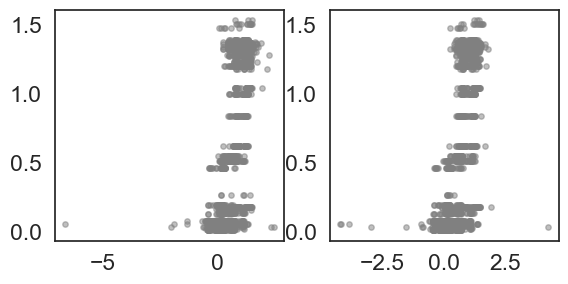

In [813]:
##### Started with n datapoints
round1_SVCSVR = round1UseDF[round1UseDF['Method'] == 'SVC+SVR']
round1_SVCSVR = round1_SVCSVR[round1_SVCSVR['# Training data'] == n]
round1_SVCSVR = round1_SVCSVR.reset_index(drop=True)

round1_SVR = round1UseDF[round1UseDF['Method'] == 'SVR']
round1_SVR = round1_SVR[round1_SVR['# Training data'] == n]
round1_SVR = round1_SVR.reset_index(drop=True)

comparisonList = round1_SVCSVR['Results'] - round1_SVR['Results']

# Number of cases that showed improvement:
# roundTwoLength = len(comparisonList)

topIndexList = \
sorted(range(len(comparisonList)), key=lambda i: comparisonList[i], reverse=True)[:roundTwoLength]
bottomIndexList = \
sorted(range(len(comparisonList)), key=lambda i: comparisonList[i], reverse=True)[-1*roundTwoLength:][::-1]

# Run here
newSVMSVRr2List_H_random = []
newSVRr2List_H_random = []
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6.5, 3))
for i in range(roundTwoLength):
    topIndex = topIndexList[i]
    print(topIndex, comparisonList[topIndex])
    if comparisonList[topIndex] > 0.3:
        
        # Dataframe for the first round of training
        ori = processExcelFormat03('round3.xlsx', 'FinalTimePoint', 0.6)

        # Get the SVM machine
        topSVMModel = r2Recorder_02[n][topIndex][0]
        ## Apply it to the ori df
        # Transform ori df to scaled version first
        inputName = list(ori.columns)[:-2]
        sc_X = scXRecorder_02[n][topIndex]
        sc_density = scDensityRecorder_02[n][topIndex]
        featureScaler = sc_X.fit(ori[inputName].values)
        scaled_features = featureScaler.transform(ori[inputName].values)
        ori[inputName] = scaled_features

        # Apply SVM on the full set
        ori['FirstRoundPrediction'] = topSVMModel.decision_function(ori[inputName])

        # The previous 10 training data row
        originalTopTrainDFIndexTop = indexRecorder_02[n][topIndex]

        # All other indicies
        newIndex = list(ori[~ori.index.isin(originalTopTrainDFIndexTop)].index)
        
        # Pick new data
        for j in range(3):
            allNew = random.sample(newIndex, n)
            final_IndexArrayTop_Comb = allNew + list(np.array(originalTopTrainDFIndexTop))

            # Get the new training & testing DF
            topSVMSVRnewTrainingDF = ori.loc[final_IndexArrayTop_Comb]
            topSVMSVRnewTestingDF = ori[~ori.index.isin(final_IndexArrayTop_Comb)]

            for t in range(3):
                # Run top once
                complexSVRSpearmanLists2D_02_neg, complexSVRPearsonLists2D_02_neg, \
                complexSVRR2Lists2D_02_neg, complexSVRMSELists2D_02_neg, \
                complexPredictedSVRSpearmanLists2D_02_neg, complexPredictedSVRPearsonLists2D_02_neg, \
                complexPredictedSVRR2Lists2D_02_neg, complexPredictedSVRMSELists2D_02_neg, \
                r2Recorder2D_02_neg, mseRecorder2D_02_neg, pearsonRecorder2D_02_neg, spearmanRecorder2D_02_neg, \
                SVRSpearmanLists2D_02_neg, SVRPearsonLists2D_02_neg, SVRR2Lists2D_02_neg, SVRMSELists2D_02_neg, \
                PredictedSVRSpearmanLists2D_02_neg, PredictedSVRPearsonLists2D_02_neg, \
                PredictedSVRR2Lists2D_02_neg, PredictedSVRMSELists2D_02_neg, \
                SVRr2Recorder2D_02_neg, SVRmseRecorder2D_02_neg, SVRpearsonRecorder2D_02_neg, SVRspearmanRecorder2D_02_neg,\
                indexRecorder2D_02_neg, TrainXDFRecorder2D_02_neg, TrainYDFRecorder2D_02_neg, \
                SVMSVRFullXDFRecorder2D_02_neg, SVMSVRFullYDFRecorder2D_02_neg, \
                scXRecorder2D_02_neg, scDensityRecorder2D_02_neg, scDistanceRecorder2D_02_neg = \
                ComparisonMultipleRun(1, 'round3.xlsx', 3, 'FinalTimePoint', [40], \
                                      final_IndexArrayTop_Comb, ['poly', 'rbf'], 0.6)
                # Get the new r2 pair
                newSVMSVRr2 = complexSVRR2Lists2D_02_neg[0][0][1]
                newSVMSVRr2List_H_random.append(newSVMSVRr2)

                newSVRr2 = SVRR2Lists2D_02_neg[0][0][1]
                newSVRr2List_H_random.append(newSVRr2)

                ax1.scatter(complexPredictedSVRR2Lists2D_02_neg[0][0][1], \
                            tDF[tDF.index.isin(indexRecorder2D_02_neg[40][0]) == False]['Density'], \
                            s = 15, color='grey', alpha = 0.5)

                ax2.scatter(PredictedSVRR2Lists2D_02_neg[0][0][1], \
                            tDF[tDF.index.isin(indexRecorder2D_02_neg[40][0]) == False]['Density'], \
                            s = 15, color='grey', alpha = 0.5)

print(newSVMSVRr2List_H_random, newSVRr2List_H_random)


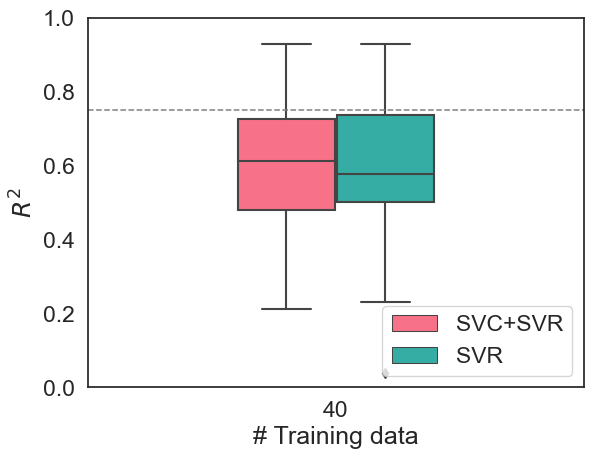

In [816]:
randomNewResult = ComparisonResultsListPlot([newSVMSVRr2List_H_random[:], newSVRr2List_H_random[:]], 40, \
                                         xname = '# Training data', yname = '$R^2$', show = 1, \
                              ylimit = [0, 1], yline = 0.75)

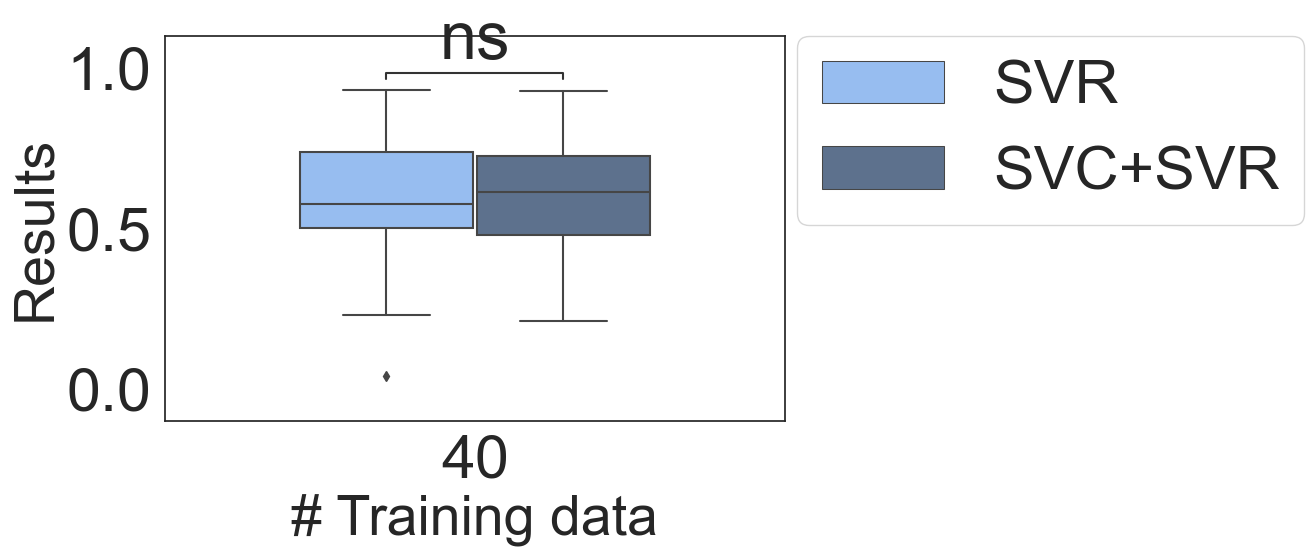

In [817]:
statsPlot(randomNewResult, 'Mann-Whitney')
# t-test_paired, Mann-Whitney

['Results']


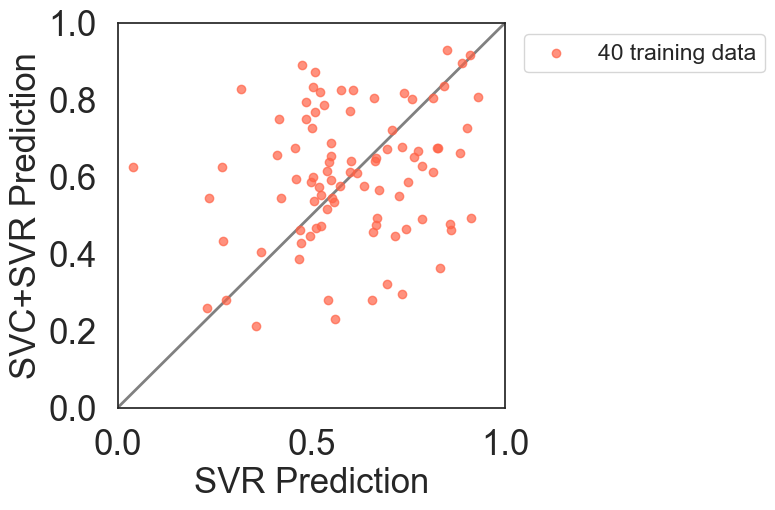

In [818]:
scatterComparisonPlot(randomNewResult)

In [819]:
# Fig 4B

In [820]:
closeNewResult['New data location'] = 'Close'
closeNewResult['First round performance'] = 'Good'

In [821]:
randomNewResult['New data location'] = 'Random'
randomNewResult['First round performance'] = 'Good'

In [822]:
CloseRandomFrames = [closeNewResult, randomNewResult]
CloseRandomConcated = pd.concat(CloseRandomFrames)

In [823]:
CloseRandomConcated

,Results,# Training data,Method,New data location,First round performance,Active learning strategy
0,0.752412,40,SVC+SVR,Close,Good,I
1,0.532825,40,SVC+SVR,Close,Good,I
2,0.651079,40,SVC+SVR,Close,Good,I
3,0.652815,40,SVC+SVR,Close,Good,I
4,0.683198,40,SVC+SVR,Close,Good,I
...,...,...,...,...,...,...
85,0.279192,40,SVR,Random,Good,NaN
86,0.656044,40,SVR,Random,Good,NaN
87,0.498650,40,SVR,Random,Good,NaN
88,0.666242,40,SVR,Random,Good,NaN


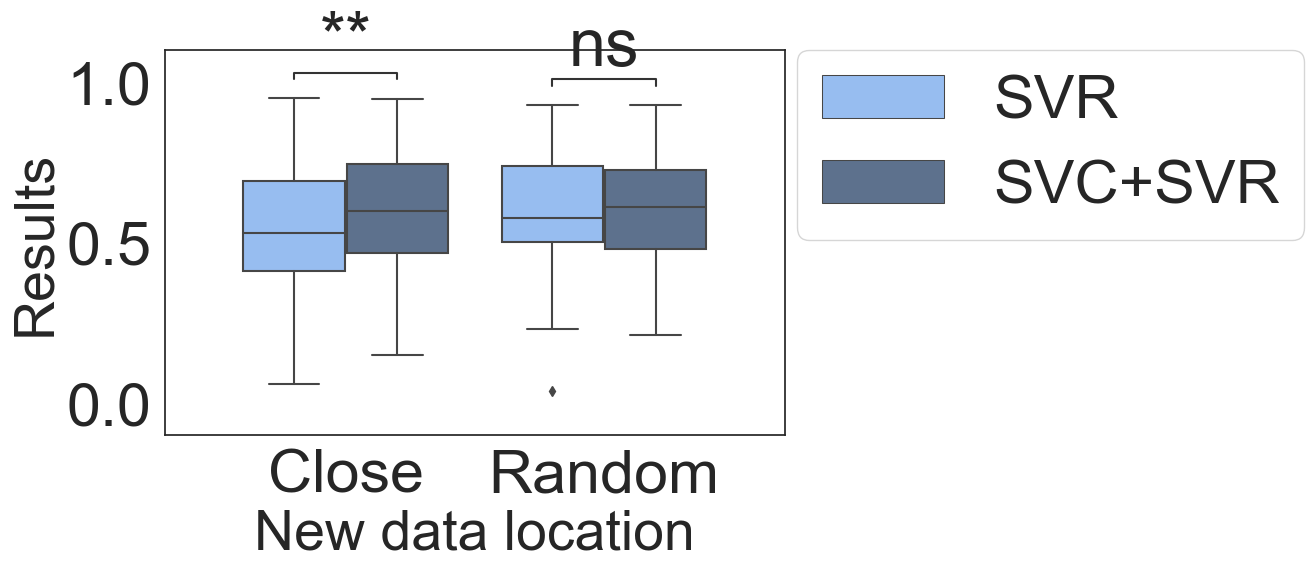

In [824]:
statsPlotForAL(CloseRandomConcated, 'New data location')

In [825]:
# Fig 4C

In [826]:
CloseFarMixFrames = [closeNewResult, farNewResult, mixNewResult]
CloseFarMixConcated = pd.concat(CloseFarMixFrames)

In [827]:
CloseFarMixConcated

,Results,# Training data,Method,New data location,First round performance,Active learning strategy
0,0.752412,40,SVC+SVR,Close,Good,I
1,0.532825,40,SVC+SVR,Close,Good,I
2,0.651079,40,SVC+SVR,Close,Good,I
3,0.652815,40,SVC+SVR,Close,Good,I
4,0.683198,40,SVC+SVR,Close,Good,I
...,...,...,...,...,...,...
145,0.516698,40,SVR,NaN,NaN,NaN
146,0.521076,40,SVR,NaN,NaN,NaN
147,0.907294,40,SVR,NaN,NaN,NaN
148,0.516676,40,SVR,NaN,NaN,NaN
